<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries used

In [1]:
import os
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             accuracy_score, hamming_loss, jaccard_score, make_scorer)
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.utils.tutorials.cnn_utils import evaluate, load_mnist, train

from joblib import dump, load
import joblib

In [2]:
torch.manual_seed(0)
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/eocque/bac/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)



# Data Loading

In [3]:
os.chdir("..")

In [4]:
train_file = "data/processed/raw/train_s_aureus_driams.csv"
train_bac = pd.read_csv(train_file)
train_bac

2000      2001      2002      2003      2004      2005      2006   
0     0.018721  0.016147  0.016983  0.021218  0.020846  0.019784  0.019405  \
1     0.009001  0.007475  0.006874  0.008575  0.009539  0.007894  0.008314   
2     0.022354  0.020220  0.020910  0.024631  0.021436  0.021197  0.020229   
3     0.017619  0.016073  0.016407  0.018011  0.019364  0.018950  0.017607   
4     0.008264  0.008229  0.006753  0.006657  0.010107  0.007039  0.008250   
...        ...       ...       ...       ...       ...       ...       ...   
2819  0.056616  0.039011  0.040380  0.048517  0.050865  0.047771  0.049312   
2820  0.125837  0.107712  0.109186  0.107613  0.109855  0.105060  0.099640   
2821  0.000000  0.000000  0.035603  0.039994  0.042372  0.046666  0.045781   
2822  0.005443  0.005998  0.003670  0.005588  0.006124  0.005019  0.004853   
2823  0.026184  0.022810  0.023200  0.020464  0.026694  0.024624  0.025140   

          2007      2008      2009  ...      9993      9994      9995   
0     0.023356  0.026224  0.026569  ...  0.037966  0.030364  0.037545  \
1     0.008013  0.008664  0.008923  ...  0.014496  0.024966  0.027437   
2     0.018818  0.018637  0.018815  ...  0.024620  0.022942  0.026715   
3     0.019116  0.023623  0.024492  ...  0.051312  0.047458  0.049338   
4     0.010670  0.008134  0.006513  ...  0.236769  0.217499  0.187244   
...        ...       ...       ...  ...       ...       ...       ...   
2819  0.048257  0.049417  0.049000  ...  0.021169  0.023617  0.033694   
2820  0.104169  0.120303  0.125067  ...  0.082375  0.083446  0.096510   
2821  0.043914  0.039875  0.037170  ...  0.006903  0.008322  0.011071   
2822  0.005400  0.004169  0.005151  ...  0.049241  0.039586  0.050542   
2823  0.026609  0.024203  0.020953  ...  0.090198  0.101889  0.105174   

          9996      9997      9998      9999  Oxacillin  Clindamycin   
0     0.040851  0.034176  0.046110  0.025638        0.0          0.0  \
1     0.026541  0.022940  0.020572  0.032504        0.0          0.0   
2     0.032045  0.030431  0.029085  0.013117        0.0          0.0   
3     0.055039  0.054541  0.058643  0.058919        0.0          0.0   
4     0.216243  0.221910  0.226531  0.221965        0.0          0.0   
...        ...       ...       ...       ...        ...          ...   
2819  0.021037  0.018727  0.010641  0.009238        0.0          1.0   
2820  0.084883  0.092228  0.085599  0.042142        0.0          1.0   
2821  0.010274  0.004682  0.003547  0.001744        0.0          0.0   
2822  0.039139  0.046816  0.043036  0.037402        1.0          1.0   
2823  0.122065  0.095740  0.082289  0.081714        0.0          0.0   

      Fusidic acid  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
2819           0.0  
2820           0.0  
2821           0.0  
2822           0.0  
2823           0.0  

[2824 rows x 8003 columns]

In [5]:
test_file = "data/processed/raw/test_s_aureus_driams.csv"
test_bac = pd.read_csv(test_file)
test_bac

2000      2001      2002      2003      2004      2005      2006   
0    0.044453  0.032486  0.032540  0.034223  0.037528  0.039503  0.031378  \
1    0.004318  0.001881  0.001274  0.000902  0.000892  0.000049  0.002188   
2    0.026184  0.026459  0.025393  0.028609  0.031314  0.031739  0.033337   
3    0.000000  0.015010  0.017782  0.014582  0.015084  0.018046  0.014461   
4    0.060499  0.043034  0.030296  0.032635  0.031272  0.032762  0.031154   
..        ...       ...       ...       ...       ...       ...       ...   
702  0.013092  0.011730  0.009902  0.013513  0.015317  0.011370  0.013338   
703  0.021222  0.015896  0.015512  0.017995  0.018663  0.019427  0.018667   
704  0.045613  0.041040  0.046177  0.050216  0.046525  0.048843  0.045920   
705  0.015193  0.011922  0.010877  0.009975  0.010474  0.012171  0.010417   
706  0.025453  0.022209  0.022442  0.025181  0.025069  0.025761  0.022690   

         2007      2008      2009  ...      9993      9994      9995   
0    0.035506  0.037688  0.035658  ...  0.247814  0.263833  0.279904  \
1    0.002001  0.003081  0.003384  ...  0.033364  0.042735  0.066426   
2    0.028051  0.028047  0.028978  ...  0.086746  0.087719  0.094103   
3    0.014400  0.018769  0.018272  ...  0.005062  0.006748  0.004573   
4    0.030382  0.030233  0.029438  ...  0.029452  0.033288  0.039230   
..        ...       ...       ...  ...       ...       ...       ...   
702  0.010117  0.010994  0.009222  ...  0.050851  0.046334  0.042840   
703  0.014589  0.016765  0.015071  ...  0.047285  0.056455  0.058002   
704  0.044283  0.043983  0.046330  ...  0.104234  0.094692  0.090012   
705  0.010783  0.013170  0.014157  ...  0.051772  0.058255  0.074609   
706  0.024250  0.022596  0.025572  ...  0.052692  0.061853  0.048375   

         9996      9997      9998      9999  Oxacillin  Clindamycin   
0    0.264432  0.241573  0.266020  0.231517        0.0          0.0  \
1    0.057485  0.052903  0.050839  0.036631        0.0          0.0   
2    0.080969  0.073970  0.069047  0.070988        0.0          1.0   
3    0.007583  0.008427  0.004729  0.002394        0.0          0.0   
4    0.046477  0.037219  0.022227  0.019920        0.0          0.0   
..        ...       ...       ...       ...        ...          ...   
702  0.061644  0.066948  0.061007  0.056178        0.0          0.0   
703  0.055528  0.043539  0.039962  0.034761        1.0          0.0   
704  0.096624  0.092228  0.100024  0.043682        0.0          0.0   
705  0.068249  0.049157  0.070229  0.043615        1.0          0.0   
706  0.060665  0.043305  0.041617  0.048284        0.0          0.0   

     Fusidic acid  
0             0.0  
1             0.0  
2             0.0  
3             1.0  
4             0.0  
..            ...  
702           0.0  
703           0.0  
704           1.0  
705           0.0  
706           0.0  

[707 rows x 8003 columns]

In [6]:
train_x_unsplit = train_bac[train_bac.columns.drop(list(train_bac.filter(regex='[^0-9]')))]
test_x = test_bac[test_bac.columns.drop(list(test_bac.filter(regex='[^0-9]')))]

In [7]:
antibiotics = train_bac.columns.drop(train_x_unsplit.columns)

In [8]:
train_y_unsplit = train_bac[antibiotics]
test_y = test_bac[antibiotics]

In [9]:
train_x, validation_x, train_y, validation_y = train_test_split(
    train_x_unsplit, 
    train_y_unsplit, 
    test_size=0.125, 
    random_state=0, 
    stratify=train_y_unsplit[antibiotics]
)

In [10]:
train_x_tensor = torch.FloatTensor(train_x.to_numpy())
train_y_tensor = torch.LongTensor(train_y.to_numpy())
validation_x_tensor = torch.FloatTensor(validation_x.to_numpy())
validation_y_tensor = torch.LongTensor(validation_y.to_numpy())
test_x_tensor = torch.FloatTensor(test_x.to_numpy())
test_y_tensor = torch.LongTensor(test_y.to_numpy())

In [11]:
class BacteriaDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [12]:
train_dataset = BacteriaDataset(train_x_tensor, train_y_tensor)
validation_dataset = BacteriaDataset(validation_x_tensor, validation_y_tensor)
test_dataset = BacteriaDataset(test_x_tensor, test_y_tensor)

# Evaluation

In [13]:
def multilabel_f1_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(true, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=f1_score(true[:, column], pred[:, column], average=average)
        column+=1
    return total/(column)

In [14]:
def report(true, pred):
        
    hl = hamming_loss(true, pred)
    f1w = multilabel_f1_wrapper(true, pred, "weighted")
    acc = accuracy_score(true, pred)
    
    f1u = multilabel_f1_wrapper(true, pred, "macro")
    f1su = f1_score(true, pred, average="macro")
    f1sw = f1_score(true, pred, average="weighted")

    
    print("Main metrics:")
    print(" Hamming Loss:", hl)
    print(" Accuracy:", acc)
    print(" F1 Score (Weighted):", f1w)
    print("================================================")
    print("Other metrics:")
    print(" F1 Score (Unweighted):", f1u)
    print(" F1 Score (sklearn Unweighted):", f1su)
    print(" F1 Score (sklearn Weighted):", f1sw)
    return hl, acc, f1w

In [15]:
def pred_tensor_to_binary_list(pred):
    preds = []
    for i in range(len(pred["oxacillin"])):
        preds.append(
            [
                pred["oxacillin"].argmax(1)[i].item(),
                pred["clindamycin"].argmax(1)[i].item(),
                pred["fusidic_acid"].argmax(1)[i].item()
            ]
        )
    return preds

# Building the model

In [16]:
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.oxacillin = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        self.clindamycin = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        self.fusidic_acid = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
    
    
    def forward(self, x):
        return {
            'oxacillin': self.oxacillin(x),
            'clindamycin': self.clindamycin(x),
            'fusidic_acid': self.fusidic_acid(x)
        }
    
    def get_loss(self, net_output, ground_truth):
        oxacillin_loss = cross_entropy(net_output['oxacillin'], ground_truth[:, 0])
        clindamycin_loss = cross_entropy(net_output['clindamycin'], ground_truth[:, 1])
        fusidic_acid_loss = cross_entropy(net_output['fusidic_acid'], ground_truth[:, 2])
        loss = oxacillin_loss + clindamycin_loss + fusidic_acid_loss
        return loss, {'oxacillin': oxacillin_loss, 'clindamycin': clindamycin_loss, 'fusidic_acid': fusidic_acid_loss}

In [17]:
input_dim  = len(train_x.columns)
output_dim = len(np.unique(train_y))

# Optimization

In [18]:
ax_client = AxClient()
ax_client.create_experiment(
    name="bac tuning",
    parameters=[
        {
            "name": "lr", 
            "type": "range",
            "bounds": [1e-6, 0.4],
            "value_type": "float", 
            "log_scale": True
        }
    ],
    objectives={"f1": ObjectiveProperties(minimize=False),}
)

[INFO 11-26 21:17:27] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 11-26 21:17:27] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.4], log_scale=True)], parameter_constraints=[]).
[INFO 11-26 21:17:27] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 11-26 21:17:27] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=1 num_trials=None use_batch_trials=False
[INFO 11-26 21:17:27] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 11-26 21:17:27] ax.modelbridge

In [19]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [20]:
def train_loop(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        train_loss, train_losses = model.get_loss(pred, y)

        # Backpropagation
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return train_loss


def validation_loop(dataloader, model):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0
    
    true = []
    preds = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            validation_loss_aux, validation_losses = model.get_loss(pred, y)
            validation_loss += validation_loss_aux    
                
            for i in range(len(y)):
                true.append(
                    [
                        y[i][0].item(),
                        y[i][1].item(),
                        y[i][2].item()
                    ]
                )
                
            preds = preds + pred_tensor_to_binary_list(pred)
    validation_loss /= num_batches
    #hl, acc, f1 = report(true, preds)
    f1 = multilabel_f1_wrapper(true, preds, "weighted")
    #print(f"Avg loss: {validation_loss:>8f} \n")
    return validation_loss, f1

In [21]:
class EarlyStopper:
    def __init__(self, model, patience=1, min_delta=0, metric_asc=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.epoch = 0
        self.best_epoch = 0
        self.min_validation_loss = float('inf')
        
        self.best_metric = 0
        if not metric_asc:
            self.best_metric = 1
            
        self.model = model
        self.best_model = copy.deepcopy(model)

    def early_stop(self, validation_loss, metric):
        self.epoch += 1
        if validation_loss < self.min_validation_loss:
            self.best_epoch = self.epoch
            self.min_validation_loss = validation_loss
            self.best_metric = metric
            self.counter = 0
            self.best_model = copy.deepcopy(self.model)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [22]:
def train_evaluate(train_dataloader, validation_dataloader, parameters, input_dim, output_dim):
    """
    Train the model and then compute an evaluation metric.

    In this tutorial, the CNN utils package is doing a lot of work
    under the hood:
        - `train` initializes the network, defines the loss function
        and optimizer, performs the training loop, and returns the
        trained model.
        - `evaluate` computes the accuracy of the model on the
        evaluation dataset and returns the metric.

    For your use case, you can define training and evaluation functions
    of your choosing.

    """
    model = NeuralNetworkClassificationModel(input_dim, output_dim)    
    
    lr = parameters["lr"]

    epochs = 150

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    early_stopper = EarlyStopper(model, patience=3, min_delta=0.05, metric_asc=True)
    for t in range(epochs):
        print(f"\nEpoch {t+1}")
        train_loss = train_loop(train_dataloader, model, optimizer)
        validation_loss, f1 = validation_loop(validation_dataloader, model)
        print("Train:", train_loss.item())
        print("Validation:", validation_loss.item())
        print("F1:", f1)
        if early_stopper.early_stop(validation_loss, f1):             
            break
    
    print("\nStop Epoch:", early_stopper.best_epoch)
    print("Best Model's F1:", early_stopper.best_metric)
    return early_stopper.best_metric

In [23]:
for i in range(250):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(
        trial_index=trial_index, 
        raw_data=train_evaluate(train_dataloader, validation_dataloader, parameters, input_dim, output_dim)
    )

[INFO 11-26 21:17:28] ax.service.ax_client: Generated new trial 0 with parameters {'lr': 0.000126}.



Epoch 1
Train: 1.0694372653961182
Validation: 1.3403949737548828
F1: 0.8015210116814045

Epoch 2
Train: 1.629512071609497
Validation: 1.2904733419418335
F1: 0.8015210116814045

Epoch 3
Train: 1.5459507703781128
Validation: 1.2822363376617432
F1: 0.8026220484646003

Epoch 4
Train: 1.5014013051986694
Validation: 1.2428998947143555
F1: 0.8015210116814045

Epoch 5
Train: 1.0100831985473633
Validation: 1.225329041481018
F1: 0.808260466033909

Epoch 6
Train: 1.121822476387024
Validation: 1.2062071561813354
F1: 0.8156747191414001

Epoch 7
Train: 0.9912221431732178
Validation: 1.2081421613693237
F1: 0.8111245612323664

Epoch 8
Train: 1.4374415874481201
Validation: 1.1584362983703613
F1: 0.8231265863282164

Epoch 9
Train: 0.8561776280403137
Validation: 1.1472413539886475
F1: 0.8111245612323664

Epoch 10
Train: 1.015344262123108
Validation: 1.1282154321670532
F1: 0.8105853160155531

Epoch 11
Train: 1.2597262859344482
Validation: 1.174095869064331
F1: 0.8278515728329792

Epoch 12
Train: 1.341007

[INFO 11-26 21:18:11] ax.service.ax_client: Completed trial 0 with data: {'f1': (0.860554, None)}.
[INFO 11-26 21:18:11] ax.service.ax_client: Generated new trial 1 with parameters {'lr': 0.0235}.


Train: 0.3212120234966278
Validation: 1.1956589221954346
F1: 0.8336187585854983

Stop Epoch: 40
Best F1: 0.8605541734607779

Epoch 1
Train: 1.0325493812561035
Validation: 2.8854267597198486
F1: 0.8012260762633406

Epoch 2
Train: 0.9932551383972168
Validation: 1.1810829639434814
F1: 0.8015210116814045

Epoch 3
Train: 1.1084256172180176
Validation: 1.159515619277954
F1: 0.8009306006705182

Epoch 4
Train: 1.415145754814148
Validation: 1.1514142751693726
F1: 0.8015210116814045

Epoch 5
Train: 0.9800119400024414
Validation: 1.1356711387634277
F1: 0.8015210116814045

Epoch 6
Train: 1.1187467575073242
Validation: 1.192760705947876
F1: 0.8015210116814045

Epoch 7
Train: 1.0990568399429321
Validation: 1.1188092231750488
F1: 0.8015210116814045

Epoch 8
Train: 1.172720193862915
Validation: 1.1028354167938232
F1: 0.8015210116814045

Epoch 9
Train: 1.1756640672683716
Validation: 1.0974562168121338
F1: 0.8015210116814045

Epoch 10
Train: 1.2825508117675781
Validation: 1.0731836557388306
F1: 0.801521

[INFO 11-26 21:18:31] ax.service.ax_client: Completed trial 1 with data: {'f1': (0.834281, None)}.
[INFO 11-26 21:18:31] ax.service.ax_client: Generated new trial 2 with parameters {'lr': 1e-06}.


Train: 0.9675842523574829
Validation: 1.1119048595428467
F1: 0.8284234844357953

Stop Epoch: 14
Best F1: 0.8342808591052031

Epoch 1
Train: 1.9840338230133057
Validation: 2.0004289150238037
F1: 0.8057697106064853

Epoch 2
Train: 1.9335222244262695
Validation: 1.9284017086029053
F1: 0.8012293814685144

Epoch 3
Train: 1.858980417251587
Validation: 1.8571438789367676
F1: 0.8015210116814045

Epoch 4
Train: 1.7568669319152832
Validation: 1.78826904296875
F1: 0.8015210116814045

Epoch 5
Train: 1.680906057357788
Validation: 1.7214428186416626
F1: 0.8015210116814045

Epoch 6
Train: 1.5320343971252441
Validation: 1.6641894578933716
F1: 0.8015210116814045

Epoch 7
Train: 1.7453677654266357
Validation: 1.61256742477417
F1: 0.8015210116814045

Epoch 8
Train: 1.4611084461212158
Validation: 1.569770097732544
F1: 0.8015210116814045

Epoch 9
Train: 1.582716941833496
Validation: 1.5337132215499878
F1: 0.8015210116814045

Epoch 10
Train: 1.879181146621704
Validation: 1.5003193616867065
F1: 0.80152101168

Train: 1.0954054594039917
Validation: 1.2941412925720215
F1: 0.8015210116814045

Epoch 93
Train: 1.2295444011688232
Validation: 1.2954481840133667
F1: 0.8015210116814045

Epoch 94
Train: 1.1896394491195679
Validation: 1.2940248250961304
F1: 0.8015210116814045

Epoch 95
Train: 1.3208389282226562
Validation: 1.2976855039596558
F1: 0.8015210116814045

Epoch 96
Train: 1.252598524093628
Validation: 1.3010532855987549
F1: 0.8015210116814045

Epoch 97
Train: 1.4394595623016357
Validation: 1.2898075580596924
F1: 0.8015210116814045

Epoch 98
Train: 1.564920425415039
Validation: 1.28866446018219
F1: 0.8015210116814045

Epoch 99
Train: 0.8470138311386108
Validation: 1.2914502620697021
F1: 0.8015210116814045

Epoch 100
Train: 1.257533311843872
Validation: 1.2849764823913574
F1: 0.8015210116814045

Epoch 101
Train: 1.0958740711212158
Validation: 1.2908918857574463
F1: 0.8015210116814045

Epoch 102
Train: 0.8476143479347229
Validation: 1.2879571914672852
F1: 0.8015210116814045

Epoch 103
Train: 1.21

[INFO 11-26 21:20:43] ax.service.ax_client: Completed trial 2 with data: {'f1': (0.801521, None)}.
[INFO 11-26 21:20:43] ax.service.ax_client: Generated new trial 3 with parameters {'lr': 0.179653}.


Train: 1.171437382698059
Validation: 1.2572758197784424
F1: 0.8015210116814045

Stop Epoch: 145
Best F1: 0.8015210116814045

Epoch 1
Train: 1.1826879978179932
Validation: 2.6095504760742188
F1: 0.8015210116814045

Epoch 2
Train: 1.0757322311401367
Validation: 1.254148006439209
F1: 0.8015210116814045

Epoch 3
Train: 0.7930653691291809
Validation: 2.189335823059082
F1: 0.8015210116814045

Epoch 4
Train: 1.6511361598968506
Validation: 2.3888750076293945
F1: 0.8015210116814045

Epoch 5


[INFO 11-26 21:20:48] ax.service.ax_client: Completed trial 3 with data: {'f1': (0.801521, None)}.
[INFO 11-26 21:20:48] ax.service.ax_client: Generated new trial 4 with parameters {'lr': 0.378889}.


Train: 1.8533728122711182
Validation: 3.2531352043151855
F1: 0.5034230203304116

Stop Epoch: 2
Best F1: 0.8015210116814045

Epoch 1
Train: 6.473082542419434
Validation: 24.50477409362793
F1: 0.551124048271555

Epoch 2
Train: 361.5010681152344
Validation: 23.30130386352539
F1: 0.5864127375462488

Epoch 3
Train: 7.928514003753662
Validation: 31.298545837402344
F1: 0.8012275523610638

Epoch 4
Train: 12.708033561706543
Validation: 20.979339599609375
F1: 0.551124048271555

Epoch 5
Train: 4.231959342956543
Validation: 24.18907928466797
F1: 0.8012275523610638

Epoch 6
Train: 5.668856620788574
Validation: 24.72896957397461
F1: 0.5864127375462488

Epoch 7


[INFO 11-26 21:20:54] ax.service.ax_client: Completed trial 4 with data: {'f1': (0.551124, None)}.


Train: 4.224886417388916
Validation: 22.398040771484375
F1: 0.8012275523610638

Stop Epoch: 4
Best F1: 0.551124048271555


[INFO 11-26 21:20:54] ax.service.ax_client: Generated new trial 5 with parameters {'lr': 0.001228}.



Epoch 1
Train: 0.9730454683303833
Validation: 1.341377854347229
F1: 0.8015210116814045

Epoch 2
Train: 1.0562145709991455
Validation: 1.2479745149612427
F1: 0.8015210116814045

Epoch 3
Train: 0.90311199426651
Validation: 1.1995195150375366
F1: 0.8093161450579333

Epoch 4
Train: 1.1583057641983032
Validation: 1.1948490142822266
F1: 0.8234395836290971

Epoch 5
Train: 0.7279759049415588
Validation: 1.16697096824646
F1: 0.8114877396174691

Epoch 6
Train: 1.3689649105072021
Validation: 1.0939295291900635
F1: 0.8163645533805998

Epoch 7
Train: 0.89057457447052
Validation: 1.1559382677078247
F1: 0.8118514826676133

Epoch 8
Train: 1.0153502225875854
Validation: 1.100303292274475
F1: 0.8118514826676133

Epoch 9
Train: 0.9544050693511963
Validation: 1.0342665910720825
F1: 0.8378407607753787

Epoch 10
Train: 1.3109432458877563
Validation: 1.0899786949157715
F1: 0.8263688163271891

Epoch 11
Train: 1.3442171812057495
Validation: 1.0655014514923096
F1: 0.8243533027028702

Epoch 12
Train: 1.00123512

[INFO 11-26 21:21:15] ax.service.ax_client: Completed trial 5 with data: {'f1': (0.856247, None)}.


Train: 0.8746830224990845
Validation: 1.0279185771942139
F1: 0.8480912533866315

Stop Epoch: 19
Best F1: 0.8562468809143584


[INFO 11-26 21:21:15] ax.service.ax_client: Generated new trial 6 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.1799201965332031
Validation: 1.407636284828186
F1: 0.8015210116814045

Epoch 2
Train: 1.1977676153182983
Validation: 1.3601772785186768
F1: 0.8015210116814045

Epoch 3
Train: 1.1934807300567627
Validation: 1.3444472551345825
F1: 0.8015210116814045

Epoch 4
Train: 1.063689112663269
Validation: 1.3312029838562012
F1: 0.8015210116814045

Epoch 5
Train: 0.9102697372436523
Validation: 1.324759602546692
F1: 0.8015210116814045

Epoch 6
Train: 1.5487830638885498
Validation: 1.3054382801055908
F1: 0.8015210116814045

Epoch 7
Train: 1.2576911449432373
Validation: 1.288683533668518
F1: 0.8015210116814045

Epoch 8
Train: 1.1153898239135742
Validation: 1.279356598854065
F1: 0.8015210116814045

Epoch 9
Train: 1.4622822999954224
Validation: 1.277846097946167
F1: 0.8015210116814045

Epoch 10
Train: 1.3677005767822266
Validation: 1.2552400827407837
F1: 0.8029239064949915

Epoch 11
Train: 1.4464771747589111
Validation: 1.2487354278564453
F1: 0.8015210116814045

Epoch 12
Train: 1.449534

Train: 0.6908701062202454
Validation: 0.9233505725860596
F1: 0.8555416733607398

Epoch 94
Train: 0.9181739687919617
Validation: 0.9316619038581848
F1: 0.8610511146277501

Epoch 95
Train: 0.8465821146965027
Validation: 0.9130042195320129
F1: 0.8620739753734364

Epoch 96
Train: 0.8059793710708618
Validation: 0.9508531093597412
F1: 0.8647682522118488

Epoch 97
Train: 0.9003877639770508
Validation: 0.994272768497467
F1: 0.8580227396297833

Epoch 98
Train: 0.9491699934005737
Validation: 0.9155666828155518
F1: 0.8576348046393433

Epoch 99
Train: 0.5722882747650146
Validation: 0.9095596671104431
F1: 0.8614930614322031

Epoch 100
Train: 1.1124176979064941
Validation: 0.9379913806915283
F1: 0.8652626445602194

Epoch 101
Train: 0.6078798174858093
Validation: 0.9132378697395325
F1: 0.8607864161557653

Epoch 102
Train: 0.5150564312934875
Validation: 0.9390832185745239
F1: 0.8666607608383834

Epoch 103
Train: 0.9960379600524902
Validation: 0.969669759273529
F1: 0.8625988564812349

Epoch 104
Train: 

[INFO 11-26 21:23:18] ax.service.ax_client: Completed trial 6 with data: {'f1': (0.872416, None)}.


Train: 0.6698707342147827
Validation: 0.9227394461631775
F1: 0.8755968794538922

Stop Epoch: 129
Best F1: 0.8724164007443961


[INFO 11-26 21:23:18] ax.service.ax_client: Generated new trial 7 with parameters {'lr': 0.000356}.



Epoch 1
Train: 1.115639328956604
Validation: 1.3104782104492188
F1: 0.8015210116814045

Epoch 2
Train: 0.8970999717712402
Validation: 1.2899311780929565
F1: 0.8015210116814045

Epoch 3
Train: 1.1574822664260864
Validation: 1.236026406288147
F1: 0.8015210116814045

Epoch 4
Train: 1.2165411710739136
Validation: 1.181067943572998
F1: 0.807913718760317

Epoch 5
Train: 1.0506727695465088
Validation: 1.1505894660949707
F1: 0.8127299824683911

Epoch 6
Train: 1.1180846691131592
Validation: 1.1237504482269287
F1: 0.8053493065264812

Epoch 7
Train: 1.5046825408935547
Validation: 1.0940451622009277
F1: 0.834363864962214

Epoch 8
Train: 0.6465179920196533
Validation: 1.1198813915252686
F1: 0.8118514826676133

Epoch 9
Train: 1.313124179840088
Validation: 1.0604543685913086
F1: 0.8371549973153902

Epoch 10
Train: 1.157469630241394
Validation: 1.0683906078338623
F1: 0.8435790514376854

Epoch 11
Train: 0.8594038486480713
Validation: 1.0321834087371826
F1: 0.8432007866945129

Epoch 12
Train: 1.3578155

[INFO 11-26 21:23:49] ax.service.ax_client: Completed trial 7 with data: {'f1': (0.867161, None)}.


Train: 0.7522081732749939
Validation: 0.9815596342086792
F1: 0.8590396787892676

Stop Epoch: 31
Best F1: 0.8671609370360996


[INFO 11-26 21:23:49] ax.service.ax_client: Generated new trial 8 with parameters {'lr': 0.003836}.



Epoch 1
Train: 0.8503062725067139
Validation: 1.3863797187805176
F1: 0.8015210116814045

Epoch 2
Train: 1.3966139554977417
Validation: 1.2607678174972534
F1: 0.8089557695161624

Epoch 3
Train: 1.5626658201217651
Validation: 1.207672357559204
F1: 0.8256054521552038

Epoch 4
Train: 1.1032377481460571
Validation: 1.1511836051940918
F1: 0.8039951855083635

Epoch 5
Train: 1.1305880546569824
Validation: 1.0898736715316772
F1: 0.8310436322152611

Epoch 6
Train: 0.5967364311218262
Validation: 1.5810933113098145
F1: 0.8012293814685144

Epoch 7
Train: 1.1951347589492798
Validation: 1.0613785982131958
F1: 0.820453122867037

Epoch 8
Train: 0.7077833414077759
Validation: 1.314760684967041
F1: 0.8125311159089001

Epoch 9
Train: 1.2092411518096924
Validation: 1.069841742515564
F1: 0.8093024564925524

Epoch 10
Train: 0.8578911423683167
Validation: 1.047738790512085
F1: 0.8357248693068509

Epoch 11
Train: 1.0877965688705444
Validation: 1.026818037033081
F1: 0.8347435344069698

Epoch 12
Train: 1.477836

[INFO 11-26 21:24:01] ax.service.ax_client: Completed trial 8 with data: {'f1': (0.847829, None)}.


Train: 0.5457214713096619
Validation: 1.1951886415481567
F1: 0.8179461602659804

Stop Epoch: 12
Best F1: 0.8478294679479248


[INFO 11-26 21:24:01] ax.service.ax_client: Generated new trial 9 with parameters {'lr': 5.8e-05}.



Epoch 1
Train: 0.8953114748001099
Validation: 1.3744665384292603
F1: 0.8015210116814045

Epoch 2
Train: 0.8594284057617188
Validation: 1.3408738374710083
F1: 0.8015210116814045

Epoch 3
Train: 1.445158839225769
Validation: 1.3270039558410645
F1: 0.8015210116814045

Epoch 4
Train: 1.1483502388000488
Validation: 1.2865726947784424
F1: 0.8015210116814045

Epoch 5
Train: 0.9093607068061829
Validation: 1.2617270946502686
F1: 0.8015210116814045

Epoch 6
Train: 1.0753039121627808
Validation: 1.256364345550537
F1: 0.8015210116814045

Epoch 7
Train: 1.4566938877105713
Validation: 1.2393860816955566
F1: 0.8015210116814045

Epoch 8
Train: 1.0035327672958374
Validation: 1.2208846807479858
F1: 0.805670580552459

Epoch 9
Train: 1.3904905319213867
Validation: 1.211966872215271
F1: 0.805670580552459

Epoch 10
Train: 0.68013596534729
Validation: 1.2088749408721924
F1: 0.8029239064949915

Epoch 11
Train: 1.4219212532043457
Validation: 1.1778508424758911
F1: 0.8112508575452324

Epoch 12
Train: 1.3963052

[INFO 11-26 21:24:49] ax.service.ax_client: Completed trial 9 with data: {'f1': (0.862777, None)}.


Train: 0.732276201248169
Validation: 1.0236674547195435
F1: 0.8579508477268493

Stop Epoch: 51
Best F1: 0.8627765217549935


[INFO 11-26 21:24:50] ax.service.ax_client: Generated new trial 10 with parameters {'lr': 0.000682}.



Epoch 1
Train: 1.0617976188659668
Validation: 1.3104742765426636
F1: 0.8015210116814045

Epoch 2
Train: 0.882500410079956
Validation: 1.2745001316070557
F1: 0.8015210116814045

Epoch 3
Train: 1.569999098777771
Validation: 1.221397042274475
F1: 0.8063544913970627

Epoch 4
Train: 0.7883270978927612
Validation: 1.1866576671600342
F1: 0.8162107787680789

Epoch 5
Train: 1.2834999561309814
Validation: 1.1885790824890137
F1: 0.8102294859636494

Epoch 6
Train: 0.8533490300178528
Validation: 1.229478359222412
F1: 0.8043069203143897

Epoch 7
Train: 0.7772393226623535
Validation: 1.0758737325668335
F1: 0.8179058443512245

Epoch 8
Train: 1.2172847986221313
Validation: 1.2155861854553223
F1: 0.8015210116814045

Epoch 9
Train: 0.8115556240081787
Validation: 1.109062910079956
F1: 0.8191205348572751

Epoch 10
Train: 0.7380590438842773
Validation: 1.0073505640029907
F1: 0.8401089108753643

Epoch 11
Train: 1.871588945388794
Validation: 1.0363751649856567
F1: 0.8371368370732549

Epoch 12
Train: 0.828848

[INFO 11-26 21:25:12] ax.service.ax_client: Completed trial 10 with data: {'f1': (0.860114, None)}.


Train: 0.8553391695022583
Validation: 1.0380667448043823
F1: 0.8468135922109239

Stop Epoch: 24
Best F1: 0.8601137129353781


[INFO 11-26 21:25:12] ax.service.ax_client: Generated new trial 11 with parameters {'lr': 1.2e-05}.



Epoch 1
Train: 1.4755299091339111
Validation: 1.6045057773590088
F1: 0.8015210116814045

Epoch 2
Train: 1.2391806840896606
Validation: 1.4008933305740356
F1: 0.8015210116814045

Epoch 3
Train: 1.2231097221374512
Validation: 1.3649014234542847
F1: 0.8015210116814045

Epoch 4
Train: 1.7492775917053223
Validation: 1.3614230155944824
F1: 0.8015210116814045

Epoch 5
Train: 1.0376883745193481
Validation: 1.3561123609542847
F1: 0.8015210116814045

Epoch 6
Train: 1.6299467086791992
Validation: 1.3478035926818848
F1: 0.8015210116814045

Epoch 7
Train: 1.431057333946228
Validation: 1.3404135704040527
F1: 0.8015210116814045

Epoch 8
Train: 1.2031099796295166
Validation: 1.3515684604644775
F1: 0.8015210116814045

Epoch 9
Train: 1.5366016626358032
Validation: 1.3315461874008179
F1: 0.8015210116814045

Epoch 10
Train: 1.3364391326904297
Validation: 1.315783977508545
F1: 0.8015210116814045

Epoch 11
Train: 0.9767200350761414
Validation: 1.309126377105713
F1: 0.8015210116814045

Epoch 12
Train: 1.048

Train: 0.7411314845085144
Validation: 0.9819374084472656
F1: 0.8405340412975747

Epoch 94
Train: 0.9867696762084961
Validation: 0.9877645969390869
F1: 0.8429210245308116

Epoch 95
Train: 0.6146126389503479
Validation: 0.9777702689170837
F1: 0.8415427981737794

Epoch 96
Train: 0.7262521386146545
Validation: 0.9767810106277466
F1: 0.8421053585780589

Epoch 97
Train: 0.8650733232498169
Validation: 0.9883477687835693
F1: 0.8476933840682043

Epoch 98
Train: 0.8140861392021179
Validation: 0.9684188365936279
F1: 0.8396122887649479

Epoch 99
Train: 0.7786659598350525
Validation: 0.9643495082855225
F1: 0.8418381338552448

Epoch 100
Train: 1.1961601972579956
Validation: 0.974358856678009
F1: 0.8498928844669287

Epoch 101
Train: 0.7906663417816162
Validation: 0.9692265391349792
F1: 0.8488505498880866

Epoch 102
Train: 1.1441495418548584
Validation: 0.9613328576087952
F1: 0.8470956983443526

Epoch 103
Train: 0.9160405993461609
Validation: 0.9642857313156128
F1: 0.8423346282119241

Epoch 104
Train:

[INFO 11-26 21:27:28] ax.service.ax_client: Completed trial 11 with data: {'f1': (0.851882, None)}.


Train: 0.6999335289001465
Validation: 0.92340087890625
F1: 0.8559787707410216

Stop Epoch: 141
Best F1: 0.8518818959398278


[INFO 11-26 21:27:29] ax.service.ax_client: Generated new trial 12 with parameters {'lr': 0.000215}.



Epoch 1
Train: 1.2093513011932373
Validation: 1.3301681280136108
F1: 0.8015210116814045

Epoch 2
Train: 1.5901330709457397
Validation: 1.3040409088134766
F1: 0.8015210116814045

Epoch 3
Train: 0.947961688041687
Validation: 1.2415539026260376
F1: 0.8015210116814045

Epoch 4
Train: 1.083853006362915
Validation: 1.2148947715759277
F1: 0.8015210116814045

Epoch 5
Train: 0.9188408255577087
Validation: 1.2064787149429321
F1: 0.8015210116814045

Epoch 6
Train: 1.8316749334335327
Validation: 1.1720257997512817
F1: 0.805670580552459

Epoch 7
Train: 1.059624433517456
Validation: 1.1443887948989868
F1: 0.811619732724458

Epoch 8
Train: 0.9495290517807007
Validation: 1.1191747188568115
F1: 0.8147829464952192

Epoch 9
Train: 0.9162769913673401
Validation: 1.1984407901763916
F1: 0.8053493065264812

Epoch 10
Train: 1.226080298423767
Validation: 1.1963419914245605
F1: 0.8262449647635667

Epoch 11
Train: 1.4854142665863037
Validation: 1.106655478477478
F1: 0.8281877643875477

Epoch 12
Train: 1.5549986

[INFO 11-26 21:28:10] ax.service.ax_client: Completed trial 12 with data: {'f1': (0.87466, None)}.


Train: 0.9541009664535522
Validation: 0.9697631001472473
F1: 0.872820235373646

Stop Epoch: 40
Best F1: 0.874659567978293


[INFO 11-26 21:28:11] ax.service.ax_client: Generated new trial 13 with parameters {'lr': 8.6e-05}.



Epoch 1
Train: 1.5589430332183838
Validation: 1.3629950284957886
F1: 0.8015210116814045

Epoch 2
Train: 2.387979745864868
Validation: 1.3252297639846802
F1: 0.8015210116814045

Epoch 3
Train: 1.458322525024414
Validation: 1.2951149940490723
F1: 0.8015210116814045

Epoch 4
Train: 1.5956944227218628
Validation: 1.280000925064087
F1: 0.8015210116814045

Epoch 5
Train: 1.3817172050476074
Validation: 1.2633382081985474
F1: 0.8015210116814045

Epoch 6
Train: 1.106489896774292
Validation: 1.2383030652999878
F1: 0.8015210116814045

Epoch 7
Train: 1.0816075801849365
Validation: 1.2219160795211792
F1: 0.8120677255335552

Epoch 8
Train: 1.0100135803222656
Validation: 1.1903408765792847
F1: 0.8053493065264812

Epoch 9
Train: 1.319546103477478
Validation: 1.1727937459945679
F1: 0.8076632925761608

Epoch 10
Train: 1.7706053256988525
Validation: 1.2078007459640503
F1: 0.8245685303890253

Epoch 11
Train: 0.9652940034866333
Validation: 1.1515617370605469
F1: 0.8114877396174691

Epoch 12
Train: 1.25979

[INFO 11-26 21:28:59] ax.service.ax_client: Completed trial 13 with data: {'f1': (0.859031, None)}.


Train: 0.9788649082183838
Validation: 0.9704106450080872
F1: 0.8602795925210852

Stop Epoch: 46
Best F1: 0.8590312104842995


[INFO 11-26 21:29:00] ax.service.ax_client: Generated new trial 14 with parameters {'lr': 4e-05}.



Epoch 1
Train: 1.0637961626052856
Validation: 1.3709419965744019
F1: 0.8015210116814045

Epoch 2
Train: 1.5040156841278076
Validation: 1.3532142639160156
F1: 0.8015210116814045

Epoch 3
Train: 1.4241210222244263
Validation: 1.3296884298324585
F1: 0.8015210116814045

Epoch 4
Train: 1.1695152521133423
Validation: 1.3146629333496094
F1: 0.8015210116814045

Epoch 5
Train: 1.0511159896850586
Validation: 1.3060836791992188
F1: 0.8015210116814045

Epoch 6
Train: 1.3353204727172852
Validation: 1.281559705734253
F1: 0.8015210116814045

Epoch 7
Train: 1.136474609375
Validation: 1.2707314491271973
F1: 0.8015210116814045

Epoch 8
Train: 0.8931412696838379
Validation: 1.2706741094589233
F1: 0.8015210116814045

Epoch 9
Train: 1.1773996353149414
Validation: 1.2427809238433838
F1: 0.8015210116814045

Epoch 10
Train: 1.116544485092163
Validation: 1.2309848070144653
F1: 0.8091645716592929

Epoch 11
Train: 1.5237330198287964
Validation: 1.2161521911621094
F1: 0.8053634958517576

Epoch 12
Train: 1.222402

[INFO 11-26 21:30:03] ax.service.ax_client: Completed trial 14 with data: {'f1': (0.85072, None)}.


Train: 0.5874310731887817
Validation: 1.0231664180755615
F1: 0.8623874645911721

Stop Epoch: 59
Best F1: 0.8507200772909952


[INFO 11-26 21:30:03] ax.service.ax_client: Generated new trial 15 with parameters {'lr': 0.000162}.



Epoch 1
Train: 1.43663489818573
Validation: 1.348454475402832
F1: 0.8015210116814045

Epoch 2
Train: 1.4422221183776855
Validation: 1.3015437126159668
F1: 0.8015210116814045

Epoch 3
Train: 1.3511396646499634
Validation: 1.2761154174804688
F1: 0.8015210116814045

Epoch 4
Train: 1.1937739849090576
Validation: 1.2376976013183594
F1: 0.8015210116814045

Epoch 5
Train: 1.1777799129486084
Validation: 1.2081894874572754
F1: 0.805670580552459

Epoch 6
Train: 1.0459486246109009
Validation: 1.1745823621749878
F1: 0.8091645716592929

Epoch 7
Train: 0.8596332669258118
Validation: 1.1445366144180298
F1: 0.8139940488131843

Epoch 8
Train: 0.705071210861206
Validation: 1.1633877754211426
F1: 0.8093024564925524

Epoch 9
Train: 0.9767807722091675
Validation: 1.1938269138336182
F1: 0.8332115222881608

Epoch 10
Train: 0.9429003000259399
Validation: 1.0814237594604492
F1: 0.822395755772229

Epoch 11
Train: 0.8329484462738037
Validation: 1.113922119140625
F1: 0.8254430912148744

Epoch 12
Train: 1.1538655

[INFO 11-26 21:30:41] ax.service.ax_client: Completed trial 15 with data: {'f1': (0.867033, None)}.


Train: 0.5511046648025513
Validation: 0.9901361465454102
F1: 0.8614922378339837

Stop Epoch: 37
Best F1: 0.867033258240907


[INFO 11-26 21:30:41] ax.service.ax_client: Generated new trial 16 with parameters {'lr': 0.000455}.



Epoch 1
Train: 1.455719232559204
Validation: 1.3370589017868042
F1: 0.8015210116814045

Epoch 2
Train: 1.667662501335144
Validation: 1.2670130729675293
F1: 0.8015210116814045

Epoch 3
Train: 1.8849090337753296
Validation: 1.2079941034317017
F1: 0.8066468292421289

Epoch 4
Train: 1.4500820636749268
Validation: 1.1460814476013184
F1: 0.8209208414592922

Epoch 5
Train: 0.865694522857666
Validation: 1.1290313005447388
F1: 0.8241302267871133

Epoch 6
Train: 0.5088531970977783
Validation: 1.2227920293807983
F1: 0.8105853160155531

Epoch 7
Train: 1.2362396717071533
Validation: 1.057154893875122
F1: 0.8387349014205467

Epoch 8
Train: 1.2595325708389282
Validation: 1.091049075126648
F1: 0.8191205348572751

Epoch 9
Train: 0.8925922513008118
Validation: 1.0511735677719116
F1: 0.8436590617056196

Epoch 10
Train: 1.0605628490447998
Validation: 1.0132222175598145
F1: 0.8317396260533654

Epoch 11
Train: 0.6442732214927673
Validation: 1.0179343223571777
F1: 0.8414829203301819

Epoch 12
Train: 0.60321

[INFO 11-26 21:31:16] ax.service.ax_client: Completed trial 16 with data: {'f1': (0.864869, None)}.


Train: 0.6338487863540649
Validation: 0.9601554870605469
F1: 0.8691907709339167

Stop Epoch: 32
Best F1: 0.8648694482575641


[INFO 11-26 21:31:17] ax.service.ax_client: Generated new trial 17 with parameters {'lr': 0.000268}.



Epoch 1
Train: 1.2184127569198608
Validation: 1.3331711292266846
F1: 0.8015210116814045

Epoch 2
Train: 1.3244094848632812
Validation: 1.270739197731018
F1: 0.8015210116814045

Epoch 3
Train: 1.1260550022125244
Validation: 1.2726143598556519
F1: 0.8015210116814045

Epoch 4
Train: 1.1714767217636108
Validation: 1.2041281461715698
F1: 0.8043069203143897

Epoch 5
Train: 1.4214304685592651
Validation: 1.196596622467041
F1: 0.8149024224738576

Epoch 6
Train: 1.1573189496994019
Validation: 1.1416997909545898
F1: 0.8140153218501333

Epoch 7
Train: 1.413104772567749
Validation: 1.1141042709350586
F1: 0.8236955357688283

Epoch 8
Train: 0.9106365442276001
Validation: 1.1085883378982544
F1: 0.83092624352491

Epoch 9
Train: 1.1761494874954224
Validation: 1.0717257261276245
F1: 0.8247886983392618

Epoch 10
Train: 1.3809072971343994
Validation: 1.2058007717132568
F1: 0.8029239064949915

Epoch 11
Train: 1.1858329772949219
Validation: 1.042731761932373
F1: 0.8328030130946855

Epoch 12
Train: 0.984491

[INFO 11-26 21:31:38] ax.service.ax_client: Completed trial 17 with data: {'f1': (0.849638, None)}.


Train: 0.4895397424697876
Validation: 1.0300427675247192
F1: 0.8454060645216813

Stop Epoch: 21
Best F1: 0.8496379707457321


[INFO 11-26 21:31:39] ax.service.ax_client: Generated new trial 18 with parameters {'lr': 0.000104}.



Epoch 1
Train: 1.193316102027893
Validation: 1.3456404209136963
F1: 0.8015210116814045

Epoch 2
Train: 1.204239010810852
Validation: 1.320641279220581
F1: 0.8015210116814045

Epoch 3
Train: 1.2506344318389893
Validation: 1.2724719047546387
F1: 0.8015210116814045

Epoch 4
Train: 1.491601824760437
Validation: 1.2579971551895142
F1: 0.8015210116814045

Epoch 5
Train: 0.9072901010513306
Validation: 1.239136815071106
F1: 0.8015210116814045

Epoch 6
Train: 0.9148531556129456
Validation: 1.2216641902923584
F1: 0.8043069203143897

Epoch 7
Train: 1.3112753629684448
Validation: 1.1940284967422485
F1: 0.8167507501434663

Epoch 8
Train: 0.6056985855102539
Validation: 1.1877821683883667
F1: 0.8029239064949915

Epoch 9
Train: 0.9996588826179504
Validation: 1.1694778203964233
F1: 0.8271775672646617

Epoch 10
Train: 1.1244726181030273
Validation: 1.1391266584396362
F1: 0.8272261215589668

Epoch 11
Train: 0.90610671043396
Validation: 1.1289184093475342
F1: 0.8198685900289829

Epoch 12
Train: 1.0704653

[INFO 11-26 21:32:24] ax.service.ax_client: Completed trial 18 with data: {'f1': (0.857792, None)}.


Train: 0.9080384969711304
Validation: 0.9807297587394714
F1: 0.8610066886814861

Stop Epoch: 39
Best F1: 0.8577922361519675


[INFO 11-26 21:32:25] ax.service.ax_client: Generated new trial 19 with parameters {'lr': 0.000303}.



Epoch 1
Train: 1.1567151546478271
Validation: 1.3131226301193237
F1: 0.8015210116814045

Epoch 2
Train: 1.0517277717590332
Validation: 1.2750258445739746
F1: 0.8015210116814045

Epoch 3
Train: 1.440471887588501
Validation: 1.2221319675445557
F1: 0.8053493065264812

Epoch 4
Train: 1.031328558921814
Validation: 1.2432953119277954
F1: 0.8015210116814045

Epoch 5
Train: 1.6324740648269653
Validation: 1.1440870761871338
F1: 0.821345383952908

Epoch 6
Train: 0.942196786403656
Validation: 1.1331661939620972
F1: 0.8232622334226263

Epoch 7
Train: 1.417285680770874
Validation: 1.262470006942749
F1: 0.8015210116814045

Epoch 8
Train: 1.3289602994918823
Validation: 1.1088024377822876
F1: 0.8320897094113926

Epoch 9
Train: 0.8199496269226074
Validation: 1.0590606927871704
F1: 0.8351958577433475

Epoch 10
Train: 1.2124159336090088
Validation: 1.0686566829681396
F1: 0.8131013764092492

Epoch 11
Train: 1.3252677917480469
Validation: 1.0709120035171509
F1: 0.8385502184780532

Epoch 12
Train: 1.040962

[INFO 11-26 21:33:09] ax.service.ax_client: Completed trial 19 with data: {'f1': (0.869055, None)}.


Train: 0.5582805275917053
Validation: 1.0365731716156006
F1: 0.8574119721044461

Stop Epoch: 37
Best F1: 0.8690546747177256


[INFO 11-26 21:33:10] ax.service.ax_client: Generated new trial 20 with parameters {'lr': 7.2e-05}.



Epoch 1
Train: 1.8277783393859863
Validation: 1.3800082206726074
F1: 0.8015210116814045

Epoch 2
Train: 1.615801215171814
Validation: 1.3328496217727661
F1: 0.8015210116814045

Epoch 3
Train: 1.2318346500396729
Validation: 1.3063148260116577
F1: 0.8015210116814045

Epoch 4
Train: 1.4743475914001465
Validation: 1.282300353050232
F1: 0.8015210116814045

Epoch 5
Train: 1.2984445095062256
Validation: 1.276222825050354
F1: 0.8015210116814045

Epoch 6
Train: 0.8018200397491455
Validation: 1.2377610206604004
F1: 0.8043069203143897

Epoch 7
Train: 1.161618709564209
Validation: 1.2313586473464966
F1: 0.805670580552459

Epoch 8
Train: 0.9510129690170288
Validation: 1.2332255840301514
F1: 0.805670580552459

Epoch 9
Train: 1.1619664430618286
Validation: 1.2015305757522583
F1: 0.8091645716592929

Epoch 10
Train: 0.8370825052261353
Validation: 1.1657992601394653
F1: 0.8112508575452324

Epoch 11
Train: 0.5728278756141663
Validation: 1.1474146842956543
F1: 0.8175031442968037

Epoch 12
Train: 0.554986

[INFO 11-26 21:34:19] ax.service.ax_client: Completed trial 20 with data: {'f1': (0.87245, None)}.


Train: 0.8571624755859375
Validation: 0.9532226920127869
F1: 0.8705852007112528

Stop Epoch: 63
Best F1: 0.8724502517917978


[INFO 11-26 21:34:19] ax.service.ax_client: Generated new trial 21 with parameters {'lr': 0.000187}.



Epoch 1
Train: 1.0185339450836182
Validation: 1.3275094032287598
F1: 0.8015210116814045

Epoch 2
Train: 1.67449951171875
Validation: 1.27565598487854
F1: 0.8015210116814045

Epoch 3
Train: 1.5073498487472534
Validation: 1.2384978532791138
F1: 0.8015210116814045

Epoch 4
Train: 1.1165927648544312
Validation: 1.2346680164337158
F1: 0.8130823707837473

Epoch 5
Train: 1.1530685424804688
Validation: 1.1859471797943115
F1: 0.8076632925761608

Epoch 6
Train: 1.2945685386657715
Validation: 1.1544047594070435
F1: 0.8132013396098386

Epoch 7
Train: 0.9735100269317627
Validation: 1.1238144636154175
F1: 0.8252686049317424

Epoch 8
Train: 1.0677623748779297
Validation: 1.1742414236068726
F1: 0.8053493065264812

Epoch 9
Train: 1.6905937194824219
Validation: 1.0793843269348145
F1: 0.8298810223134264

Epoch 10
Train: 1.1020190715789795
Validation: 1.1460607051849365
F1: 0.8336668138712596

Epoch 11
Train: 0.9013516306877136
Validation: 1.0732609033584595
F1: 0.836648793644834

Epoch 12
Train: 1.52848

[INFO 11-26 21:34:43] ax.service.ax_client: Completed trial 21 with data: {'f1': (0.850266, None)}.


Train: 1.2299315929412842
Validation: 1.0974740982055664
F1: 0.845933115256745

Stop Epoch: 20
Best F1: 0.8502656430667289


[INFO 11-26 21:34:44] ax.service.ax_client: Generated new trial 22 with parameters {'lr': 0.000145}.



Epoch 1
Train: 1.220296025276184
Validation: 1.3416179418563843
F1: 0.8015210116814045

Epoch 2
Train: 1.6892935037612915
Validation: 1.3208286762237549
F1: 0.8015210116814045

Epoch 3
Train: 1.4687566757202148
Validation: 1.2635449171066284
F1: 0.8015210116814045

Epoch 4
Train: 1.2287862300872803
Validation: 1.2421056032180786
F1: 0.8015210116814045

Epoch 5
Train: 1.2848436832427979
Validation: 1.2187132835388184
F1: 0.8015210116814045

Epoch 6
Train: 1.657090425491333
Validation: 1.2080321311950684
F1: 0.8090483016039473

Epoch 7
Train: 1.1226484775543213
Validation: 1.1809815168380737
F1: 0.8080024700741912

Epoch 8
Train: 0.8690682053565979
Validation: 1.1811801195144653
F1: 0.8198407570887264

Epoch 9
Train: 0.92570561170578
Validation: 1.1219887733459473
F1: 0.8132013396098386

Epoch 10
Train: 1.6717109680175781
Validation: 1.128440022468567
F1: 0.8118514826676133

Epoch 11
Train: 0.791313886642456
Validation: 1.1317524909973145
F1: 0.8131013764092492

Epoch 12
Train: 0.873628

[INFO 11-26 21:35:38] ax.service.ax_client: Completed trial 22 with data: {'f1': (0.870864, None)}.


Train: 1.0469863414764404
Validation: 1.0644452571868896
F1: 0.8472603319994018

Stop Epoch: 48
Best F1: 0.8708636225121033


[INFO 11-26 21:35:39] ax.service.ax_client: Generated new trial 23 with parameters {'lr': 4.9e-05}.



Epoch 1
Train: 0.9931948781013489
Validation: 1.36509370803833
F1: 0.8015210116814045

Epoch 2
Train: 0.8568902611732483
Validation: 1.3401561975479126
F1: 0.8015210116814045

Epoch 3
Train: 1.2380821704864502
Validation: 1.3253016471862793
F1: 0.8015210116814045

Epoch 4
Train: 1.218278408050537
Validation: 1.2978919744491577
F1: 0.8015210116814045

Epoch 5
Train: 1.8954761028289795
Validation: 1.271711826324463
F1: 0.8015210116814045

Epoch 6
Train: 1.1553027629852295
Validation: 1.2554469108581543
F1: 0.8015210116814045

Epoch 7
Train: 1.213348627090454
Validation: 1.2374470233917236
F1: 0.8015210116814045

Epoch 8
Train: 1.0631203651428223
Validation: 1.234822154045105
F1: 0.8015210116814045

Epoch 9
Train: 1.2716689109802246
Validation: 1.2366235256195068
F1: 0.8077497527938666

Epoch 10
Train: 1.1014952659606934
Validation: 1.2257294654846191
F1: 0.8015210116814045

Epoch 11
Train: 0.5759299993515015
Validation: 1.1935501098632812
F1: 0.806024128659769

Epoch 12
Train: 1.4827096

[INFO 11-26 21:37:05] ax.service.ax_client: Completed trial 23 with data: {'f1': (0.874345, None)}.


Train: 0.6411792039871216
Validation: 0.9869906902313232
F1: 0.8626677632806811

Stop Epoch: 82
Best F1: 0.8743449602282304


[INFO 11-26 21:37:05] ax.service.ax_client: Generated new trial 24 with parameters {'lr': 3.4e-05}.



Epoch 1
Train: 1.340505599975586
Validation: 1.366915225982666
F1: 0.8015210116814045

Epoch 2
Train: 1.7026259899139404
Validation: 1.3529752492904663
F1: 0.8015210116814045

Epoch 3
Train: 1.7334790229797363
Validation: 1.3302022218704224
F1: 0.8015210116814045

Epoch 4
Train: 1.7125499248504639
Validation: 1.3216078281402588
F1: 0.8015210116814045

Epoch 5
Train: 1.2077974081039429
Validation: 1.3051074743270874
F1: 0.8015210116814045

Epoch 6
Train: 1.1228220462799072
Validation: 1.2839707136154175
F1: 0.8015210116814045

Epoch 7
Train: 1.1715450286865234
Validation: 1.2767161130905151
F1: 0.8015210116814045

Epoch 8
Train: 1.164664387702942
Validation: 1.2626267671585083
F1: 0.8015210116814045

Epoch 9
Train: 1.242172360420227
Validation: 1.2448047399520874
F1: 0.8015210116814045

Epoch 10
Train: 1.4496064186096191
Validation: 1.2440428733825684
F1: 0.805670580552459

Epoch 11
Train: 1.261278748512268
Validation: 1.2381221055984497
F1: 0.8047065127199341

Epoch 12
Train: 1.187426

[INFO 11-26 21:38:26] ax.service.ax_client: Completed trial 24 with data: {'f1': (0.861651, None)}.


Train: 0.7610641121864319
Validation: 0.96686851978302
F1: 0.8495903978208682

Stop Epoch: 82
Best F1: 0.8616505428973955


[INFO 11-26 21:38:27] ax.service.ax_client: Generated new trial 25 with parameters {'lr': 6.4e-05}.



Epoch 1
Train: 1.5730957984924316
Validation: 1.364930272102356
F1: 0.8015210116814045

Epoch 2
Train: 1.1895395517349243
Validation: 1.3215240240097046
F1: 0.8015210116814045

Epoch 3
Train: 1.0891371965408325
Validation: 1.298884391784668
F1: 0.8015210116814045

Epoch 4
Train: 1.7609903812408447
Validation: 1.277732014656067
F1: 0.8015210116814045

Epoch 5
Train: 0.8873891234397888
Validation: 1.2513788938522339
F1: 0.8015210116814045

Epoch 6
Train: 1.2674444913864136
Validation: 1.2286244630813599
F1: 0.805670580552459

Epoch 7
Train: 2.039144277572632
Validation: 1.2346309423446655
F1: 0.8015210116814045

Epoch 8
Train: 1.4723585844039917
Validation: 1.1940875053405762
F1: 0.8091645716592929

Epoch 9
Train: 0.5957881808280945
Validation: 1.19499671459198
F1: 0.8076632925761608

Epoch 10
Train: 1.030332088470459
Validation: 1.1889228820800781
F1: 0.8111245612323664

Epoch 11
Train: 1.1540719270706177
Validation: 1.1578494310379028
F1: 0.8132013396098386

Epoch 12
Train: 1.24402832

[INFO 11-26 21:39:20] ax.service.ax_client: Completed trial 25 with data: {'f1': (0.859366, None)}.


Train: 1.1023238897323608
Validation: 1.116703987121582
F1: 0.8435578284602178

Stop Epoch: 51
Best F1: 0.859365974010005


[INFO 11-26 21:39:21] ax.service.ax_client: Generated new trial 26 with parameters {'lr': 0.004254}.



Epoch 1
Train: 1.2082905769348145
Validation: 1.2786418199539185
F1: 0.8015210116814045

Epoch 2
Train: 1.183558464050293
Validation: 1.2880656719207764
F1: 0.8015210116814045

Epoch 3
Train: 1.435485601425171
Validation: 1.1765611171722412
F1: 0.8015210116814045

Epoch 4
Train: 1.0009980201721191
Validation: 1.1325979232788086
F1: 0.8015210116814045

Epoch 5
Train: 0.8039550185203552
Validation: 1.0870260000228882
F1: 0.816354165445856

Epoch 6
Train: 0.9634981155395508
Validation: 1.0946359634399414
F1: 0.8208720880509063

Epoch 7
Train: 0.8410543203353882
Validation: 1.1117627620697021
F1: 0.8147150132010292

Epoch 8
Train: 0.87190842628479
Validation: 1.105804443359375
F1: 0.8403970856979145

Epoch 9
Train: 0.7559642195701599
Validation: 1.2202341556549072
F1: 0.8084155786016783

Epoch 10
Train: 1.340537428855896
Validation: 1.022257685661316
F1: 0.8482775666732536

Epoch 11
Train: 1.215915560722351
Validation: 1.080508828163147
F1: 0.8187144986423335

Epoch 12
Train: 1.1970621347

[INFO 11-26 21:39:33] ax.service.ax_client: Completed trial 26 with data: {'f1': (0.848278, None)}.


Train: 1.1597086191177368
Validation: 1.0911800861358643
F1: 0.8131800200512362

Stop Epoch: 10
Best F1: 0.8482775666732536


[INFO 11-26 21:39:35] ax.service.ax_client: Generated new trial 27 with parameters {'lr': 9.3e-05}.



Epoch 1
Train: 1.0531777143478394
Validation: 1.3871150016784668
F1: 0.8015210116814045

Epoch 2
Train: 1.1388576030731201
Validation: 1.322971224784851
F1: 0.8015210116814045

Epoch 3
Train: 1.6945669651031494
Validation: 1.2947137355804443
F1: 0.8015210116814045

Epoch 4
Train: 1.1841033697128296
Validation: 1.2840570211410522
F1: 0.8015210116814045

Epoch 5
Train: 1.7238926887512207
Validation: 1.246706247329712
F1: 0.8043069203143897

Epoch 6
Train: 1.2210522890090942
Validation: 1.2322659492492676
F1: 0.805670580552459

Epoch 7
Train: 1.226621150970459
Validation: 1.2250876426696777
F1: 0.806024128659769

Epoch 8
Train: 1.0745432376861572
Validation: 1.189365267753601
F1: 0.8066849080759568

Epoch 9
Train: 1.370275616645813
Validation: 1.171096920967102
F1: 0.807913718760317

Epoch 10
Train: 1.081702709197998
Validation: 1.1610908508300781
F1: 0.8234065132947647

Epoch 11
Train: 0.9038335680961609
Validation: 1.1448748111724854
F1: 0.8217711319315248

Epoch 12
Train: 0.6177459955

[INFO 11-26 21:40:29] ax.service.ax_client: Completed trial 27 with data: {'f1': (0.86244, None)}.


Train: 0.8189849853515625
Validation: 1.0130822658538818
F1: 0.8598692443932648

Stop Epoch: 45
Best F1: 0.8624395864500091


[INFO 11-26 21:40:30] ax.service.ax_client: Generated new trial 28 with parameters {'lr': 8e-05}.



Epoch 1
Train: 1.1564867496490479
Validation: 1.3673497438430786
F1: 0.8015210116814045

Epoch 2
Train: 1.1951894760131836
Validation: 1.3217339515686035
F1: 0.8015210116814045

Epoch 3
Train: 0.990416944026947
Validation: 1.28928804397583
F1: 0.8015210116814045

Epoch 4
Train: 1.005069375038147
Validation: 1.2759671211242676
F1: 0.8015210116814045

Epoch 5
Train: 1.2381521463394165
Validation: 1.2489594221115112
F1: 0.8015210116814045

Epoch 6
Train: 1.6803114414215088
Validation: 1.2499397993087769
F1: 0.8039951855083635

Epoch 7
Train: 1.2936903238296509
Validation: 1.2381060123443604
F1: 0.8015210116814045

Epoch 8
Train: 0.8103805184364319
Validation: 1.1970471143722534
F1: 0.805670580552459

Epoch 9
Train: 0.8951126933097839
Validation: 1.1754436492919922
F1: 0.8100381258390774

Epoch 10
Train: 0.8407127857208252
Validation: 1.1673054695129395
F1: 0.8119891918707003

Epoch 11
Train: 1.9243967533111572
Validation: 1.1496104001998901
F1: 0.8218626594516237

Epoch 12
Train: 0.95367

[INFO 11-26 21:40:58] ax.service.ax_client: Completed trial 28 with data: {'f1': (0.840348, None)}.


Train: 0.8694507479667664
Validation: 1.069272518157959
F1: 0.8398536821325261

Stop Epoch: 27
Best F1: 0.8403476160013214


[INFO 11-26 21:40:59] ax.service.ax_client: Generated new trial 29 with parameters {'lr': 0.000553}.



Epoch 1
Train: 1.0841315984725952
Validation: 1.3284149169921875
F1: 0.8015210116814045

Epoch 2
Train: 0.8744317293167114
Validation: 1.3130052089691162
F1: 0.8015210116814045

Epoch 3
Train: 1.2491511106491089
Validation: 1.2548274993896484
F1: 0.8015210116814045

Epoch 4
Train: 0.9875364303588867
Validation: 1.2121310234069824
F1: 0.8015210116814045

Epoch 5
Train: 0.7730972766876221
Validation: 1.205702304840088
F1: 0.8066849080759568

Epoch 6
Train: 1.0651181936264038
Validation: 1.08270263671875
F1: 0.8286465117666261

Epoch 7
Train: 1.6377415657043457
Validation: 1.120713472366333
F1: 0.8093024564925524

Epoch 8
Train: 1.0463356971740723
Validation: 1.0608279705047607
F1: 0.8283147324706777

Epoch 9
Train: 0.7957301139831543
Validation: 1.3167914152145386
F1: 0.8080608008408411

Epoch 10
Train: 0.9273552298545837
Validation: 1.0874791145324707
F1: 0.8397073127950971

Epoch 11
Train: 0.9817030429840088
Validation: 1.0445753335952759
F1: 0.8376268317872247

Epoch 12
Train: 0.6606

[INFO 11-26 21:41:16] ax.service.ax_client: Completed trial 29 with data: {'f1': (0.842232, None)}.


Train: 1.177280306816101
Validation: 1.091662883758545
F1: 0.8203053684464802

Stop Epoch: 14
Best F1: 0.8422319757472074


[INFO 11-26 21:41:17] ax.service.ax_client: Generated new trial 30 with parameters {'lr': 1.6e-05}.



Epoch 1
Train: 1.4851322174072266
Validation: 1.50007963180542
F1: 0.8015210116814045

Epoch 2
Train: 1.0881513357162476
Validation: 1.3680139780044556
F1: 0.8015210116814045

Epoch 3
Train: 1.0380297899246216
Validation: 1.3456075191497803
F1: 0.8015210116814045

Epoch 4
Train: 1.4007840156555176
Validation: 1.3374555110931396
F1: 0.8015210116814045

Epoch 5
Train: 1.750482201576233
Validation: 1.340904712677002
F1: 0.8015210116814045

Epoch 6
Train: 1.005131721496582
Validation: 1.3257601261138916
F1: 0.8015210116814045

Epoch 7
Train: 1.2129491567611694
Validation: 1.319852590560913
F1: 0.8015210116814045

Epoch 8
Train: 0.950476884841919
Validation: 1.3093008995056152
F1: 0.8015210116814045

Epoch 9
Train: 1.5109484195709229
Validation: 1.2978289127349854
F1: 0.8015210116814045

Epoch 10
Train: 1.271081566810608
Validation: 1.2911293506622314
F1: 0.8015210116814045

Epoch 11
Train: 1.0587414503097534
Validation: 1.2763962745666504
F1: 0.8015210116814045

Epoch 12
Train: 1.39159798

Train: 0.7400033473968506
Validation: 0.9466212391853333
F1: 0.8472001130198569

Epoch 94
Train: 0.5331528782844543
Validation: 0.9356454014778137
F1: 0.8505401128101626

Epoch 95
Train: 1.0165479183197021
Validation: 0.9506571292877197
F1: 0.8503424504813508

Epoch 96
Train: 1.0161902904510498
Validation: 0.9604136943817139
F1: 0.855074172216316

Epoch 97
Train: 0.5523788928985596
Validation: 0.9368088245391846
F1: 0.8488607109955445

Epoch 98
Train: 0.7720383405685425
Validation: 0.9314199090003967
F1: 0.8502955879770622

Epoch 99
Train: 0.9063790440559387
Validation: 0.9570015668869019
F1: 0.8540543232928934

Epoch 100
Train: 0.7582813501358032
Validation: 0.9346301555633545
F1: 0.8489016232684273

Epoch 101
Train: 0.5372427105903625
Validation: 0.9263520836830139
F1: 0.8493723464989795

Epoch 102
Train: 0.6141021847724915
Validation: 0.9443800449371338
F1: 0.8546945755831535

Epoch 103
Train: 0.6240048408508301
Validation: 0.9312903881072998
F1: 0.8497648871526658

Epoch 104
Train:

[INFO 11-26 21:43:27] ax.service.ax_client: Completed trial 30 with data: {'f1': (0.864745, None)}.


Train: 0.45290637016296387
Validation: 0.8996106386184692
F1: 0.8647448745508169

Stop Epoch: 150
Best F1: 0.8647448745508169


[INFO 11-26 21:43:28] ax.service.ax_client: Generated new trial 31 with parameters {'lr': 3e-05}.



Epoch 1
Train: 2.119149684906006
Validation: 1.3790099620819092
F1: 0.8015210116814045

Epoch 2
Train: 1.8387274742126465
Validation: 1.3586286306381226
F1: 0.8015210116814045

Epoch 3
Train: 1.3564540147781372
Validation: 1.3480435609817505
F1: 0.8015210116814045

Epoch 4
Train: 1.3308002948760986
Validation: 1.338661789894104
F1: 0.8015210116814045

Epoch 5
Train: 1.4020966291427612
Validation: 1.3253390789031982
F1: 0.8015210116814045

Epoch 6
Train: 1.2377302646636963
Validation: 1.3041822910308838
F1: 0.8015210116814045

Epoch 7
Train: 1.1676629781723022
Validation: 1.2883703708648682
F1: 0.8015210116814045

Epoch 8
Train: 1.5434880256652832
Validation: 1.279381513595581
F1: 0.8015210116814045

Epoch 9
Train: 1.4766812324523926
Validation: 1.2682219743728638
F1: 0.8015210116814045

Epoch 10
Train: 0.9326131939888
Validation: 1.2701191902160645
F1: 0.8015210116814045

Epoch 11
Train: 0.7653191685676575
Validation: 1.2573952674865723
F1: 0.8015210116814045

Epoch 12
Train: 0.918868

Train: 0.4975339472293854
Validation: 0.9068610072135925
F1: 0.8656023799585242

Epoch 94
Train: 0.47056496143341064
Validation: 0.9195595979690552
F1: 0.8643884236530331

Epoch 95
Train: 0.5593580603599548
Validation: 0.9112593531608582
F1: 0.8663471039837835

Epoch 96
Train: 0.6250810623168945
Validation: 0.924508810043335
F1: 0.8661080856393714

Epoch 97
Train: 0.964521050453186
Validation: 0.9360730051994324
F1: 0.8636795619021417

Epoch 98
Train: 0.5009582042694092
Validation: 0.9094708561897278
F1: 0.864991947509087

Epoch 99
Train: 0.972633421421051
Validation: 0.9123483300209045
F1: 0.8595322990404156

Epoch 100
Train: 0.9489847421646118
Validation: 0.9408904314041138
F1: 0.8610789777543794

Epoch 101
Train: 0.7993128299713135
Validation: 0.905010461807251
F1: 0.8695120693704873

Epoch 102
Train: 0.6814500093460083
Validation: 0.9341065287590027
F1: 0.8686273579893101

Epoch 103
Train: 0.7465320229530334
Validation: 0.9246292114257812
F1: 0.8592423593141044

Epoch 104
Train: 0.

[INFO 11-26 21:45:35] ax.service.ax_client: Completed trial 31 with data: {'f1': (0.875054, None)}.


Train: 0.628242552280426
Validation: 0.9514025449752808
F1: 0.8756394864591321

Stop Epoch: 123
Best F1: 0.875054256387128


[INFO 11-26 21:45:36] ax.service.ax_client: Generated new trial 32 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.1728458404541016
Validation: 1.4435745477676392
F1: 0.8015210116814045

Epoch 2
Train: 1.098819613456726
Validation: 1.3545182943344116
F1: 0.8015210116814045

Epoch 3
Train: 1.4618933200836182
Validation: 1.3489011526107788
F1: 0.8015210116814045

Epoch 4
Train: 1.2298027276992798
Validation: 1.3347671031951904
F1: 0.8015210116814045

Epoch 5
Train: 1.7465202808380127
Validation: 1.324889898300171
F1: 0.8015210116814045

Epoch 6
Train: 1.130150556564331
Validation: 1.3152827024459839
F1: 0.8015210116814045

Epoch 7
Train: 1.0871397256851196
Validation: 1.3045527935028076
F1: 0.8015210116814045

Epoch 8
Train: 1.273937702178955
Validation: 1.2905793190002441
F1: 0.8015210116814045

Epoch 9
Train: 1.8670494556427002
Validation: 1.2848001718521118
F1: 0.8015210116814045

Epoch 10
Train: 1.238776683807373
Validation: 1.2714309692382812
F1: 0.8015210116814045

Epoch 11
Train: 1.3579403162002563
Validation: 1.2679896354675293
F1: 0.8015210116814045

Epoch 12
Train: 0.90885

Train: 0.6262845396995544
Validation: 0.9329785108566284
F1: 0.8622742431981975

Epoch 94
Train: 0.8827875852584839
Validation: 0.9231773018836975
F1: 0.8541080508993225

Epoch 95
Train: 0.9779091477394104
Validation: 0.9322948455810547
F1: 0.8517235648022635

Epoch 96
Train: 1.1351710557937622
Validation: 0.9197050929069519
F1: 0.859388685457546

Epoch 97
Train: 0.3704836666584015
Validation: 0.9288344979286194
F1: 0.8538933001401535

Epoch 98
Train: 1.226677656173706
Validation: 0.9155152440071106
F1: 0.8621057859605669

Epoch 99
Train: 0.5415036678314209
Validation: 0.9200655817985535
F1: 0.8604805444112534

Epoch 100
Train: 1.088039517402649
Validation: 0.9292752742767334
F1: 0.8605471598973882

Epoch 101
Train: 0.7407110929489136
Validation: 0.9751424789428711
F1: 0.8445351224141243

Epoch 102
Train: 0.9155297875404358
Validation: 0.9211872816085815
F1: 0.8545229290001087

Epoch 103
Train: 0.6356080770492554
Validation: 0.9216454029083252
F1: 0.8593702596750773

Epoch 104
Train: 0

[INFO 11-26 21:47:50] ax.service.ax_client: Completed trial 32 with data: {'f1': (0.874332, None)}.


Train: 0.331077516078949
Validation: 0.9153871536254883
F1: 0.8754290359092787

Stop Epoch: 134
Best F1: 0.8743316802798513


[INFO 11-26 21:47:51] ax.service.ax_client: Generated new trial 33 with parameters {'lr': 4.5e-05}.



Epoch 1
Train: 0.9673541188240051
Validation: 1.3649194240570068
F1: 0.8015210116814045

Epoch 2
Train: 1.287414312362671
Validation: 1.3491642475128174
F1: 0.8015210116814045

Epoch 3
Train: 1.335257649421692
Validation: 1.3242236375808716
F1: 0.8015210116814045

Epoch 4
Train: 1.2314800024032593
Validation: 1.29993736743927
F1: 0.8015210116814045

Epoch 5
Train: 1.2155579328536987
Validation: 1.2769436836242676
F1: 0.8015210116814045

Epoch 6
Train: 1.2949837446212769
Validation: 1.2689756155014038
F1: 0.8015210116814045

Epoch 7
Train: 1.1362900733947754
Validation: 1.2454400062561035
F1: 0.8047065127199341

Epoch 8
Train: 1.4524062871932983
Validation: 1.240537405014038
F1: 0.8056938024475823

Epoch 9
Train: 0.8633774518966675
Validation: 1.2150788307189941
F1: 0.8056938024475823

Epoch 10
Train: 1.2460496425628662
Validation: 1.2070008516311646
F1: 0.8103997823131633

Epoch 11
Train: 1.124438762664795
Validation: 1.194791555404663
F1: 0.8103997823131633

Epoch 12
Train: 1.1265844

[INFO 11-26 21:48:47] ax.service.ax_client: Completed trial 33 with data: {'f1': (0.85072, None)}.


Train: 0.6398831605911255
Validation: 0.9809908270835876
F1: 0.8682804813035419

Stop Epoch: 52
Best F1: 0.8507200772909952


[INFO 11-26 21:48:48] ax.service.ax_client: Generated new trial 34 with parameters {'lr': 3.7e-05}.



Epoch 1
Train: 1.1938490867614746
Validation: 1.3740540742874146
F1: 0.8015210116814045

Epoch 2
Train: 1.9649332761764526
Validation: 1.3426930904388428
F1: 0.8015210116814045

Epoch 3
Train: 1.0563548803329468
Validation: 1.327695608139038
F1: 0.8015210116814045

Epoch 4
Train: 0.8975357413291931
Validation: 1.303407073020935
F1: 0.8015210116814045

Epoch 5
Train: 1.3015227317810059
Validation: 1.285978078842163
F1: 0.8015210116814045

Epoch 6
Train: 1.4685590267181396
Validation: 1.2757236957550049
F1: 0.8015210116814045

Epoch 7
Train: 1.179758071899414
Validation: 1.2592090368270874
F1: 0.8015210116814045

Epoch 8
Train: 0.9847387075424194
Validation: 1.2534022331237793
F1: 0.8015210116814045

Epoch 9
Train: 1.2136904001235962
Validation: 1.2337427139282227
F1: 0.8053493065264812

Epoch 10
Train: 1.5307486057281494
Validation: 1.2217869758605957
F1: 0.8015210116814045

Epoch 11
Train: 0.8388804197311401
Validation: 1.215495228767395
F1: 0.805670580552459

Epoch 12
Train: 1.213726

Train: 0.7206129431724548
Validation: 0.9194405674934387
F1: 0.8653962413491958

Epoch 94
Train: 0.567177951335907
Validation: 0.8918529152870178
F1: 0.8709557599454927

Epoch 95
Train: 0.514265239238739
Validation: 0.9095988869667053
F1: 0.8727577182072627

Epoch 96
Train: 0.7453711032867432
Validation: 0.9203656315803528
F1: 0.8737733770378587

Epoch 97
Train: 0.6616866588592529
Validation: 0.9045680165290833
F1: 0.869300742943636

Epoch 98
Train: 0.8194108009338379
Validation: 0.908106803894043
F1: 0.8698342115616088

Epoch 99
Train: 0.6252005696296692
Validation: 0.9015227556228638
F1: 0.8745831786183923

Epoch 100
Train: 0.43128326535224915
Validation: 0.9025328755378723
F1: 0.8744619110435168

Epoch 101
Train: 0.5145307183265686
Validation: 0.9652186632156372
F1: 0.8724601890504425

Epoch 102
Train: 0.3426140546798706
Validation: 0.9176413416862488
F1: 0.870098719077494

Epoch 103
Train: 1.0264556407928467
Validation: 0.9107384085655212
F1: 0.8790633883520407

Epoch 104
Train: 0.

[INFO 11-26 21:50:34] ax.service.ax_client: Completed trial 34 with data: {'f1': (0.867537, None)}.


Train: 0.13834607601165771
Validation: 1.0194090604782104
F1: 0.8667971199246752

Stop Epoch: 89
Best F1: 0.8675372410427262


[INFO 11-26 21:50:35] ax.service.ax_client: Generated new trial 35 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.1144496202468872
Validation: 1.3937259912490845
F1: 0.8015210116814045

Epoch 2
Train: 1.903122901916504
Validation: 1.3668488264083862
F1: 0.8015210116814045

Epoch 3
Train: 1.195798397064209
Validation: 1.3560044765472412
F1: 0.8015210116814045

Epoch 4
Train: 1.5232418775558472
Validation: 1.3412013053894043
F1: 0.8015210116814045

Epoch 5
Train: 1.1056779623031616
Validation: 1.3377681970596313
F1: 0.8015210116814045

Epoch 6
Train: 1.5972588062286377
Validation: 1.318442940711975
F1: 0.8015210116814045

Epoch 7
Train: 1.1847047805786133
Validation: 1.299405574798584
F1: 0.8015210116814045

Epoch 8
Train: 1.2065794467926025
Validation: 1.2994778156280518
F1: 0.8015210116814045

Epoch 9
Train: 1.0287668704986572
Validation: 1.2725634574890137
F1: 0.8015210116814045

Epoch 10
Train: 0.8472480773925781
Validation: 1.2651314735412598
F1: 0.8029239064949915

Epoch 11
Train: 0.9768235087394714
Validation: 1.2635496854782104
F1: 0.8015210116814045

Epoch 12
Train: 1.1699

Train: 0.7001930475234985
Validation: 0.944171667098999
F1: 0.8608569404511938

Epoch 94
Train: 0.894247829914093
Validation: 0.9156694412231445
F1: 0.8710255678660744

Epoch 95
Train: 0.5275315046310425
Validation: 0.904643177986145
F1: 0.8649706009689285

Epoch 96
Train: 1.2933330535888672
Validation: 0.9058400392532349
F1: 0.8647251507709436

Epoch 97
Train: 0.6204906105995178
Validation: 0.9465359449386597
F1: 0.8625756062823018

Epoch 98
Train: 0.9334971904754639
Validation: 0.9304677248001099
F1: 0.8646263841930972

Epoch 99
Train: 0.6922520399093628
Validation: 0.9761828184127808
F1: 0.8555334577964664

Epoch 100
Train: 0.5570814609527588
Validation: 0.9038482308387756
F1: 0.8642254322313753

Epoch 101
Train: 0.5977668762207031
Validation: 0.928898274898529
F1: 0.8612882362845219

Epoch 102
Train: 0.7722052335739136
Validation: 0.9529052376747131
F1: 0.8564987469619565

Epoch 103
Train: 0.45282959938049316
Validation: 0.9210813045501709
F1: 0.862705310442958

Epoch 104
Train: 0.

[INFO 11-26 21:52:51] ax.service.ax_client: Completed trial 35 with data: {'f1': (0.86828, None)}.


Train: 0.6013324856758118
Validation: 0.9362838268280029
F1: 0.8736589809269334

Stop Epoch: 124
Best F1: 0.868280185251149


[INFO 11-26 21:52:51] ax.service.ax_client: Generated new trial 36 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.657554268836975
Validation: 1.4490503072738647
F1: 0.8015210116814045

Epoch 2
Train: 1.1651090383529663
Validation: 1.3682496547698975
F1: 0.8015210116814045

Epoch 3
Train: 0.984078049659729
Validation: 1.3626333475112915
F1: 0.8015210116814045

Epoch 4
Train: 1.061612844467163
Validation: 1.3423854112625122
F1: 0.8015210116814045

Epoch 5
Train: 0.9627596139907837
Validation: 1.3363081216812134
F1: 0.8015210116814045

Epoch 6
Train: 1.4877573251724243
Validation: 1.324910283088684
F1: 0.8015210116814045

Epoch 7
Train: 1.2648546695709229
Validation: 1.3074580430984497
F1: 0.8015210116814045

Epoch 8
Train: 1.3545928001403809
Validation: 1.2961972951889038
F1: 0.8015210116814045

Epoch 9
Train: 2.0032176971435547
Validation: 1.2799464464187622
F1: 0.8015210116814045

Epoch 10
Train: 1.210402488708496
Validation: 1.275418996810913
F1: 0.8015210116814045

Epoch 11
Train: 0.8747923970222473
Validation: 1.2744603157043457
F1: 0.8015210116814045

Epoch 12
Train: 1.183639

Train: 0.9621028900146484
Validation: 0.9214478731155396
F1: 0.8514994563144077

Epoch 94
Train: 1.1469786167144775
Validation: 0.9607076644897461
F1: 0.8488759895475226

Epoch 95
Train: 1.0813260078430176
Validation: 0.9495335817337036
F1: 0.8482990994284915

Epoch 96
Train: 0.723231315612793
Validation: 0.922119677066803
F1: 0.8519933668516643

Epoch 97
Train: 0.8772708177566528
Validation: 0.9371744990348816
F1: 0.8494577174238409

Epoch 98
Train: 0.9714983701705933
Validation: 0.9853812456130981
F1: 0.8424002592973004

Epoch 99
Train: 0.6512893438339233
Validation: 0.9209943413734436
F1: 0.8524828364595821

Epoch 100
Train: 0.5181703567504883
Validation: 0.9208664298057556
F1: 0.8532446821151741

Epoch 101
Train: 0.564573347568512
Validation: 0.9234443306922913
F1: 0.8511707626670502

Epoch 102
Train: 0.8452320694923401
Validation: 0.9298324584960938
F1: 0.8533305126798975

Epoch 103
Train: 0.4483746290206909
Validation: 0.9377708435058594
F1: 0.8512613038057676

Epoch 104
Train: 0

[INFO 11-26 21:55:08] ax.service.ax_client: Completed trial 36 with data: {'f1': (0.871318, None)}.


Train: 0.46436578035354614
Validation: 0.900508463382721
F1: 0.8676044462956952

Stop Epoch: 149
Best F1: 0.8713177483523111


[INFO 11-26 21:55:10] ax.service.ax_client: Generated new trial 37 with parameters {'lr': 7e-06}.



Epoch 1
Train: 1.7818551063537598
Validation: 1.6970269680023193
F1: 0.8015210116814045

Epoch 2
Train: 1.4532005786895752
Validation: 1.4755111932754517
F1: 0.8015210116814045

Epoch 3
Train: 1.5161138772964478
Validation: 1.3915807008743286
F1: 0.8015210116814045

Epoch 4
Train: 1.015160322189331
Validation: 1.3630880117416382
F1: 0.8015210116814045

Epoch 5
Train: 1.3198691606521606
Validation: 1.3569848537445068
F1: 0.8015210116814045

Epoch 6
Train: 1.1063346862792969
Validation: 1.3488930463790894
F1: 0.8015210116814045

Epoch 7
Train: 1.1033189296722412
Validation: 1.351445198059082
F1: 0.8015210116814045

Epoch 8
Train: 1.0947158336639404
Validation: 1.3510468006134033
F1: 0.8015210116814045

Epoch 9
Train: 1.0337269306182861
Validation: 1.339622974395752
F1: 0.8015210116814045

Epoch 10
Train: 1.815441608428955
Validation: 1.3337273597717285
F1: 0.8015210116814045

Epoch 11
Train: 1.9719351530075073
Validation: 1.3248425722122192
F1: 0.8015210116814045

Epoch 12
Train: 1.4267

Train: 0.7673797607421875
Validation: 1.0641453266143799
F1: 0.836193725211261

Epoch 94
Train: 0.9822384119033813
Validation: 1.06214439868927
F1: 0.8342360710564098

Epoch 95
Train: 1.436535358428955
Validation: 1.0655953884124756
F1: 0.8357248693068509

Epoch 96
Train: 0.5708348751068115
Validation: 1.0635926723480225
F1: 0.8247886983392618

Epoch 97
Train: 1.0481008291244507
Validation: 1.0631070137023926
F1: 0.823681156887642

Epoch 98
Train: 1.0562893152236938
Validation: 1.05349862575531
F1: 0.8366030813441193

Epoch 99
Train: 0.8516926169395447
Validation: 1.0503569841384888
F1: 0.8361626495261251

Epoch 100
Train: 1.091667890548706
Validation: 1.0502569675445557
F1: 0.836193725211261

Epoch 101
Train: 1.269241452217102
Validation: 1.0472291707992554
F1: 0.8347603049119782

Epoch 102
Train: 1.2459871768951416
Validation: 1.0474153757095337
F1: 0.836193725211261

Epoch 103
Train: 0.89020836353302
Validation: 1.041617751121521
F1: 0.836193725211261

Epoch 104
Train: 1.25199759006

[INFO 11-26 21:57:26] ax.service.ax_client: Completed trial 37 with data: {'f1': (0.843652, None)}.


Train: 1.0941073894500732
Validation: 0.9674069285392761
F1: 0.843153527541232

Stop Epoch: 148
Best F1: 0.8436517652357538


[INFO 11-26 21:57:26] ax.service.ax_client: Generated new trial 38 with parameters {'lr': 0.000844}.



Epoch 1
Train: 1.224441409111023
Validation: 1.2870715856552124
F1: 0.8015210116814045

Epoch 2
Train: 1.6046689748764038
Validation: 1.2538446187973022
F1: 0.8015210116814045

Epoch 3
Train: 1.4558136463165283
Validation: 1.1594398021697998
F1: 0.8015210116814045

Epoch 4
Train: 1.0873092412948608
Validation: 1.2491861581802368
F1: 0.8015210116814045

Epoch 5
Train: 1.3082835674285889
Validation: 1.140443205833435
F1: 0.808954811492896

Epoch 6
Train: 1.3478009700775146
Validation: 1.0977771282196045
F1: 0.8193484203295838

Epoch 7
Train: 1.1151165962219238
Validation: 1.0435577630996704
F1: 0.8319106041156715

Epoch 8
Train: 0.9817162156105042
Validation: 1.0784492492675781
F1: 0.8093024564925524

Epoch 9
Train: 1.0741045475006104
Validation: 1.0927034616470337
F1: 0.8080024700741912

Epoch 10
Train: 1.2934949398040771
Validation: 1.0128647089004517
F1: 0.8408458536958432

Epoch 11
Train: 1.088080883026123
Validation: 1.046720266342163
F1: 0.8407525426776413

Epoch 12
Train: 1.48266

[INFO 11-26 21:57:39] ax.service.ax_client: Completed trial 38 with data: {'f1': (0.840846, None)}.


Train: 0.9846948385238647
Validation: 1.0866683721542358
F1: 0.8444885866586648

Stop Epoch: 10
Best F1: 0.8408458536958432


[INFO 11-26 21:57:39] ax.service.ax_client: Generated new trial 39 with parameters {'lr': 0.002406}.



Epoch 1
Train: 1.4360194206237793
Validation: 1.3011554479599
F1: 0.8015210116814045

Epoch 2
Train: 1.27814781665802
Validation: 1.2370191812515259
F1: 0.8015210116814045

Epoch 3
Train: 0.7580375671386719
Validation: 1.221301555633545
F1: 0.8015210116814045

Epoch 4
Train: 0.9690049886703491
Validation: 1.1724096536636353
F1: 0.8015210116814045

Epoch 5
Train: 1.031376838684082
Validation: 1.087021827697754
F1: 0.8236955357688283

Epoch 6
Train: 1.2474735975265503
Validation: 1.135258436203003
F1: 0.8347453010559739

Epoch 7
Train: 0.9765135049819946
Validation: 1.0177760124206543
F1: 0.8394175285456633

Epoch 8
Train: 0.898757815361023
Validation: 0.9980989098548889
F1: 0.8451522930485349

Epoch 9
Train: 0.8079569339752197
Validation: 1.0526251792907715
F1: 0.8118514826676133

Epoch 10
Train: 0.6489471793174744
Validation: 0.9896969199180603
F1: 0.8457734447491031

Epoch 11
Train: 0.8267313838005066
Validation: 1.0377578735351562
F1: 0.8514771333295003

Epoch 12
Train: 0.6298314929

[INFO 11-26 21:58:07] ax.service.ax_client: Completed trial 39 with data: {'f1': (0.863469, None)}.


Train: 0.9568445682525635
Validation: 1.014404058456421
F1: 0.8537782754902433

Stop Epoch: 26
Best F1: 0.8634688412690191


[INFO 11-26 21:58:08] ax.service.ax_client: Generated new trial 40 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.41689932346344
Validation: 1.4169820547103882
F1: 0.8015210116814045

Epoch 2
Train: 0.9822804927825928
Validation: 1.369062066078186
F1: 0.8015210116814045

Epoch 3
Train: 1.7054228782653809
Validation: 1.3513352870941162
F1: 0.8015210116814045

Epoch 4
Train: 1.216095209121704
Validation: 1.3373830318450928
F1: 0.8015210116814045

Epoch 5
Train: 1.2164981365203857
Validation: 1.3263325691223145
F1: 0.8015210116814045

Epoch 6
Train: 1.3149027824401855
Validation: 1.3255634307861328
F1: 0.8015210116814045

Epoch 7
Train: 1.0905917882919312
Validation: 1.3057246208190918
F1: 0.8015210116814045

Epoch 8
Train: 1.1654800176620483
Validation: 1.2840057611465454
F1: 0.8015210116814045

Epoch 9
Train: 0.9927247166633606
Validation: 1.2803869247436523
F1: 0.8015210116814045

Epoch 10
Train: 1.0580106973648071
Validation: 1.2697093486785889
F1: 0.8015210116814045

Epoch 11
Train: 0.9299492835998535
Validation: 1.258928894996643
F1: 0.8015210116814045

Epoch 12
Train: 1.03243

Train: 1.1114696264266968
Validation: 0.9657790064811707
F1: 0.8644423661793169

Epoch 94
Train: 1.0552340745925903
Validation: 0.9585931301116943
F1: 0.8544021362620979

Epoch 95
Train: 0.9980703592300415
Validation: 0.932526707649231
F1: 0.852903764317329

Epoch 96
Train: 0.7839438319206238
Validation: 0.9302048087120056
F1: 0.8571955530794964

Epoch 97
Train: 0.7005343437194824
Validation: 0.9438447952270508
F1: 0.8625794583847314

Epoch 98
Train: 0.5610376000404358
Validation: 0.9103500843048096
F1: 0.8578805268477329

Epoch 99
Train: 0.8427748680114746
Validation: 0.95467209815979
F1: 0.8643635783038612

Epoch 100
Train: 0.6452206373214722
Validation: 0.9137027263641357
F1: 0.8618357457011462

Epoch 101
Train: 0.959143877029419
Validation: 0.9236233830451965
F1: 0.8658941651043927

Epoch 102
Train: 0.9364700317382812
Validation: 0.9091930389404297
F1: 0.8581801244427827

Epoch 103
Train: 0.6540961265563965
Validation: 0.9296697974205017
F1: 0.8518652299028645

Epoch 104
Train: 0.7

[INFO 11-26 22:00:22] ax.service.ax_client: Completed trial 40 with data: {'f1': (0.873721, None)}.


Train: 0.6899144649505615
Validation: 0.9055745005607605
F1: 0.8746122216518657

Stop Epoch: 145
Best F1: 0.8737208933207383


[INFO 11-26 22:00:23] ax.service.ax_client: Generated new trial 41 with parameters {'lr': 3.2e-05}.



Epoch 1
Train: 1.6852935552597046
Validation: 1.37006676197052
F1: 0.8015210116814045

Epoch 2
Train: 1.6319853067398071
Validation: 1.3591562509536743
F1: 0.8015210116814045

Epoch 3
Train: 1.2569036483764648
Validation: 1.341360330581665
F1: 0.8015210116814045

Epoch 4
Train: 1.4807486534118652
Validation: 1.3277897834777832
F1: 0.8015210116814045

Epoch 5
Train: 1.617307424545288
Validation: 1.3027384281158447
F1: 0.8015210116814045

Epoch 6
Train: 1.394262671470642
Validation: 1.3012237548828125
F1: 0.8015210116814045

Epoch 7
Train: 1.1410719156265259
Validation: 1.2738165855407715
F1: 0.8015210116814045

Epoch 8
Train: 1.0790274143218994
Validation: 1.260649561882019
F1: 0.8015210116814045

Epoch 9
Train: 1.035322904586792
Validation: 1.2549033164978027
F1: 0.8015210116814045

Epoch 10
Train: 1.000469446182251
Validation: 1.2424769401550293
F1: 0.805670580552459

Epoch 11
Train: 0.7137703895568848
Validation: 1.2380906343460083
F1: 0.807913718760317

Epoch 12
Train: 1.0481026172

Train: 1.3373191356658936
Validation: 0.9184392094612122
F1: 0.8659974684551907

Epoch 94
Train: 0.4212459921836853
Validation: 0.9514725804328918
F1: 0.8593784940960698

Epoch 95
Train: 0.751520037651062
Validation: 0.891927182674408
F1: 0.87072515514481

Epoch 96
Train: 0.9605019092559814
Validation: 0.9355151057243347
F1: 0.8602627468755374

Epoch 97
Train: 0.4761474132537842
Validation: 0.9123414158821106
F1: 0.8690847816485872

Epoch 98
Train: 0.6745159029960632
Validation: 0.9077925086021423
F1: 0.8688965343934245

Epoch 99
Train: 0.7016943693161011
Validation: 0.9023970365524292
F1: 0.8703339158527424

Epoch 100
Train: 0.6982117891311646
Validation: 0.9032926559448242
F1: 0.8696659286948902

Epoch 101
Train: 0.7098302245140076
Validation: 0.9332025051116943
F1: 0.8770669694215725

Epoch 102
Train: 0.7715175151824951
Validation: 0.9355958104133606
F1: 0.8683124281979083

Epoch 103
Train: 0.4482344388961792
Validation: 0.8904305696487427
F1: 0.8709077829694912

Epoch 104
Train: 0.

[INFO 11-26 22:02:30] ax.service.ax_client: Completed trial 41 with data: {'f1': (0.870908, None)}.


Train: 0.48229289054870605
Validation: 0.9966869354248047
F1: 0.8746743531011111

Stop Epoch: 103
Best F1: 0.8709077829694912


[INFO 11-26 22:02:31] ax.service.ax_client: Generated new trial 42 with parameters {'lr': 1.4e-05}.



Epoch 1
Train: 1.7031372785568237
Validation: 1.534580945968628
F1: 0.8015210116814045

Epoch 2
Train: 1.2680760622024536
Validation: 1.370887279510498
F1: 0.8015210116814045

Epoch 3
Train: 1.5868477821350098
Validation: 1.352919340133667
F1: 0.8015210116814045

Epoch 4
Train: 0.9933902025222778
Validation: 1.3443106412887573
F1: 0.8015210116814045

Epoch 5
Train: 2.3041694164276123
Validation: 1.3399099111557007
F1: 0.8015210116814045

Epoch 6
Train: 1.2400007247924805
Validation: 1.328140139579773
F1: 0.8015210116814045

Epoch 7
Train: 1.2200875282287598
Validation: 1.3223929405212402
F1: 0.8015210116814045

Epoch 8
Train: 1.1472983360290527
Validation: 1.3191044330596924
F1: 0.8015210116814045

Epoch 9
Train: 0.7347069382667542
Validation: 1.3150204420089722
F1: 0.8015210116814045

Epoch 10
Train: 1.1405317783355713
Validation: 1.3003534078598022
F1: 0.8015210116814045

Epoch 11
Train: 1.2195053100585938
Validation: 1.298761248588562
F1: 0.8015210116814045

Epoch 12
Train: 1.27353

Train: 1.0868487358093262
Validation: 0.9552328586578369
F1: 0.8452766207508603

Epoch 94
Train: 1.2626770734786987
Validation: 0.9503129124641418
F1: 0.8453879900964129

Epoch 95
Train: 0.7166154980659485
Validation: 0.954603910446167
F1: 0.8424060124071925

Epoch 96
Train: 0.5689636468887329
Validation: 0.9469910860061646
F1: 0.8477072884610736

Epoch 97
Train: 0.5553784370422363
Validation: 0.9981189370155334
F1: 0.8495431491040838

Epoch 98
Train: 0.6810293793678284
Validation: 0.9509389400482178
F1: 0.8466926954358538

Epoch 99
Train: 1.005456805229187
Validation: 0.9577045440673828
F1: 0.848178010511496

Epoch 100
Train: 0.9796744585037231
Validation: 0.9462405443191528
F1: 0.8439637963179978

Epoch 101
Train: 0.31624311208724976
Validation: 0.9417407512664795
F1: 0.8486550010323247

Epoch 102
Train: 0.6686808466911316
Validation: 0.9469578862190247
F1: 0.8453356890593883

Epoch 103
Train: 1.0907094478607178
Validation: 0.952641487121582
F1: 0.8435462490849087

Epoch 104
Train: 0

[INFO 11-26 22:04:49] ax.service.ax_client: Completed trial 42 with data: {'f1': (0.862426, None)}.


Train: 0.45052072405815125
Validation: 0.9075793027877808
F1: 0.8624263833631342

Stop Epoch: 150
Best F1: 0.8624263833631342


[INFO 11-26 22:04:50] ax.service.ax_client: Generated new trial 43 with parameters {'lr': 0.002866}.



Epoch 1
Train: 1.188528060913086
Validation: 1.3808977603912354
F1: 0.8015210116814045

Epoch 2
Train: 0.6431869268417358
Validation: 1.3427916765213013
F1: 0.8015210116814045

Epoch 3
Train: 0.76166832447052
Validation: 1.1958162784576416
F1: 0.8015210116814045

Epoch 4
Train: 1.1308367252349854
Validation: 1.1146442890167236
F1: 0.8135786014282372

Epoch 5
Train: 1.2895233631134033
Validation: 1.1501185894012451
F1: 0.8080024700741912

Epoch 6
Train: 1.5599039793014526
Validation: 1.0621492862701416
F1: 0.8250039572853112

Epoch 7
Train: 0.8601986169815063
Validation: 1.0366101264953613
F1: 0.8361173834441008

Epoch 8
Train: 1.6737561225891113
Validation: 1.0945489406585693
F1: 0.8372882296657126

Epoch 9
Train: 1.4446970224380493
Validation: 1.0855374336242676
F1: 0.8131013764092492

Epoch 10
Train: 0.659104585647583
Validation: 0.9794970750808716
F1: 0.855517326202596

Epoch 11
Train: 1.4382771253585815
Validation: 0.9749821424484253
F1: 0.8489846328789658

Epoch 12
Train: 0.71178

[INFO 11-26 22:05:29] ax.service.ax_client: Completed trial 43 with data: {'f1': (0.863762, None)}.


Train: 0.6135917901992798
Validation: 0.9861913323402405
F1: 0.8539643813594043

Stop Epoch: 35
Best F1: 0.8637624620443322


[INFO 11-26 22:05:30] ax.service.ax_client: Generated new trial 44 with parameters {'lr': 0.000404}.



Epoch 1
Train: 1.6066527366638184
Validation: 1.335109829902649
F1: 0.8015210116814045

Epoch 2
Train: 1.0323480367660522
Validation: 1.2731889486312866
F1: 0.8015210116814045

Epoch 3
Train: 0.6857221126556396
Validation: 1.2108800411224365
F1: 0.8105147438751367

Epoch 4
Train: 1.2552518844604492
Validation: 1.182999610900879
F1: 0.8026220484646003

Epoch 5
Train: 0.9472006559371948
Validation: 1.1742663383483887
F1: 0.8012293814685144

Epoch 6
Train: 1.1075891256332397
Validation: 1.137738585472107
F1: 0.8080024700741912

Epoch 7
Train: 0.91595858335495
Validation: 1.0751255750656128
F1: 0.8287698425960919

Epoch 8
Train: 1.3687293529510498
Validation: 1.0807757377624512
F1: 0.8394702075413897

Epoch 9
Train: 1.1370800733566284
Validation: 1.069346308708191
F1: 0.8269667589361971

Epoch 10
Train: 1.1833503246307373
Validation: 1.0140190124511719
F1: 0.8403476160013214

Epoch 11
Train: 0.5965396761894226
Validation: 1.0193885564804077
F1: 0.8449367764583945

Epoch 12
Train: 1.368325

[INFO 11-26 22:05:59] ax.service.ax_client: Completed trial 44 with data: {'f1': (0.866272, None)}.


Train: 1.1244730949401855
Validation: 1.1227177381515503
F1: 0.8243434012163823

Stop Epoch: 27
Best F1: 0.866272370291972


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:06:02] ax.service.ax_client: Generated new trial 45 with parameters {'lr': 0.004728}.



Epoch 1
Train: 1.3998998403549194
Validation: 1.325323224067688
F1: 0.8015210116814045

Epoch 2
Train: 0.7658554911613464
Validation: 1.234548568725586
F1: 0.8015210116814045

Epoch 3
Train: 1.1750144958496094
Validation: 1.1383249759674072
F1: 0.8015210116814045

Epoch 4
Train: 1.0511724948883057
Validation: 1.1468576192855835
F1: 0.8015210116814045

Epoch 5
Train: 1.0455762147903442
Validation: 1.0938433408737183
F1: 0.8076632925761608

Epoch 6
Train: 0.9899599552154541
Validation: 1.0862679481506348
F1: 0.8281136521100153

Epoch 7
Train: 1.3693422079086304
Validation: 1.1201845407485962
F1: 0.8105853160155531

Epoch 8
Train: 0.7538362145423889
Validation: 1.0242990255355835
F1: 0.8477855437949934

Epoch 9
Train: 0.8933508992195129
Validation: 1.0009205341339111
F1: 0.8441365098157395

Epoch 10
Train: 0.8744003772735596
Validation: 1.0301669836044312
F1: 0.8491181829900721

Epoch 11
Train: 0.5724198818206787
Validation: 1.5601497888565063
F1: 0.8070153966427194

Epoch 12
Train: 0.85

[INFO 11-26 22:06:43] ax.service.ax_client: Completed trial 45 with data: {'f1': (0.857313, None)}.


Train: 0.5792959928512573
Validation: 1.1179064512252808
F1: 0.8434549801140162

Stop Epoch: 27
Best F1: 0.8573130024145952


[INFO 11-26 22:06:44] ax.service.ax_client: Generated new trial 46 with parameters {'lr': 0.008299}.



Epoch 1
Train: 1.1633907556533813
Validation: 1.2633812427520752
F1: 0.8015210116814045

Epoch 2
Train: 0.5377883315086365
Validation: 1.3007876873016357
F1: 0.8015210116814045

Epoch 3
Train: 0.7467981576919556
Validation: 1.1398948431015015
F1: 0.8015210116814045

Epoch 4
Train: 1.1792161464691162
Validation: 1.152995228767395
F1: 0.8015210116814045

Epoch 5
Train: 1.154659628868103
Validation: 1.0841748714447021
F1: 0.8286048053865063

Epoch 6
Train: 1.1811262369155884
Validation: 1.0910688638687134
F1: 0.8208720880509063

Epoch 7
Train: 1.1387379169464111
Validation: 1.0377050638198853
F1: 0.8425092604000345

Epoch 8
Train: 1.0366556644439697
Validation: 1.0684351921081543
F1: 0.8318944054833698

Epoch 9
Train: 0.8005067110061646
Validation: 1.0813533067703247
F1: 0.829685173927121

Epoch 10
Train: 1.4239238500595093
Validation: 1.0694336891174316
F1: 0.8447199628449575

Epoch 11
Train: 1.3789935111999512
Validation: 1.0992984771728516
F1: 0.8175465993948666

Epoch 12
Train: 1.298

[INFO 11-26 22:07:07] ax.service.ax_client: Completed trial 46 with data: {'f1': (0.853251, None)}.


Train: 0.920966625213623
Validation: 1.237607717514038
F1: 0.841389870085032

Stop Epoch: 17
Best F1: 0.853250917708747


[INFO 11-26 22:07:08] ax.service.ax_client: Generated new trial 47 with parameters {'lr': 0.003253}.



Epoch 1
Train: 1.1873234510421753
Validation: 1.3055435419082642
F1: 0.8015210116814045

Epoch 2
Train: 1.1289830207824707
Validation: 1.2928751707077026
F1: 0.8015210116814045

Epoch 3
Train: 1.0971014499664307
Validation: 1.2236169576644897
F1: 0.8015210116814045

Epoch 4
Train: 1.1815906763076782
Validation: 1.1710959672927856
F1: 0.8015210116814045

Epoch 5
Train: 1.0433096885681152
Validation: 1.1100205183029175
F1: 0.8250549365183698

Epoch 6
Train: 1.0001546144485474
Validation: 1.0688585042953491
F1: 0.8398386334671759

Epoch 7
Train: 1.0036938190460205
Validation: 1.0822749137878418
F1: 0.8201763650989392

Epoch 8
Train: 1.3106482028961182
Validation: 1.1003546714782715
F1: 0.8398536821325261

Epoch 9
Train: 1.1472351551055908
Validation: 1.0325194597244263
F1: 0.8423253921858361

Epoch 10
Train: 1.0998096466064453
Validation: 1.0148603916168213
F1: 0.8480457775541059

Epoch 11
Train: 0.9036990404129028
Validation: 1.1774888038635254
F1: 0.8323187632629659

Epoch 12
Train: 0.

[INFO 11-26 22:07:25] ax.service.ax_client: Completed trial 47 with data: {'f1': (0.854011, None)}.


Train: 1.2000296115875244
Validation: 1.0398125648498535
F1: 0.8366978128156526

Stop Epoch: 14
Best F1: 0.8540111983475266


[INFO 11-26 22:07:26] ax.service.ax_client: Generated new trial 48 with parameters {'lr': 0.001701}.



Epoch 1
Train: 0.7897729873657227
Validation: 1.3140854835510254
F1: 0.8015210116814045

Epoch 2
Train: 0.9735108613967896
Validation: 1.2539522647857666
F1: 0.8050279553504707

Epoch 3
Train: 0.9824100136756897
Validation: 1.1444640159606934
F1: 0.8218084005351646

Epoch 4
Train: 0.8405792713165283
Validation: 1.1537742614746094
F1: 0.8259247585267852

Epoch 5
Train: 1.675757646560669
Validation: 1.0672619342803955
F1: 0.8234870124792198

Epoch 6
Train: 1.5851022005081177
Validation: 1.1438902616500854
F1: 0.8093024564925524

Epoch 7
Train: 1.4731566905975342
Validation: 1.1137975454330444
F1: 0.8285282399095184

Epoch 8
Train: 0.8206837773323059
Validation: 1.053155541419983
F1: 0.8317396260533654

Epoch 9
Train: 0.8341289758682251
Validation: 1.0209105014801025
F1: 0.8439809675366584

Epoch 10
Train: 1.0080418586730957
Validation: 1.7116230726242065
F1: 0.7690799158200005

Epoch 11
Train: 1.3238756656646729
Validation: 1.0698059797286987
F1: 0.8342812855012811

Epoch 12
Train: 1.05

[INFO 11-26 22:07:37] ax.service.ax_client: Completed trial 48 with data: {'f1': (0.843981, None)}.


Train: 0.8471605181694031
Validation: 1.236313819885254
F1: 0.8083418608014431

Stop Epoch: 9
Best F1: 0.8439809675366584


[INFO 11-26 22:07:38] ax.service.ax_client: Generated new trial 49 with parameters {'lr': 2.6e-05}.



Epoch 1
Train: 1.4902379512786865
Validation: 1.4009367227554321
F1: 0.8015210116814045

Epoch 2
Train: 1.421160340309143
Validation: 1.3672966957092285
F1: 0.8015210116814045

Epoch 3
Train: 1.641397476196289
Validation: 1.3527933359146118
F1: 0.8015210116814045

Epoch 4
Train: 1.0880827903747559
Validation: 1.3363237380981445
F1: 0.8015210116814045

Epoch 5
Train: 2.1804933547973633
Validation: 1.3349995613098145
F1: 0.8015210116814045

Epoch 6
Train: 0.876865804195404
Validation: 1.3041884899139404
F1: 0.8015210116814045

Epoch 7
Train: 1.18718683719635
Validation: 1.3048564195632935
F1: 0.8015210116814045

Epoch 8
Train: 1.5924606323242188
Validation: 1.2870482206344604
F1: 0.8015210116814045

Epoch 9
Train: 0.9039778709411621
Validation: 1.2728074789047241
F1: 0.8015210116814045

Epoch 10
Train: 1.3504021167755127
Validation: 1.2676362991333008
F1: 0.8015210116814045

Epoch 11
Train: 1.4424388408660889
Validation: 1.2596547603607178
F1: 0.8043069203143897

Epoch 12
Train: 1.22330

Train: 0.8273805379867554
Validation: 0.9201900959014893
F1: 0.8636043643255252

Epoch 94
Train: 0.238991841673851
Validation: 0.9393270015716553
F1: 0.8591813211018913

Epoch 95
Train: 0.5576931238174438
Validation: 0.9221577048301697
F1: 0.8566040922253809

Epoch 96
Train: 0.8497358560562134
Validation: 0.9452100396156311
F1: 0.8639921779936587

Epoch 97
Train: 0.6432598233222961
Validation: 0.9128003716468811
F1: 0.8640992751515926

Epoch 98
Train: 0.5766482353210449
Validation: 0.9514662623405457
F1: 0.8605490212142651

Epoch 99
Train: 0.8121668100357056
Validation: 0.9509251713752747
F1: 0.8611541200337541

Epoch 100
Train: 0.42596206068992615
Validation: 0.9260481595993042
F1: 0.8632258351668006

Epoch 101
Train: 0.7803923487663269
Validation: 0.9421065449714661
F1: 0.8637132942261218

Epoch 102
Train: 0.7900713682174683
Validation: 0.9050512313842773
F1: 0.8666655218629947

Epoch 103
Train: 0.5262019634246826
Validation: 0.9388408660888672
F1: 0.8629703042985749

Epoch 104
Train

[INFO 11-26 22:09:58] ax.service.ax_client: Completed trial 49 with data: {'f1': (0.874734, None)}.


Train: 0.5768463611602783
Validation: 0.9180074334144592
F1: 0.8745713661871154

Stop Epoch: 131
Best F1: 0.8747337556235375


[INFO 11-26 22:09:59] ax.service.ax_client: Generated new trial 50 with parameters {'lr': 0.00024}.



Epoch 1
Train: 1.648833155632019
Validation: 1.339844822883606
F1: 0.8015210116814045

Epoch 2
Train: 1.135523796081543
Validation: 1.2748414278030396
F1: 0.8015210116814045

Epoch 3
Train: 1.2696847915649414
Validation: 1.2450205087661743
F1: 0.8015210116814045

Epoch 4
Train: 1.625800609588623
Validation: 1.270626187324524
F1: 0.8015210116814045

Epoch 5
Train: 1.0936315059661865
Validation: 1.1710412502288818
F1: 0.8043069203143897

Epoch 6
Train: 1.1226372718811035
Validation: 1.19850492477417
F1: 0.807324306970239

Epoch 7
Train: 0.891356885433197
Validation: 1.1816190481185913
F1: 0.8080024700741912

Epoch 8
Train: 1.0937352180480957
Validation: 1.0950605869293213
F1: 0.8275950857554787

Epoch 9
Train: 0.671353280544281
Validation: 1.1044766902923584
F1: 0.8221366537399324

Epoch 10
Train: 1.034700632095337
Validation: 1.048557162284851
F1: 0.8379364238117722

Epoch 11
Train: 0.6140520572662354
Validation: 1.15679132938385
F1: 0.8080024700741912

Epoch 12
Train: 1.26840889453887

[INFO 11-26 22:10:46] ax.service.ax_client: Completed trial 50 with data: {'f1': (0.879715, None)}.


Train: 0.31479012966156006
Validation: 1.0220537185668945
F1: 0.8729218636011563

Stop Epoch: 43
Best F1: 0.8797151853074879


[INFO 11-26 22:10:47] ax.service.ax_client: Generated new trial 51 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.4818682670593262
Validation: 1.4144176244735718
F1: 0.8015210116814045

Epoch 2
Train: 1.5426536798477173
Validation: 1.3552755117416382
F1: 0.8015210116814045

Epoch 3
Train: 0.9521917700767517
Validation: 1.342640995979309
F1: 0.8015210116814045

Epoch 4
Train: 1.3582490682601929
Validation: 1.337011456489563
F1: 0.8015210116814045

Epoch 5
Train: 1.2113475799560547
Validation: 1.3229526281356812
F1: 0.8015210116814045

Epoch 6
Train: 1.3916168212890625
Validation: 1.31813645362854
F1: 0.8015210116814045

Epoch 7
Train: 1.6471481323242188
Validation: 1.296593189239502
F1: 0.8015210116814045

Epoch 8
Train: 1.9965128898620605
Validation: 1.282644271850586
F1: 0.8015210116814045

Epoch 9
Train: 1.246802806854248
Validation: 1.277066946029663
F1: 0.8015210116814045

Epoch 10
Train: 1.2078781127929688
Validation: 1.2658772468566895
F1: 0.8015210116814045

Epoch 11
Train: 1.699988842010498
Validation: 1.2576509714126587
F1: 0.8015210116814045

Epoch 12
Train: 1.098083496

Train: 0.925122082233429
Validation: 0.9247097373008728
F1: 0.8624354079204654

Epoch 94
Train: 0.6968084573745728
Validation: 0.9122032523155212
F1: 0.8583869233461296

Epoch 95
Train: 1.06076180934906
Validation: 0.9317389726638794
F1: 0.8535799474241087

Epoch 96
Train: 1.0606880187988281
Validation: 0.9325481057167053
F1: 0.8546511246501116

Epoch 97
Train: 0.4919307827949524
Validation: 0.9197303056716919
F1: 0.8614019381531675

Epoch 98
Train: 0.7677518129348755
Validation: 0.9088940024375916
F1: 0.8568663152595408

Epoch 99
Train: 0.6181280016899109
Validation: 0.9187234044075012
F1: 0.8638377356102896

Epoch 100
Train: 0.9950121641159058
Validation: 0.9228343963623047
F1: 0.8578299581571244

Epoch 101
Train: 0.7242511510848999
Validation: 0.9567240476608276
F1: 0.8495891823104958

Epoch 102
Train: 0.7149335145950317
Validation: 0.9239229559898376
F1: 0.8550311702855206

Epoch 103
Train: 0.42001402378082275
Validation: 0.9240961074829102
F1: 0.8547031947415719

Epoch 104
Train: 

[INFO 11-26 22:13:02] ax.service.ax_client: Completed trial 51 with data: {'f1': (0.875515, None)}.


Train: 0.8684899806976318
Validation: 0.9400413036346436
F1: 0.8684247673705645

Stop Epoch: 135
Best F1: 0.8755146177443208


[INFO 11-26 22:13:03] ax.service.ax_client: Generated new trial 52 with parameters {'lr': 2e-05}.



Epoch 1
Train: 1.2802436351776123
Validation: 1.438016653060913
F1: 0.8015210116814045

Epoch 2
Train: 1.1832116842269897
Validation: 1.358320713043213
F1: 0.8015210116814045

Epoch 3
Train: 1.3647775650024414
Validation: 1.3473848104476929
F1: 0.8015210116814045

Epoch 4
Train: 1.3463259935379028
Validation: 1.3366328477859497
F1: 0.8015210116814045

Epoch 5
Train: 0.9219262599945068
Validation: 1.3320703506469727
F1: 0.8015210116814045

Epoch 6
Train: 0.7968249320983887
Validation: 1.3142507076263428
F1: 0.8015210116814045

Epoch 7
Train: 1.4250847101211548
Validation: 1.3225524425506592
F1: 0.8015210116814045

Epoch 8
Train: 1.2123348712921143
Validation: 1.3000637292861938
F1: 0.8015210116814045

Epoch 9
Train: 1.1809592247009277
Validation: 1.2836079597473145
F1: 0.8015210116814045

Epoch 10
Train: 1.2804462909698486
Validation: 1.276049017906189
F1: 0.8015210116814045

Epoch 11
Train: 1.2363405227661133
Validation: 1.2701666355133057
F1: 0.8015210116814045

Epoch 12
Train: 1.294

Train: 0.4169542193412781
Validation: 0.9636589884757996
F1: 0.8505976389610096

Epoch 94
Train: 0.8519673943519592
Validation: 0.938457727432251
F1: 0.8525866621900254

Epoch 95
Train: 0.7483394742012024
Validation: 0.9244552254676819
F1: 0.8564272745318275

Epoch 96
Train: 1.0205903053283691
Validation: 0.9308430552482605
F1: 0.8533939989587251

Epoch 97
Train: 0.9274386167526245
Validation: 0.9438405632972717
F1: 0.849985106187245

Epoch 98
Train: 0.6877295970916748
Validation: 0.9216713309288025
F1: 0.8560250277987387

Epoch 99
Train: 0.694489598274231
Validation: 0.9853800535202026
F1: 0.8417957665535115

Epoch 100
Train: 1.0145220756530762
Validation: 0.9121911525726318
F1: 0.8545726921336366

Epoch 101
Train: 1.62753164768219
Validation: 0.9398043751716614
F1: 0.8514383644016332

Epoch 102
Train: 0.7034632563591003
Validation: 0.9696231484413147
F1: 0.8594757013781753

Epoch 103
Train: 0.8135713338851929
Validation: 0.91716068983078
F1: 0.8533307109477715

Epoch 104
Train: 0.385

[INFO 11-26 22:15:19] ax.service.ax_client: Completed trial 52 with data: {'f1': (0.871282, None)}.


Train: 0.750731885433197
Validation: 0.89337158203125
F1: 0.8712816824668036

Stop Epoch: 150
Best F1: 0.8712816824668036


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:15:21] ax.service.ax_client: Generated new trial 53 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.3561017513275146
Validation: 1.40964674949646
F1: 0.8015210116814045

Epoch 2
Train: 1.385972023010254
Validation: 1.3593955039978027
F1: 0.8015210116814045

Epoch 3
Train: 1.0779765844345093
Validation: 1.3554863929748535
F1: 0.8015210116814045

Epoch 4
Train: 1.9445509910583496
Validation: 1.3448249101638794
F1: 0.8015210116814045

Epoch 5
Train: 1.2291834354400635
Validation: 1.3286058902740479
F1: 0.8015210116814045

Epoch 6
Train: 1.2226661443710327
Validation: 1.3176218271255493
F1: 0.8015210116814045

Epoch 7
Train: 1.034531831741333
Validation: 1.2949227094650269
F1: 0.8015210116814045

Epoch 8
Train: 1.1169209480285645
Validation: 1.2877817153930664
F1: 0.8015210116814045

Epoch 9
Train: 1.4612066745758057
Validation: 1.2833212614059448
F1: 0.8015210116814045

Epoch 10
Train: 1.1141384840011597
Validation: 1.274150013923645
F1: 0.8015210116814045

Epoch 11
Train: 1.4045779705047607
Validation: 1.2564152479171753
F1: 0.8015210116814045

Epoch 12
Train: 1.60348

Train: 1.0104501247406006
Validation: 0.9239528179168701
F1: 0.8513946138127245

Epoch 94
Train: 0.682767391204834
Validation: 0.9164376854896545
F1: 0.8538692434967933

Epoch 95
Train: 0.8273768424987793
Validation: 0.9149960279464722
F1: 0.8597013139889937

Epoch 96
Train: 0.5748600959777832
Validation: 0.9084832668304443
F1: 0.8574700090745736

Epoch 97
Train: 0.7809454202651978
Validation: 0.9177367091178894
F1: 0.8555592810047149

Epoch 98
Train: 0.6144901514053345
Validation: 0.9151610136032104
F1: 0.8549923294307243

Epoch 99
Train: 0.9724721908569336
Validation: 0.9218711853027344
F1: 0.8635636546659601

Epoch 100
Train: 0.9223744869232178
Validation: 0.9631986618041992
F1: 0.8676438254414419

Epoch 101
Train: 0.6205761432647705
Validation: 0.941828191280365
F1: 0.8621690527736013

Epoch 102
Train: 0.572381854057312
Validation: 0.9173653721809387
F1: 0.861826327716548

Epoch 103
Train: 0.5488934516906738
Validation: 0.9067230224609375
F1: 0.8602157474276745

Epoch 104
Train: 0.

[INFO 11-26 22:17:38] ax.service.ax_client: Completed trial 53 with data: {'f1': (0.872832, None)}.


Train: 0.8075265884399414
Validation: 0.9061670303344727
F1: 0.8798175272236152

Stop Epoch: 132
Best F1: 0.8728321388039714


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:17:40] ax.service.ax_client: Generated new trial 54 with parameters {'lr': 2.9e-05}.



Epoch 1
Train: 1.6726572513580322
Validation: 1.3735511302947998
F1: 0.8015210116814045

Epoch 2
Train: 1.2158128023147583
Validation: 1.357909083366394
F1: 0.8015210116814045

Epoch 3
Train: 1.3273042440414429
Validation: 1.3346953392028809
F1: 0.8015210116814045

Epoch 4
Train: 0.9400009512901306
Validation: 1.3255674839019775
F1: 0.8015210116814045

Epoch 5
Train: 1.33876371383667
Validation: 1.311889410018921
F1: 0.8015210116814045

Epoch 6
Train: 1.281590223312378
Validation: 1.2976112365722656
F1: 0.8015210116814045

Epoch 7
Train: 1.0767450332641602
Validation: 1.2943116426467896
F1: 0.8015210116814045

Epoch 8
Train: 0.8365815877914429
Validation: 1.2765605449676514
F1: 0.8015210116814045

Epoch 9
Train: 1.7731690406799316
Validation: 1.2709708213806152
F1: 0.8043069203143897

Epoch 10
Train: 0.9181846380233765
Validation: 1.244311809539795
F1: 0.8015210116814045

Epoch 11
Train: 1.1587271690368652
Validation: 1.2534576654434204
F1: 0.8015210116814045

Epoch 12
Train: 1.363710

Train: 0.8754466772079468
Validation: 0.9052526950836182
F1: 0.8665716416784459

Epoch 94
Train: 0.536663293838501
Validation: 0.9195858836174011
F1: 0.8654357363650766

Epoch 95
Train: 0.572179913520813
Validation: 0.9203927516937256
F1: 0.863515926873614

Epoch 96
Train: 0.7967249155044556
Validation: 0.914297342300415
F1: 0.8661136074997714

Epoch 97
Train: 0.862977921962738
Validation: 0.9155871272087097
F1: 0.8685948383404702

Epoch 98
Train: 1.2032320499420166
Validation: 0.9215853214263916
F1: 0.8704258710354793

Epoch 99
Train: 1.064805269241333
Validation: 0.9199907779693604
F1: 0.8634316695145371

Epoch 100
Train: 0.5211431980133057
Validation: 0.9287817478179932
F1: 0.8589162661589306

Epoch 101
Train: 0.6645207405090332
Validation: 0.9196088314056396
F1: 0.8642001974390401

Epoch 102
Train: 0.6834797263145447
Validation: 0.8959484100341797
F1: 0.8703548857906155

Epoch 103
Train: 0.6862500905990601
Validation: 0.9022526144981384
F1: 0.8699774284329105

Epoch 104
Train: 0.68

[INFO 11-26 22:19:57] ax.service.ax_client: Completed trial 54 with data: {'f1': (0.872782, None)}.


Train: 0.8359746932983398
Validation: 0.9500482082366943
F1: 0.8743662973829385

Stop Epoch: 114
Best F1: 0.872781791786541


[INFO 11-26 22:19:58] ax.service.ax_client: Generated new trial 55 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.245120882987976
Validation: 1.4387264251708984
F1: 0.8015210116814045

Epoch 2
Train: 1.397095799446106
Validation: 1.3548455238342285
F1: 0.8015210116814045

Epoch 3
Train: 1.3453136682510376
Validation: 1.3539472818374634
F1: 0.8015210116814045

Epoch 4
Train: 1.6721047163009644
Validation: 1.3377858400344849
F1: 0.8015210116814045

Epoch 5
Train: 1.239027738571167
Validation: 1.327130913734436
F1: 0.8015210116814045

Epoch 6
Train: 1.0447591543197632
Validation: 1.320019245147705
F1: 0.8015210116814045

Epoch 7
Train: 1.339926838874817
Validation: 1.31977117061615
F1: 0.8015210116814045

Epoch 8
Train: 1.4635695219039917
Validation: 1.2972726821899414
F1: 0.8015210116814045

Epoch 9
Train: 1.3367748260498047
Validation: 1.2983391284942627
F1: 0.8015210116814045

Epoch 10
Train: 1.187688946723938
Validation: 1.279234766960144
F1: 0.8015210116814045

Epoch 11
Train: 1.064469575881958
Validation: 1.2699923515319824
F1: 0.8015210116814045

Epoch 12
Train: 1.61555385589

Train: 0.7491398453712463
Validation: 0.9289241433143616
F1: 0.8497854404786412

Epoch 94
Train: 0.761372447013855
Validation: 0.9384869337081909
F1: 0.85003475922331

Epoch 95
Train: 0.6583274006843567
Validation: 0.9369340538978577
F1: 0.850485392062413

Epoch 96
Train: 1.0053699016571045
Validation: 0.949070394039154
F1: 0.8572997611239331

Epoch 97
Train: 0.9662870764732361
Validation: 0.9364815950393677
F1: 0.8470867861254323

Epoch 98
Train: 0.7502071857452393
Validation: 0.9623763561248779
F1: 0.8485676368943574

Epoch 99
Train: 1.0766348838806152
Validation: 0.9330912828445435
F1: 0.8499137465704019

Epoch 100
Train: 0.7560778260231018
Validation: 0.9276572465896606
F1: 0.8506735474056035

Epoch 101
Train: 0.9701091051101685
Validation: 0.9358362555503845
F1: 0.8524364427816676

Epoch 102
Train: 0.7765308618545532
Validation: 0.9443949460983276
F1: 0.8499707693583464

Epoch 103
Train: 1.2991160154342651
Validation: 0.9296176433563232
F1: 0.8500616073440597

Epoch 104
Train: 1.1

[INFO 11-26 22:22:17] ax.service.ax_client: Completed trial 55 with data: {'f1': (0.868298, None)}.


Train: 0.45332202315330505
Validation: 0.8969218730926514
F1: 0.8682980038280576

Stop Epoch: 150
Best F1: 0.8682980038280576


[INFO 11-26 22:22:18] ax.service.ax_client: Generated new trial 56 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.1809535026550293
Validation: 1.3912577629089355
F1: 0.8015210116814045

Epoch 2
Train: 2.4716577529907227
Validation: 1.3606102466583252
F1: 0.8015210116814045

Epoch 3
Train: 0.9826585650444031
Validation: 1.343242883682251
F1: 0.8015210116814045

Epoch 4
Train: 1.6799290180206299
Validation: 1.3401894569396973
F1: 0.8015210116814045

Epoch 5
Train: 1.567955732345581
Validation: 1.3192130327224731
F1: 0.8015210116814045

Epoch 6
Train: 1.3677752017974854
Validation: 1.323146104812622
F1: 0.8015210116814045

Epoch 7
Train: 1.017359972000122
Validation: 1.3002651929855347
F1: 0.8015210116814045

Epoch 8
Train: 0.8614723086357117
Validation: 1.3009719848632812
F1: 0.8015210116814045

Epoch 9
Train: 1.4579731225967407
Validation: 1.2756108045578003
F1: 0.8015210116814045

Epoch 10
Train: 1.2612333297729492
Validation: 1.267447590827942
F1: 0.8015210116814045

Epoch 11
Train: 1.7408215999603271
Validation: 1.2572203874588013
F1: 0.8015210116814045

Epoch 12
Train: 1.52117

Train: 1.0821797847747803
Validation: 0.926372766494751
F1: 0.8557941636242098

Epoch 94
Train: 0.5568461418151855
Validation: 0.9220149517059326
F1: 0.8539361600939038

Epoch 95
Train: 0.41262856125831604
Validation: 0.9290921092033386
F1: 0.8544118076314481

Epoch 96
Train: 0.498073935508728
Validation: 0.9807541966438293
F1: 0.8443859580337815

Epoch 97
Train: 0.8383141756057739
Validation: 0.9406771063804626
F1: 0.859987811783221

Epoch 98
Train: 0.9150491952896118
Validation: 0.9410584568977356
F1: 0.8608635947721504

Epoch 99
Train: 0.6752122044563293
Validation: 0.9563574194908142
F1: 0.8619308527373085

Epoch 100
Train: 0.8893741369247437
Validation: 0.9485493898391724
F1: 0.8615598559789089

Epoch 101
Train: 0.5508806109428406
Validation: 0.9371828436851501
F1: 0.8498479536677154

Epoch 102
Train: 1.0525171756744385
Validation: 0.9145405292510986
F1: 0.8511188155909716

Epoch 103
Train: 0.4858807921409607
Validation: 0.9289724826812744
F1: 0.868762531259117

Epoch 104
Train: 0

[INFO 11-26 22:24:38] ax.service.ax_client: Completed trial 56 with data: {'f1': (0.87168, None)}.


Train: 0.6158041954040527
Validation: 0.9187806248664856
F1: 0.8695899955154084

Stop Epoch: 134
Best F1: 0.8716796124852754


[INFO 11-26 22:24:39] ax.service.ax_client: Generated new trial 57 with parameters {'lr': 0.000231}.



Epoch 1
Train: 0.9233229160308838
Validation: 1.3154555559158325
F1: 0.8015210116814045

Epoch 2
Train: 1.4626014232635498
Validation: 1.2671825885772705
F1: 0.8015210116814045

Epoch 3
Train: 1.0859006643295288
Validation: 1.2530322074890137
F1: 0.8015210116814045

Epoch 4
Train: 0.8188883066177368
Validation: 1.2328495979309082
F1: 0.8015210116814045

Epoch 5
Train: 1.2409439086914062
Validation: 1.1697577238082886
F1: 0.8148682045140635

Epoch 6
Train: 1.6134551763534546
Validation: 1.1390358209609985
F1: 0.8198604922242713

Epoch 7
Train: 1.2172279357910156
Validation: 1.2027812004089355
F1: 0.8039951855083635

Epoch 8
Train: 1.0536737442016602
Validation: 1.1057711839675903
F1: 0.8318648541464592

Epoch 9
Train: 1.4003390073776245
Validation: 1.1138370037078857
F1: 0.8344044374064788

Epoch 10
Train: 0.5600199699401855
Validation: 1.1587600708007812
F1: 0.8342051243655172

Epoch 11
Train: 0.8565487861633301
Validation: 1.0819849967956543
F1: 0.838423777855617

Epoch 12
Train: 0.9

[INFO 11-26 22:25:07] ax.service.ax_client: Completed trial 57 with data: {'f1': (0.853302, None)}.


Train: 0.8754829168319702
Validation: 1.085050106048584
F1: 0.8373627848376196

Stop Epoch: 25
Best F1: 0.8533015241360743


[INFO 11-26 22:25:08] ax.service.ax_client: Generated new trial 58 with parameters {'lr': 0.000176}.



Epoch 1
Train: 1.4927325248718262
Validation: 1.3367185592651367
F1: 0.8015210116814045

Epoch 2
Train: 1.6319727897644043
Validation: 1.2930866479873657
F1: 0.8015210116814045

Epoch 3
Train: 0.9245979189872742
Validation: 1.2504616975784302
F1: 0.8015210116814045

Epoch 4
Train: 0.9514076709747314
Validation: 1.2226792573928833
F1: 0.8015210116814045

Epoch 5
Train: 0.8560019135475159
Validation: 1.211933970451355
F1: 0.8053493065264812

Epoch 6
Train: 1.466029167175293
Validation: 1.213463306427002
F1: 0.8015210116814045

Epoch 7
Train: 0.7851932048797607
Validation: 1.1833345890045166
F1: 0.8066849080759568

Epoch 8
Train: 1.2716898918151855
Validation: 1.1693966388702393
F1: 0.8063544913970627

Epoch 9
Train: 1.2368472814559937
Validation: 1.134746789932251
F1: 0.8190476474445133

Epoch 10
Train: 1.2370002269744873
Validation: 1.282439947128296
F1: 0.8164964210145302

Epoch 11
Train: 0.7812137007713318
Validation: 1.0814480781555176
F1: 0.824566351770871

Epoch 12
Train: 0.911732

[INFO 11-26 22:25:57] ax.service.ax_client: Completed trial 58 with data: {'f1': (0.875993, None)}.


Train: 0.34480276703834534
Validation: 0.9519198536872864
F1: 0.8645121190498862

Stop Epoch: 45
Best F1: 0.8759926146095185


[INFO 11-26 22:25:58] ax.service.ax_client: Generated new trial 59 with parameters {'lr': 0.000203}.



Epoch 1
Train: 1.0878983736038208
Validation: 1.3422707319259644
F1: 0.8015210116814045

Epoch 2
Train: 0.9827210307121277
Validation: 1.275522232055664
F1: 0.8015210116814045

Epoch 3
Train: 1.0167715549468994
Validation: 1.2538771629333496
F1: 0.8015210116814045

Epoch 4
Train: 1.0841190814971924
Validation: 1.2381774187088013
F1: 0.8118778338972746

Epoch 5
Train: 1.4637024402618408
Validation: 1.188069224357605
F1: 0.8029239064949915

Epoch 6
Train: 0.7790616750717163
Validation: 1.1519769430160522
F1: 0.8136398019336241

Epoch 7
Train: 1.1381642818450928
Validation: 1.143709421157837
F1: 0.8202644421382489

Epoch 8
Train: 0.9325462579727173
Validation: 1.0925487279891968
F1: 0.8290281923314424

Epoch 9
Train: 0.8809238076210022
Validation: 1.1097087860107422
F1: 0.8314416071757705

Epoch 10
Train: 1.022746205329895
Validation: 1.0974055528640747
F1: 0.8175465993948666

Epoch 11
Train: 1.1915596723556519
Validation: 1.090528964996338
F1: 0.8356997269204349

Epoch 12
Train: 1.21949

[INFO 11-26 22:26:34] ax.service.ax_client: Completed trial 59 with data: {'f1': (0.865554, None)}.


Train: 0.6634854078292847
Validation: 1.0295006036758423
F1: 0.8580789130967365

Stop Epoch: 33
Best F1: 0.8655536016808248


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:26:37] ax.service.ax_client: Generated new trial 60 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.7163209915161133
Validation: 1.4188224077224731
F1: 0.8015210116814045

Epoch 2
Train: 1.604062795639038
Validation: 1.3607776165008545
F1: 0.8015210116814045

Epoch 3
Train: 1.2451071739196777
Validation: 1.348721981048584
F1: 0.8015210116814045

Epoch 4
Train: 1.0824143886566162
Validation: 1.3316353559494019
F1: 0.8015210116814045

Epoch 5
Train: 1.6893774271011353
Validation: 1.3284164667129517
F1: 0.8015210116814045

Epoch 6
Train: 0.9326822757720947
Validation: 1.3097385168075562
F1: 0.8015210116814045

Epoch 7
Train: 1.5427683591842651
Validation: 1.312864899635315
F1: 0.8015210116814045

Epoch 8
Train: 1.1371978521347046
Validation: 1.2887822389602661
F1: 0.8015210116814045

Epoch 9
Train: 1.2043211460113525
Validation: 1.2778868675231934
F1: 0.8015210116814045

Epoch 10
Train: 0.902462363243103
Validation: 1.2678625583648682
F1: 0.8015210116814045

Epoch 11
Train: 1.4813501834869385
Validation: 1.2676173448562622
F1: 0.8015210116814045

Epoch 12
Train: 1.1664

Train: 1.043656826019287
Validation: 0.9479444026947021
F1: 0.8499118177215405

Epoch 94
Train: 0.8399965167045593
Validation: 0.9239184260368347
F1: 0.8550722319429043

Epoch 95
Train: 0.6329279541969299
Validation: 0.9372111558914185
F1: 0.8589631217197908

Epoch 96
Train: 1.1356295347213745
Validation: 0.9674670100212097
F1: 0.8417723854249678

Epoch 97
Train: 0.4515618085861206
Validation: 0.9249197840690613
F1: 0.8521698443526841

Epoch 98
Train: 0.7037206888198853
Validation: 0.9401881694793701
F1: 0.861366268914295

Epoch 99
Train: 0.5845311284065247
Validation: 0.9570391178131104
F1: 0.8518863476489359

Epoch 100
Train: 0.6721710562705994
Validation: 0.9181972146034241
F1: 0.8531849760929489

Epoch 101
Train: 1.1707088947296143
Validation: 0.9365414381027222
F1: 0.8602020197629439

Epoch 102
Train: 0.2968504726886749
Validation: 1.0269160270690918
F1: 0.8492644816729502

Epoch 103
Train: 0.8792558908462524
Validation: 0.9242873787879944
F1: 0.8518507174065393

Epoch 104
Train: 

[INFO 11-26 22:29:01] ax.service.ax_client: Completed trial 60 with data: {'f1': (0.870481, None)}.


Train: 0.43064701557159424
Validation: 0.8985275626182556
F1: 0.878692444677614

Stop Epoch: 143
Best F1: 0.8704813772771947


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:29:03] ax.service.ax_client: Generated new trial 61 with parameters {'lr': 0.000251}.



Epoch 1
Train: 1.4972847700119019
Validation: 1.3568856716156006
F1: 0.8015210116814045

Epoch 2
Train: 1.2099689245224
Validation: 1.2830476760864258
F1: 0.8015210116814045

Epoch 3
Train: 2.9771928787231445
Validation: 1.2370223999023438
F1: 0.805670580552459

Epoch 4
Train: 0.9968887567520142
Validation: 1.205291509628296
F1: 0.805670580552459

Epoch 5
Train: 1.7532676458358765
Validation: 1.1778032779693604
F1: 0.8080024700741912

Epoch 6
Train: 1.1023461818695068
Validation: 1.151383876800537
F1: 0.8135786014282372

Epoch 7
Train: 1.3877185583114624
Validation: 1.0931310653686523
F1: 0.8289619598024864

Epoch 8
Train: 0.8377339839935303
Validation: 1.0992127656936646
F1: 0.8243533027028702

Epoch 9
Train: 0.9184828996658325
Validation: 1.1592354774475098
F1: 0.8093024564925524

Epoch 10
Train: 0.7918223738670349
Validation: 1.062387466430664
F1: 0.8332767024634645

Epoch 11
Train: 0.7922983169555664
Validation: 1.076979160308838
F1: 0.8347435344069698

Epoch 12
Train: 1.035796880

[INFO 11-26 22:29:34] ax.service.ax_client: Completed trial 61 with data: {'f1': (0.861576, None)}.


Train: 0.6589615345001221
Validation: 0.9545150399208069
F1: 0.8578042065630959

Stop Epoch: 27
Best F1: 0.8615759228895494


[INFO 11-26 22:29:35] ax.service.ax_client: Generated new trial 62 with parameters {'lr': 2.6e-05}.



Epoch 1
Train: 1.3171215057373047
Validation: 1.4004267454147339
F1: 0.8015210116814045

Epoch 2
Train: 0.9911713600158691
Validation: 1.363739013671875
F1: 0.8015210116814045

Epoch 3
Train: 1.2872049808502197
Validation: 1.3503775596618652
F1: 0.8015210116814045

Epoch 4
Train: 1.2553958892822266
Validation: 1.3373405933380127
F1: 0.8015210116814045

Epoch 5
Train: 1.2382261753082275
Validation: 1.3243881464004517
F1: 0.8015210116814045

Epoch 6
Train: 2.0381247997283936
Validation: 1.311346411705017
F1: 0.8015210116814045

Epoch 7
Train: 1.4249532222747803
Validation: 1.3054648637771606
F1: 0.8015210116814045

Epoch 8
Train: 1.656266450881958
Validation: 1.28806471824646
F1: 0.8015210116814045

Epoch 9
Train: 0.896215558052063
Validation: 1.274869441986084
F1: 0.8015210116814045

Epoch 10
Train: 1.0847872495651245
Validation: 1.2628597021102905
F1: 0.8015210116814045

Epoch 11
Train: 0.9753649234771729
Validation: 1.2570407390594482
F1: 0.8015210116814045

Epoch 12
Train: 0.6076756

Train: 1.024289608001709
Validation: 0.9359671473503113
F1: 0.8547297903271467

Epoch 94
Train: 0.5888896584510803
Validation: 0.9196245670318604
F1: 0.8599462131704638

Epoch 95
Train: 0.7701035141944885
Validation: 0.9172841310501099
F1: 0.8568347061458894

Epoch 96
Train: 0.5232455730438232
Validation: 0.9041966199874878
F1: 0.857680356851993

Epoch 97
Train: 0.6937391757965088
Validation: 0.9261188507080078
F1: 0.8687717178090937

Epoch 98
Train: 1.32173752784729
Validation: 0.9090836644172668
F1: 0.8575723448377096

Epoch 99
Train: 0.8911737203598022
Validation: 0.9193830490112305
F1: 0.8603147328733508

Epoch 100
Train: 0.47351178526878357
Validation: 0.9156898856163025
F1: 0.8587498159124741

Epoch 101
Train: 0.8661140203475952
Validation: 0.9861838817596436
F1: 0.848490153019925

Epoch 102
Train: 0.7470546364784241
Validation: 0.9253453016281128
F1: 0.858907938651214

Epoch 103
Train: 0.6153421998023987
Validation: 0.9338813424110413
F1: 0.8653813259132304

Epoch 104
Train: 0.5

[INFO 11-26 22:31:58] ax.service.ax_client: Completed trial 62 with data: {'f1': (0.876959, None)}.


Train: 0.7337691783905029
Validation: 0.9086724519729614
F1: 0.8746846433429102

Stop Epoch: 143
Best F1: 0.8769585457706884


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:32:00] ax.service.ax_client: Generated new trial 63 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.4970495700836182
Validation: 1.3989211320877075
F1: 0.8015210116814045

Epoch 2
Train: 1.4427649974822998
Validation: 1.3602882623672485
F1: 0.8015210116814045

Epoch 3
Train: 0.8961744904518127
Validation: 1.3495824337005615
F1: 0.8015210116814045

Epoch 4
Train: 0.998165488243103
Validation: 1.337084174156189
F1: 0.8015210116814045

Epoch 5
Train: 1.157008171081543
Validation: 1.317836046218872
F1: 0.8015210116814045

Epoch 6
Train: 1.0346693992614746
Validation: 1.3061919212341309
F1: 0.8015210116814045

Epoch 7
Train: 0.80464768409729
Validation: 1.2970070838928223
F1: 0.8015210116814045

Epoch 8
Train: 1.3432873487472534
Validation: 1.2785496711730957
F1: 0.8015210116814045

Epoch 9
Train: 1.3969013690948486
Validation: 1.2693836688995361
F1: 0.8015210116814045

Epoch 10
Train: 1.734328031539917
Validation: 1.261385440826416
F1: 0.8029239064949915

Epoch 11
Train: 1.2658565044403076
Validation: 1.2489633560180664
F1: 0.8043069203143897

Epoch 12
Train: 1.85336923

Train: 0.6848917007446289
Validation: 0.9241026639938354
F1: 0.8545295461065671

Epoch 94
Train: 0.609439492225647
Validation: 0.9283523559570312
F1: 0.859991762928289

Epoch 95
Train: 0.8491110801696777
Validation: 0.9194432497024536
F1: 0.8584542480443166

Epoch 96
Train: 0.8949229717254639
Validation: 0.9500777125358582
F1: 0.8502457802878384

Epoch 97
Train: 0.5361728072166443
Validation: 0.9138984680175781
F1: 0.8605283377331189

Epoch 98
Train: 0.6919652223587036
Validation: 0.9911006093025208
F1: 0.8631146421919175

Epoch 99
Train: 0.5965849161148071
Validation: 0.9520580768585205
F1: 0.8666075933247583

Epoch 100
Train: 1.2631057500839233
Validation: 0.9378974437713623
F1: 0.8632050083856165

Epoch 101
Train: 0.6636552214622498
Validation: 0.9218601584434509
F1: 0.8615770522398774

Epoch 102
Train: 0.39794448018074036
Validation: 0.9084295630455017
F1: 0.8603169892772571

Epoch 103
Train: 0.990045964717865
Validation: 0.9270517826080322
F1: 0.8612359916107368

Epoch 104
Train: 

[INFO 11-26 22:34:07] ax.service.ax_client: Completed trial 63 with data: {'f1': (0.875205, None)}.


Train: 0.7030413746833801
Validation: 0.9447381496429443
F1: 0.8689288108566436

Stop Epoch: 134
Best F1: 0.875205243276837


[INFO 11-26 22:34:09] ax.service.ax_client: Generated new trial 64 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.821227788925171
Validation: 1.3769152164459229
F1: 0.8015210116814045

Epoch 2
Train: 1.3719686269760132
Validation: 1.352784276008606
F1: 0.8015210116814045

Epoch 3
Train: 1.761900544166565
Validation: 1.3465547561645508
F1: 0.8015210116814045

Epoch 4
Train: 1.5987166166305542
Validation: 1.3307722806930542
F1: 0.8015210116814045

Epoch 5
Train: 1.2095047235488892
Validation: 1.3154592514038086
F1: 0.8015210116814045

Epoch 6
Train: 1.6144332885742188
Validation: 1.2989039421081543
F1: 0.8015210116814045

Epoch 7
Train: 1.12367844581604
Validation: 1.2837327718734741
F1: 0.8015210116814045

Epoch 8
Train: 1.1045100688934326
Validation: 1.267212986946106
F1: 0.8015210116814045

Epoch 9
Train: 1.5585887432098389
Validation: 1.2575418949127197
F1: 0.8015210116814045

Epoch 10
Train: 1.585256814956665
Validation: 1.2677171230316162
F1: 0.8056938024475823

Epoch 11
Train: 1.2000929117202759
Validation: 1.2442889213562012
F1: 0.8015210116814045

Epoch 12
Train: 1.0220551

Train: 0.6883224248886108
Validation: 0.9429890513420105
F1: 0.862779654082686

Epoch 94
Train: 0.5448163747787476
Validation: 0.9233601689338684
F1: 0.8662664077554613

Epoch 95
Train: 0.8878688216209412
Validation: 0.9677534103393555
F1: 0.8563872805245699

Epoch 96
Train: 0.4399576783180237
Validation: 0.9110076427459717
F1: 0.8645646723770085

Epoch 97
Train: 0.7848619222640991
Validation: 0.9591110944747925
F1: 0.8663893361725098

Epoch 98
Train: 0.7053253650665283
Validation: 0.9083849787712097
F1: 0.862848309534002

Epoch 99
Train: 0.5687354207038879
Validation: 0.9524665474891663
F1: 0.8581254319893349

Epoch 100
Train: 0.44213587045669556
Validation: 0.9156007766723633
F1: 0.8628481803647213

Epoch 101
Train: 0.7573185563087463
Validation: 0.9224150776863098
F1: 0.8595784263756924

Epoch 102
Train: 0.5558429956436157
Validation: 0.9592314958572388
F1: 0.8574628939175809

Epoch 103
Train: 1.177873134613037
Validation: 0.9004802703857422
F1: 0.867524066669266

Epoch 104
Train: 0

[INFO 11-26 22:36:25] ax.service.ax_client: Completed trial 64 with data: {'f1': (0.872497, None)}.


Train: 1.1442257165908813
Validation: 0.9776017665863037
F1: 0.867872655812267

Stop Epoch: 133
Best F1: 0.8724967648388824


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:36:28] ax.service.ax_client: Generated new trial 65 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.6929843425750732
Validation: 1.3849217891693115
F1: 0.8015210116814045

Epoch 2
Train: 0.8435883522033691
Validation: 1.350767731666565
F1: 0.8015210116814045

Epoch 3
Train: 1.68409264087677
Validation: 1.337964415550232
F1: 0.8015210116814045

Epoch 4
Train: 0.9743057489395142
Validation: 1.3269600868225098
F1: 0.8015210116814045

Epoch 5
Train: 1.7273290157318115
Validation: 1.319324016571045
F1: 0.8015210116814045

Epoch 6
Train: 1.0850493907928467
Validation: 1.3020812273025513
F1: 0.8015210116814045

Epoch 7
Train: 1.4751652479171753
Validation: 1.2902028560638428
F1: 0.8015210116814045

Epoch 8
Train: 1.1534923315048218
Validation: 1.280300498008728
F1: 0.8015210116814045

Epoch 9
Train: 1.627694010734558
Validation: 1.2749143838882446
F1: 0.8015210116814045

Epoch 10
Train: 1.139755129814148
Validation: 1.2783018350601196
F1: 0.8015210116814045

Epoch 11
Train: 1.167974591255188
Validation: 1.2576223611831665
F1: 0.8015210116814045

Epoch 12
Train: 1.370320200

Train: 0.5680503845214844
Validation: 0.9077596664428711
F1: 0.8602772677335181

Epoch 94
Train: 0.8761191368103027
Validation: 0.9101718068122864
F1: 0.861667608401045

Epoch 95
Train: 1.012871503829956
Validation: 0.9728878736495972
F1: 0.8583619547412619

Epoch 96
Train: 0.7737255096435547
Validation: 0.90435791015625
F1: 0.8634395292642302

Epoch 97
Train: 0.8250170946121216
Validation: 0.9166386723518372
F1: 0.8564251349941552

Epoch 98
Train: 0.40379080176353455
Validation: 0.939300000667572
F1: 0.8536431564281174

Epoch 99
Train: 0.7377765774726868
Validation: 0.9887232184410095
F1: 0.8652308721894578

Epoch 100
Train: 0.9053451418876648
Validation: 0.9180473685264587
F1: 0.8587281589471726

Epoch 101
Train: 0.5498178005218506
Validation: 0.9285299777984619
F1: 0.8633550564508709

Epoch 102
Train: 0.9149281978607178
Validation: 0.909562349319458
F1: 0.8643322405664892

Epoch 103
Train: 0.879425048828125
Validation: 0.9096125364303589
F1: 0.8686748316308773

Epoch 104
Train: 0.37

[INFO 11-26 22:38:43] ax.service.ax_client: Completed trial 65 with data: {'f1': (0.87294, None)}.


Train: 0.569435179233551
Validation: 0.9273375272750854
F1: 0.876176804182112

Stop Epoch: 132
Best F1: 0.8729397754344338


[INFO 11-26 22:38:44] ax.service.ax_client: Generated new trial 66 with parameters {'lr': 0.0001}.



Epoch 1
Train: 1.435286521911621
Validation: 1.3553053140640259
F1: 0.8015210116814045

Epoch 2
Train: 1.4191381931304932
Validation: 1.331851601600647
F1: 0.8015210116814045

Epoch 3
Train: 1.1762007474899292
Validation: 1.291237473487854
F1: 0.8015210116814045

Epoch 4
Train: 1.1621952056884766
Validation: 1.261016845703125
F1: 0.8015210116814045

Epoch 5
Train: 1.165680170059204
Validation: 1.2390426397323608
F1: 0.8015210116814045

Epoch 6
Train: 1.6657805442810059
Validation: 1.2165465354919434
F1: 0.8015210116814045

Epoch 7
Train: 0.8654295206069946
Validation: 1.2037484645843506
F1: 0.805670580552459

Epoch 8
Train: 1.1130058765411377
Validation: 1.1954001188278198
F1: 0.805670580552459

Epoch 9
Train: 0.9424934387207031
Validation: 1.1879584789276123
F1: 0.8179795858888858

Epoch 10
Train: 1.1813677549362183
Validation: 1.1902273893356323
F1: 0.8195737323247988

Epoch 11
Train: 1.2043687105178833
Validation: 1.1832040548324585
F1: 0.8190247057808433

Epoch 12
Train: 0.7004381

[INFO 11-26 22:39:18] ax.service.ax_client: Completed trial 66 with data: {'f1': (0.847546, None)}.


Train: 0.7792174220085144
Validation: 1.0384464263916016
F1: 0.8409815423940077

Stop Epoch: 31
Best F1: 0.8475457662536771


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 22:39:21] ax.service.ax_client: Generated new trial 67 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.3749949932098389
Validation: 1.413365125656128
F1: 0.8015210116814045

Epoch 2
Train: 1.564847707748413
Validation: 1.3725416660308838
F1: 0.8015210116814045

Epoch 3
Train: 1.2231569290161133
Validation: 1.3514279127120972
F1: 0.8015210116814045

Epoch 4
Train: 1.3608332872390747
Validation: 1.3459421396255493
F1: 0.8015210116814045

Epoch 5
Train: 1.1947283744812012
Validation: 1.342634677886963
F1: 0.8015210116814045

Epoch 6
Train: 1.3257583379745483
Validation: 1.3265734910964966
F1: 0.8015210116814045

Epoch 7
Train: 1.3061583042144775
Validation: 1.3068732023239136
F1: 0.8015210116814045

Epoch 8
Train: 1.1817055940628052
Validation: 1.3041138648986816
F1: 0.8015210116814045

Epoch 9
Train: 1.0154774188995361
Validation: 1.2859978675842285
F1: 0.8015210116814045

Epoch 10
Train: 1.1268913745880127
Validation: 1.2725307941436768
F1: 0.8015210116814045

Epoch 11
Train: 1.5843122005462646
Validation: 1.2729756832122803
F1: 0.8015210116814045

Epoch 12
Train: 1.113

Train: 1.1412835121154785
Validation: 0.9387878775596619
F1: 0.8497785601747676

Epoch 94
Train: 0.6407482028007507
Validation: 0.9317370653152466
F1: 0.862434453209384

Epoch 95
Train: 0.58306884765625
Validation: 0.9141234159469604
F1: 0.8632913689645606

Epoch 96
Train: 0.6681747436523438
Validation: 0.9322831630706787
F1: 0.8640166737760469

Epoch 97
Train: 0.8977435827255249
Validation: 0.9211592078208923
F1: 0.8617681311606541

Epoch 98
Train: 0.7166534662246704
Validation: 0.9183182120323181
F1: 0.8570204068606285

Epoch 99
Train: 0.7148022651672363
Validation: 0.9107464551925659
F1: 0.8628281302458279

Epoch 100
Train: 0.46248307824134827
Validation: 0.9544872641563416
F1: 0.8581111422229255

Epoch 101
Train: 1.2233325242996216
Validation: 0.9439747929573059
F1: 0.8657458404147039

Epoch 102
Train: 0.659814715385437
Validation: 0.9205002188682556
F1: 0.8627391632567333

Epoch 103
Train: 0.8568965196609497
Validation: 0.9019738435745239
F1: 0.8595454876247515

Epoch 104
Train: 0

[INFO 11-26 22:41:43] ax.service.ax_client: Completed trial 67 with data: {'f1': (0.875795, None)}.


Train: 0.3236461281776428
Validation: 0.943925142288208
F1: 0.8721118797170987

Stop Epoch: 136
Best F1: 0.8757951686976195


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:41:46] ax.service.ax_client: Generated new trial 68 with parameters {'lr': 0.000167}.



Epoch 1
Train: 1.397538661956787
Validation: 1.3464714288711548
F1: 0.8015210116814045

Epoch 2
Train: 1.2079460620880127
Validation: 1.3089218139648438
F1: 0.8015210116814045

Epoch 3
Train: 1.409053921699524
Validation: 1.2742348909378052
F1: 0.8015210116814045

Epoch 4
Train: 1.040753722190857
Validation: 1.2266958951950073
F1: 0.8015210116814045

Epoch 5
Train: 1.3136593103408813
Validation: 1.246049404144287
F1: 0.8114774284826409

Epoch 6
Train: 1.249298334121704
Validation: 1.193307876586914
F1: 0.8053493065264812

Epoch 7
Train: 0.8043085932731628
Validation: 1.1721378564834595
F1: 0.8232303940258309

Epoch 8
Train: 1.681583046913147
Validation: 1.1795463562011719
F1: 0.8066849080759568

Epoch 9
Train: 0.8416383266448975
Validation: 1.106014609336853
F1: 0.8253571760661235

Epoch 10
Train: 0.8687458634376526
Validation: 1.094367265701294
F1: 0.8294206788059298

Epoch 11
Train: 1.9659122228622437
Validation: 1.0962533950805664
F1: 0.8221366537399324

Epoch 12
Train: 1.052845001

[INFO 11-26 22:42:18] ax.service.ax_client: Completed trial 68 with data: {'f1': (0.850501, None)}.


Train: 1.3204095363616943
Validation: 1.0118460655212402
F1: 0.8572845074449003

Stop Epoch: 28
Best F1: 0.8505008194093827


[INFO 11-26 22:42:19] ax.service.ax_client: Generated new trial 69 with parameters {'lr': 0.000286}.



Epoch 1
Train: 1.2950050830841064
Validation: 1.3478456735610962
F1: 0.8015210116814045

Epoch 2
Train: 0.8316475749015808
Validation: 1.265984296798706
F1: 0.8015210116814045

Epoch 3
Train: 1.0605946779251099
Validation: 1.2250628471374512
F1: 0.8050279553504707

Epoch 4
Train: 1.2995513677597046
Validation: 1.1866201162338257
F1: 0.805670580552459

Epoch 5
Train: 2.030773878097534
Validation: 1.1701706647872925
F1: 0.8140265874451759

Epoch 6
Train: 1.0297832489013672
Validation: 1.2545878887176514
F1: 0.8026220484646003

Epoch 7
Train: 1.1223362684249878
Validation: 1.1340773105621338
F1: 0.8295616564770865

Epoch 8
Train: 1.0371677875518799
Validation: 1.198811650276184
F1: 0.8066849080759568

Epoch 9
Train: 1.266671895980835
Validation: 1.0710796117782593
F1: 0.8354530424903807

Epoch 10
Train: 0.9635275602340698
Validation: 1.0834819078445435
F1: 0.8357248693068509

Epoch 11
Train: 0.714996337890625
Validation: 1.0440815687179565
F1: 0.8398857915556185

Epoch 12
Train: 0.844523

[INFO 11-26 22:42:50] ax.service.ax_client: Completed trial 69 with data: {'f1': (0.857002, None)}.


Train: 0.6320672035217285
Validation: 1.6423444747924805
F1: 0.7945804491340037

Stop Epoch: 26
Best F1: 0.8570019214075973


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 22:42:53] ax.service.ax_client: Generated new trial 70 with parameters {'lr': 0.000347}.



Epoch 1
Train: 1.7056671380996704
Validation: 1.3090496063232422
F1: 0.8015210116814045

Epoch 2
Train: 0.9035463929176331
Validation: 1.266051173210144
F1: 0.8015210116814045

Epoch 3
Train: 1.312471628189087
Validation: 1.2199074029922485
F1: 0.8015210116814045

Epoch 4
Train: 1.3956427574157715
Validation: 1.1814992427825928
F1: 0.808954811492896

Epoch 5
Train: 0.898064374923706
Validation: 1.2031370401382446
F1: 0.8102294859636494

Epoch 6
Train: 1.2684441804885864
Validation: 1.2126930952072144
F1: 0.8250786402504228

Epoch 7
Train: 0.8828576803207397
Validation: 1.0776488780975342
F1: 0.8202808909064001

Epoch 8
Train: 0.7775050401687622
Validation: 1.1443190574645996
F1: 0.8322495424099353

Epoch 9
Train: 0.8172575235366821
Validation: 1.037992238998413
F1: 0.8304115460798593

Epoch 10
Train: 0.5165729522705078
Validation: 1.0397026538848877
F1: 0.8342808591052031

Epoch 11
Train: 0.9506298303604126
Validation: 1.0053565502166748
F1: 0.8373608919657293

Epoch 12
Train: 0.59710

[INFO 11-26 22:43:30] ax.service.ax_client: Completed trial 70 with data: {'f1': (0.864981, None)}.


Train: 0.8319873213768005
Validation: 1.13473641872406
F1: 0.8366440559410715

Stop Epoch: 33
Best F1: 0.8649812115977283


[INFO 11-26 22:43:31] ax.service.ax_client: Generated new trial 71 with parameters {'lr': 0.000212}.



Epoch 1
Train: 1.4324393272399902
Validation: 1.3396110534667969
F1: 0.8015210116814045

Epoch 2
Train: 2.0486106872558594
Validation: 1.3001514673233032
F1: 0.8015210116814045

Epoch 3
Train: 1.5595296621322632
Validation: 1.2535297870635986
F1: 0.8134129570848768

Epoch 4
Train: 0.8407190442085266
Validation: 1.245764970779419
F1: 0.8015210116814045

Epoch 5
Train: 0.8520959615707397
Validation: 1.200468897819519
F1: 0.8105147438751367

Epoch 6
Train: 0.8708863854408264
Validation: 1.1715136766433716
F1: 0.8093024564925524

Epoch 7
Train: 0.8570336103439331
Validation: 1.170701503753662
F1: 0.8080024700741912

Epoch 8
Train: 1.2249475717544556
Validation: 1.1297767162322998
F1: 0.8210092021619615

Epoch 9
Train: 0.8155879378318787
Validation: 1.089001178741455
F1: 0.8262444364048293

Epoch 10
Train: 1.1224892139434814
Validation: 1.0664613246917725
F1: 0.832331173664303

Epoch 11
Train: 0.9136348962783813
Validation: 1.0854448080062866
F1: 0.8202808909064001

Epoch 12
Train: 0.86734

[INFO 11-26 22:44:02] ax.service.ax_client: Completed trial 71 with data: {'f1': (0.853544, None)}.


Train: 0.5164345502853394
Validation: 1.0222325325012207
F1: 0.842739598801631

Stop Epoch: 27
Best F1: 0.85354440349427


[INFO 11-26 22:44:04] ax.service.ax_client: Generated new trial 72 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.3098212480545044
Validation: 1.431955337524414
F1: 0.8015210116814045

Epoch 2
Train: 1.2827950716018677
Validation: 1.358383059501648
F1: 0.8015210116814045

Epoch 3
Train: 1.7938846349716187
Validation: 1.341086745262146
F1: 0.8015210116814045

Epoch 4
Train: 1.516893744468689
Validation: 1.3364053964614868
F1: 0.8015210116814045

Epoch 5
Train: 1.191650152206421
Validation: 1.3227629661560059
F1: 0.8015210116814045

Epoch 6
Train: 1.0513722896575928
Validation: 1.3157830238342285
F1: 0.8015210116814045

Epoch 7
Train: 1.071854829788208
Validation: 1.3054143190383911
F1: 0.8015210116814045

Epoch 8
Train: 0.5992622375488281
Validation: 1.2928086519241333
F1: 0.8015210116814045

Epoch 9
Train: 1.1849784851074219
Validation: 1.2785784006118774
F1: 0.8015210116814045

Epoch 10
Train: 1.9102182388305664
Validation: 1.2715625762939453
F1: 0.8015210116814045

Epoch 11
Train: 1.0505712032318115
Validation: 1.2629640102386475
F1: 0.8015210116814045

Epoch 12
Train: 1.463900

Train: 0.37621966004371643
Validation: 0.9272443056106567
F1: 0.8523545303632272

Epoch 94
Train: 0.8760321736335754
Validation: 0.9319235682487488
F1: 0.8502955845221537

Epoch 95
Train: 0.9181665182113647
Validation: 0.9414244890213013
F1: 0.859154347834016

Epoch 96
Train: 0.8799746632575989
Validation: 1.0375361442565918
F1: 0.8371412000126687

Epoch 97
Train: 0.7572097182273865
Validation: 0.9293594360351562
F1: 0.8496079019658079

Epoch 98
Train: 0.68086177110672
Validation: 0.9212820529937744
F1: 0.85289834503102

Epoch 99
Train: 0.4691559970378876
Validation: 0.9233710169792175
F1: 0.858509686082891

Epoch 100
Train: 0.6263169050216675
Validation: 0.9169309139251709
F1: 0.8575554282178594

Epoch 101
Train: 0.4519231617450714
Validation: 0.9251798987388611
F1: 0.851640292820269

Epoch 102
Train: 0.3754901885986328
Validation: 0.9684790372848511
F1: 0.8483708251634519

Epoch 103
Train: 0.43210524320602417
Validation: 0.9274719953536987
F1: 0.8649897227969799

Epoch 104
Train: 0.6

[INFO 11-26 22:46:24] ax.service.ax_client: Completed trial 72 with data: {'f1': (0.876942, None)}.


Train: 0.5204751491546631
Validation: 0.964720606803894
F1: 0.8595757974415276

Stop Epoch: 147
Best F1: 0.8769422163479018


[INFO 11-26 22:46:25] ax.service.ax_client: Generated new trial 73 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.5843961238861084
Validation: 1.4633235931396484
F1: 0.8015210116814045

Epoch 2
Train: 1.4643415212631226
Validation: 1.366673469543457
F1: 0.8015210116814045

Epoch 3
Train: 1.522658109664917
Validation: 1.3555638790130615
F1: 0.8015210116814045

Epoch 4
Train: 0.9449561238288879
Validation: 1.3455767631530762
F1: 0.8015210116814045

Epoch 5
Train: 1.5618951320648193
Validation: 1.343773365020752
F1: 0.8015210116814045

Epoch 6
Train: 1.1644567251205444
Validation: 1.3369736671447754
F1: 0.8015210116814045

Epoch 7
Train: 1.204890489578247
Validation: 1.32090425491333
F1: 0.8015210116814045

Epoch 8
Train: 1.3620034456253052
Validation: 1.309839129447937
F1: 0.8015210116814045

Epoch 9
Train: 1.8414831161499023
Validation: 1.3052126169204712
F1: 0.8015210116814045

Epoch 10
Train: 2.0924739837646484
Validation: 1.2962239980697632
F1: 0.8015210116814045

Epoch 11
Train: 1.141318917274475
Validation: 1.2793158292770386
F1: 0.8015210116814045

Epoch 12
Train: 1.67825818

Train: 0.7947328686714172
Validation: 0.9460861682891846
F1: 0.8485951923483114

Epoch 94
Train: 0.7830932140350342
Validation: 0.9272081851959229
F1: 0.8489953490507472

Epoch 95
Train: 0.7883456945419312
Validation: 0.9338133335113525
F1: 0.8488864070660386

Epoch 96
Train: 0.8329452872276306
Validation: 0.9275457859039307
F1: 0.848377596265653

Epoch 97
Train: 0.8736978769302368
Validation: 0.9548632502555847
F1: 0.8550547333106087

Epoch 98
Train: 0.7760028839111328
Validation: 0.9388890862464905
F1: 0.8470284482757814

Epoch 99
Train: 0.6970694065093994
Validation: 0.9285696744918823
F1: 0.8493045119746073

Epoch 100
Train: 0.9916244745254517
Validation: 0.9381742477416992
F1: 0.8488818340853591

Epoch 101
Train: 0.6595709323883057
Validation: 0.9423968195915222
F1: 0.8501319882716891

Epoch 102
Train: 1.094188928604126
Validation: 0.9345386028289795
F1: 0.8508326985244508

Epoch 103
Train: 0.8801450133323669
Validation: 0.9309030175209045
F1: 0.8534916254447222

Epoch 104
Train: 

[INFO 11-26 22:48:48] ax.service.ax_client: Completed trial 73 with data: {'f1': (0.866856, None)}.


Train: 0.9365301728248596
Validation: 0.9159843921661377
F1: 0.8700688123105583

Stop Epoch: 149
Best F1: 0.8668558170721375


[INFO 11-26 22:48:50] ax.service.ax_client: Generated new trial 74 with parameters {'lr': 0.000212}.



Epoch 1
Train: 1.1874607801437378
Validation: 1.3307394981384277
F1: 0.8015210116814045

Epoch 2
Train: 0.9701319932937622
Validation: 1.2888120412826538
F1: 0.8015210116814045

Epoch 3
Train: 0.9831547737121582
Validation: 1.2638753652572632
F1: 0.8015210116814045

Epoch 4
Train: 1.1334753036499023
Validation: 1.2566756010055542
F1: 0.8015210116814045

Epoch 5
Train: 0.7531454563140869
Validation: 1.2026641368865967
F1: 0.8053493065264812

Epoch 6
Train: 1.001047968864441
Validation: 1.1538172960281372
F1: 0.8120737182341111

Epoch 7
Train: 0.7318029403686523
Validation: 1.1534260511398315
F1: 0.8281775635827939

Epoch 8
Train: 1.3270962238311768
Validation: 1.1649887561798096
F1: 0.8080024700741912

Epoch 9
Train: 0.8794314861297607
Validation: 1.1072825193405151
F1: 0.8380713172339704

Epoch 10
Train: 1.0144861936569214
Validation: 1.0420483350753784
F1: 0.8361626495261251

Epoch 11
Train: 0.7556931376457214
Validation: 1.0743639469146729
F1: 0.8394023895627823

Epoch 12
Train: 1.2

[INFO 11-26 22:49:31] ax.service.ax_client: Completed trial 74 with data: {'f1': (0.870175, None)}.


Train: 0.8058668375015259
Validation: 0.9911532998085022
F1: 0.8661294343013964

Stop Epoch: 39
Best F1: 0.8701749180333568


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 22:49:33] ax.service.ax_client: Generated new trial 75 with parameters {'lr': 2.8e-05}.



Epoch 1
Train: 1.0830519199371338
Validation: 1.3715885877609253
F1: 0.8015210116814045

Epoch 2
Train: 0.8101915121078491
Validation: 1.3545315265655518
F1: 0.8015210116814045

Epoch 3
Train: 1.5594394207000732
Validation: 1.3413532972335815
F1: 0.8015210116814045

Epoch 4
Train: 1.2197805643081665
Validation: 1.3257495164871216
F1: 0.8015210116814045

Epoch 5
Train: 1.0896989107131958
Validation: 1.3127708435058594
F1: 0.8015210116814045

Epoch 6
Train: 1.0687079429626465
Validation: 1.296532154083252
F1: 0.8015210116814045

Epoch 7
Train: 1.2005200386047363
Validation: 1.2873528003692627
F1: 0.8015210116814045

Epoch 8
Train: 0.9003188610076904
Validation: 1.2711118459701538
F1: 0.8015210116814045

Epoch 9
Train: 0.9413289427757263
Validation: 1.2661406993865967
F1: 0.8015210116814045

Epoch 10
Train: 1.1946253776550293
Validation: 1.2471369504928589
F1: 0.8050279553504707

Epoch 11
Train: 1.134159803390503
Validation: 1.2547070980072021
F1: 0.8015210116814045

Epoch 12
Train: 1.30

Train: 0.602674663066864
Validation: 0.9297590255737305
F1: 0.8666452102978105

Epoch 94
Train: 0.7477031946182251
Validation: 0.9216196537017822
F1: 0.8595149821811378

Epoch 95
Train: 0.47965145111083984
Validation: 0.897658109664917
F1: 0.862426543044749

Epoch 96
Train: 0.6112047433853149
Validation: 0.9212281107902527
F1: 0.8613808117854563

Epoch 97
Train: 0.4996529221534729
Validation: 0.9622290134429932
F1: 0.8618093810522202

Epoch 98
Train: 0.49675482511520386
Validation: 0.9354259967803955
F1: 0.8548129285842331

Epoch 99
Train: 0.9069990515708923
Validation: 0.9297576546669006
F1: 0.8691374273835949

Epoch 100
Train: 0.7147260308265686
Validation: 0.9221018552780151
F1: 0.8600996842892744

Epoch 101
Train: 0.5614416599273682
Validation: 0.9269079566001892
F1: 0.8553842089158478

Epoch 102
Train: 0.412236750125885
Validation: 0.9011781215667725
F1: 0.8667766702805223

Epoch 103
Train: 0.9457271695137024
Validation: 0.9214478731155396
F1: 0.8592315627371966

Epoch 104
Train: 

[INFO 11-26 22:51:42] ax.service.ax_client: Completed trial 75 with data: {'f1': (0.872419, None)}.


Train: 0.5886886715888977
Validation: 0.9439667463302612
F1: 0.8744858544651574

Stop Epoch: 117
Best F1: 0.872419379719742


[INFO 11-26 22:51:43] ax.service.ax_client: Generated new trial 76 with parameters {'lr': 3.1e-05}.



Epoch 1
Train: 1.2414275407791138
Validation: 1.3794996738433838
F1: 0.8015210116814045

Epoch 2
Train: 1.5162482261657715
Validation: 1.3655601739883423
F1: 0.8015210116814045

Epoch 3
Train: 1.3333584070205688
Validation: 1.347074031829834
F1: 0.8015210116814045

Epoch 4
Train: 1.1585273742675781
Validation: 1.340634822845459
F1: 0.8015210116814045

Epoch 5
Train: 0.9888800382614136
Validation: 1.3143351078033447
F1: 0.8015210116814045

Epoch 6
Train: 1.109390139579773
Validation: 1.2977858781814575
F1: 0.8015210116814045

Epoch 7
Train: 1.2236868143081665
Validation: 1.2796099185943604
F1: 0.8015210116814045

Epoch 8
Train: 0.9586678743362427
Validation: 1.2689307928085327
F1: 0.8015210116814045

Epoch 9
Train: 1.2294540405273438
Validation: 1.279248833656311
F1: 0.8075672250589614

Epoch 10
Train: 1.3780078887939453
Validation: 1.2491098642349243
F1: 0.8015210116814045

Epoch 11
Train: 1.4734693765640259
Validation: 1.254988670349121
F1: 0.8015210116814045

Epoch 12
Train: 1.01154

Train: 0.7357839941978455
Validation: 0.9129316806793213
F1: 0.8675184854776572

Epoch 94
Train: 0.6864136457443237
Validation: 0.914540708065033
F1: 0.8687390735846092

Epoch 95
Train: 0.4562212824821472
Validation: 0.9007158279418945
F1: 0.8665634761719608

Epoch 96
Train: 0.5688410997390747
Validation: 0.8948826193809509
F1: 0.864204790835673

Epoch 97
Train: 0.5105262994766235
Validation: 0.9170804619789124
F1: 0.8634744059815778

Epoch 98
Train: 0.7305248379707336
Validation: 0.9649487733840942
F1: 0.8671742134112218

Epoch 99
Train: 0.49263930320739746
Validation: 0.9194714426994324
F1: 0.865663714349974

Epoch 100
Train: 0.5909832119941711
Validation: 0.9584963321685791
F1: 0.8633171899112173

Epoch 101
Train: 0.8406476974487305
Validation: 0.9264085292816162
F1: 0.8763820380299162

Epoch 102
Train: 0.8418321013450623
Validation: 0.9105392098426819
F1: 0.8680987046304924

Epoch 103
Train: 0.4365391731262207
Validation: 0.9102254509925842
F1: 0.8648346219152588

Epoch 104
Train: 

[INFO 11-26 22:53:25] ax.service.ax_client: Completed trial 76 with data: {'f1': (0.864205, None)}.


Train: 0.5084974765777588
Validation: 0.9566317796707153
F1: 0.8710286403632385

Stop Epoch: 96
Best F1: 0.864204790835673


[INFO 11-26 22:53:26] ax.service.ax_client: Generated new trial 77 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.8080806732177734
Validation: 1.407439947128296
F1: 0.8015210116814045

Epoch 2
Train: 1.2398651838302612
Validation: 1.3620896339416504
F1: 0.8015210116814045

Epoch 3
Train: 1.6921534538269043
Validation: 1.3439054489135742
F1: 0.8015210116814045

Epoch 4
Train: 1.1962635517120361
Validation: 1.3352510929107666
F1: 0.8015210116814045

Epoch 5
Train: 1.2412558794021606
Validation: 1.323060393333435
F1: 0.8015210116814045

Epoch 6
Train: 1.8449015617370605
Validation: 1.3156063556671143
F1: 0.8015210116814045

Epoch 7
Train: 1.416318416595459
Validation: 1.2933787107467651
F1: 0.8015210116814045

Epoch 8
Train: 1.8684346675872803
Validation: 1.2968553304672241
F1: 0.8015210116814045

Epoch 9
Train: 0.859050989151001
Validation: 1.2819418907165527
F1: 0.8015210116814045

Epoch 10
Train: 1.4841830730438232
Validation: 1.267722487449646
F1: 0.8015210116814045

Epoch 11
Train: 1.434913158416748
Validation: 1.2573003768920898
F1: 0.8015210116814045

Epoch 12
Train: 1.197453

Train: 0.42232757806777954
Validation: 0.929680585861206
F1: 0.8623781848518971

Epoch 94
Train: 0.5776330232620239
Validation: 0.9350562691688538
F1: 0.8543762021117104

Epoch 95
Train: 0.7627694010734558
Validation: 0.9293181300163269
F1: 0.8543885758418283

Epoch 96
Train: 0.7232429385185242
Validation: 0.9113380908966064
F1: 0.8563916668578231

Epoch 97
Train: 0.8658466339111328
Validation: 0.9294350147247314
F1: 0.8635428667808652

Epoch 98
Train: 1.062178134918213
Validation: 0.9352945685386658
F1: 0.8624909707372499

Epoch 99
Train: 0.7521119117736816
Validation: 0.9140679240226746
F1: 0.8565302638511855

Epoch 100
Train: 0.9709787964820862
Validation: 0.9115034937858582
F1: 0.8549573576928237

Epoch 101
Train: 0.4187878370285034
Validation: 0.9150071740150452
F1: 0.8600676801552217

Epoch 102
Train: 0.7441281080245972
Validation: 0.9208496809005737
F1: 0.8604886341071903

Epoch 103
Train: 1.1673851013183594
Validation: 0.9209426045417786
F1: 0.859679998816186

Epoch 104
Train: 

[INFO 11-26 22:55:45] ax.service.ax_client: Completed trial 77 with data: {'f1': (0.871453, None)}.


Train: 0.7442524433135986
Validation: 0.8896719813346863
F1: 0.8721306993872551

Stop Epoch: 133
Best F1: 0.8714533753052942


[INFO 11-26 22:55:46] ax.service.ax_client: Generated new trial 78 with parameters {'lr': 1.6e-05}.



Epoch 1
Train: 1.7005692720413208
Validation: 1.4912943840026855
F1: 0.8015210116814045

Epoch 2
Train: 0.7972588539123535
Validation: 1.371852993965149
F1: 0.8015210116814045

Epoch 3
Train: 1.1353685855865479
Validation: 1.3577927350997925
F1: 0.8015210116814045

Epoch 4
Train: 1.3712711334228516
Validation: 1.3509032726287842
F1: 0.8015210116814045

Epoch 5
Train: 1.4313088655471802
Validation: 1.3381433486938477
F1: 0.8015210116814045

Epoch 6
Train: 1.4719501733779907
Validation: 1.3244746923446655
F1: 0.8015210116814045

Epoch 7
Train: 1.1308900117874146
Validation: 1.3245961666107178
F1: 0.8015210116814045

Epoch 8
Train: 1.0626296997070312
Validation: 1.311536192893982
F1: 0.8015210116814045

Epoch 9
Train: 1.169119954109192
Validation: 1.3054594993591309
F1: 0.8015210116814045

Epoch 10
Train: 1.350515604019165
Validation: 1.3003383874893188
F1: 0.8015210116814045

Epoch 11
Train: 0.9066744446754456
Validation: 1.290986180305481
F1: 0.8015210116814045

Epoch 12
Train: 1.53727

Train: 0.7760032415390015
Validation: 0.934345543384552
F1: 0.8474925161558509

Epoch 94
Train: 0.6630269289016724
Validation: 0.9556681513786316
F1: 0.843255482325396

Epoch 95
Train: 0.842111349105835
Validation: 0.9557647705078125
F1: 0.8535213799953466

Epoch 96
Train: 0.6221418976783752
Validation: 0.9529304504394531
F1: 0.8533173186664458

Epoch 97
Train: 0.7716838121414185
Validation: 0.9349543452262878
F1: 0.8501964801430146

Epoch 98
Train: 0.30405566096305847
Validation: 0.9486210942268372
F1: 0.8444931312467693

Epoch 99
Train: 1.220961332321167
Validation: 0.9469630718231201
F1: 0.8553722427981832

Epoch 100
Train: 0.5622881054878235
Validation: 0.9498652219772339
F1: 0.8553050553962335

Epoch 101
Train: 0.8051877021789551
Validation: 0.9315062761306763
F1: 0.8482054826840365

Epoch 102
Train: 0.9887146949768066
Validation: 0.9229872822761536
F1: 0.8497084964849927

Epoch 103
Train: 0.438701331615448
Validation: 0.9302853345870972
F1: 0.8520568531304918

Epoch 104
Train: 0.

[INFO 11-26 22:58:08] ax.service.ax_client: Completed trial 78 with data: {'f1': (0.863421, None)}.


Train: 0.9174201488494873
Validation: 0.9069339036941528
F1: 0.8681372999112527

Stop Epoch: 145
Best F1: 0.8634214187556664


[INFO 11-26 22:58:09] ax.service.ax_client: Generated new trial 79 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.3290250301361084
Validation: 1.3831684589385986
F1: 0.8015210116814045

Epoch 2
Train: 1.3860775232315063
Validation: 1.3508895635604858
F1: 0.8015210116814045

Epoch 3
Train: 1.456599235534668
Validation: 1.3432316780090332
F1: 0.8015210116814045

Epoch 4
Train: 1.2279378175735474
Validation: 1.3310803174972534
F1: 0.8015210116814045

Epoch 5
Train: 1.1800693273544312
Validation: 1.3171418905258179
F1: 0.8015210116814045

Epoch 6
Train: 1.2913951873779297
Validation: 1.3043135404586792
F1: 0.8015210116814045

Epoch 7
Train: 1.3031580448150635
Validation: 1.294413685798645
F1: 0.8015210116814045

Epoch 8
Train: 0.7441309690475464
Validation: 1.290466547012329
F1: 0.8015210116814045

Epoch 9
Train: 0.9450684785842896
Validation: 1.272414207458496
F1: 0.8015210116814045

Epoch 10
Train: 1.16126549243927
Validation: 1.2647837400436401
F1: 0.8015210116814045

Epoch 11
Train: 1.1633021831512451
Validation: 1.2515218257904053
F1: 0.8015210116814045

Epoch 12
Train: 1.512899

Train: 0.8628894090652466
Validation: 0.9444286823272705
F1: 0.8692801466715135

Epoch 94
Train: 0.9649477005004883
Validation: 0.9230448603630066
F1: 0.8578882030817393

Epoch 95
Train: 0.7611663937568665
Validation: 0.9343636631965637
F1: 0.8604029769381157

Epoch 96
Train: 0.7401299476623535
Validation: 0.9039873480796814
F1: 0.8583220201337456

Epoch 97
Train: 0.7099596261978149
Validation: 0.9085376262664795
F1: 0.8602283027796882

Epoch 98
Train: 1.1848535537719727
Validation: 0.9351588487625122
F1: 0.8513813820821174

Epoch 99
Train: 0.44629767537117004
Validation: 0.9203566312789917
F1: 0.85739053400464

Epoch 100
Train: 0.53591388463974
Validation: 0.9385353922843933
F1: 0.8567309288665536

Epoch 101
Train: 1.0880919694900513
Validation: 0.9154969453811646
F1: 0.859895719185268

Epoch 102
Train: 0.8096188306808472
Validation: 0.9429738521575928
F1: 0.8660252026609885

Epoch 103
Train: 0.4216333031654358
Validation: 0.9057222008705139
F1: 0.862127179290647

Epoch 104
Train: 0.5

[INFO 11-26 23:00:29] ax.service.ax_client: Completed trial 79 with data: {'f1': (0.876083, None)}.


Train: 0.49783122539520264
Validation: 0.8901907801628113
F1: 0.8776768885893848

Stop Epoch: 135
Best F1: 0.8760827476298121


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:00:31] ax.service.ax_client: Generated new trial 80 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.3832526206970215
Validation: 1.4113812446594238
F1: 0.8015210116814045

Epoch 2
Train: 1.4075629711151123
Validation: 1.3569415807724
F1: 0.8015210116814045

Epoch 3
Train: 1.1776037216186523
Validation: 1.3499326705932617
F1: 0.8015210116814045

Epoch 4
Train: 1.5212126970291138
Validation: 1.3445137739181519
F1: 0.8015210116814045

Epoch 5
Train: 1.1459017992019653
Validation: 1.3335129022598267
F1: 0.8015210116814045

Epoch 6
Train: 1.2228515148162842
Validation: 1.3267202377319336
F1: 0.8015210116814045

Epoch 7
Train: 1.1505036354064941
Validation: 1.300732135772705
F1: 0.8015210116814045

Epoch 8
Train: 1.6669608354568481
Validation: 1.3106436729431152
F1: 0.8015210116814045

Epoch 9
Train: 1.3656882047653198
Validation: 1.2768853902816772
F1: 0.8015210116814045

Epoch 10
Train: 1.0341509580612183
Validation: 1.2740131616592407
F1: 0.8015210116814045

Epoch 11
Train: 1.0654586553573608
Validation: 1.2597699165344238
F1: 0.8015210116814045

Epoch 12
Train: 1.0883

Train: 0.7636135816574097
Validation: 0.9550743103027344
F1: 0.8598158240457964

Epoch 94
Train: 0.8219401240348816
Validation: 0.9247965216636658
F1: 0.8521498980053134

Epoch 95
Train: 0.6697069406509399
Validation: 0.9135056734085083
F1: 0.8533537847316839

Epoch 96
Train: 0.8838260769844055
Validation: 0.9221503734588623
F1: 0.8557743678639195

Epoch 97
Train: 0.7194527387619019
Validation: 0.9330270290374756
F1: 0.8529579590257196

Epoch 98
Train: 1.072603464126587
Validation: 0.9193176627159119
F1: 0.8516876879139116

Epoch 99
Train: 0.8261243104934692
Validation: 0.9281952977180481
F1: 0.8595796771917543

Epoch 100
Train: 0.6604632139205933
Validation: 0.941486120223999
F1: 0.8587972125308913

Epoch 101
Train: 1.0143120288848877
Validation: 0.9162349700927734
F1: 0.858207162586036

Epoch 102
Train: 0.6271010041236877
Validation: 0.909437894821167
F1: 0.8580364783115227

Epoch 103
Train: 0.8086518049240112
Validation: 0.9181859493255615
F1: 0.8647309743598011

Epoch 104
Train: 0.

[INFO 11-26 23:02:54] ax.service.ax_client: Completed trial 80 with data: {'f1': (0.878117, None)}.


Train: 0.6461979746818542
Validation: 0.9005070924758911
F1: 0.8782928946320175

Stop Epoch: 148
Best F1: 0.878117245339876


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-26 23:02:58] ax.service.ax_client: Generated new trial 81 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.3774738311767578
Validation: 1.381910800933838
F1: 0.8015210116814045

Epoch 2
Train: 1.2646992206573486
Validation: 1.3508799076080322
F1: 0.8015210116814045

Epoch 3
Train: 1.2690813541412354
Validation: 1.3410627841949463
F1: 0.8015210116814045

Epoch 4
Train: 0.9195654988288879
Validation: 1.3280001878738403
F1: 0.8015210116814045

Epoch 5
Train: 1.334932565689087
Validation: 1.3240571022033691
F1: 0.8015210116814045

Epoch 6
Train: 1.1063960790634155
Validation: 1.3035633563995361
F1: 0.8015210116814045

Epoch 7
Train: 1.048326849937439
Validation: 1.2829546928405762
F1: 0.8015210116814045

Epoch 8
Train: 1.360001802444458
Validation: 1.2776907682418823
F1: 0.8015210116814045

Epoch 9
Train: 0.7034843564033508
Validation: 1.2591304779052734
F1: 0.8015210116814045

Epoch 10
Train: 1.6367108821868896
Validation: 1.2568336725234985
F1: 0.8015210116814045

Epoch 11
Train: 1.0765326023101807
Validation: 1.2458443641662598
F1: 0.8015210116814045

Epoch 12
Train: 0.8984

Train: 0.8349459171295166
Validation: 0.9075689315795898
F1: 0.8612613879672084

Epoch 94
Train: 0.8794612884521484
Validation: 0.9130788445472717
F1: 0.8578882030817393

Epoch 95
Train: 0.4884611964225769
Validation: 0.915023922920227
F1: 0.8592811617325168

Epoch 96
Train: 0.7492183446884155
Validation: 0.9340261816978455
F1: 0.8490955946038273

Epoch 97
Train: 0.48057711124420166
Validation: 0.9377448558807373
F1: 0.8568913223367433

Epoch 98
Train: 0.5436152815818787
Validation: 0.9352360963821411
F1: 0.8608385990322301

Epoch 99
Train: 0.4446276128292084
Validation: 0.9021497368812561
F1: 0.8615643704529486

Epoch 100
Train: 0.5076549649238586
Validation: 0.9101388454437256
F1: 0.8580006081059341

Epoch 101
Train: 0.6528394818305969
Validation: 0.946789026260376
F1: 0.8631691706804707

Epoch 102
Train: 1.2115411758422852
Validation: 0.9089479446411133
F1: 0.8615598296925463

Epoch 103
Train: 0.6122552752494812
Validation: 0.909447431564331
F1: 0.8642991856542168

Epoch 104
Train: 

[INFO 11-26 23:05:13] ax.service.ax_client: Completed trial 81 with data: {'f1': (0.876131, None)}.


Train: 0.5209173560142517
Validation: 0.9328182935714722
F1: 0.8769219374657116

Stop Epoch: 139
Best F1: 0.8761307667315071


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:05:16] ax.service.ax_client: Generated new trial 82 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.6030681133270264
Validation: 1.3847551345825195
F1: 0.8015210116814045

Epoch 2
Train: 1.3526232242584229
Validation: 1.3551496267318726
F1: 0.8015210116814045

Epoch 3
Train: 1.5102331638336182
Validation: 1.3403805494308472
F1: 0.8015210116814045

Epoch 4
Train: 1.011817455291748
Validation: 1.3315192461013794
F1: 0.8015210116814045

Epoch 5
Train: 1.2762458324432373
Validation: 1.3158655166625977
F1: 0.8015210116814045

Epoch 6
Train: 0.9891809821128845
Validation: 1.3068504333496094
F1: 0.8015210116814045

Epoch 7
Train: 1.1352782249450684
Validation: 1.2940703630447388
F1: 0.8015210116814045

Epoch 8
Train: 1.1871757507324219
Validation: 1.2832473516464233
F1: 0.8015210116814045

Epoch 9
Train: 1.2957260608673096
Validation: 1.273905873298645
F1: 0.8015210116814045

Epoch 10
Train: 0.8557308912277222
Validation: 1.261250376701355
F1: 0.8015210116814045

Epoch 11
Train: 1.4934231042861938
Validation: 1.2494783401489258
F1: 0.8015210116814045

Epoch 12
Train: 1.134

Train: 0.7587701082229614
Validation: 0.9371407628059387
F1: 0.8603446507963213

Epoch 94
Train: 1.0109937191009521
Validation: 0.9213749766349792
F1: 0.8586870606551166

Epoch 95
Train: 0.8116282820701599
Validation: 0.9266529083251953
F1: 0.8506373558724247

Epoch 96
Train: 0.6860735416412354
Validation: 0.9096291661262512
F1: 0.8604250074651856

Epoch 97
Train: 0.6863492131233215
Validation: 0.9241282343864441
F1: 0.8636822871859735

Epoch 98
Train: 0.4920510947704315
Validation: 0.9079015254974365
F1: 0.855852355105902

Epoch 99
Train: 0.5609555840492249
Validation: 0.9190666675567627
F1: 0.863126329976644

Epoch 100
Train: 0.8278543949127197
Validation: 0.9024398326873779
F1: 0.8562573982464262

Epoch 101
Train: 0.6729767322540283
Validation: 1.0590828657150269
F1: 0.8528497731806494

Epoch 102
Train: 1.300256609916687
Validation: 0.9141241908073425
F1: 0.8624118089745582

Epoch 103
Train: 0.8032971024513245
Validation: 0.9279267191886902
F1: 0.8648900410204954

Epoch 104
Train: 0

[INFO 11-26 23:07:37] ax.service.ax_client: Completed trial 82 with data: {'f1': (0.880625, None)}.


Train: 0.5953404903411865
Validation: 0.9584946036338806
F1: 0.8650448354562855

Stop Epoch: 142
Best F1: 0.8806245162826719


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:07:40] ax.service.ax_client: Generated new trial 83 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.027550458908081
Validation: 1.4108729362487793
F1: 0.8015210116814045

Epoch 2
Train: 1.9228358268737793
Validation: 1.3648791313171387
F1: 0.8015210116814045

Epoch 3
Train: 0.9820040464401245
Validation: 1.34889554977417
F1: 0.8015210116814045

Epoch 4
Train: 1.4374291896820068
Validation: 1.3440091609954834
F1: 0.8015210116814045

Epoch 5
Train: 1.389532208442688
Validation: 1.3316712379455566
F1: 0.8015210116814045

Epoch 6
Train: 1.1074424982070923
Validation: 1.3142026662826538
F1: 0.8015210116814045

Epoch 7
Train: 1.1092524528503418
Validation: 1.3079460859298706
F1: 0.8015210116814045

Epoch 8
Train: 1.1204463243484497
Validation: 1.2962148189544678
F1: 0.8015210116814045

Epoch 9
Train: 1.1617227792739868
Validation: 1.284492015838623
F1: 0.8015210116814045

Epoch 10
Train: 1.0450928211212158
Validation: 1.2781901359558105
F1: 0.8015210116814045

Epoch 11
Train: 1.2317490577697754
Validation: 1.2667442560195923
F1: 0.8015210116814045

Epoch 12
Train: 0.96000

Train: 0.6033630967140198
Validation: 0.9386578798294067
F1: 0.85170202474281

Epoch 94
Train: 0.7219159603118896
Validation: 0.917219877243042
F1: 0.8552148809126301

Epoch 95
Train: 0.4084857702255249
Validation: 0.9357759952545166
F1: 0.8591551414095192

Epoch 96
Train: 0.5532140731811523
Validation: 0.9247079491615295
F1: 0.8597441621492389

Epoch 97
Train: 1.1151936054229736
Validation: 0.9161179661750793
F1: 0.858083280916297

Epoch 98
Train: 0.49562427401542664
Validation: 0.9928364157676697
F1: 0.8574096562020302

Epoch 99
Train: 0.7525898218154907
Validation: 0.9353137612342834
F1: 0.8636508511182192

Epoch 100
Train: 0.9192838668823242
Validation: 0.9154660105705261
F1: 0.8640009377475616

Epoch 101
Train: 1.4216198921203613
Validation: 0.9108853936195374
F1: 0.8587882296844516

Epoch 102
Train: 0.37305429577827454
Validation: 0.9841090440750122
F1: 0.8559205325187677

Epoch 103
Train: 0.5999863743782043
Validation: 0.9321656823158264
F1: 0.8617291009552571

Epoch 104
Train: 

[INFO 11-26 23:10:00] ax.service.ax_client: Completed trial 83 with data: {'f1': (0.87588, None)}.


Train: 0.34531474113464355
Validation: 0.9323228001594543
F1: 0.8715516876543153

Stop Epoch: 146
Best F1: 0.8758795199597275


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:10:04] ax.service.ax_client: Generated new trial 84 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.85116708278656
Validation: 1.3891432285308838
F1: 0.8015210116814045

Epoch 2
Train: 0.8846911191940308
Validation: 1.3488179445266724
F1: 0.8015210116814045

Epoch 3
Train: 1.2961628437042236
Validation: 1.3365941047668457
F1: 0.8015210116814045

Epoch 4
Train: 0.9359779953956604
Validation: 1.328377604484558
F1: 0.8015210116814045

Epoch 5
Train: 1.2809243202209473
Validation: 1.3197050094604492
F1: 0.8015210116814045

Epoch 6
Train: 1.3393795490264893
Validation: 1.304640293121338
F1: 0.8015210116814045

Epoch 7
Train: 1.3100112676620483
Validation: 1.288089632987976
F1: 0.8015210116814045

Epoch 8
Train: 1.5007141828536987
Validation: 1.2850003242492676
F1: 0.8015210116814045

Epoch 9
Train: 1.0419784784317017
Validation: 1.2698894739151
F1: 0.8015210116814045

Epoch 10
Train: 1.3801567554473877
Validation: 1.2630057334899902
F1: 0.8015210116814045

Epoch 11
Train: 1.4495625495910645
Validation: 1.2602816820144653
F1: 0.8015210116814045

Epoch 12
Train: 1.93702745

Train: 0.7210493087768555
Validation: 0.9766958951950073
F1: 0.858092875618718

Epoch 94
Train: 1.0574413537979126
Validation: 0.928792417049408
F1: 0.8618791380545073

Epoch 95
Train: 0.7117617130279541
Validation: 0.9268229007720947
F1: 0.8631423206940182

Epoch 96
Train: 1.2219123840332031
Validation: 0.9117324352264404
F1: 0.865948042185216

Epoch 97
Train: 0.687739908695221
Validation: 0.9261755347251892
F1: 0.8504560897489587

Epoch 98
Train: 0.901486873626709
Validation: 0.9461261034011841
F1: 0.8631765678014144

Epoch 99
Train: 0.9727938175201416
Validation: 0.9117650985717773
F1: 0.861800724497043

Epoch 100
Train: 0.6989615559577942
Validation: 0.9070866703987122
F1: 0.8667087095582179

Epoch 101
Train: 0.5065449476242065
Validation: 0.935149610042572
F1: 0.8639294215565706

Epoch 102
Train: 0.4950234591960907
Validation: 0.9460066556930542
F1: 0.8667296899023418

Epoch 103
Train: 0.7577288746833801
Validation: 0.9018406271934509
F1: 0.8675950199473546

Epoch 104
Train: 0.947

[INFO 11-26 23:12:22] ax.service.ax_client: Completed trial 84 with data: {'f1': (0.878454, None)}.


Train: 0.7042538523674011
Validation: 0.8991185426712036
F1: 0.8713687088135152

Stop Epoch: 149
Best F1: 0.878453741806787


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:12:25] ax.service.ax_client: Generated new trial 85 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.6061443090438843
Validation: 1.3880163431167603
F1: 0.8015210116814045

Epoch 2
Train: 1.5525704622268677
Validation: 1.3615885972976685
F1: 0.8015210116814045

Epoch 3
Train: 1.2976794242858887
Validation: 1.352296233177185
F1: 0.8015210116814045

Epoch 4
Train: 1.4580016136169434
Validation: 1.3404271602630615
F1: 0.8015210116814045

Epoch 5
Train: 1.2703866958618164
Validation: 1.3203860521316528
F1: 0.8015210116814045

Epoch 6
Train: 1.0304757356643677
Validation: 1.309382677078247
F1: 0.8015210116814045

Epoch 7
Train: 1.1989424228668213
Validation: 1.295271396636963
F1: 0.8015210116814045

Epoch 8
Train: 1.1198647022247314
Validation: 1.2794373035430908
F1: 0.8015210116814045

Epoch 9
Train: 1.2542610168457031
Validation: 1.289526104927063
F1: 0.8015210116814045

Epoch 10
Train: 1.2643249034881592
Validation: 1.2737631797790527
F1: 0.8015210116814045

Epoch 11
Train: 1.471601963043213
Validation: 1.2595585584640503
F1: 0.8015210116814045

Epoch 12
Train: 1.34249

Train: 1.0385633707046509
Validation: 0.9133596420288086
F1: 0.8574241988533249

Epoch 94
Train: 1.0422697067260742
Validation: 0.9364471435546875
F1: 0.8592815522794232

Epoch 95
Train: 0.5596534013748169
Validation: 0.9157622456550598
F1: 0.8593970900995389

Epoch 96
Train: 0.8687224984169006
Validation: 0.9215304255485535
F1: 0.8510018666744426

Epoch 97
Train: 0.7451754808425903
Validation: 0.9607161283493042
F1: 0.8497484824194578

Epoch 98
Train: 1.1817964315414429
Validation: 0.9203658699989319
F1: 0.854149689031809

Epoch 99
Train: 0.5216661691665649
Validation: 0.9468929767608643
F1: 0.861606894394486

Epoch 100
Train: 0.6069265604019165
Validation: 0.9387851357460022
F1: 0.8580836081161008

Epoch 101
Train: 1.0423907041549683
Validation: 0.9121761322021484
F1: 0.8616007987476461

Epoch 102
Train: 0.8029800653457642
Validation: 0.9128656387329102
F1: 0.861253063048078

Epoch 103
Train: 0.7925376296043396
Validation: 0.9063944220542908
F1: 0.8620738883870848

Epoch 104
Train: 0

[INFO 11-26 23:14:43] ax.service.ax_client: Completed trial 85 with data: {'f1': (0.876933, None)}.


Train: 0.8083417415618896
Validation: 0.9471392035484314
F1: 0.8686266360135573

Stop Epoch: 138
Best F1: 0.8769332560911159


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:14:47] ax.service.ax_client: Generated new trial 86 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.2861361503601074
Validation: 1.4281415939331055
F1: 0.8015210116814045

Epoch 2
Train: 1.192839503288269
Validation: 1.3537986278533936
F1: 0.8015210116814045

Epoch 3
Train: 0.8834264278411865
Validation: 1.3473042249679565
F1: 0.8015210116814045

Epoch 4
Train: 1.3396764993667603
Validation: 1.3413805961608887
F1: 0.8015210116814045

Epoch 5
Train: 1.2951655387878418
Validation: 1.323379397392273
F1: 0.8015210116814045

Epoch 6
Train: 2.273247718811035
Validation: 1.3224358558654785
F1: 0.8015210116814045

Epoch 7
Train: 1.4857748746871948
Validation: 1.3013765811920166
F1: 0.8015210116814045

Epoch 8
Train: 1.2022218704223633
Validation: 1.296233892440796
F1: 0.8015210116814045

Epoch 9
Train: 1.8573112487792969
Validation: 1.2815011739730835
F1: 0.8015210116814045

Epoch 10
Train: 1.7654261589050293
Validation: 1.2728525400161743
F1: 0.8015210116814045

Epoch 11
Train: 1.4625107049942017
Validation: 1.2658374309539795
F1: 0.8015210116814045

Epoch 12
Train: 1.1229

Train: 0.7584850788116455
Validation: 0.9508898854255676
F1: 0.8596150354535688

Epoch 94
Train: 0.6529665589332581
Validation: 0.968908429145813
F1: 0.845290602619031

Epoch 95
Train: 0.5362558364868164
Validation: 0.922943115234375
F1: 0.856733201196648

Epoch 96
Train: 1.0301272869110107
Validation: 0.9685408473014832
F1: 0.8467888890736344

Epoch 97
Train: 1.0191551446914673
Validation: 0.9238300323486328
F1: 0.8566065490425795

Epoch 98
Train: 0.7790294289588928
Validation: 0.9370765686035156
F1: 0.8494405951326929

Epoch 99
Train: 0.7229530811309814
Validation: 0.9284197688102722
F1: 0.8523404465649934

Epoch 100
Train: 0.9390311241149902
Validation: 0.9366323947906494
F1: 0.8480486672082522

Epoch 101
Train: 0.5411853194236755
Validation: 0.9277981519699097
F1: 0.8542108487050418

Epoch 102
Train: 1.1455466747283936
Validation: 0.9784775972366333
F1: 0.8430781389928956

Epoch 103
Train: 0.7071529030799866
Validation: 0.9561211466789246
F1: 0.8472428963060009

Epoch 104
Train: 0.

[INFO 11-26 23:17:05] ax.service.ax_client: Completed trial 86 with data: {'f1': (0.87068, None)}.


Train: 0.5007153153419495
Validation: 0.8971624374389648
F1: 0.8776826771963301

Stop Epoch: 135
Best F1: 0.8706804793512979


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:17:08] ax.service.ax_client: Generated new trial 87 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.521164894104004
Validation: 1.4091964960098267
F1: 0.8015210116814045

Epoch 2
Train: 1.4725878238677979
Validation: 1.3639187812805176
F1: 0.8015210116814045

Epoch 3
Train: 1.3484965562820435
Validation: 1.3581324815750122
F1: 0.8015210116814045

Epoch 4
Train: 1.4432525634765625
Validation: 1.3416537046432495
F1: 0.8015210116814045

Epoch 5
Train: 1.0459672212600708
Validation: 1.3348654508590698
F1: 0.8015210116814045

Epoch 6
Train: 1.1129114627838135
Validation: 1.3162624835968018
F1: 0.8015210116814045

Epoch 7
Train: 1.572106122970581
Validation: 1.3086384534835815
F1: 0.8015210116814045

Epoch 8
Train: 1.0183959007263184
Validation: 1.2976408004760742
F1: 0.8015210116814045

Epoch 9
Train: 0.7715578675270081
Validation: 1.2960829734802246
F1: 0.8015210116814045

Epoch 10
Train: 1.0318489074707031
Validation: 1.2758663892745972
F1: 0.8015210116814045

Epoch 11
Train: 1.3546468019485474
Validation: 1.272813081741333
F1: 0.8015210116814045

Epoch 12
Train: 1.042

Train: 0.5162414908409119
Validation: 0.949141800403595
F1: 0.8615971331090782

Epoch 94
Train: 0.6444979310035706
Validation: 0.9228147864341736
F1: 0.8557122007491147

Epoch 95
Train: 1.1007139682769775
Validation: 0.9587061405181885
F1: 0.8635805661295853

Epoch 96
Train: 0.588571310043335
Validation: 0.9202979207038879
F1: 0.8526748642941048

Epoch 97
Train: 0.7362910509109497
Validation: 0.9193190336227417
F1: 0.85362375091719

Epoch 98
Train: 0.7716804146766663
Validation: 0.9414240717887878
F1: 0.8605499463190128

Epoch 99
Train: 1.130725383758545
Validation: 0.9223511219024658
F1: 0.8512086362040394

Epoch 100
Train: 0.934994101524353
Validation: 0.9562003016471863
F1: 0.8492255198761764

Epoch 101
Train: 0.758307933807373
Validation: 0.9187378287315369
F1: 0.8575774268048854

Epoch 102
Train: 1.032409906387329
Validation: 0.9492206573486328
F1: 0.859263873743023

Epoch 103
Train: 0.693489670753479
Validation: 0.9709682464599609
F1: 0.8549025525133723

Epoch 104
Train: 0.812156

[INFO 11-26 23:19:29] ax.service.ax_client: Completed trial 87 with data: {'f1': (0.874422, None)}.


Train: 0.3979511260986328
Validation: 0.9315037131309509
F1: 0.870055725607857

Stop Epoch: 139
Best F1: 0.8744222424929884


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new


Epoch 1
Train: 1.4619513750076294
Validation: 1.4336720705032349
F1: 0.8015210116814045

Epoch 2
Train: 1.2356427907943726
Validation: 1.3699018955230713
F1: 0.8015210116814045

Epoch 3
Train: 1.170717716217041
Validation: 1.3618489503860474
F1: 0.8015210116814045

Epoch 4
Train: 1.6172153949737549
Validation: 1.3430018424987793
F1: 0.8015210116814045

Epoch 5
Train: 1.5864059925079346
Validation: 1.3241307735443115
F1: 0.8015210116814045

Epoch 6
Train: 1.0872900485992432
Validation: 1.317712426185608
F1: 0.8015210116814045

Epoch 7
Train: 0.9800122380256653
Validation: 1.29754638671875
F1: 0.8015210116814045

Epoch 8
Train: 0.9958730340003967
Validation: 1.2899768352508545
F1: 0.8015210116814045

Epoch 9
Train: 1.7475298643112183
Validation: 1.2796704769134521
F1: 0.8039951855083635

Epoch 10
Train: 1.981065273284912
Validation: 1.2677336931228638
F1: 0.8015210116814045

Epoch 11
Train: 0.8953753113746643
Validation: 1.2619497776031494
F1: 0.8015210116814045

Epoch 12
Train: 0.97269

Train: 0.9357817769050598
Validation: 0.9585429430007935
F1: 0.856354628746991

Epoch 94
Train: 0.4235266447067261
Validation: 0.9319150447845459
F1: 0.8536659226575808

Epoch 95


[INFO 11-26 23:21:01] ax.service.ax_client: Completed trial 88 with data: {'f1': (0.860536, None)}.


Train: 0.7290940284729004
Validation: 0.9547054767608643
F1: 0.863698077689767

Stop Epoch: 91
Best F1: 0.8605355950805872


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:21:04] ax.service.ax_client: Generated new trial 89 with parameters {'lr': 3.2e-05}.



Epoch 1
Train: 1.607956886291504
Validation: 1.3629759550094604
F1: 0.8015210116814045

Epoch 2
Train: 1.3749005794525146
Validation: 1.3515971899032593
F1: 0.8015210116814045

Epoch 3
Train: 1.0936239957809448
Validation: 1.333777904510498
F1: 0.8015210116814045

Epoch 4
Train: 1.391844391822815
Validation: 1.318565845489502
F1: 0.8015210116814045

Epoch 5
Train: 1.4624741077423096
Validation: 1.2984586954116821
F1: 0.8015210116814045

Epoch 6
Train: 1.2992826700210571
Validation: 1.2878155708312988
F1: 0.8015210116814045

Epoch 7
Train: 1.110102653503418
Validation: 1.2742050886154175
F1: 0.8015210116814045

Epoch 8
Train: 1.3869506120681763
Validation: 1.276516318321228
F1: 0.8015210116814045

Epoch 9
Train: 1.1052948236465454
Validation: 1.2472578287124634
F1: 0.805670580552459

Epoch 10
Train: 1.3274648189544678
Validation: 1.2458891868591309
F1: 0.8015210116814045

Epoch 11
Train: 1.1866984367370605
Validation: 1.2314680814743042
F1: 0.8053634958517576

Epoch 12
Train: 1.4831631

Train: 0.5331737399101257
Validation: 0.9333590269088745
F1: 0.8691300396908278

Epoch 94
Train: 0.8287898302078247
Validation: 0.8900801539421082
F1: 0.8726400860279715

Epoch 95
Train: 0.9065374732017517
Validation: 0.8901752829551697
F1: 0.873543253733866

Epoch 96
Train: 1.124918818473816
Validation: 1.0385864973068237
F1: 0.8479816854603457

Epoch 97
Train: 0.6129196882247925
Validation: 0.950444757938385
F1: 0.8658405853331241

Epoch 98
Train: 0.8730506896972656
Validation: 0.9101905822753906
F1: 0.873310606652668

Epoch 99
Train: 1.0136606693267822
Validation: 0.9006569981575012
F1: 0.8706668269065623

Epoch 100
Train: 0.3909110128879547
Validation: 0.9168059229850769
F1: 0.870801628622961

Epoch 101


[INFO 11-26 23:22:38] ax.service.ax_client: Completed trial 89 with data: {'f1': (0.87264, None)}.


Train: 0.3348545730113983
Validation: 0.9487339854240417
F1: 0.8647461157451467

Stop Epoch: 94
Best F1: 0.8726400860279715


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:22:41] ax.service.ax_client: Generated new trial 90 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.8050198554992676
Validation: 1.3979896306991577
F1: 0.8015210116814045

Epoch 2
Train: 1.515347957611084
Validation: 1.3657962083816528
F1: 0.8015210116814045

Epoch 3
Train: 1.4531499147415161
Validation: 1.3503206968307495
F1: 0.8015210116814045

Epoch 4
Train: 0.965408980846405
Validation: 1.34307861328125
F1: 0.8015210116814045

Epoch 5
Train: 1.5248446464538574
Validation: 1.3324967622756958
F1: 0.8015210116814045

Epoch 6
Train: 1.278059720993042
Validation: 1.307344913482666
F1: 0.8015210116814045

Epoch 7
Train: 1.4030036926269531
Validation: 1.2922823429107666
F1: 0.8015210116814045

Epoch 8
Train: 1.0663578510284424
Validation: 1.2872259616851807
F1: 0.8015210116814045

Epoch 9
Train: 1.802430510520935
Validation: 1.2707011699676514
F1: 0.8015210116814045

Epoch 10
Train: 1.2215126752853394
Validation: 1.262304425239563
F1: 0.8015210116814045

Epoch 11
Train: 1.535910964012146
Validation: 1.2527203559875488
F1: 0.8043069203143897

Epoch 12
Train: 1.165492057

Train: 0.5288289189338684
Validation: 0.9298428297042847
F1: 0.8518846369777776

Epoch 94
Train: 0.3359207212924957
Validation: 0.9554489850997925
F1: 0.8560834723234522

Epoch 95
Train: 0.9922028183937073
Validation: 0.9174235463142395
F1: 0.8545152092776686

Epoch 96
Train: 0.5523166656494141
Validation: 0.9170919060707092
F1: 0.8539780543555331

Epoch 97
Train: 0.9882583618164062
Validation: 0.9169890880584717
F1: 0.8595565653171245

Epoch 98
Train: 0.7093766331672668
Validation: 0.9126014709472656
F1: 0.8567591031940869

Epoch 99
Train: 1.3797122240066528
Validation: 0.9310154318809509
F1: 0.8562222241702733

Epoch 100
Train: 0.7804511189460754
Validation: 0.9171053767204285
F1: 0.863974175799184

Epoch 101
Train: 0.8587281703948975
Validation: 0.9217503070831299
F1: 0.8574182565535837

Epoch 102
Train: 0.6735652685165405
Validation: 0.9322261810302734
F1: 0.8629688306837163

Epoch 103
Train: 0.7897060513496399
Validation: 0.9114199876785278
F1: 0.8628593099035208

Epoch 104
Train:

[INFO 11-26 23:25:04] ax.service.ax_client: Completed trial 90 with data: {'f1': (0.873119, None)}.


Train: 0.8596854209899902
Validation: 0.9030160903930664
F1: 0.8760616123591748

Stop Epoch: 145
Best F1: 0.8731188123735047


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:25:08] ax.service.ax_client: Generated new trial 91 with parameters {'lr': 3.1e-05}.



Epoch 1
Train: 1.4148043394088745
Validation: 1.3721799850463867
F1: 0.8015210116814045

Epoch 2
Train: 1.5412118434906006
Validation: 1.366969108581543
F1: 0.8015210116814045

Epoch 3
Train: 1.1335686445236206
Validation: 1.3382112979888916
F1: 0.8015210116814045

Epoch 4
Train: 1.8324205875396729
Validation: 1.3264081478118896
F1: 0.8015210116814045

Epoch 5
Train: 0.9573441743850708
Validation: 1.3055520057678223
F1: 0.8015210116814045

Epoch 6
Train: 1.156022310256958
Validation: 1.2945666313171387
F1: 0.8015210116814045

Epoch 7
Train: 0.9355676770210266
Validation: 1.2811177968978882
F1: 0.8015210116814045

Epoch 8
Train: 0.9191042184829712
Validation: 1.2678393125534058
F1: 0.8015210116814045

Epoch 9
Train: 0.7683524489402771
Validation: 1.2687031030654907
F1: 0.8015210116814045

Epoch 10
Train: 1.1559730768203735
Validation: 1.2578775882720947
F1: 0.8043069203143897

Epoch 11
Train: 1.4743549823760986
Validation: 1.2427220344543457
F1: 0.8050279553504707

Epoch 12
Train: 1.26

[INFO 11-26 23:26:29] ax.service.ax_client: Completed trial 91 with data: {'f1': (0.854679, None)}.


Train: 0.9569945335388184
Validation: 0.9579429626464844
F1: 0.8487978815406508

Stop Epoch: 73
Best F1: 0.8546793552191989


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:26:33] ax.service.ax_client: Generated new trial 92 with parameters {'lr': 2e-05}.



Epoch 1
Train: 1.6172306537628174
Validation: 1.4538981914520264
F1: 0.8015210116814045

Epoch 2
Train: 1.5156086683273315
Validation: 1.367913842201233
F1: 0.8015210116814045

Epoch 3
Train: 0.8961283564567566
Validation: 1.3535438776016235
F1: 0.8015210116814045

Epoch 4
Train: 1.1282395124435425
Validation: 1.3521509170532227
F1: 0.8015210116814045

Epoch 5
Train: 1.2774178981781006
Validation: 1.3329739570617676
F1: 0.8015210116814045

Epoch 6
Train: 1.3258657455444336
Validation: 1.3255133628845215
F1: 0.8015210116814045

Epoch 7
Train: 1.7845380306243896
Validation: 1.3169713020324707
F1: 0.8015210116814045

Epoch 8
Train: 1.3221464157104492
Validation: 1.3054780960083008
F1: 0.8015210116814045

Epoch 9
Train: 1.2469511032104492
Validation: 1.2970956563949585
F1: 0.8015210116814045

Epoch 10
Train: 1.1236307621002197
Validation: 1.2844429016113281
F1: 0.8015210116814045

Epoch 11
Train: 1.1495476961135864
Validation: 1.285497784614563
F1: 0.8015210116814045

Epoch 12
Train: 1.10

[INFO 11-26 23:27:46] ax.service.ax_client: Completed trial 92 with data: {'f1': (0.849308, None)}.


Train: 0.9105275869369507
Validation: 1.0258641242980957
F1: 0.8511640366674073

Stop Epoch: 72
Best F1: 0.8493080272144612


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:27:50] ax.service.ax_client: Generated new trial 93 with parameters {'lr': 0.060893}.



Epoch 1
Train: 1.1108478307724
Validation: 1.156142234802246
F1: 0.8015210116814045

Epoch 2
Train: 1.6574010848999023
Validation: 1.1524462699890137
F1: 0.8015210116814045

Epoch 3
Train: 1.0804640054702759
Validation: 1.1657606363296509
F1: 0.8015210116814045

Epoch 4
Train: 1.2100067138671875
Validation: 1.1845662593841553
F1: 0.8015210116814045

Epoch 5
Train: 1.615881085395813
Validation: 1.164509892463684
F1: 0.8015210116814045

Epoch 6
Train: 1.3310248851776123
Validation: 1.1590652465820312
F1: 0.8015210116814045

Epoch 7
Train: 1.0767236948013306
Validation: 1.1570954322814941
F1: 0.8015210116814045

Epoch 8
Train: 0.9788769483566284
Validation: 1.1675487756729126
F1: 0.8015210116814045

Epoch 9
Train: 1.0448675155639648
Validation: 1.1579701900482178
F1: 0.8015210116814045

Epoch 10
Train: 1.3208861351013184
Validation: 1.1564029455184937
F1: 0.8015210116814045

Epoch 11
Train: 1.2099997997283936
Validation: 1.160008192062378
F1: 0.8015210116814045

Epoch 12
Train: 1.4363873

Train: 0.8111439943313599
Validation: 1.147261381149292
F1: 0.8015210116814045

Epoch 94
Train: 1.0041193962097168
Validation: 1.1584268808364868
F1: 0.8015210116814045

Epoch 95
Train: 1.0351841449737549
Validation: 1.1478546857833862
F1: 0.8015210116814045

Epoch 96
Train: 1.0622801780700684
Validation: 1.1562029123306274
F1: 0.8015210116814045

Epoch 97
Train: 1.2573219537734985
Validation: 1.1547490358352661
F1: 0.8015210116814045

Epoch 98
Train: 1.2256306409835815
Validation: 1.1575340032577515
F1: 0.8015210116814045

Epoch 99
Train: 1.5106207132339478
Validation: 1.1516950130462646
F1: 0.8015210116814045

Epoch 100
Train: 1.290918231010437
Validation: 1.1516003608703613
F1: 0.8015210116814045

Epoch 101
Train: 1.090844988822937
Validation: 1.1572227478027344
F1: 0.8015210116814045

Epoch 102
Train: 0.8387686610221863
Validation: 1.1507936716079712
F1: 0.8015210116814045

Epoch 103
Train: 0.66819828748703
Validation: 1.1603630781173706
F1: 0.8015210116814045

Epoch 104
Train: 1.1

[INFO 11-26 23:30:41] ax.service.ax_client: Completed trial 93 with data: {'f1': (0.801521, None)}.


Train: 1.279761552810669
Validation: 1.1547961235046387
F1: 0.8015210116814045

Stop Epoch: 80
Best F1: 0.8015210116814045


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:30:45] ax.service.ax_client: Generated new trial 94 with parameters {'lr': 1.6e-05}.



Epoch 1
Train: 1.5144400596618652
Validation: 1.4910038709640503
F1: 0.8015210116814045

Epoch 2
Train: 1.1734919548034668
Validation: 1.3766095638275146
F1: 0.8015210116814045

Epoch 3
Train: 1.143507480621338
Validation: 1.3663562536239624
F1: 0.8015210116814045

Epoch 4
Train: 1.4317290782928467
Validation: 1.3473012447357178
F1: 0.8015210116814045

Epoch 5
Train: 1.2524936199188232
Validation: 1.3411548137664795
F1: 0.8015210116814045

Epoch 6
Train: 1.4572025537490845
Validation: 1.3349064588546753
F1: 0.8015210116814045

Epoch 7
Train: 1.4248251914978027
Validation: 1.3202542066574097
F1: 0.8015210116814045

Epoch 8
Train: 1.5332926511764526
Validation: 1.318543553352356
F1: 0.8015210116814045

Epoch 9
Train: 1.6110409498214722
Validation: 1.3102368116378784
F1: 0.8015210116814045

Epoch 10
Train: 1.8717536926269531
Validation: 1.290627121925354
F1: 0.8015210116814045

Epoch 11
Train: 1.4407434463500977
Validation: 1.2880107164382935
F1: 0.8015210116814045

Epoch 12
Train: 1.052

Train: 0.5553313493728638
Validation: 0.9470658898353577
F1: 0.8458247574430002

Epoch 94
Train: 0.8423292636871338
Validation: 0.9515549540519714
F1: 0.848646553983251

Epoch 95
Train: 0.870442271232605
Validation: 0.9549738764762878
F1: 0.847338391680637

Epoch 96
Train: 1.3025448322296143
Validation: 0.9524876475334167
F1: 0.8543044374054068

Epoch 97
Train: 0.679428219795227
Validation: 0.9392049312591553
F1: 0.8486369312867805

Epoch 98
Train: 0.855684757232666
Validation: 0.9413943886756897
F1: 0.8483998740061037

Epoch 99
Train: 0.9130828380584717
Validation: 0.9342665076255798
F1: 0.8483661741681244

Epoch 100
Train: 0.8642202615737915
Validation: 0.9503448009490967
F1: 0.8564899377066938

Epoch 101
Train: 0.5674336552619934
Validation: 0.931884229183197
F1: 0.8513079151865798

Epoch 102
Train: 0.8680377006530762
Validation: 0.9322783350944519
F1: 0.8504710552335145

Epoch 103
Train: 1.1176968812942505
Validation: 0.9366656541824341
F1: 0.8532058379684289

Epoch 104
Train: 0.82

[INFO 11-26 23:33:03] ax.service.ax_client: Completed trial 94 with data: {'f1': (0.867873, None)}.


Train: 0.7772968411445618
Validation: 0.9074326753616333
F1: 0.8684051447961593

Stop Epoch: 144
Best F1: 0.8678725160515861


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:33:07] ax.service.ax_client: Generated new trial 95 with parameters {'lr': 2.9e-05}.



Epoch 1
Train: 1.454390048980713
Validation: 1.378116488456726
F1: 0.8015210116814045

Epoch 2
Train: 0.8734895586967468
Validation: 1.3544726371765137
F1: 0.8015210116814045

Epoch 3
Train: 1.1393611431121826
Validation: 1.3409817218780518
F1: 0.8015210116814045

Epoch 4
Train: 2.335422992706299
Validation: 1.329034686088562
F1: 0.8015210116814045

Epoch 5
Train: 1.0130789279937744
Validation: 1.3063061237335205
F1: 0.8015210116814045

Epoch 6
Train: 0.9669853448867798
Validation: 1.2946878671646118
F1: 0.8015210116814045

Epoch 7
Train: 1.3782223463058472
Validation: 1.2820181846618652
F1: 0.8015210116814045

Epoch 8
Train: 1.325519323348999
Validation: 1.2678200006484985
F1: 0.8015210116814045

Epoch 9
Train: 1.332157015800476
Validation: 1.2644420862197876
F1: 0.8015210116814045

Epoch 10
Train: 1.357194423675537
Validation: 1.2599537372589111
F1: 0.8015210116814045

Epoch 11
Train: 0.8792456984519958
Validation: 1.2371265888214111
F1: 0.8053493065264812

Epoch 12
Train: 1.0159385

Train: 0.895099401473999
Validation: 0.9223482608795166
F1: 0.8616213612034275

Epoch 94
Train: 1.1496953964233398
Validation: 0.921479344367981
F1: 0.8652605636684066

Epoch 95
Train: 0.6668404340744019
Validation: 0.9145131707191467
F1: 0.8610874607764222

Epoch 96
Train: 0.6422813534736633
Validation: 0.9084559679031372
F1: 0.86771661303972

Epoch 97
Train: 0.7197712659835815
Validation: 0.9400213956832886
F1: 0.8619259824383768

Epoch 98
Train: 0.6268330812454224
Validation: 0.9248778820037842
F1: 0.867645544521547

Epoch 99
Train: 0.6372250318527222
Validation: 0.9037362337112427
F1: 0.8673053547832522

Epoch 100
Train: 0.7000450491905212
Validation: 0.9242880344390869
F1: 0.8673871075512994

Epoch 101
Train: 0.689726710319519
Validation: 0.9129673838615417
F1: 0.8655617760297675

Epoch 102
Train: 0.6945875883102417
Validation: 0.9544989466667175
F1: 0.8615309429207293

Epoch 103
Train: 1.3873015642166138
Validation: 0.9076671600341797
F1: 0.8686714843445952

Epoch 104
Train: 0.58

[INFO 11-26 23:35:21] ax.service.ax_client: Completed trial 95 with data: {'f1': (0.866706, None)}.


Train: 0.5322349667549133
Validation: 1.0850163698196411
F1: 0.8620267715123964

Stop Epoch: 107
Best F1: 0.8667058685467112


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:35:25] ax.service.ax_client: Generated new trial 96 with parameters {'lr': 2.6e-05}.



Epoch 1
Train: 1.321894884109497
Validation: 1.382780909538269
F1: 0.8015210116814045

Epoch 2
Train: 1.314629077911377
Validation: 1.3610990047454834
F1: 0.8015210116814045

Epoch 3
Train: 1.6325924396514893
Validation: 1.348964810371399
F1: 0.8015210116814045

Epoch 4
Train: 1.544456124305725
Validation: 1.3274378776550293
F1: 0.8015210116814045

Epoch 5
Train: 0.8688976764678955
Validation: 1.3228709697723389
F1: 0.8015210116814045

Epoch 6
Train: 0.9991257786750793
Validation: 1.3060070276260376
F1: 0.8015210116814045

Epoch 7
Train: 1.2252761125564575
Validation: 1.293602466583252
F1: 0.8015210116814045

Epoch 8
Train: 1.2481659650802612
Validation: 1.277337670326233
F1: 0.8015210116814045

Epoch 9
Train: 0.953960657119751
Validation: 1.2609010934829712
F1: 0.8015210116814045

Epoch 10
Train: 1.101988434791565
Validation: 1.2552216053009033
F1: 0.8015210116814045

Epoch 11
Train: 0.8568228483200073
Validation: 1.2443031072616577
F1: 0.8029239064949915

Epoch 12
Train: 1.003367781

Train: 0.9474589824676514
Validation: 0.9114287495613098
F1: 0.8658997850733128

Epoch 94
Train: 0.6326078772544861
Validation: 0.9334359765052795
F1: 0.8642298814484571

Epoch 95
Train: 0.6655398607254028
Validation: 0.899176836013794
F1: 0.864948209801737

Epoch 96
Train: 1.0368993282318115
Validation: 0.9151914119720459
F1: 0.8649309318888488

Epoch 97
Train: 0.617414116859436
Validation: 0.9335172176361084
F1: 0.8659557014801188

Epoch 98
Train: 1.012101411819458
Validation: 0.9037089943885803
F1: 0.8653012484320644

Epoch 99
Train: 0.6896544694900513
Validation: 0.917622447013855
F1: 0.8678497871684515

Epoch 100
Train: 0.5789791345596313
Validation: 0.9272345304489136
F1: 0.855723874177329

Epoch 101
Train: 1.0283535718917847
Validation: 0.9141900539398193
F1: 0.863976535882757

Epoch 102
Train: 0.6355600357055664
Validation: 0.930540919303894
F1: 0.8629085468906311

Epoch 103
Train: 0.9461495876312256
Validation: 0.8982519507408142
F1: 0.8674978965201977

Epoch 104
Train: 0.6340

[INFO 11-26 23:37:45] ax.service.ax_client: Completed trial 96 with data: {'f1': (0.881618, None)}.


Train: 0.5351859927177429
Validation: 0.9788950681686401
F1: 0.874831708029394

Stop Epoch: 126
Best F1: 0.8816182640209868


[INFO 11-26 23:37:47] ax.service.ax_client: Generated new trial 97 with parameters {'lr': 1.6e-05}.



Epoch 1
Train: 1.488563895225525
Validation: 1.473707914352417
F1: 0.8015210116814045

Epoch 2
Train: 1.2926576137542725
Validation: 1.3615899085998535
F1: 0.8015210116814045

Epoch 3
Train: 1.17764151096344
Validation: 1.3465327024459839
F1: 0.8015210116814045

Epoch 4
Train: 1.4489808082580566
Validation: 1.3421854972839355
F1: 0.8015210116814045

Epoch 5
Train: 1.3876694440841675
Validation: 1.340157151222229
F1: 0.8015210116814045

Epoch 6
Train: 1.4979088306427002
Validation: 1.3264050483703613
F1: 0.8015210116814045

Epoch 7
Train: 1.1661334037780762
Validation: 1.3145782947540283
F1: 0.8015210116814045

Epoch 8
Train: 1.1482150554656982
Validation: 1.305076003074646
F1: 0.8015210116814045

Epoch 9
Train: 1.3164055347442627
Validation: 1.297766089439392
F1: 0.8015210116814045

Epoch 10
Train: 1.5518460273742676
Validation: 1.2893774509429932
F1: 0.8015210116814045

Epoch 11
Train: 0.8438506722450256
Validation: 1.2871986627578735
F1: 0.8015210116814045

Epoch 12
Train: 1.2586600

Train: 1.028006911277771
Validation: 0.9526528120040894
F1: 0.8446293803876116

Epoch 94
Train: 0.6995071172714233
Validation: 0.9542983174324036
F1: 0.8457970591244953

Epoch 95
Train: 0.6881474256515503
Validation: 0.9480371475219727
F1: 0.845987898220287

Epoch 96
Train: 0.4879606366157532
Validation: 0.9356196522712708
F1: 0.848569154540542

Epoch 97
Train: 0.8054212331771851
Validation: 0.9426661729812622
F1: 0.8457284096781824

Epoch 98
Train: 1.0792268514633179
Validation: 0.9343012571334839
F1: 0.8503187246848377

Epoch 99
Train: 1.164381504058838
Validation: 0.9438960552215576
F1: 0.8545737803558646

Epoch 100
Train: 0.9536046981811523
Validation: 0.942244291305542
F1: 0.848709875635509

Epoch 101
Train: 0.38838839530944824
Validation: 0.9716024398803711
F1: 0.854431228102205

Epoch 102
Train: 0.6611992120742798
Validation: 0.9714645743370056
F1: 0.8471434092965713

Epoch 103
Train: 0.4599156081676483
Validation: 0.938623309135437
F1: 0.8435462490849087

Epoch 104
Train: 1.063

[INFO 11-26 23:40:01] ax.service.ax_client: Completed trial 97 with data: {'f1': (0.865634, None)}.


Train: 0.4811475872993469
Validation: 0.9268850684165955
F1: 0.8622909240346835

Stop Epoch: 149
Best F1: 0.8656338339222863


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:40:05] ax.service.ax_client: Generated new trial 98 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.1355886459350586
Validation: 1.3827186822891235
F1: 0.8015210116814045

Epoch 2
Train: 1.401515007019043
Validation: 1.3554178476333618
F1: 0.8015210116814045

Epoch 3
Train: 1.1564286947250366
Validation: 1.3413861989974976
F1: 0.8015210116814045

Epoch 4
Train: 1.5137678384780884
Validation: 1.3320039510726929
F1: 0.8015210116814045

Epoch 5
Train: 1.2500543594360352
Validation: 1.3261544704437256
F1: 0.8015210116814045

Epoch 6
Train: 1.0922536849975586
Validation: 1.3090037107467651
F1: 0.8015210116814045

Epoch 7
Train: 0.9639053344726562
Validation: 1.2883563041687012
F1: 0.8015210116814045

Epoch 8
Train: 1.5006980895996094
Validation: 1.276583194732666
F1: 0.8015210116814045

Epoch 9
Train: 1.078439474105835
Validation: 1.281750202178955
F1: 0.8015210116814045

Epoch 10
Train: 1.3258166313171387
Validation: 1.2522919178009033
F1: 0.8015210116814045

Epoch 11
Train: 1.028881311416626
Validation: 1.2574615478515625
F1: 0.8015210116814045

Epoch 12
Train: 0.91867

Train: 0.800425112247467
Validation: 0.935068666934967
F1: 0.8622614407033263

Epoch 94
Train: 0.7413890361785889
Validation: 0.9352925419807434
F1: 0.8619046586499417

Epoch 95
Train: 1.0900286436080933
Validation: 0.9186767935752869
F1: 0.863487736812994

Epoch 96
Train: 0.5257052183151245
Validation: 0.9343148469924927
F1: 0.853648858764901

Epoch 97
Train: 0.4220711290836334
Validation: 0.9491052627563477
F1: 0.8601783706483527

Epoch 98
Train: 0.46551817655563354
Validation: 0.9215142130851746
F1: 0.8638231901425732

Epoch 99
Train: 0.5455322861671448
Validation: 0.910090982913971
F1: 0.8677981518934444

Epoch 100
Train: 0.42444539070129395
Validation: 0.9060781002044678
F1: 0.8616032523843246

Epoch 101
Train: 0.5258004665374756
Validation: 0.8950040340423584
F1: 0.865980653697764

Epoch 102
Train: 0.43704086542129517
Validation: 0.9016548991203308
F1: 0.8681015885691976

Epoch 103
Train: 0.4182243049144745
Validation: 0.9349005222320557
F1: 0.8651612889090475

Epoch 104
Train: 0

[INFO 11-26 23:42:24] ax.service.ax_client: Completed trial 98 with data: {'f1': (0.87402, None)}.


Train: 0.5297324061393738
Validation: 0.9011494517326355
F1: 0.8832551755174105

Stop Epoch: 119
Best F1: 0.8740201983961923


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:42:27] ax.service.ax_client: Generated new trial 99 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 0.9549398422241211
Validation: 1.4261552095413208
F1: 0.8015210116814045

Epoch 2
Train: 1.1989332437515259
Validation: 1.3676750659942627
F1: 0.8015210116814045

Epoch 3
Train: 1.3787496089935303
Validation: 1.36277174949646
F1: 0.8015210116814045

Epoch 4
Train: 1.2586522102355957
Validation: 1.342489242553711
F1: 0.8015210116814045

Epoch 5
Train: 1.284029245376587
Validation: 1.332475185394287
F1: 0.8015210116814045

Epoch 6
Train: 0.942187488079071
Validation: 1.3237910270690918
F1: 0.8015210116814045

Epoch 7
Train: 1.367391586303711
Validation: 1.3105438947677612
F1: 0.8015210116814045

Epoch 8
Train: 1.0971547365188599
Validation: 1.3026665449142456
F1: 0.8015210116814045

Epoch 9
Train: 0.9984197616577148
Validation: 1.2919716835021973
F1: 0.8015210116814045

Epoch 10
Train: 1.110979437828064
Validation: 1.2839018106460571
F1: 0.8015210116814045

Epoch 11
Train: 1.0163228511810303
Validation: 1.2623687982559204
F1: 0.8015210116814045

Epoch 12
Train: 1.52767395

Train: 0.5734161734580994
Validation: 0.9068440198898315
F1: 0.859517270271016

Epoch 94
Train: 0.7101480960845947
Validation: 0.9479464292526245
F1: 0.8581657066944816

Epoch 95
Train: 0.7835404276847839
Validation: 0.934935450553894
F1: 0.8602384176336294

Epoch 96
Train: 0.8568195700645447
Validation: 0.9443696141242981
F1: 0.8590513574526845

Epoch 97
Train: 0.5825514197349548
Validation: 0.939173698425293
F1: 0.8487812678859571

Epoch 98
Train: 0.6150428056716919
Validation: 0.9744932651519775
F1: 0.857777739461393

Epoch 99
Train: 0.7558853030204773
Validation: 0.9296515583992004
F1: 0.8565465875861156

Epoch 100
Train: 1.1246004104614258
Validation: 0.9394189119338989
F1: 0.8506574299532028

Epoch 101
Train: 0.7134379744529724
Validation: 0.9609928131103516
F1: 0.861837647397755

Epoch 102
Train: 0.6869276762008667
Validation: 0.9449231624603271
F1: 0.8520545877415575

Epoch 103
Train: 1.0801575183868408
Validation: 0.9165684580802917
F1: 0.8645513621707233

Epoch 104
Train: 0.6

[INFO 11-26 23:44:26] ax.service.ax_client: Completed trial 99 with data: {'f1': (0.872077, None)}.


Train: 0.6877535581588745
Validation: 0.9703596830368042
F1: 0.8649439254065175

Stop Epoch: 123
Best F1: 0.872077057546022


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:44:30] ax.service.ax_client: Generated new trial 100 with parameters {'lr': 0.000287}.



Epoch 1
Train: 1.0152666568756104
Validation: 1.3212112188339233
F1: 0.8015210116814045

Epoch 2
Train: 1.1267237663269043
Validation: 1.2583304643630981
F1: 0.8015210116814045

Epoch 3
Train: 1.342231273651123
Validation: 1.232153058052063
F1: 0.806024128659769

Epoch 4
Train: 1.4027739763259888
Validation: 1.2224080562591553
F1: 0.8026220484646003

Epoch 5
Train: 1.4477767944335938
Validation: 1.2534979581832886
F1: 0.8015210116814045

Epoch 6
Train: 1.0885231494903564
Validation: 1.1808488368988037
F1: 0.8066849080759568

Epoch 7
Train: 1.1389034986495972
Validation: 1.1767594814300537
F1: 0.8098741028256891

Epoch 8
Train: 1.5453643798828125
Validation: 1.120092511177063
F1: 0.8066849080759568

Epoch 9
Train: 1.2490031719207764
Validation: 1.06862211227417
F1: 0.8309586992882881

Epoch 10
Train: 1.147606372833252
Validation: 1.106900930404663
F1: 0.8329253126152922

Epoch 11
Train: 1.0830464363098145
Validation: 1.0362900495529175
F1: 0.8381329273014689

Epoch 12
Train: 0.96218228

[INFO 11-26 23:44:59] ax.service.ax_client: Completed trial 100 with data: {'f1': (0.855028, None)}.


Train: 1.0944100618362427
Validation: 1.4162639379501343
F1: 0.7972938317910486

Stop Epoch: 23
Best F1: 0.8550278485201098


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:45:04] ax.service.ax_client: Generated new trial 101 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.4291386604309082
Validation: 1.4753594398498535
F1: 0.8015210116814045

Epoch 2
Train: 1.271981120109558
Validation: 1.3690927028656006
F1: 0.8015210116814045

Epoch 3
Train: 1.0181169509887695
Validation: 1.3536112308502197
F1: 0.8015210116814045

Epoch 4
Train: 1.4340609312057495
Validation: 1.3483961820602417
F1: 0.8015210116814045

Epoch 5
Train: 1.39059317111969
Validation: 1.337148904800415
F1: 0.8015210116814045

Epoch 6
Train: 1.8585313558578491
Validation: 1.3343786001205444
F1: 0.8015210116814045

Epoch 7
Train: 2.052896499633789
Validation: 1.3184845447540283
F1: 0.8015210116814045

Epoch 8
Train: 0.8929840922355652
Validation: 1.3101171255111694
F1: 0.8015210116814045

Epoch 9
Train: 1.5229477882385254
Validation: 1.2994526624679565
F1: 0.8015210116814045

Epoch 10
Train: 1.2140021324157715
Validation: 1.2852519750595093
F1: 0.8015210116814045

Epoch 11
Train: 0.7511983513832092
Validation: 1.2761971950531006
F1: 0.8015210116814045

Epoch 12
Train: 1.30934

Train: 0.7032232284545898
Validation: 0.9405427575111389
F1: 0.853526707582291

Epoch 94
Train: 0.7533113956451416
Validation: 0.942724883556366
F1: 0.8511394675650145

Epoch 95
Train: 0.8753316402435303
Validation: 0.9374118447303772
F1: 0.8510148410853927

Epoch 96
Train: 1.3656115531921387
Validation: 0.943139910697937
F1: 0.8500964926182396

Epoch 97
Train: 0.7729606628417969
Validation: 0.9760945439338684
F1: 0.8522484054535581

Epoch 98
Train: 1.1260669231414795
Validation: 0.9441187381744385
F1: 0.8580002001838314

Epoch 99
Train: 0.6827269196510315
Validation: 0.934529721736908
F1: 0.848808684737258

Epoch 100
Train: 0.930458664894104
Validation: 0.9321699142456055
F1: 0.8523602463748251

Epoch 101
Train: 0.8007445931434631
Validation: 0.9387081861495972
F1: 0.8499707693583464

Epoch 102
Train: 0.456048846244812
Validation: 0.941466748714447
F1: 0.8519551409645497

Epoch 103
Train: 0.805502712726593
Validation: 0.9257540106773376
F1: 0.8499137465704019

Epoch 104
Train: 0.80508

[INFO 11-26 23:47:14] ax.service.ax_client: Completed trial 101 with data: {'f1': (0.868431, None)}.


Train: 1.27585768699646
Validation: 0.90909743309021
F1: 0.8672611356538166

Stop Epoch: 146
Best F1: 0.8684305968844189


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:47:18] ax.service.ax_client: Generated new trial 102 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.428248643875122
Validation: 1.3861849308013916
F1: 0.8015210116814045

Epoch 2
Train: 1.722143292427063
Validation: 1.3564940690994263
F1: 0.8015210116814045

Epoch 3
Train: 3.2114531993865967
Validation: 1.3524659872055054
F1: 0.8015210116814045

Epoch 4
Train: 1.564275860786438
Validation: 1.3382295370101929
F1: 0.8015210116814045

Epoch 5
Train: 0.9363083839416504
Validation: 1.3291869163513184
F1: 0.8015210116814045

Epoch 6
Train: 1.1889610290527344
Validation: 1.3087306022644043
F1: 0.8015210116814045

Epoch 7
Train: 0.867117702960968
Validation: 1.299001932144165
F1: 0.8015210116814045

Epoch 8
Train: 1.532062292098999
Validation: 1.288159728050232
F1: 0.8015210116814045

Epoch 9
Train: 1.340238094329834
Validation: 1.2772409915924072
F1: 0.8015210116814045

Epoch 10
Train: 1.1081364154815674
Validation: 1.2581007480621338
F1: 0.8015210116814045

Epoch 11
Train: 1.2595330476760864
Validation: 1.2538723945617676
F1: 0.8015210116814045

Epoch 12
Train: 1.45557975

Train: 0.9250618815422058
Validation: 0.914591372013092
F1: 0.8540510053219051

Epoch 94
Train: 0.5079740881919861
Validation: 0.9489878416061401
F1: 0.8545640549599577

Epoch 95
Train: 0.7241321206092834
Validation: 0.9536131620407104
F1: 0.8468505153094114

Epoch 96
Train: 0.6652140021324158
Validation: 0.9444660544395447
F1: 0.8662521471149528

Epoch 97
Train: 0.8308640122413635
Validation: 0.9219022393226624
F1: 0.8571861380979472

Epoch 98
Train: 0.8186224699020386
Validation: 0.9650099277496338
F1: 0.8594499935439758

Epoch 99
Train: 0.901397168636322
Validation: 0.9199269413948059
F1: 0.859470398778662

Epoch 100
Train: 0.7846578359603882
Validation: 0.910152018070221
F1: 0.8603846031774379

Epoch 101
Train: 0.4585714638233185
Validation: 0.9488007426261902
F1: 0.8599841688677291

Epoch 102
Train: 1.051693320274353
Validation: 0.9083811640739441
F1: 0.8596118845054509

Epoch 103
Train: 0.672104001045227
Validation: 0.9188352227210999
F1: 0.8627105965443375

Epoch 104
Train: 0.76

[INFO 11-26 23:49:27] ax.service.ax_client: Completed trial 102 with data: {'f1': (0.875908, None)}.


Train: 0.7094539403915405
Validation: 0.9169784188270569
F1: 0.8729217633305936

Stop Epoch: 147
Best F1: 0.8759079552839951


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:49:31] ax.service.ax_client: Generated new trial 103 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.6086835861206055
Validation: 1.4675979614257812
F1: 0.8015210116814045

Epoch 2
Train: 1.1691467761993408
Validation: 1.361002802848816
F1: 0.8015210116814045

Epoch 3
Train: 1.0258824825286865
Validation: 1.3446720838546753
F1: 0.8015210116814045

Epoch 4
Train: 1.6540732383728027
Validation: 1.336694359779358
F1: 0.8015210116814045

Epoch 5
Train: 1.1107478141784668
Validation: 1.329072117805481
F1: 0.8015210116814045

Epoch 6
Train: 1.3223583698272705
Validation: 1.3206032514572144
F1: 0.8015210116814045

Epoch 7
Train: 1.089054822921753
Validation: 1.305276870727539
F1: 0.8015210116814045

Epoch 8
Train: 1.2278915643692017
Validation: 1.2949795722961426
F1: 0.8015210116814045

Epoch 9
Train: 1.1348538398742676
Validation: 1.2900454998016357
F1: 0.8015210116814045

Epoch 10
Train: 0.9747927188873291
Validation: 1.2830246686935425
F1: 0.8015210116814045

Epoch 11
Train: 1.3984936475753784
Validation: 1.2659895420074463
F1: 0.8015210116814045

Epoch 12
Train: 1.39382

Train: 1.192826747894287
Validation: 0.928315281867981
F1: 0.8505396244232637

Epoch 94
Train: 0.913959801197052
Validation: 0.9335622787475586
F1: 0.8519218731158392

Epoch 95
Train: 1.0501506328582764
Validation: 0.93198162317276
F1: 0.8528846481173386

Epoch 96
Train: 0.7498412728309631
Validation: 0.9258996248245239
F1: 0.8546292687539325

Epoch 97
Train: 0.4424136281013489
Validation: 0.9465992450714111
F1: 0.8482721510883066

Epoch 98
Train: 0.830769956111908
Validation: 0.9293951392173767
F1: 0.8520850695241324

Epoch 99
Train: 0.8295179009437561
Validation: 0.9508599042892456
F1: 0.8563641584279263

Epoch 100
Train: 0.8788611888885498
Validation: 0.9284298419952393
F1: 0.8509072597314872

Epoch 101
Train: 0.6242837309837341
Validation: 0.9354679584503174
F1: 0.8502317883734106

Epoch 102
Train: 0.9070925712585449
Validation: 0.9409219026565552
F1: 0.8515887894008847

Epoch 103
Train: 0.61521315574646
Validation: 0.9334831237792969
F1: 0.847950792094256

Epoch 104
Train: 0.94798

[INFO 11-26 23:51:41] ax.service.ax_client: Completed trial 103 with data: {'f1': (0.871662, None)}.


Train: 0.5583912134170532
Validation: 0.9345538020133972
F1: 0.8676566517006395

Stop Epoch: 147
Best F1: 0.8716624023000968


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new


Epoch 1
Train: 1.2503080368041992
Validation: 1.37760591506958
F1: 0.8015210116814045

Epoch 2
Train: 1.5971137285232544
Validation: 1.3569250106811523
F1: 0.8015210116814045

Epoch 3
Train: 0.9072303771972656
Validation: 1.354523777961731
F1: 0.8015210116814045

Epoch 4
Train: 1.6499335765838623
Validation: 1.3274356126785278
F1: 0.8015210116814045

Epoch 5
Train: 1.0593314170837402
Validation: 1.3074275255203247
F1: 0.8015210116814045

Epoch 6
Train: 1.6915473937988281
Validation: 1.2988507747650146
F1: 0.8015210116814045

Epoch 7
Train: 1.4011014699935913
Validation: 1.2818304300308228
F1: 0.8015210116814045

Epoch 8
Train: 1.3335955142974854
Validation: 1.2691556215286255
F1: 0.8015210116814045

Epoch 9
Train: 1.1365019083023071
Validation: 1.2727380990982056
F1: 0.8015210116814045

Epoch 10
Train: 1.0497267246246338
Validation: 1.2420254945755005
F1: 0.8015210116814045

Epoch 11
Train: 1.7486166954040527
Validation: 1.2402949333190918
F1: 0.8043069203143897

Epoch 12
Train: 0.938

[INFO 11-26 23:53:06] ax.service.ax_client: Completed trial 104 with data: {'f1': (0.858053, None)}.


Train: 0.8861085772514343
Validation: 0.956458330154419
F1: 0.8648527776530502

Stop Epoch: 76
Best F1: 0.8580532798374737


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:53:09] ax.service.ax_client: Generated new trial 105 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.9012532234191895
Validation: 1.4077434539794922
F1: 0.8015210116814045

Epoch 2
Train: 0.7576273679733276
Validation: 1.3591910600662231
F1: 0.8015210116814045

Epoch 3
Train: 1.1237353086471558
Validation: 1.3496456146240234
F1: 0.8015210116814045

Epoch 4
Train: 1.3145804405212402
Validation: 1.3309409618377686
F1: 0.8015210116814045

Epoch 5
Train: 1.3365650177001953
Validation: 1.3261723518371582
F1: 0.8015210116814045

Epoch 6
Train: 1.6038662195205688
Validation: 1.3097020387649536
F1: 0.8015210116814045

Epoch 7
Train: 1.373782992362976
Validation: 1.296034336090088
F1: 0.8015210116814045

Epoch 8
Train: 2.402498245239258
Validation: 1.286258578300476
F1: 0.8015210116814045

Epoch 9
Train: 0.6329096555709839
Validation: 1.2692607641220093
F1: 0.8015210116814045

Epoch 10
Train: 0.8219086527824402
Validation: 1.268166184425354
F1: 0.8015210116814045

Epoch 11
Train: 1.1624553203582764
Validation: 1.2536321878433228
F1: 0.8015210116814045

Epoch 12
Train: 0.89888

Train: 0.9891605377197266
Validation: 0.9178463816642761
F1: 0.8516876879139116

Epoch 94
Train: 0.5683514475822449
Validation: 0.9222613573074341
F1: 0.8603389603087459

Epoch 95
Train: 0.6327340006828308
Validation: 0.9314174652099609
F1: 0.8631276168896364

Epoch 96
Train: 0.6973721981048584
Validation: 0.9107019901275635
F1: 0.8589098680791766

Epoch 97
Train: 0.7171418070793152
Validation: 0.942063570022583
F1: 0.8542123398445677

Epoch 98
Train: 0.4482634961605072
Validation: 0.9398672580718994
F1: 0.8618218183102252

Epoch 99
Train: 0.3654140532016754
Validation: 0.9110912680625916
F1: 0.8597311583616104

Epoch 100
Train: 0.7831239104270935
Validation: 0.9132120609283447
F1: 0.8604346773692947

Epoch 101
Train: 0.6764082908630371
Validation: 0.9149582982063293
F1: 0.8624077723070327

Epoch 102
Train: 1.256096363067627
Validation: 0.9361622929573059
F1: 0.8601518271530934

Epoch 103
Train: 0.9723242521286011
Validation: 0.9278286695480347
F1: 0.8627975716937817

Epoch 104
Train: 

[INFO 11-26 23:55:24] ax.service.ax_client: Completed trial 105 with data: {'f1': (0.876792, None)}.


Train: 0.37529823184013367
Validation: 0.883868932723999
F1: 0.8767919270540044

Stop Epoch: 150
Best F1: 0.8767919270540044


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-26 23:55:2


Epoch 1
Train: 1.4564248323440552
Validation: 1.4149565696716309
F1: 0.8015210116814045

Epoch 2
Train: 1.3350591659545898
Validation: 1.360882043838501
F1: 0.8015210116814045

Epoch 3
Train: 1.6775354146957397
Validation: 1.3540968894958496
F1: 0.8015210116814045

Epoch 4
Train: 1.1916639804840088
Validation: 1.3440983295440674
F1: 0.8015210116814045

Epoch 5
Train: 1.2792057991027832
Validation: 1.3269184827804565
F1: 0.8015210116814045

Epoch 6
Train: 1.1879528760910034
Validation: 1.317263126373291
F1: 0.8015210116814045

Epoch 7
Train: 1.254978895187378
Validation: 1.317393183708191
F1: 0.8015210116814045

Epoch 8
Train: 1.2809982299804688
Validation: 1.2875453233718872
F1: 0.8015210116814045

Epoch 9
Train: 1.2613524198532104
Validation: 1.2874226570129395
F1: 0.8015210116814045

Epoch 10
Train: 1.019022822380066
Validation: 1.2684805393218994
F1: 0.8015210116814045

Epoch 11
Train: 1.2543747425079346
Validation: 1.264697551727295
F1: 0.8043069203143897

Epoch 12
Train: 1.431309

Train: 0.6901846528053284
Validation: 0.918070912361145
F1: 0.8578805268477329

Epoch 94
Train: 0.6012518405914307
Validation: 0.9331242442131042
F1: 0.8607140647441396

Epoch 95
Train: 0.5787931084632874
Validation: 0.9142069220542908
F1: 0.8560302341446903

Epoch 96
Train: 0.6786224842071533
Validation: 0.9139122366905212
F1: 0.8564182668769288

Epoch 97
Train: 0.8134785294532776
Validation: 0.9215455651283264
F1: 0.857592752678355

Epoch 98
Train: 0.8533358573913574
Validation: 0.9166232347488403
F1: 0.8570162471380942

Epoch 99
Train: 0.44394242763519287
Validation: 0.9232029318809509
F1: 0.8567073237985051

Epoch 100
Train: 0.641108512878418
Validation: 0.9111809134483337
F1: 0.8547796814832841

Epoch 101
Train: 0.9952861070632935
Validation: 0.92462158203125
F1: 0.8635427796212664

Epoch 102
Train: 0.7433133125305176
Validation: 0.9369992017745972
F1: 0.8602453554181254

Epoch 103
Train: 1.2010908126831055
Validation: 0.9276251196861267
F1: 0.8683104707148606

Epoch 104
Train: 1.

[INFO 11-26 23:57:38] ax.service.ax_client: Completed trial 106 with data: {'f1': (0.872338, None)}.


Train: 0.7102651596069336
Validation: 0.8974193930625916
F1: 0.8774024895640924

Stop Epoch: 142
Best F1: 0.8723382302596505


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:57:41] ax.service.ax_client: Generated new trial 107 with parameters {'lr': 3e-06}.



Epoch 1
Train: 2.0264534950256348
Validation: 1.9696409702301025
F1: 0.7969321592542901

Epoch 2
Train: 1.9730355739593506
Validation: 1.8140873908996582
F1: 0.8015210116814045

Epoch 3
Train: 1.5826351642608643
Validation: 1.6775565147399902
F1: 0.8015210116814045

Epoch 4
Train: 1.662061095237732
Validation: 1.5718387365341187
F1: 0.8015210116814045

Epoch 5
Train: 1.7904976606369019
Validation: 1.4977298974990845
F1: 0.8015210116814045

Epoch 6
Train: 1.5239667892456055
Validation: 1.455094814300537
F1: 0.8015210116814045

Epoch 7
Train: 1.2026259899139404
Validation: 1.4211301803588867
F1: 0.8015210116814045

Epoch 8
Train: 1.6261180639266968
Validation: 1.4002046585083008
F1: 0.8015210116814045

Epoch 9
Train: 1.2363651990890503
Validation: 1.3822894096374512
F1: 0.8015210116814045

Epoch 10
Train: 1.3403840065002441
Validation: 1.3765790462493896
F1: 0.8015210116814045

Epoch 11
Train: 1.0976966619491577
Validation: 1.3668627738952637
F1: 0.8015210116814045

Epoch 12
Train: 1.82

Train: 0.9766959547996521
Validation: 1.214690923690796
F1: 0.8066468292421289

Epoch 94
Train: 1.1260464191436768
Validation: 1.2178146839141846
F1: 0.8066468292421289

Epoch 95
Train: 1.5746121406555176
Validation: 1.2181378602981567
F1: 0.8066468292421289

Epoch 96
Train: 1.5031009912490845
Validation: 1.2128586769104004
F1: 0.8066468292421289

Epoch 97
Train: 0.897440493106842
Validation: 1.215160846710205
F1: 0.8069854925557216

Epoch 98
Train: 1.1336889266967773
Validation: 1.2113555669784546
F1: 0.8103997823131633

Epoch 99
Train: 1.1657459735870361
Validation: 1.2032291889190674
F1: 0.8069854925557216

Epoch 100
Train: 1.2227712869644165
Validation: 1.2107863426208496
F1: 0.811619732724458

Epoch 101
Train: 1.246791124343872
Validation: 1.209699034690857
F1: 0.807324306970239

Epoch 102
Train: 0.8501682281494141
Validation: 1.205772042274475
F1: 0.8103997823131633

Epoch 103
Train: 1.137558937072754
Validation: 1.199255347251892
F1: 0.811619732724458

Epoch 104
Train: 1.3765900

[INFO 11-26 23:59:50] ax.service.ax_client: Completed trial 107 with data: {'f1': (0.82197, None)}.


Train: 1.206011414527893
Validation: 1.1401386260986328
F1: 0.8230560227769158

Stop Epoch: 148
Best F1: 0.8219700676731283


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-26 23:59:55] ax.service.


Epoch 1
Train: 1.2946527004241943
Validation: 1.3724488019943237
F1: 0.8015210116814045

Epoch 2
Train: 1.0075305700302124
Validation: 1.3506327867507935
F1: 0.8015210116814045

Epoch 3
Train: 1.5492312908172607
Validation: 1.3368580341339111
F1: 0.8015210116814045

Epoch 4
Train: 1.085331678390503
Validation: 1.3269810676574707
F1: 0.8015210116814045

Epoch 5
Train: 1.1378874778747559
Validation: 1.314526915550232
F1: 0.8015210116814045

Epoch 6
Train: 1.0370512008666992
Validation: 1.3049166202545166
F1: 0.8015210116814045

Epoch 7
Train: 1.0461270809173584
Validation: 1.2942814826965332
F1: 0.8015210116814045

Epoch 8
Train: 1.6625250577926636
Validation: 1.2850698232650757
F1: 0.8015210116814045

Epoch 9
Train: 1.2863479852676392
Validation: 1.2769895792007446
F1: 0.8015210116814045

Epoch 10
Train: 1.6094893217086792
Validation: 1.2569851875305176
F1: 0.8015210116814045

Epoch 11
Train: 1.7449454069137573
Validation: 1.2516618967056274
F1: 0.8015210116814045

Epoch 12
Train: 1.22

Train: 0.6733173727989197
Validation: 0.9387521743774414
F1: 0.86170486729426

Epoch 94
Train: 0.8472524881362915
Validation: 0.914860725402832
F1: 0.8621459935214514

Epoch 95
Train: 0.8388626575469971
Validation: 0.9097036719322205
F1: 0.8637430432445905

Epoch 96
Train: 0.709080696105957
Validation: 0.9418809413909912
F1: 0.8619124316387593

Epoch 97
Train: 0.5721138715744019
Validation: 0.9107962846755981
F1: 0.8666083453646886

Epoch 98
Train: 0.5186211466789246
Validation: 0.9100882411003113
F1: 0.864622207915068

Epoch 99
Train: 0.3697981834411621
Validation: 0.9576966762542725
F1: 0.8610587994016354

Epoch 100
Train: 0.569852888584137
Validation: 0.914155125617981
F1: 0.8659091689963012

Epoch 101
Train: 0.695698618888855
Validation: 0.9255580902099609
F1: 0.8593739864185909

Epoch 102
Train: 0.6254943609237671
Validation: 0.931084394454956
F1: 0.8663980660169929

Epoch 103
Train: 0.7527197003364563
Validation: 0.9324566721916199
F1: 0.8604877069335578

Epoch 104
Train: 0.64005

[INFO 11-27 00:01:58] ax.service.ax_client: Completed trial 108 with data: {'f1': (0.87782, None)}.


Train: 0.5545430183410645
Validation: 0.9429808855056763
F1: 0.8693064392989998

Stop Epoch: 137
Best F1: 0.8778196240085417


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:02:00] ax.service.ax_client: Generated new trial 109 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.5400952100753784
Validation: 1.4095499515533447
F1: 0.8015210116814045

Epoch 2
Train: 1.8579756021499634
Validation: 1.3549530506134033
F1: 0.8015210116814045

Epoch 3
Train: 0.9659422636032104
Validation: 1.3445583581924438
F1: 0.8015210116814045

Epoch 4
Train: 1.7492417097091675
Validation: 1.333998203277588
F1: 0.8015210116814045

Epoch 5
Train: 1.1246289014816284
Validation: 1.3234049081802368
F1: 0.8015210116814045

Epoch 6
Train: 1.057772159576416
Validation: 1.313922643661499
F1: 0.8015210116814045

Epoch 7
Train: 1.4226771593093872
Validation: 1.3057981729507446
F1: 0.8015210116814045

Epoch 8
Train: 1.3682591915130615
Validation: 1.2898961305618286
F1: 0.8015210116814045

Epoch 9
Train: 1.2009795904159546
Validation: 1.2863293886184692
F1: 0.8015210116814045

Epoch 10
Train: 2.1894450187683105
Validation: 1.2702122926712036
F1: 0.8015210116814045

Epoch 11
Train: 1.3408393859863281
Validation: 1.2674880027770996
F1: 0.8015210116814045

Epoch 12
Train: 1.285

Train: 0.6633514165878296
Validation: 0.916644811630249
F1: 0.8509322947453971

Epoch 94
Train: 0.6561250686645508
Validation: 0.9393609166145325
F1: 0.8551632070169072

Epoch 95
Train: 0.7137806415557861
Validation: 0.9241936802864075
F1: 0.8533684664092928

Epoch 96
Train: 0.5699590444564819
Validation: 0.9361178278923035
F1: 0.8503296000936288

Epoch 97
Train: 0.7172526121139526
Validation: 0.943450927734375
F1: 0.8479192160415998

Epoch 98
Train: 0.7320982217788696
Validation: 0.9277268648147583
F1: 0.8621015623185743

Epoch 99
Train: 1.0618431568145752
Validation: 0.9784982204437256
F1: 0.8461232092722519

Epoch 100
Train: 0.9074647426605225
Validation: 0.9327707290649414
F1: 0.8593999772843199

Epoch 101
Train: 0.9088979363441467
Validation: 0.9296517968177795
F1: 0.8574780655387726

Epoch 102
Train: 0.6196954250335693
Validation: 0.9237310886383057
F1: 0.850593863097377

Epoch 103
Train: 0.5940893292427063
Validation: 0.9282222390174866
F1: 0.8546144677262139

Epoch 104
Train: 0

[INFO 11-27 00:04:15] ax.service.ax_client: Completed trial 109 with data: {'f1': (0.874609, None)}.


Train: 0.7006432414054871
Validation: 0.8936886191368103
F1: 0.8719611460856901

Stop Epoch: 148
Best F1: 0.8746092028646902


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:04:19] ax.service.ax_client: Generated new trial 110 with parameters {'lr': 2.3e


Epoch 1
Train: 1.7336292266845703
Validation: 1.4052654504776
F1: 0.8015210116814045

Epoch 2
Train: 1.4243991374969482
Validation: 1.3552634716033936
F1: 0.8015210116814045

Epoch 3
Train: 1.2461987733840942
Validation: 1.3457512855529785
F1: 0.8015210116814045

Epoch 4
Train: 1.1874408721923828
Validation: 1.3417867422103882
F1: 0.8015210116814045

Epoch 5
Train: 0.8141409158706665
Validation: 1.3186753988265991
F1: 0.8015210116814045

Epoch 6
Train: 1.735029935836792
Validation: 1.31470787525177
F1: 0.8015210116814045

Epoch 7
Train: 1.3373724222183228
Validation: 1.3016457557678223
F1: 0.8015210116814045

Epoch 8
Train: 1.0046226978302002
Validation: 1.2899737358093262
F1: 0.8015210116814045

Epoch 9
Train: 1.2627183198928833
Validation: 1.2696492671966553
F1: 0.8015210116814045

Epoch 10
Train: 0.9709567427635193
Validation: 1.2611547708511353
F1: 0.8015210116814045

Epoch 11
Train: 2.114816665649414
Validation: 1.2545949220657349
F1: 0.8015210116814045

Epoch 12
Train: 1.0693055

Train: 0.9083026647567749
Validation: 0.9159615635871887
F1: 0.8543946379890529

Epoch 94
Train: 0.6297091841697693
Validation: 0.9197890758514404
F1: 0.8548241005187686

Epoch 95
Train: 0.7120141386985779
Validation: 0.9540127515792847
F1: 0.8578942916566127

Epoch 96
Train: 0.42201730608940125
Validation: 0.912216305732727
F1: 0.8580570881810375

Epoch 97
Train: 0.8597466945648193
Validation: 0.9143003821372986
F1: 0.8550192300686078

Epoch 98
Train: 0.4562390446662903
Validation: 0.9386645555496216
F1: 0.8600909566914533

Epoch 99
Train: 0.7213839292526245
Validation: 0.9424712657928467
F1: 0.8567480460524225

Epoch 100
Train: 0.5292872786521912
Validation: 0.9052942991256714
F1: 0.8583003155727303

Epoch 101
Train: 0.9012452960014343
Validation: 0.9205527901649475
F1: 0.8611150610540005

Epoch 102
Train: 0.9001282453536987
Validation: 0.9561817646026611
F1: 0.8630741235024372

Epoch 103
Train: 0.42310830950737
Validation: 0.9445792436599731
F1: 0.8631599656622319

Epoch 104
Train: 

[INFO 11-27 00:06:33] ax.service.ax_client: Completed trial 110 with data: {'f1': (0.876426, None)}.


Train: 0.7555305361747742
Validation: 0.9304412007331848
F1: 0.8697488531771534

Stop Epoch: 138
Best F1: 0.8764257917511298


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:06:36] ax.service.ax_client: Generated new trial 111 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.651921033859253
Validation: 1.395210862159729
F1: 0.8015210116814045

Epoch 2
Train: 1.0590672492980957
Validation: 1.3600552082061768
F1: 0.8015210116814045

Epoch 3
Train: 0.7670289874076843
Validation: 1.3630095720291138
F1: 0.8015210116814045

Epoch 4
Train: 1.6195296049118042
Validation: 1.3424999713897705
F1: 0.8015210116814045

Epoch 5
Train: 2.106086492538452
Validation: 1.3235843181610107
F1: 0.8015210116814045

Epoch 6
Train: 1.554924488067627
Validation: 1.322167992591858
F1: 0.8015210116814045

Epoch 7
Train: 1.3298938274383545
Validation: 1.3047033548355103
F1: 0.8015210116814045

Epoch 8
Train: 1.2278621196746826
Validation: 1.2877460718154907
F1: 0.8015210116814045

Epoch 9
Train: 1.1875154972076416
Validation: 1.2740147113800049
F1: 0.8015210116814045

Epoch 10
Train: 1.3235280513763428
Validation: 1.2823039293289185
F1: 0.8015210116814045

Epoch 11
Train: 1.7273340225219727
Validation: 1.259154200553894
F1: 0.8015210116814045

Epoch 12
Train: 1.043067

Train: 1.141507863998413
Validation: 0.9593346118927002
F1: 0.8502349569302607

Epoch 94
Train: 0.8036007881164551
Validation: 0.914587676525116
F1: 0.8531924002783337

Epoch 95
Train: 0.7421123385429382
Validation: 0.9313341975212097
F1: 0.8631213673512504

Epoch 96
Train: 0.6253273487091064
Validation: 0.9208019971847534
F1: 0.8560924207396247

Epoch 97
Train: 0.9256610870361328
Validation: 0.9218106865882874
F1: 0.8614052791418789

Epoch 98
Train: 0.7547875046730042
Validation: 0.910060465335846
F1: 0.8564641677760229

Epoch 99
Train: 0.9430265426635742
Validation: 0.9032611846923828
F1: 0.8599655143408853

Epoch 100
Train: 0.6121459603309631
Validation: 0.9159380793571472
F1: 0.8567718692547462

Epoch 101
Train: 0.810554027557373
Validation: 0.9223681688308716
F1: 0.8558775974546183

Epoch 102
Train: 0.58271324634552
Validation: 0.9313936233520508
F1: 0.8530977500654977

Epoch 103
Train: 0.9059138298034668
Validation: 0.9212591648101807
F1: 0.8646233274141603

Epoch 104
Train: 1.00

[INFO 11-27 00:09:01] ax.service.ax_client: Completed trial 111 with data: {'f1': (0.874548, None)}.


Train: 0.4036569893360138
Validation: 0.9206798076629639
F1: 0.875793147764964

Stop Epoch: 135
Best F1: 0.8745480874289937


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 00:09:05] ax.service.ax_client: Generated new trial 112 with parameters {'lr': 3.5e-05}.



Epoch 1
Train: 1.5024216175079346
Validation: 1.369821548461914
F1: 0.8015210116814045

Epoch 2
Train: 1.408608317375183
Validation: 1.3564544916152954
F1: 0.8015210116814045

Epoch 3
Train: 1.3289551734924316
Validation: 1.339796543121338
F1: 0.8015210116814045

Epoch 4
Train: 1.2813342809677124
Validation: 1.3214306831359863
F1: 0.8015210116814045

Epoch 5
Train: 1.3709690570831299
Validation: 1.3063206672668457
F1: 0.8015210116814045

Epoch 6
Train: 1.3120447397232056
Validation: 1.2817202806472778
F1: 0.8015210116814045

Epoch 7
Train: 1.2619911432266235
Validation: 1.268781065940857
F1: 0.8015210116814045

Epoch 8
Train: 1.2538179159164429
Validation: 1.2622274160385132
F1: 0.8015210116814045

Epoch 9
Train: 1.218087077140808
Validation: 1.2466869354248047
F1: 0.8043069203143897

Epoch 10
Train: 1.481551170349121
Validation: 1.2383650541305542
F1: 0.8015210116814045

Epoch 11
Train: 1.079533576965332
Validation: 1.2250075340270996
F1: 0.8053493065264812

Epoch 12
Train: 1.6338384

Train: 1.1848080158233643
Validation: 0.9203941822052002
F1: 0.8627100937699245

Epoch 94
Train: 0.3151310980319977
Validation: 0.9218275547027588
F1: 0.864265259626964

Epoch 95
Train: 0.7080005407333374
Validation: 0.9495419263839722
F1: 0.8686805333329798

Epoch 96
Train: 0.32355132699012756
Validation: 0.9018298387527466
F1: 0.8707937336629747

Epoch 97
Train: 0.6011054515838623
Validation: 0.9060611724853516
F1: 0.8700134506408119

Epoch 98
Train: 0.9167351126670837
Validation: 0.8885728716850281
F1: 0.8752341842213686

Epoch 99
Train: 0.47561919689178467
Validation: 0.8929550647735596
F1: 0.8699312185932447

Epoch 100
Train: 0.633358359336853
Validation: 0.9104082584381104
F1: 0.8730385578929747

Epoch 101
Train: 0.6972255110740662
Validation: 0.9023507237434387
F1: 0.8745862685022384

Epoch 102
Train: 0.849349319934845
Validation: 0.89298015832901
F1: 0.8746522406986378

Epoch 103
Train: 0.788557231426239
Validation: 0.9675993323326111
F1: 0.8704504132553592

Epoch 104
Train: 0.

[INFO 11-27 00:10:58] ax.service.ax_client: Completed trial 112 with data: {'f1': (0.87907, None)}.


Train: 0.738351583480835
Validation: 0.9245738983154297
F1: 0.8777785236455862

Stop Epoch: 106
Best F1: 0.8790701471517419


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:11:01] ax.service.ax_client: Generated new trial 113 with parameters {'lr': 3.6e-05}.



Epoch 1
Train: 0.882315993309021
Validation: 1.362267255783081
F1: 0.8015210116814045

Epoch 2
Train: 1.0978682041168213
Validation: 1.349692940711975
F1: 0.8015210116814045

Epoch 3
Train: 2.281682252883911
Validation: 1.3250012397766113
F1: 0.8015210116814045

Epoch 4
Train: 1.249545693397522
Validation: 1.3132561445236206
F1: 0.8015210116814045

Epoch 5
Train: 1.772220253944397
Validation: 1.2922697067260742
F1: 0.8015210116814045

Epoch 6
Train: 1.73147714138031
Validation: 1.2711023092269897
F1: 0.8015210116814045

Epoch 7
Train: 1.3486049175262451
Validation: 1.260457992553711
F1: 0.8015210116814045

Epoch 8
Train: 1.104961633682251
Validation: 1.2594876289367676
F1: 0.8015210116814045

Epoch 9
Train: 0.855491042137146
Validation: 1.2587558031082153
F1: 0.8015210116814045

Epoch 10
Train: 1.3506152629852295
Validation: 1.23069429397583
F1: 0.8053493065264812

Epoch 11
Train: 0.8146545886993408
Validation: 1.2317582368850708
F1: 0.8015210116814045

Epoch 12
Train: 1.3107705116271

Train: 0.5240905284881592
Validation: 0.8954607844352722
F1: 0.869928945747802

Epoch 94
Train: 0.598255455493927
Validation: 1.0069518089294434
F1: 0.8660949236968823

Epoch 95
Train: 0.4447261691093445
Validation: 0.9734324216842651
F1: 0.8582483084127462

Epoch 96
Train: 0.6412520408630371
Validation: 0.9286537170410156
F1: 0.8740341934801729

Epoch 97
Train: 0.6699210405349731
Validation: 0.9182754158973694
F1: 0.8710454406687324

Epoch 98
Train: 1.0719385147094727
Validation: 0.9213533401489258
F1: 0.8769821656898303

Epoch 99
Train: 0.7845447659492493
Validation: 0.9326086044311523
F1: 0.8748407320954166

Epoch 100
Train: 0.7152121067047119
Validation: 0.9195948839187622
F1: 0.8765434021952299

Epoch 101
Train: 0.8495775461196899
Validation: 0.9207848310470581
F1: 0.8775548150948153

Epoch 102
Train: 0.5310591459274292
Validation: 0.8919759392738342
F1: 0.8760860538228409

Epoch 103
Train: 0.9191128015518188
Validation: 0.8886477947235107
F1: 0.8757546214883308

Epoch 104
Train: 

[INFO 11-27 00:12:50] ax.service.ax_client: Completed trial 113 with data: {'f1': (0.872481, None)}.


Train: 0.26387882232666016
Validation: 0.9732806086540222
F1: 0.871725091149708

Stop Epoch: 106
Best F1: 0.8724806012736662


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:12:54] ax.service.ax_client: Generated new trial 114 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.2703863382339478
Validation: 1.4313011169433594
F1: 0.8015210116814045

Epoch 2
Train: 1.54688560962677
Validation: 1.3726248741149902
F1: 0.8015210116814045

Epoch 3
Train: 1.3000497817993164
Validation: 1.364179253578186
F1: 0.8015210116814045

Epoch 4
Train: 1.4120362997055054
Validation: 1.3679097890853882
F1: 0.8015210116814045

Epoch 5
Train: 1.3606096506118774
Validation: 1.3423610925674438
F1: 0.8015210116814045

Epoch 6
Train: 1.2357569932937622
Validation: 1.330629825592041
F1: 0.8015210116814045

Epoch 7
Train: 0.9562593698501587
Validation: 1.3119407892227173
F1: 0.8015210116814045

Epoch 8
Train: 1.3546150922775269
Validation: 1.3064846992492676
F1: 0.8015210116814045

Epoch 9
Train: 1.0934090614318848
Validation: 1.3019391298294067
F1: 0.8015210116814045

Epoch 10
Train: 1.1302415132522583
Validation: 1.3043051958084106
F1: 0.8047065127199341

Epoch 11
Train: 1.4349086284637451
Validation: 1.2733687162399292
F1: 0.8015210116814045

Epoch 12
Train: 1.1234

Train: 0.7546063661575317
Validation: 0.9118636250495911
F1: 0.8538343252933961

Epoch 94
Train: 0.6350829601287842
Validation: 0.9308516383171082
F1: 0.850421465861666

Epoch 95
Train: 0.8487244248390198
Validation: 0.9476750493049622
F1: 0.8527281963225702

Epoch 96
Train: 0.6114194393157959
Validation: 0.9474608898162842
F1: 0.8599476968287073

Epoch 97
Train: 0.6264117360115051
Validation: 0.922379195690155
F1: 0.8572353977821954

Epoch 98
Train: 0.6682982444763184
Validation: 0.9936956763267517
F1: 0.8460916871681373

Epoch 99
Train: 0.8881233930587769
Validation: 0.9377171397209167
F1: 0.8613313929703792

Epoch 100
Train: 0.5915411114692688
Validation: 0.915985107421875
F1: 0.8530165414617826

Epoch 101
Train: 0.8264321088790894
Validation: 0.9234246015548706
F1: 0.8582823590583878

Epoch 102
Train: 1.0296345949172974
Validation: 0.976190984249115
F1: 0.8624744330790931

Epoch 103
Train: 1.2532405853271484
Validation: 0.9191672205924988
F1: 0.8611076816748113

Epoch 104
Train: 0.

[INFO 11-27 00:15:11] ax.service.ax_client: Completed trial 114 with data: {'f1': (0.880771, None)}.


Train: 1.0744975805282593
Validation: 0.897989809513092
F1: 0.8749891103995934

Stop Epoch: 148
Best F1: 0.8807708486239852


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new


Epoch 1
Train: 1.6621971130371094
Validation: 1.3825595378875732
F1: 0.8015210116814045

Epoch 2
Train: 1.3158948421478271
Validation: 1.3701891899108887
F1: 0.8015210116814045

Epoch 3
Train: 1.4676495790481567
Validation: 1.3480778932571411
F1: 0.8015210116814045

Epoch 4
Train: 1.1539599895477295
Validation: 1.334083080291748
F1: 0.8015210116814045

Epoch 5
Train: 1.3892409801483154
Validation: 1.3135597705841064
F1: 0.8015210116814045

Epoch 6
Train: 1.2126414775848389
Validation: 1.2988545894622803
F1: 0.8015210116814045

Epoch 7
Train: 1.6929203271865845
Validation: 1.285622239112854
F1: 0.8015210116814045

Epoch 8
Train: 1.2059030532836914
Validation: 1.2708451747894287
F1: 0.8015210116814045

Epoch 9
Train: 1.268141269683838
Validation: 1.2614270448684692
F1: 0.8015210116814045

Epoch 10
Train: 1.0050323009490967
Validation: 1.2561628818511963
F1: 0.8015210116814045

Epoch 11
Train: 1.4299185276031494
Validation: 1.2444772720336914
F1: 0.805670580552459

Epoch 12
Train: 1.0972

Train: 0.3957898020744324
Validation: 0.9540088176727295
F1: 0.8586830648463648

Epoch 94
Train: 0.42833685874938965
Validation: 0.9044700264930725
F1: 0.8661752196784089

Epoch 95
Train: 1.124840259552002
Validation: 0.9094634652137756
F1: 0.8610702896866914

Epoch 96
Train: 0.3317095637321472
Validation: 0.9246771931648254
F1: 0.8593804268237806

Epoch 97
Train: 1.0849415063858032
Validation: 0.9160407185554504
F1: 0.8691820536573988

Epoch 98
Train: 0.7352679967880249
Validation: 0.9117372035980225
F1: 0.868070746201976

Epoch 99
Train: 0.8911640048027039
Validation: 0.9009740352630615
F1: 0.8722864267695547

Epoch 100
Train: 0.6272862553596497
Validation: 0.9071877002716064
F1: 0.8684810157203855

Epoch 101
Train: 0.7447245121002197
Validation: 0.9397718906402588
F1: 0.861265315871467

Epoch 102
Train: 0.7968637943267822
Validation: 0.907700777053833
F1: 0.8680317168023762

Epoch 103
Train: 1.0428515672683716
Validation: 0.9124987721443176
F1: 0.8603225514165591

Epoch 104
Train: 0

[INFO 11-27 00:17:28] ax.service.ax_client: Completed trial 115 with data: {'f1': (0.880881, None)}.


Train: 0.2939671576023102
Validation: 1.0067273378372192
F1: 0.8677271266300938

Stop Epoch: 130
Best F1: 0.8808807853491745


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:17:33] ax.service.ax_client: 


Epoch 1
Train: 1.4401788711547852
Validation: 1.3794646263122559
F1: 0.8015210116814045

Epoch 2
Train: 1.0264322757720947
Validation: 1.3616430759429932
F1: 0.8015210116814045

Epoch 3
Train: 1.509509801864624
Validation: 1.3482617139816284
F1: 0.8015210116814045

Epoch 4
Train: 1.318410873413086
Validation: 1.3240008354187012
F1: 0.8015210116814045

Epoch 5
Train: 1.6812634468078613
Validation: 1.3162851333618164
F1: 0.8015210116814045

Epoch 6
Train: 0.8475943207740784
Validation: 1.3008171319961548
F1: 0.8015210116814045

Epoch 7
Train: 1.1070278882980347
Validation: 1.2853031158447266
F1: 0.8015210116814045

Epoch 8
Train: 1.101991057395935
Validation: 1.2824381589889526
F1: 0.8015210116814045

Epoch 9
Train: 1.5368162393569946
Validation: 1.2605106830596924
F1: 0.8015210116814045

Epoch 10
Train: 1.519681453704834
Validation: 1.2542554140090942
F1: 0.8015210116814045

Epoch 11
Train: 0.8087445497512817
Validation: 1.2465243339538574
F1: 0.805670580552459

Epoch 12
Train: 1.04240

Train: 0.5108054280281067
Validation: 0.9209033250808716
F1: 0.8591157859912343

Epoch 94
Train: 0.66415935754776
Validation: 0.9485604166984558
F1: 0.8566800091379814

Epoch 95
Train: 0.7556787729263306
Validation: 0.919845700263977
F1: 0.8626052983600107

Epoch 96
Train: 0.7619128227233887
Validation: 0.9691593647003174
F1: 0.8493651289804278

Epoch 97
Train: 1.0898902416229248
Validation: 0.9401122331619263
F1: 0.8560351039192837

Epoch 98
Train: 0.740620493888855
Validation: 0.9211304187774658
F1: 0.8651204025819076

Epoch 99
Train: 0.7311121225357056
Validation: 0.9496251344680786
F1: 0.8589182907714245

Epoch 100
Train: 0.5000210404396057
Validation: 0.9255731105804443
F1: 0.8543347940758101

Epoch 101
Train: 0.5174658894538879
Validation: 0.9366166591644287
F1: 0.861000031189657

Epoch 102
Train: 1.0327551364898682
Validation: 0.9165022373199463
F1: 0.8682446992738311

Epoch 103
Train: 0.7184313535690308
Validation: 0.9641563892364502
F1: 0.8622180525194597

Epoch 104
Train: 1.0

[INFO 11-27 00:19:28] ax.service.ax_client: Completed trial 116 with data: {'f1': (0.873328, None)}.


Train: 0.5408966541290283
Validation: 0.9484035968780518
F1: 0.865953657421105

Stop Epoch: 118
Best F1: 0.8733280419833545


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:19:32] ax.service.ax_client: Generated new trial 117 with parameters {'lr': 3.6e-05}.



Epoch 1
Train: 1.1515071392059326
Validation: 1.3752665519714355
F1: 0.8015210116814045

Epoch 2
Train: 1.631670355796814
Validation: 1.3625521659851074
F1: 0.8015210116814045

Epoch 3
Train: 1.1791025400161743
Validation: 1.3435570001602173
F1: 0.8015210116814045

Epoch 4
Train: 0.911757230758667
Validation: 1.3210691213607788
F1: 0.8015210116814045

Epoch 5
Train: 1.253092646598816
Validation: 1.3099931478500366
F1: 0.8015210116814045

Epoch 6
Train: 1.0745387077331543
Validation: 1.291101098060608
F1: 0.8015210116814045

Epoch 7
Train: 1.2138144969940186
Validation: 1.2697679996490479
F1: 0.8015210116814045

Epoch 8
Train: 1.4505095481872559
Validation: 1.271217942237854
F1: 0.8015210116814045

Epoch 9
Train: 0.8946412801742554
Validation: 1.2535576820373535
F1: 0.8015210116814045

Epoch 10
Train: 1.185221791267395
Validation: 1.2440507411956787
F1: 0.805670580552459

Epoch 11
Train: 0.946699857711792
Validation: 1.2317638397216797
F1: 0.805670580552459

Epoch 12
Train: 1.301410675

[INFO 11-27 00:20:39] ax.service.ax_client: Completed trial 117 with data: {'f1': (0.849189, None)}.


Train: 0.4553813934326172
Validation: 1.0223112106323242
F1: 0.8438429727493716

Stop Epoch: 62
Best F1: 0.8491892468644232


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:20:42] ax.service.ax_client: Generated new trial 118 with parameters {'lr': 3e-05}.



Epoch 1
Train: 1.6207958459854126
Validation: 1.3777812719345093
F1: 0.8015210116814045

Epoch 2
Train: 1.4577683210372925
Validation: 1.367398738861084
F1: 0.8015210116814045

Epoch 3
Train: 1.2636024951934814
Validation: 1.3531595468521118
F1: 0.8015210116814045

Epoch 4
Train: 1.2613297700881958
Validation: 1.3294285535812378
F1: 0.8015210116814045

Epoch 5
Train: 1.0722132921218872
Validation: 1.318831443786621
F1: 0.8015210116814045

Epoch 6
Train: 1.8703579902648926
Validation: 1.3039491176605225
F1: 0.8015210116814045

Epoch 7
Train: 0.7731444835662842
Validation: 1.2875046730041504
F1: 0.8015210116814045

Epoch 8
Train: 2.0871548652648926
Validation: 1.2805815935134888
F1: 0.8015210116814045

Epoch 9
Train: 1.4240636825561523
Validation: 1.2688734531402588
F1: 0.8015210116814045

Epoch 10
Train: 1.1077890396118164
Validation: 1.2531596422195435
F1: 0.8015210116814045

Epoch 11
Train: 0.8090819716453552
Validation: 1.2413382530212402
F1: 0.8047065127199341

Epoch 12
Train: 1.39

Train: 0.9491617679595947
Validation: 0.9290391206741333
F1: 0.8719378979963728

Epoch 94
Train: 0.6634935140609741
Validation: 0.9342421293258667
F1: 0.8716304593282641

Epoch 95
Train: 0.6571772694587708
Validation: 0.9289577007293701
F1: 0.8598036677087242

Epoch 96
Train: 0.6052857041358948
Validation: 0.9255500435829163
F1: 0.8661413238343764

Epoch 97
Train: 0.741906464099884
Validation: 0.9415932893753052
F1: 0.8658369242235345

Epoch 98
Train: 0.44882258772850037
Validation: 0.9016613364219666
F1: 0.8681873421790299

Epoch 99
Train: 0.9220857620239258
Validation: 0.9041392207145691
F1: 0.8687201652551884

Epoch 100
Train: 0.725094199180603
Validation: 0.9186098575592041
F1: 0.8694266253201061

Epoch 101
Train: 0.6878414750099182
Validation: 0.9398388266563416
F1: 0.8688669036782755

Epoch 102
Train: 0.5269007682800293
Validation: 0.9671396613121033
F1: 0.8668940101661972

Epoch 103
Train: 0.9436858296394348
Validation: 0.896727442741394
F1: 0.8728775175674409

Epoch 104
Train: 

[INFO 11-27 00:22:46] ax.service.ax_client: Completed trial 118 with data: {'f1': (0.875021, None)}.


Train: 0.6534978747367859
Validation: 0.9490627646446228
F1: 0.8729707056946129

Stop Epoch: 119
Best F1: 0.8750209284908866


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 00:22:5


Epoch 1
Train: 1.2389978170394897
Validation: 1.4115245342254639
F1: 0.8015210116814045

Epoch 2
Train: 1.7916808128356934
Validation: 1.3568556308746338
F1: 0.8015210116814045

Epoch 3
Train: 1.1338980197906494
Validation: 1.3609509468078613
F1: 0.8015210116814045

Epoch 4
Train: 1.6825337409973145
Validation: 1.3467411994934082
F1: 0.8015210116814045

Epoch 5
Train: 1.429078459739685
Validation: 1.3251749277114868
F1: 0.8015210116814045

Epoch 6
Train: 1.478432297706604
Validation: 1.314653992652893
F1: 0.8015210116814045

Epoch 7
Train: 1.1340638399124146
Validation: 1.3076767921447754
F1: 0.8015210116814045

Epoch 8
Train: 1.8952476978302002
Validation: 1.2900428771972656
F1: 0.8015210116814045

Epoch 9
Train: 0.8900625705718994
Validation: 1.27796471118927
F1: 0.8015210116814045

Epoch 10
Train: 1.4893003702163696
Validation: 1.2764708995819092
F1: 0.8015210116814045

Epoch 11
Train: 1.1036916971206665
Validation: 1.2659335136413574
F1: 0.8015210116814045

Epoch 12
Train: 1.33431

Train: 0.6898726224899292
Validation: 0.9445054531097412
F1: 0.8589591040684192

Epoch 94
Train: 0.5274751782417297
Validation: 0.9259783625602722
F1: 0.8555075197520087

Epoch 95
Train: 0.7075145840644836
Validation: 0.9245046973228455
F1: 0.8542882655427566

Epoch 96
Train: 1.0271646976470947
Validation: 0.9390925168991089
F1: 0.8603054427901199

Epoch 97
Train: 0.5591033697128296
Validation: 0.9268261790275574
F1: 0.8547118106123706

Epoch 98
Train: 0.6408379077911377
Validation: 0.9214152097702026
F1: 0.8599973050943056

Epoch 99
Train: 0.830036461353302
Validation: 0.9259979724884033
F1: 0.8629620398259835

Epoch 100
Train: 0.6535022258758545
Validation: 0.9384394884109497
F1: 0.8662315131925792

Epoch 101
Train: 0.5351355075836182
Validation: 0.9001098275184631
F1: 0.8575091046579394

Epoch 102
Train: 0.4220900535583496
Validation: 0.9163646697998047
F1: 0.8638461715908684

Epoch 103
Train: 1.504611849784851
Validation: 0.9124864935874939
F1: 0.8648006690831228

Epoch 104
Train: 

[INFO 11-27 00:24:46] ax.service.ax_client: Completed trial 119 with data: {'f1': (0.857509, None)}.


Train: 0.7741360068321228
Validation: 0.9695178270339966
F1: 0.8614315878358548

Stop Epoch: 101
Best F1: 0.8575091046579394


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:24:4


Epoch 1
Train: 1.5381214618682861
Validation: 1.387246012687683
F1: 0.8015210116814045

Epoch 2
Train: 0.8834068179130554
Validation: 1.3530309200286865
F1: 0.8015210116814045

Epoch 3
Train: 1.20030677318573
Validation: 1.338617205619812
F1: 0.8015210116814045

Epoch 4
Train: 1.2796306610107422
Validation: 1.3271678686141968
F1: 0.8015210116814045

Epoch 5
Train: 1.0357580184936523
Validation: 1.323289394378662
F1: 0.8015210116814045

Epoch 6
Train: 1.5258779525756836
Validation: 1.2984111309051514
F1: 0.8015210116814045

Epoch 7
Train: 1.3719440698623657
Validation: 1.2933133840560913
F1: 0.8015210116814045

Epoch 8
Train: 1.0145899057388306
Validation: 1.2778359651565552
F1: 0.8015210116814045

Epoch 9
Train: 1.6739073991775513
Validation: 1.2682217359542847
F1: 0.8015210116814045

Epoch 10
Train: 0.9667513966560364
Validation: 1.255082607269287
F1: 0.8015210116814045

Epoch 11
Train: 1.4022502899169922
Validation: 1.2508916854858398
F1: 0.805670580552459

Epoch 12
Train: 1.9479572

[INFO 11-27 00:26:10] ax.service.ax_client: Completed trial 120 with data: {'f1': (0.854082, None)}.


Train: 0.5743695497512817
Validation: 0.96424400806427
F1: 0.8585529347013384

Stop Epoch: 81
Best F1: 0.8540816026970482


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed


Epoch 1
Train: 1.5936124324798584
Validation: 1.3636753559112549
F1: 0.8015210116814045

Epoch 2
Train: 1.8186614513397217
Validation: 1.344722867012024
F1: 0.8015210116814045

Epoch 3
Train: 1.0949583053588867
Validation: 1.3393266201019287
F1: 0.8015210116814045

Epoch 4
Train: 0.8972384929656982
Validation: 1.319953203201294
F1: 0.8015210116814045

Epoch 5
Train: 1.2646820545196533
Validation: 1.2968087196350098
F1: 0.8015210116814045

Epoch 6
Train: 1.932550311088562
Validation: 1.2825672626495361
F1: 0.8015210116814045

Epoch 7
Train: 1.448455572128296
Validation: 1.260404109954834
F1: 0.8015210116814045

Epoch 8
Train: 1.4619461297988892
Validation: 1.262898564338684
F1: 0.8043069203143897

Epoch 9
Train: 0.9141460657119751
Validation: 1.2372359037399292
F1: 0.8047065127199341

Epoch 10
Train: 1.1059709787368774
Validation: 1.23775053024292
F1: 0.8047065127199341

Epoch 11
Train: 1.0639090538024902
Validation: 1.2228813171386719
F1: 0.807913718760317

Epoch 12
Train: 1.050738334

Train: 0.9563623070716858
Validation: 0.8969180583953857
F1: 0.8680049156949159

Epoch 94
Train: 0.44423410296440125
Validation: 0.9665921330451965
F1: 0.8635275525982458

Epoch 95
Train: 0.33116135001182556
Validation: 0.9223412275314331
F1: 0.8652884099908588

Epoch 96
Train: 0.5385843515396118
Validation: 0.9222450256347656
F1: 0.8673893536880225

Epoch 97
Train: 1.1163843870162964
Validation: 0.9510546922683716
F1: 0.8632735326415766

Epoch 98
Train: 0.4118475317955017
Validation: 0.9189451932907104
F1: 0.8675535094469228

Epoch 99
Train: 0.3927527368068695
Validation: 0.9140574336051941
F1: 0.8670023487264736

Epoch 100


[INFO 11-27 00:27:47] ax.service.ax_client: Completed trial 121 with data: {'f1': (0.868005, None)}.


Train: 0.6489639282226562
Validation: 0.9630380272865295
F1: 0.8595636656327111

Stop Epoch: 93
Best F1: 0.8680049156949159


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:27:51] ax.service.ax_client: Generated new trial 122 with parameters {'lr': 2.8e-05}.



Epoch 1
Train: 1.4814742803573608
Validation: 1.3780949115753174
F1: 0.8015210116814045

Epoch 2
Train: 1.475447654724121
Validation: 1.3574771881103516
F1: 0.8015210116814045

Epoch 3
Train: 1.4771082401275635
Validation: 1.3500946760177612
F1: 0.8015210116814045

Epoch 4
Train: 1.0863237380981445
Validation: 1.3420640230178833
F1: 0.8015210116814045

Epoch 5
Train: 1.2737221717834473
Validation: 1.3218882083892822
F1: 0.8015210116814045

Epoch 6
Train: 1.2888926267623901
Validation: 1.3069089651107788
F1: 0.8015210116814045

Epoch 7
Train: 1.046787977218628
Validation: 1.2900675535202026
F1: 0.8015210116814045

Epoch 8
Train: 1.2211518287658691
Validation: 1.2767553329467773
F1: 0.8015210116814045

Epoch 9
Train: 1.152241587638855
Validation: 1.2676327228546143
F1: 0.8015210116814045

Epoch 10
Train: 1.8346939086914062
Validation: 1.2586309909820557
F1: 0.805670580552459

Epoch 11
Train: 1.1706790924072266
Validation: 1.2408394813537598
F1: 0.8053493065264812

Epoch 12
Train: 1.0736

Train: 1.1538887023925781
Validation: 0.9217805862426758
F1: 0.8603891077240385

Epoch 94
Train: 0.8839113116264343
Validation: 0.9439137578010559
F1: 0.8588822477168024

Epoch 95
Train: 0.650404691696167
Validation: 0.9170605540275574
F1: 0.8650615349247704

Epoch 96
Train: 0.9333665370941162
Validation: 0.9031217098236084
F1: 0.8633684812955176

Epoch 97
Train: 0.4937668442726135
Validation: 0.9181345701217651
F1: 0.8658109297463773

Epoch 98
Train: 0.4941129684448242
Validation: 0.9026167988777161
F1: 0.8655780999322215

Epoch 99
Train: 0.9194545745849609
Validation: 0.905720055103302
F1: 0.8660707014448291

Epoch 100
Train: 0.7257367968559265
Validation: 0.9175922870635986
F1: 0.8685598215165503

Epoch 101
Train: 0.7805582284927368
Validation: 0.967351496219635
F1: 0.8595436677651745

Epoch 102
Train: 0.8046687245368958
Validation: 0.9012102484703064
F1: 0.8700556603624378

Epoch 103
Train: 0.7180430293083191
Validation: 0.9297319054603577
F1: 0.8664796626626

Epoch 104
Train: 0.62

[INFO 11-27 00:30:01] ax.service.ax_client: Completed trial 122 with data: {'f1': (0.874243, None)}.


Train: 0.3359566628932953
Validation: 0.9572135210037231
F1: 0.8699260426723404

Stop Epoch: 128
Best F1: 0.8742433150515732


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new


Epoch 1
Train: 1.4345405101776123
Validation: 1.4380766153335571
F1: 0.8015210116814045

Epoch 2
Train: 1.188858985900879
Validation: 1.357749342918396
F1: 0.8015210116814045

Epoch 3
Train: 1.7646832466125488
Validation: 1.349703311920166
F1: 0.8015210116814045

Epoch 4
Train: 1.333747148513794
Validation: 1.3389720916748047
F1: 0.8015210116814045

Epoch 5
Train: 1.351033329963684
Validation: 1.330599308013916
F1: 0.8015210116814045

Epoch 6
Train: 1.0806019306182861
Validation: 1.3208059072494507
F1: 0.8015210116814045

Epoch 7
Train: 1.2297528982162476
Validation: 1.3079723119735718
F1: 0.8015210116814045

Epoch 8
Train: 1.2662420272827148
Validation: 1.312842607498169
F1: 0.8015210116814045

Epoch 9
Train: 0.9434429407119751
Validation: 1.2941820621490479
F1: 0.8015210116814045

Epoch 10
Train: 1.0028256177902222
Validation: 1.2784323692321777
F1: 0.8015210116814045

Epoch 11
Train: 1.2466957569122314
Validation: 1.2726668119430542
F1: 0.8015210116814045

Epoch 12
Train: 0.9416628

Train: 0.7867714166641235
Validation: 0.9322425127029419
F1: 0.8485786659665887

Epoch 94
Train: 0.6635531187057495
Validation: 0.9415298104286194
F1: 0.8508943731170969

Epoch 95
Train: 0.913564920425415
Validation: 0.9367964863777161
F1: 0.8574765716005143

Epoch 96
Train: 0.9768316745758057
Validation: 0.9368031620979309
F1: 0.8522315189453301

Epoch 97
Train: 0.7373511791229248
Validation: 0.9384692311286926
F1: 0.8556884088352635

Epoch 98
Train: 0.9907125234603882
Validation: 0.9290974736213684
F1: 0.8541130563890024

Epoch 99
Train: 0.9113550186157227
Validation: 0.9355284571647644
F1: 0.8498304970785732

Epoch 100
Train: 0.8689368367195129
Validation: 0.9422379732131958
F1: 0.848910862606334

Epoch 101
Train: 1.1173458099365234
Validation: 0.9340909123420715
F1: 0.8509710474804876

Epoch 102
Train: 1.143783450126648
Validation: 0.9265869855880737
F1: 0.8533199809938846

Epoch 103
Train: 1.0873661041259766
Validation: 0.9358443021774292
F1: 0.8533628756667312

Epoch 104
Train: 1

[INFO 11-27 00:32:19] ax.service.ax_client: Completed trial 123 with data: {'f1': (0.870126, None)}.


Train: 0.3285038471221924
Validation: 0.9260261058807373
F1: 0.8679056042262828

Stop Epoch: 146
Best F1: 0.8701263720494632


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: Runti


Epoch 1
Train: 0.995161771774292
Validation: 1.408033013343811
F1: 0.8015210116814045

Epoch 2
Train: 1.0103652477264404
Validation: 1.3567079305648804
F1: 0.8015210116814045

Epoch 3
Train: 1.109904408454895
Validation: 1.343699336051941
F1: 0.8015210116814045

Epoch 4
Train: 1.0461630821228027
Validation: 1.3363423347473145
F1: 0.8015210116814045

Epoch 5
Train: 1.0727808475494385
Validation: 1.321631908416748
F1: 0.8015210116814045

Epoch 6
Train: 1.034039855003357
Validation: 1.3104275465011597
F1: 0.8015210116814045

Epoch 7
Train: 1.46647047996521
Validation: 1.297383189201355
F1: 0.8015210116814045

Epoch 8
Train: 1.3725229501724243
Validation: 1.2891230583190918
F1: 0.8015210116814045

Epoch 9
Train: 1.7576987743377686
Validation: 1.2850929498672485
F1: 0.8015210116814045

Epoch 10
Train: 1.2092307806015015
Validation: 1.2732200622558594
F1: 0.8015210116814045

Epoch 11
Train: 1.0856724977493286
Validation: 1.2595983743667603
F1: 0.8015210116814045

Epoch 12
Train: 1.491371154

Train: 1.1344399452209473
Validation: 0.9733708500862122
F1: 0.8588332685023611

Epoch 94
Train: 0.7487145066261292
Validation: 0.9222830533981323
F1: 0.8534736628430658

Epoch 95
Train: 0.6536669135093689
Validation: 0.9600500464439392
F1: 0.8533607389556942

Epoch 96
Train: 0.7746099233627319
Validation: 0.9220268726348877
F1: 0.8542877180820629

Epoch 97
Train: 0.6544239521026611
Validation: 0.936162531375885
F1: 0.8520537807832267

Epoch 98
Train: 0.6439274549484253
Validation: 0.9412190914154053
F1: 0.8473821239732294

Epoch 99
Train: 0.6373522877693176
Validation: 0.916981041431427
F1: 0.8585930263974796

Epoch 100
Train: 0.45632046461105347
Validation: 0.9669261574745178
F1: 0.8578469674440793

Epoch 101
Train: 1.005393624305725
Validation: 0.933302640914917
F1: 0.8606541318400929

Epoch 102
Train: 0.6749082207679749
Validation: 0.9114773273468018
F1: 0.8589339322042825

Epoch 103
Train: 0.34011346101760864
Validation: 0.9397767186164856
F1: 0.8482657361004353

Epoch 104
Train: 

[INFO 11-27 00:34:35] ax.service.ax_client: Completed trial 124 with data: {'f1': (0.86841, None)}.


Train: 0.7590309977531433
Validation: 0.9052252173423767
F1: 0.8784802443677195

Stop Epoch: 144
Best F1: 0.8684103899413776


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:34:39] ax.service.ax_client: Generated new trial 125 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.4660605192184448
Validation: 1.4398562908172607
F1: 0.8015210116814045

Epoch 2
Train: 1.237554907798767
Validation: 1.3670809268951416
F1: 0.8015210116814045

Epoch 3
Train: 1.5562950372695923
Validation: 1.3580132722854614
F1: 0.8015210116814045

Epoch 4
Train: 1.6104799509048462
Validation: 1.348254680633545
F1: 0.8015210116814045

Epoch 5
Train: 1.2935314178466797
Validation: 1.3418679237365723
F1: 0.8015210116814045

Epoch 6
Train: 1.248801827430725
Validation: 1.3253378868103027
F1: 0.8015210116814045

Epoch 7
Train: 1.5306354761123657
Validation: 1.319596767425537
F1: 0.8015210116814045

Epoch 8
Train: 1.2605056762695312
Validation: 1.3030741214752197
F1: 0.8015210116814045

Epoch 9
Train: 1.9920458793640137
Validation: 1.2879923582077026
F1: 0.8015210116814045

Epoch 10
Train: 1.115647554397583
Validation: 1.2829151153564453
F1: 0.8015210116814045

Epoch 11
Train: 1.35532546043396
Validation: 1.2810684442520142
F1: 0.8015210116814045

Epoch 12
Train: 0.9216894

Train: 0.4832473695278168
Validation: 0.9288672208786011
F1: 0.8543913160833538

Epoch 94
Train: 1.002440333366394
Validation: 0.9389604926109314
F1: 0.8521580962249962

Epoch 95
Train: 0.6100056171417236
Validation: 0.9695529937744141
F1: 0.8572645627045506

Epoch 96
Train: 0.8032554388046265
Validation: 0.9326873421669006
F1: 0.8509153873822166

Epoch 97
Train: 0.819576621055603
Validation: 0.9235326051712036
F1: 0.8508276234550616

Epoch 98
Train: 0.8928254246711731
Validation: 0.9392434358596802
F1: 0.8549827235659359

Epoch 99
Train: 0.9545270204544067
Validation: 0.9294939041137695
F1: 0.8501979846356115

Epoch 100
Train: 0.7080134749412537
Validation: 0.9301869869232178
F1: 0.851755705809521

Epoch 101
Train: 1.3664560317993164
Validation: 0.9286627173423767
F1: 0.855129359947898

Epoch 102
Train: 0.8516179323196411
Validation: 0.9422112703323364
F1: 0.8556615402268678

Epoch 103
Train: 0.8918783068656921
Validation: 0.9474309086799622
F1: 0.8577193473015515

Epoch 104
Train: 0.

[INFO 11-27 00:36:54] ax.service.ax_client: Completed trial 125 with data: {'f1': (0.869836, None)}.


Train: 0.5182685852050781
Validation: 0.9048468470573425
F1: 0.8729021391987167

Stop Epoch: 145
Best F1: 0.8698355218433383


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:36:58] ax.service.ax_client: Generated new trial 126 with parameters {'lr': 3.1e-05}.



Epoch 1
Train: 1.9437576532363892
Validation: 1.3777490854263306
F1: 0.8015210116814045

Epoch 2
Train: 1.6837472915649414
Validation: 1.3671597242355347
F1: 0.8015210116814045

Epoch 3
Train: 1.4282723665237427
Validation: 1.3487244844436646
F1: 0.8015210116814045

Epoch 4
Train: 0.8384020328521729
Validation: 1.3335806131362915
F1: 0.8015210116814045

Epoch 5
Train: 1.1154640913009644
Validation: 1.3104865550994873
F1: 0.8015210116814045

Epoch 6
Train: 1.143542766571045
Validation: 1.3085652589797974
F1: 0.8015210116814045

Epoch 7
Train: 1.2079288959503174
Validation: 1.2834255695343018
F1: 0.8015210116814045

Epoch 8
Train: 1.2396892309188843
Validation: 1.283194661140442
F1: 0.8015210116814045

Epoch 9
Train: 1.2012017965316772
Validation: 1.2742797136306763
F1: 0.8043069203143897

Epoch 10
Train: 1.06082284450531
Validation: 1.2541786432266235
F1: 0.8043069203143897

Epoch 11
Train: 1.3886055946350098
Validation: 1.2398467063903809
F1: 0.8050279553504707

Epoch 12
Train: 1.2602

Train: 0.8312141299247742
Validation: 0.9144793748855591
F1: 0.8601965669299232

Epoch 94
Train: 0.6779314875602722
Validation: 0.9317970275878906
F1: 0.864301246518301

Epoch 95
Train: 0.8691365718841553
Validation: 0.9163057804107666
F1: 0.8673704790438516

Epoch 96
Train: 0.5069066286087036
Validation: 0.9323968887329102
F1: 0.8694881402889124

Epoch 97
Train: 0.8164798617362976
Validation: 0.9203507304191589
F1: 0.8595117577346884

Epoch 98
Train: 0.8624118566513062
Validation: 0.9189693927764893
F1: 0.8747809375853285

Epoch 99
Train: 0.5041208863258362
Validation: 0.9381493330001831
F1: 0.8663974670917941

Epoch 100
Train: 1.168535828590393
Validation: 0.899978518486023
F1: 0.8697760191033165

Epoch 101
Train: 1.3094227313995361
Validation: 0.9266844987869263
F1: 0.8655999157694997

Epoch 102
Train: 0.9636430144309998
Validation: 0.915476381778717
F1: 0.8674976938056734

Epoch 103
Train: 0.7974272966384888
Validation: 0.9107517600059509
F1: 0.8729308184008326

Epoch 104
Train: 0.

[INFO 11-27 00:39:09] ax.service.ax_client: Completed trial 126 with data: {'f1': (0.881634, None)}.


Train: 0.18353773653507233
Validation: 1.0221794843673706
F1: 0.8730705998414843

Stop Epoch: 133
Best F1: 0.881634005229902


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

/home/eocque/bac/venv/


Epoch 1
Train: 1.4956512451171875
Validation: 1.3694005012512207
F1: 0.8015210116814045

Epoch 2
Train: 1.9800066947937012
Validation: 1.3530720472335815
F1: 0.8015210116814045

Epoch 3
Train: 2.7440946102142334
Validation: 1.3328285217285156
F1: 0.8015210116814045

Epoch 4
Train: 1.0730023384094238
Validation: 1.318940281867981
F1: 0.8015210116814045

Epoch 5
Train: 1.0891468524932861
Validation: 1.3045051097869873
F1: 0.8015210116814045

Epoch 6
Train: 1.1250178813934326
Validation: 1.2943912744522095
F1: 0.8015210116814045

Epoch 7
Train: 1.3220704793930054
Validation: 1.2770744562149048
F1: 0.8015210116814045

Epoch 8
Train: 1.2181544303894043
Validation: 1.2659027576446533
F1: 0.8015210116814045

Epoch 9
Train: 0.9871510863304138
Validation: 1.2604575157165527
F1: 0.8029239064949915

Epoch 10
Train: 1.3335340023040771
Validation: 1.2402673959732056
F1: 0.8043069203143897

Epoch 11
Train: 0.9057324528694153
Validation: 1.240147590637207
F1: 0.8043849647433774

Epoch 12
Train: 2.10

[INFO 11-27 00:40:36] ax.service.ax_client: Completed trial 127 with data: {'f1': (0.861986, None)}.


Train: 0.981467604637146
Validation: 1.1476964950561523
F1: 0.8414966255689452

Stop Epoch: 85
Best F1: 0.861986222085933


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:40:40] ax.service.


Epoch 1
Train: 1.3891181945800781
Validation: 1.406410574913025
F1: 0.8015210116814045

Epoch 2
Train: 1.0649826526641846
Validation: 1.3638936281204224
F1: 0.8015210116814045

Epoch 3
Train: 1.1787245273590088
Validation: 1.3517781496047974
F1: 0.8015210116814045

Epoch 4
Train: 0.9653586149215698
Validation: 1.3398011922836304
F1: 0.8015210116814045

Epoch 5
Train: 1.176991581916809
Validation: 1.3268846273422241
F1: 0.8015210116814045

Epoch 6
Train: 1.1324737071990967
Validation: 1.310178279876709
F1: 0.8015210116814045

Epoch 7
Train: 1.1219193935394287
Validation: 1.3183103799819946
F1: 0.8015210116814045

Epoch 8
Train: 1.6260606050491333
Validation: 1.2937077283859253
F1: 0.8015210116814045

Epoch 9
Train: 1.3025004863739014
Validation: 1.2773207426071167
F1: 0.8015210116814045

Epoch 10
Train: 1.108481764793396
Validation: 1.2727446556091309
F1: 0.8015210116814045

Epoch 11
Train: 1.56186842918396
Validation: 1.2618329524993896
F1: 0.8015210116814045

Epoch 12
Train: 1.559975

Train: 0.575398862361908
Validation: 0.9254217147827148
F1: 0.8536012989381588

Epoch 94
Train: 0.6519510746002197
Validation: 0.9234392642974854
F1: 0.8549627912354127

Epoch 95
Train: 0.7704379558563232
Validation: 0.9365800023078918
F1: 0.8671487410042671

Epoch 96
Train: 0.8019055724143982
Validation: 0.914943277835846
F1: 0.8575325420420379

Epoch 97
Train: 0.9351999759674072
Validation: 0.9114322662353516
F1: 0.8593970900995389

Epoch 98
Train: 0.4928467273712158
Validation: 0.9199532270431519
F1: 0.8602625621523564

Epoch 99
Train: 0.8111875653266907
Validation: 0.9147107601165771
F1: 0.8698757423348326

Epoch 100
Train: 1.0433536767959595
Validation: 0.9082781672477722
F1: 0.8605705627491385

Epoch 101
Train: 0.5817292332649231
Validation: 0.9267692565917969
F1: 0.8561906174524512

Epoch 102
Train: 0.7861860990524292
Validation: 0.94893479347229
F1: 0.8613837670641328

Epoch 103
Train: 0.6414455771446228
Validation: 0.9302817583084106
F1: 0.86211071889812

Epoch 104
Train: 0.67

[INFO 11-27 00:42:50] ax.service.ax_client: Completed trial 128 with data: {'f1': (0.873259, None)}.


Train: 0.7128200531005859
Validation: 0.9299027919769287
F1: 0.8744323589791353

Stop Epoch: 146
Best F1: 0.8732589036153037


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: Runti


Epoch 1
Train: 1.6950327157974243
Validation: 1.3698444366455078
F1: 0.8015210116814045

Epoch 2
Train: 0.9618428945541382
Validation: 1.3568146228790283
F1: 0.8015210116814045

Epoch 3
Train: 1.6951611042022705
Validation: 1.3445591926574707
F1: 0.8015210116814045

Epoch 4
Train: 1.9924297332763672
Validation: 1.32569420337677
F1: 0.8015210116814045

Epoch 5
Train: 1.9890013933181763
Validation: 1.3203144073486328
F1: 0.8015210116814045

Epoch 6
Train: 1.3998867273330688
Validation: 1.3021025657653809
F1: 0.8015210116814045

Epoch 7
Train: 1.3824971914291382
Validation: 1.2901180982589722
F1: 0.8015210116814045

Epoch 8
Train: 1.3147780895233154
Validation: 1.2752665281295776
F1: 0.8015210116814045

Epoch 9
Train: 1.2781317234039307
Validation: 1.284095287322998
F1: 0.8015210116814045

Epoch 10
Train: 1.0847022533416748
Validation: 1.2516589164733887
F1: 0.8015210116814045

Epoch 11
Train: 1.1902472972869873
Validation: 1.2580126523971558
F1: 0.8043069203143897

Epoch 12
Train: 1.218

Train: 0.5277147889137268
Validation: 0.9462276101112366
F1: 0.8627953953482651

Epoch 94
Train: 1.1655362844467163
Validation: 0.9289602637290955
F1: 0.8523793107314218

Epoch 95
Train: 0.6757524013519287
Validation: 0.9119330644607544
F1: 0.8610863075922844

Epoch 96
Train: 0.6549836993217468
Validation: 0.9210546016693115
F1: 0.8566584707346988

Epoch 97
Train: 0.9942512512207031
Validation: 1.0140719413757324
F1: 0.8596622482703787

Epoch 98
Train: 0.6653867959976196
Validation: 0.9165893197059631
F1: 0.8629804246009244

Epoch 99
Train: 0.8366809487342834
Validation: 0.9057003855705261
F1: 0.864593448565098

Epoch 100
Train: 0.38389453291893005
Validation: 0.9399790167808533
F1: 0.8518652299028645

Epoch 101
Train: 0.42325708270072937
Validation: 0.9133589267730713
F1: 0.8657775699870562

Epoch 102
Train: 0.5334315896034241
Validation: 0.9424219131469727
F1: 0.866046276778432

Epoch 103
Train: 0.7687931656837463
Validation: 0.9113412499427795
F1: 0.8648407328881517

Epoch 104
Train

[INFO 11-27 00:44:32] ax.service.ax_client: Completed trial 129 with data: {'f1': (0.865755, None)}.


Train: 0.6187299489974976
Validation: 1.002629041671753
F1: 0.8638633496058666

Stop Epoch: 105
Best F1: 0.8657549043526104


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:44:3


Epoch 1
Train: 1.2206707000732422
Validation: 1.3865065574645996
F1: 0.8015210116814045

Epoch 2
Train: 1.1319795846939087
Validation: 1.3467416763305664
F1: 0.8015210116814045

Epoch 3
Train: 1.1454750299453735
Validation: 1.3377554416656494
F1: 0.8015210116814045

Epoch 4
Train: 1.3316266536712646
Validation: 1.3305619955062866
F1: 0.8015210116814045

Epoch 5
Train: 1.234991192817688
Validation: 1.3130570650100708
F1: 0.8015210116814045

Epoch 6
Train: 1.2597912549972534
Validation: 1.3065946102142334
F1: 0.8015210116814045

Epoch 7
Train: 1.0613245964050293
Validation: 1.2921565771102905
F1: 0.8015210116814045

Epoch 8
Train: 0.7295994758605957
Validation: 1.2727327346801758
F1: 0.8015210116814045

Epoch 9
Train: 1.4645402431488037
Validation: 1.2670880556106567
F1: 0.8015210116814045

Epoch 10
Train: 1.0871481895446777
Validation: 1.2572046518325806
F1: 0.8043069203143897

Epoch 11
Train: 1.108188271522522
Validation: 1.2476868629455566
F1: 0.8015210116814045

Epoch 12
Train: 0.95

Train: 0.31198522448539734
Validation: 0.9398743510246277
F1: 0.8597075314993474

Epoch 94
Train: 0.7231168746948242
Validation: 0.94223952293396
F1: 0.8624113169924779

Epoch 95
Train: 0.5100218057632446
Validation: 0.988006055355072
F1: 0.8557553838771875

Epoch 96
Train: 0.4161268472671509
Validation: 0.9245838522911072
F1: 0.8614039696838874

Epoch 97
Train: 0.47097328305244446
Validation: 0.9453063607215881
F1: 0.8522251274375415

Epoch 98
Train: 0.832387387752533
Validation: 0.9119960069656372
F1: 0.8594677369956307

Epoch 99
Train: 0.4283646047115326
Validation: 0.9245260953903198
F1: 0.8650592990661125

Epoch 100
Train: 0.9981752634048462
Validation: 0.9052784442901611
F1: 0.8665575275718621

Epoch 101
Train: 0.5479265451431274
Validation: 0.9394246339797974
F1: 0.8580477247555375

Epoch 102
Train: 0.7372837066650391
Validation: 0.9282635450363159
F1: 0.8701500469517471

Epoch 103
Train: 0.6342817544937134
Validation: 0.8976553678512573
F1: 0.868127215469238

Epoch 104
Train: 0

[INFO 11-27 00:46:54] ax.service.ax_client: Completed trial 130 with data: {'f1': (0.873939, None)}.


Train: 0.43391233682632446
Validation: 0.9118912220001221
F1: 0.877472291456873

Stop Epoch: 126
Best F1: 0.8739387329865639


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed


Epoch 1
Train: 2.0253524780273438
Validation: 1.3820785284042358
F1: 0.8015210116814045

Epoch 2
Train: 1.5095188617706299
Validation: 1.3591651916503906
F1: 0.8015210116814045

Epoch 3
Train: 1.5717065334320068
Validation: 1.338602900505066
F1: 0.8015210116814045

Epoch 4
Train: 1.719191074371338
Validation: 1.320346474647522
F1: 0.8015210116814045

Epoch 5
Train: 1.3566466569900513
Validation: 1.3100911378860474
F1: 0.8015210116814045

Epoch 6
Train: 1.4508483409881592
Validation: 1.2957743406295776
F1: 0.8015210116814045

Epoch 7
Train: 1.3754568099975586
Validation: 1.2829861640930176
F1: 0.8015210116814045

Epoch 8
Train: 1.935699224472046
Validation: 1.266517162322998
F1: 0.8015210116814045

Epoch 9
Train: 1.3199084997177124
Validation: 1.2526366710662842
F1: 0.8043069203143897

Epoch 10
Train: 0.9650425314903259
Validation: 1.2490592002868652
F1: 0.8029239064949915

Epoch 11
Train: 1.525416612625122
Validation: 1.2371844053268433
F1: 0.8056938024475823

Epoch 12
Train: 1.222593

Train: 0.451599657535553
Validation: 1.012207269668579
F1: 0.86178371592008

Epoch 94
Train: 0.9736078977584839
Validation: 0.9083185195922852
F1: 0.8710542424048607

Epoch 95
Train: 0.7588678598403931
Validation: 0.902994692325592
F1: 0.8685432561643278

Epoch 96
Train: 0.867579996585846
Validation: 1.0039567947387695
F1: 0.8609189202373252

Epoch 97


[INFO 11-27 00:48:28] ax.service.ax_client: Completed trial 131 with data: {'f1': (0.870349, None)}.


Train: 1.1352616548538208
Validation: 0.9624309539794922
F1: 0.8635332114158191

Stop Epoch: 91
Best F1: 0.870348721762329


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-27 00:48:31] ax.service.ax_client: Generated new trial 132 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.223550796508789
Validation: 1.4323424100875854
F1: 0.8015210116814045

Epoch 2
Train: 1.8903794288635254
Validation: 1.3625038862228394
F1: 0.8015210116814045

Epoch 3
Train: 1.3970506191253662
Validation: 1.355405569076538
F1: 0.8015210116814045

Epoch 4
Train: 1.2769665718078613
Validation: 1.3425724506378174
F1: 0.8015210116814045

Epoch 5
Train: 1.0428725481033325
Validation: 1.3398923873901367
F1: 0.8015210116814045

Epoch 6
Train: 1.146275281906128
Validation: 1.3285261392593384
F1: 0.8015210116814045

Epoch 7
Train: 1.7670249938964844
Validation: 1.3118605613708496
F1: 0.8015210116814045

Epoch 8
Train: 1.5298558473587036
Validation: 1.3081547021865845
F1: 0.8015210116814045

Epoch 9
Train: 1.2267652750015259
Validation: 1.299762487411499
F1: 0.8015210116814045

Epoch 10
Train: 0.9808744192123413
Validation: 1.284984827041626
F1: 0.8015210116814045

Epoch 11
Train: 1.8236154317855835
Validation: 1.27778959274292
F1: 0.8015210116814045

Epoch 12
Train: 2.4014976

Train: 0.859606921672821
Validation: 0.9374172687530518
F1: 0.8518954615488069

Epoch 94
Train: 0.7578444480895996
Validation: 0.9316511154174805
F1: 0.8508824456871503

Epoch 95
Train: 0.7394275069236755
Validation: 0.9323694705963135
F1: 0.8501350862651215

Epoch 96
Train: 0.8403856754302979
Validation: 0.9243701100349426
F1: 0.8504849414275811

Epoch 97
Train: 0.5182502269744873
Validation: 0.924720048904419
F1: 0.8496166335654433

Epoch 98
Train: 0.7620964050292969
Validation: 0.9355034232139587
F1: 0.8505976389610096

Epoch 99
Train: 0.8209770917892456
Validation: 0.9216330647468567
F1: 0.8528515411624314

Epoch 100
Train: 0.886207103729248
Validation: 0.9261365532875061
F1: 0.8498435476204508

Epoch 101
Train: 1.1532363891601562
Validation: 0.9404861927032471
F1: 0.8570640537716443

Epoch 102
Train: 1.093525767326355
Validation: 0.9299996495246887
F1: 0.8499750188380935

Epoch 103
Train: 1.3446426391601562
Validation: 1.0002567768096924
F1: 0.8475765225549772

Epoch 104
Train: 0.

[INFO 11-27 00:50:48] ax.service.ax_client: Completed trial 132 with data: {'f1': (0.869317, None)}.


Train: 0.5466699004173279
Validation: 0.9039202928543091
F1: 0.8679950508073567

Stop Epoch: 149
Best F1: 0.8693171515529392


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.3545454740524292
Validation: 1.3807309865951538
F1: 0.8015210116814045

Epoch 2
Train: 1.2141822576522827
Validation: 1.3533333539962769
F1: 0.8015210116814045

Epoch 3
Train: 0.9608504772186279
Validation: 1.348950982093811
F1: 0.8015210116814045

Epoch 4
Train: 1.1481223106384277
Validation: 1.3355010747909546
F1: 0.8015210116814045

Epoch 5
Train: 1.4284682273864746
Validation: 1.3211698532104492
F1: 0.8015210116814045

Epoch 6
Train: 1.3272225856781006
Validation: 1.306607723236084
F1: 0.8015210116814045

Epoch 7
Train: 1.4388045072555542
Validation: 1.2956534624099731
F1: 0.8015210116814045

Epoch 8
Train: 1.3050256967544556
Validation: 1.2756834030151367
F1: 0.8015210116814045

Epoch 9
Train: 1.193896770477295
Validation: 1.2760869264602661
F1: 0.8015210116814045

Epoch 10
Train: 1.7117507457733154
Validation: 1.2648204565048218
F1: 0.8015210116814045

Epoch 11
Train: 1.1886383295059204
Validation: 1.2405043840408325
F1: 0.8043069203143897

Epoch 12
Train: 1.220

Train: 0.48712268471717834
Validation: 0.908859133720398
F1: 0.8561469095181033

Epoch 94
Train: 0.8725723028182983
Validation: 0.909827470779419
F1: 0.8595852567930468

Epoch 95
Train: 0.37855246663093567
Validation: 0.9307925701141357
F1: 0.8590014789913129

Epoch 96
Train: 0.5117436647415161
Validation: 0.9285224080085754
F1: 0.85843838981335

Epoch 97
Train: 0.7893083095550537
Validation: 0.964618980884552
F1: 0.8631515357940853

Epoch 98
Train: 0.5920922160148621
Validation: 0.9219752550125122
F1: 0.8649661010838131

Epoch 99
Train: 0.3686305284500122
Validation: 0.9118109941482544
F1: 0.8615612266329643

Epoch 100
Train: 0.8026471138000488
Validation: 0.9301691055297852
F1: 0.8600062593946901

Epoch 101
Train: 0.7277942299842834
Validation: 0.953106164932251
F1: 0.8628192405283182

Epoch 102
Train: 0.6827259659767151
Validation: 0.9425320029258728
F1: 0.8615461491778021

Epoch 103
Train: 0.6903942823410034
Validation: 0.9634249210357666
F1: 0.8647089344303107

Epoch 104
Train: 0.

[INFO 11-27 00:52:30] ax.service.ax_client: Completed trial 133 with data: {'f1': (0.856147, None)}.


Train: 0.40463319420814514
Validation: 0.9606576561927795
F1: 0.8626473366137524

Stop Epoch: 93
Best F1: 0.8561469095181033


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:52:3


Epoch 1
Train: 1.3013224601745605
Validation: 1.4464943408966064
F1: 0.8015210116814045

Epoch 2
Train: 1.167511224746704
Validation: 1.3564646244049072
F1: 0.8015210116814045

Epoch 3
Train: 1.8575208187103271
Validation: 1.351359248161316
F1: 0.8015210116814045

Epoch 4
Train: 1.3451128005981445
Validation: 1.334770917892456
F1: 0.8015210116814045

Epoch 5
Train: 1.492431640625
Validation: 1.3299636840820312
F1: 0.8015210116814045

Epoch 6
Train: 1.2915388345718384
Validation: 1.3209896087646484
F1: 0.8015210116814045

Epoch 7
Train: 1.3527679443359375
Validation: 1.3070825338363647
F1: 0.8015210116814045

Epoch 8
Train: 0.8489044904708862
Validation: 1.2982850074768066
F1: 0.8015210116814045

Epoch 9
Train: 1.71247136592865
Validation: 1.289255142211914
F1: 0.8015210116814045

Epoch 10
Train: 1.113325834274292
Validation: 1.2753949165344238
F1: 0.8015210116814045

Epoch 11
Train: 1.1615394353866577
Validation: 1.2734315395355225
F1: 0.8015210116814045

Epoch 12
Train: 1.29033374786

Train: 0.841133177280426
Validation: 0.9403445720672607
F1: 0.850957823839921

Epoch 94
Train: 0.8051245212554932
Validation: 0.9617527723312378
F1: 0.8443779638101008

Epoch 95
Train: 0.8691597580909729
Validation: 0.9351809620857239
F1: 0.8497430626867796

Epoch 96
Train: 0.4719403386116028
Validation: 0.9193671345710754
F1: 0.8514383644016332

Epoch 97
Train: 0.7221089601516724
Validation: 0.9239611029624939
F1: 0.8544246495421595

Epoch 98
Train: 0.8691456317901611
Validation: 0.9192267656326294
F1: 0.8523365060636529

Epoch 99
Train: 0.4608455300331116
Validation: 0.9315474629402161
F1: 0.8527690745394776

Epoch 100
Train: 0.7269232869148254
Validation: 0.9351628422737122
F1: 0.8565563482045775

Epoch 101
Train: 0.7405455708503723
Validation: 0.9191391468048096
F1: 0.8559500521889111

Epoch 102
Train: 0.7619026899337769
Validation: 0.9179226756095886
F1: 0.8528559195115948

Epoch 103
Train: 1.1584019660949707
Validation: 0.9458289742469788
F1: 0.8610041012881329

Epoch 104
Train: 

[INFO 11-27 00:54:44] ax.service.ax_client: Completed trial 134 with data: {'f1': (0.870665, None)}.


Train: 0.8186125159263611
Validation: 0.9556550979614258
F1: 0.8663291278945184

Stop Epoch: 144
Best F1: 0.8706647930714274


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message AB


Epoch 1
Train: 1.4567046165466309
Validation: 1.4439653158187866
F1: 0.8015210116814045

Epoch 2
Train: 1.2765332460403442
Validation: 1.364678144454956
F1: 0.8015210116814045

Epoch 3
Train: 1.5290240049362183
Validation: 1.3579299449920654
F1: 0.8015210116814045

Epoch 4
Train: 1.844640851020813
Validation: 1.3498986959457397
F1: 0.8015210116814045

Epoch 5
Train: 1.255120873451233
Validation: 1.33427894115448
F1: 0.8015210116814045

Epoch 6
Train: 1.1502584218978882
Validation: 1.3243311643600464
F1: 0.8015210116814045

Epoch 7
Train: 1.2756000757217407
Validation: 1.307944655418396
F1: 0.8015210116814045

Epoch 8
Train: 1.0334670543670654
Validation: 1.3003196716308594
F1: 0.8015210116814045

Epoch 9
Train: 1.0262669324874878
Validation: 1.2848553657531738
F1: 0.8015210116814045

Epoch 10
Train: 1.1995654106140137
Validation: 1.2886980772018433
F1: 0.8015210116814045

Epoch 11
Train: 1.001991868019104
Validation: 1.268326997756958
F1: 0.8015210116814045

Epoch 12
Train: 1.77467000

Train: 0.7041138410568237
Validation: 0.9390133619308472
F1: 0.8573828079291349

Epoch 94
Train: 0.8354238271713257
Validation: 0.9221857786178589
F1: 0.853476222887784

Epoch 95
Train: 0.9020042419433594
Validation: 0.9092428684234619
F1: 0.8552030059054546

Epoch 96
Train: 0.8722131252288818
Validation: 0.9301431179046631
F1: 0.8532469035293175

Epoch 97
Train: 0.8743711113929749
Validation: 0.942071795463562
F1: 0.860471499183681

Epoch 98
Train: 0.5134875774383545
Validation: 0.9547500610351562
F1: 0.8474369271581171

Epoch 99
Train: 0.8328651785850525
Validation: 0.9448525309562683
F1: 0.8601247514337839

Epoch 100
Train: 0.3792429268360138
Validation: 0.9112933278083801
F1: 0.8583801109786706

Epoch 101
Train: 0.49271148443222046
Validation: 0.927484929561615
F1: 0.8644206719278734

Epoch 102
Train: 0.4764813184738159
Validation: 0.9352030158042908
F1: 0.8584386942237409

Epoch 103
Train: 0.7527235150337219
Validation: 0.943048894405365
F1: 0.8591069018244838

Epoch 104
Train: 0.

[INFO 11-27 00:57:01] ax.service.ax_client: Completed trial 135 with data: {'f1': (0.873357, None)}.


Train: 0.772994875907898
Validation: 0.9151502251625061
F1: 0.8730722279909964

Stop Epoch: 147
Best F1: 0.8733572214535262


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERM


Epoch 1
Train: 1.3901658058166504
Validation: 1.3840556144714355
F1: 0.8015210116814045

Epoch 2
Train: 2.0971405506134033
Validation: 1.35910964012146
F1: 0.8015210116814045

Epoch 3
Train: 1.710127592086792
Validation: 1.3426322937011719
F1: 0.8015210116814045

Epoch 4
Train: 1.5502865314483643
Validation: 1.3375029563903809
F1: 0.8015210116814045

Epoch 5
Train: 1.6634736061096191
Validation: 1.320688009262085
F1: 0.8015210116814045

Epoch 6
Train: 1.2358883619308472
Validation: 1.3152254819869995
F1: 0.8015210116814045

Epoch 7
Train: 1.3681118488311768
Validation: 1.2908003330230713
F1: 0.8015210116814045

Epoch 8
Train: 1.2821786403656006
Validation: 1.2855833768844604
F1: 0.8015210116814045

Epoch 9
Train: 1.183916687965393
Validation: 1.2763174772262573
F1: 0.8015210116814045

Epoch 10
Train: 1.4031492471694946
Validation: 1.2634479999542236
F1: 0.8015210116814045

Epoch 11
Train: 1.2599735260009766
Validation: 1.2526357173919678
F1: 0.8015210116814045

Epoch 12
Train: 1.11314

Train: 1.1293076276779175
Validation: 0.9375755786895752
F1: 0.8646179717691056

Epoch 94
Train: 0.7834473252296448
Validation: 0.9176086783409119
F1: 0.8558108399029414

Epoch 95
Train: 0.694733738899231
Validation: 0.970068097114563
F1: 0.8612674382259627

Epoch 96
Train: 0.6593990325927734
Validation: 0.9628975987434387
F1: 0.8570952916526209

Epoch 97
Train: 0.8381938934326172
Validation: 0.9205837249755859
F1: 0.8576923618474926

Epoch 98
Train: 0.6209176182746887
Validation: 0.9103108644485474
F1: 0.8569399823533274

Epoch 99
Train: 0.9363117814064026
Validation: 0.9469277858734131
F1: 0.8567424660788183

Epoch 100
Train: 1.1363338232040405
Validation: 0.9540812373161316
F1: 0.8674232317974027

Epoch 101
Train: 1.0803864002227783
Validation: 0.9134182333946228
F1: 0.8607550777128216

Epoch 102
Train: 1.1958000659942627
Validation: 0.9203259944915771
F1: 0.8624873038865263

Epoch 103
Train: 0.48838087916374207
Validation: 0.9321978688240051
F1: 0.8638070676141226

Epoch 104
Train:

[INFO 11-27 00:59:09] ax.service.ax_client: Completed trial 136 with data: {'f1': (0.870092, None)}.


Train: 0.5674369931221008
Validation: 0.9943309426307678
F1: 0.8615221216620413

Stop Epoch: 119
Best F1: 0.8700916809174811


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 00:59:13] ax.service.ax_client: Generated new trial 137 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.6373183727264404
Validation: 1.4063785076141357
F1: 0.8015210116814045

Epoch 2
Train: 1.1140040159225464
Validation: 1.3502169847488403
F1: 0.8015210116814045

Epoch 3
Train: 1.2197989225387573
Validation: 1.3405096530914307
F1: 0.8015210116814045

Epoch 4
Train: 0.9380000829696655
Validation: 1.329205870628357
F1: 0.8015210116814045

Epoch 5
Train: 1.489434003829956
Validation: 1.3158934116363525
F1: 0.8015210116814045

Epoch 6
Train: 1.5550377368927002
Validation: 1.3084979057312012
F1: 0.8015210116814045

Epoch 7
Train: 2.2406983375549316
Validation: 1.2857935428619385
F1: 0.8015210116814045

Epoch 8
Train: 1.2465623617172241
Validation: 1.2735450267791748
F1: 0.8015210116814045

Epoch 9
Train: 1.395246982574463
Validation: 1.271243691444397
F1: 0.8015210116814045

Epoch 10
Train: 1.7110567092895508
Validation: 1.2642415761947632
F1: 0.8015210116814045

Epoch 11
Train: 0.9580597877502441
Validation: 1.2494778633117676
F1: 0.8043069203143897

Epoch 12
Train: 1.3607

Train: 1.0608423948287964
Validation: 0.9127998352050781
F1: 0.857830411466297

Epoch 94
Train: 0.546747088432312
Validation: 0.9384159445762634
F1: 0.8601663975850866

Epoch 95
Train: 0.5255865454673767
Validation: 0.9200186133384705
F1: 0.8625924491947871

Epoch 96
Train: 0.9793183207511902
Validation: 0.9145800471305847
F1: 0.8617353255012555

Epoch 97
Train: 0.6875268816947937
Validation: 0.9387341737747192
F1: 0.8494222850755074

Epoch 98
Train: 0.5071731805801392
Validation: 0.9425293803215027
F1: 0.8598581213931263

Epoch 99
Train: 0.9144892692565918
Validation: 0.9677349925041199
F1: 0.8617353246242234

Epoch 100
Train: 1.0738393068313599
Validation: 0.9186062216758728
F1: 0.8622347234890575

Epoch 101
Train: 0.45305535197257996
Validation: 0.9258338212966919
F1: 0.8665299093146884

Epoch 102
Train: 1.1769664287567139
Validation: 0.900919497013092
F1: 0.8628598498826346

Epoch 103
Train: 0.6262480616569519
Validation: 0.9309971332550049
F1: 0.8552257066939802

Epoch 104
Train: 

[INFO 11-27 01:01:35] ax.service.ax_client: Completed trial 137 with data: {'f1': (0.871131, None)}.


Train: 1.1933281421661377
Validation: 0.9177023768424988
F1: 0.8762264818236124

Stop Epoch: 127
Best F1: 0.8711312360710589


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 01:01:37] ax.service.ax_client: Generated new trial 138 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.5729362964630127
Validation: 1.3901182413101196
F1: 0.8015210116814045

Epoch 2
Train: 1.1724610328674316
Validation: 1.3572256565093994
F1: 0.8015210116814045

Epoch 3
Train: 1.1074962615966797
Validation: 1.3416494131088257
F1: 0.8015210116814045

Epoch 4
Train: 1.4829232692718506
Validation: 1.3373732566833496
F1: 0.8015210116814045

Epoch 5
Train: 0.9650740027427673
Validation: 1.3244986534118652
F1: 0.8015210116814045

Epoch 6
Train: 0.9445289969444275
Validation: 1.3116878271102905
F1: 0.8015210116814045

Epoch 7
Train: 1.1905608177185059
Validation: 1.299076795578003
F1: 0.8015210116814045

Epoch 8
Train: 1.3441822528839111
Validation: 1.2857260704040527
F1: 0.8015210116814045

Epoch 9
Train: 1.1557198762893677
Validation: 1.2756222486495972
F1: 0.8015210116814045

Epoch 10
Train: 1.072044849395752
Validation: 1.262349247932434
F1: 0.8015210116814045

Epoch 11
Train: 1.2462842464447021
Validation: 1.2583879232406616
F1: 0.8015210116814045

Epoch 12
Train: 1.024

Train: 0.8588296175003052
Validation: 0.9487107396125793
F1: 0.8578192103885991

Epoch 94
Train: 1.0627988576889038
Validation: 0.9274777173995972
F1: 0.8537306709055348

Epoch 95
Train: 0.9543277025222778
Validation: 0.9334745407104492
F1: 0.8595090674779452

Epoch 96
Train: 0.613783061504364
Validation: 0.9393593668937683
F1: 0.8637442724578787

Epoch 97
Train: 0.5948424339294434
Validation: 0.9297012686729431
F1: 0.8673950444843536

Epoch 98
Train: 0.7214157581329346
Validation: 0.9111137390136719
F1: 0.8579077828336289

Epoch 99
Train: 0.7268079519271851
Validation: 0.9332324266433716
F1: 0.8662796594648096

Epoch 100
Train: 0.6337140202522278
Validation: 0.9209355115890503
F1: 0.8576619221070936

Epoch 101
Train: 0.690746009349823
Validation: 0.936715841293335
F1: 0.8566313926722238

Epoch 102
Train: 0.5344135165214539
Validation: 0.9299067258834839
F1: 0.8583030091685351

Epoch 103
Train: 0.9260295033454895
Validation: 0.9462563991546631
F1: 0.8612384604540685

Epoch 104
Train: 0

[INFO 11-27 01:03:23] ax.service.ax_client: Completed trial 138 with data: {'f1': (0.872254, None)}.


Train: 0.7670639753341675
Validation: 1.0034030675888062
F1: 0.8676599831450355

Stop Epoch: 113
Best F1: 0.8722543600707348


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:03:2


Epoch 1
Train: 1.403062343597412
Validation: 1.421689748764038
F1: 0.8015210116814045

Epoch 2
Train: 1.2796043157577515
Validation: 1.3592844009399414
F1: 0.8015210116814045

Epoch 3
Train: 1.131748080253601
Validation: 1.3551983833312988
F1: 0.8015210116814045

Epoch 4
Train: 0.9218984246253967
Validation: 1.3407026529312134
F1: 0.8015210116814045

Epoch 5
Train: 1.7114827632904053
Validation: 1.3378453254699707
F1: 0.8015210116814045

Epoch 6
Train: 1.4156010150909424
Validation: 1.3107867240905762
F1: 0.8015210116814045

Epoch 7
Train: 1.2060935497283936
Validation: 1.311061143875122
F1: 0.8015210116814045

Epoch 8
Train: 1.4866669178009033
Validation: 1.2899854183197021
F1: 0.8015210116814045

Epoch 9
Train: 1.303059697151184
Validation: 1.284532070159912
F1: 0.8015210116814045

Epoch 10
Train: 1.1595925092697144
Validation: 1.2682790756225586
F1: 0.8015210116814045

Epoch 11
Train: 1.2282146215438843
Validation: 1.2610564231872559
F1: 0.8015210116814045

Epoch 12
Train: 1.327054

Train: 0.9154664278030396
Validation: 0.9449905753135681
F1: 0.8526653889416037

Epoch 94
Train: 0.7504692077636719
Validation: 0.9249961376190186
F1: 0.856128073046948

Epoch 95
Train: 0.7699884176254272
Validation: 0.9334042072296143
F1: 0.8608657892091508

Epoch 96
Train: 0.9361989498138428
Validation: 0.914513349533081
F1: 0.8619542231363274

Epoch 97
Train: 0.5781214237213135
Validation: 0.9067944288253784
F1: 0.8617621532934189

Epoch 98
Train: 1.1503667831420898
Validation: 0.9147217869758606
F1: 0.8555495285370153

Epoch 99
Train: 0.9692739844322205
Validation: 0.9558797478675842
F1: 0.86483153238036

Epoch 100
Train: 1.0505092144012451
Validation: 0.9593985080718994
F1: 0.8489247768848617

Epoch 101
Train: 0.5030827522277832
Validation: 0.9175243377685547
F1: 0.864546894016924

Epoch 102
Train: 0.592140257358551
Validation: 0.9147894978523254
F1: 0.8599194414539139

Epoch 103
Train: 0.460202693939209
Validation: 0.9177754521369934
F1: 0.858583952345786

Epoch 104
Train: 1.0389

[INFO 11-27 01:05:42] ax.service.ax_client: Completed trial 139 with data: {'f1': (0.873323, None)}.


Train: 0.33900344371795654
Validation: 0.9020559787750244
F1: 0.875864898548739

Stop Epoch: 134
Best F1: 0.8733234784890777


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 01:05:43] ax.service.ax_client: Generated new trial 140 with parameters {'lr': 3.3e-05}.



Epoch 1
Train: 1.2541377544403076
Validation: 1.3830660581588745
F1: 0.8015210116814045

Epoch 2
Train: 1.7365734577178955
Validation: 1.3585057258605957
F1: 0.8015210116814045

Epoch 3
Train: 1.2286335229873657
Validation: 1.343837022781372
F1: 0.8015210116814045

Epoch 4
Train: 1.274914264678955
Validation: 1.3386600017547607
F1: 0.8015210116814045

Epoch 5
Train: 0.9549604654312134
Validation: 1.3096213340759277
F1: 0.8015210116814045

Epoch 6
Train: 1.2823386192321777
Validation: 1.2877739667892456
F1: 0.8015210116814045

Epoch 7
Train: 1.3755443096160889
Validation: 1.2948848009109497
F1: 0.8015210116814045

Epoch 8
Train: 0.7426226139068604
Validation: 1.2796353101730347
F1: 0.8015210116814045

Epoch 9
Train: 1.7034318447113037
Validation: 1.2598052024841309
F1: 0.8015210116814045

Epoch 10
Train: 1.0856883525848389
Validation: 1.2476658821105957
F1: 0.8015210116814045

Epoch 11
Train: 1.3705402612686157
Validation: 1.2398314476013184
F1: 0.805670580552459

Epoch 12
Train: 1.738

[INFO 11-27 01:06:53] ax.service.ax_client: Completed trial 140 with data: {'f1': (0.855789, None)}.


Train: 1.0716302394866943
Validation: 0.9862484335899353
F1: 0.8647884691305094

Stop Epoch: 69
Best F1: 0.8557893606881938


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:06:57] ax.service.ax_client: Generated new trial 141 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.7377419471740723
Validation: 1.4047421216964722
F1: 0.8015210116814045

Epoch 2
Train: 1.4089573621749878
Validation: 1.3622283935546875
F1: 0.8015210116814045

Epoch 3
Train: 1.1864854097366333
Validation: 1.345351219177246
F1: 0.8015210116814045

Epoch 4
Train: 1.4235122203826904
Validation: 1.3340998888015747
F1: 0.8015210116814045

Epoch 5
Train: 1.2498960494995117
Validation: 1.3237241506576538
F1: 0.8015210116814045

Epoch 6
Train: 1.9687378406524658
Validation: 1.3082938194274902
F1: 0.8015210116814045

Epoch 7
Train: 1.2849295139312744
Validation: 1.297253966331482
F1: 0.8015210116814045

Epoch 8
Train: 1.344159722328186
Validation: 1.2840664386749268
F1: 0.8015210116814045

Epoch 9
Train: 1.530295968055725
Validation: 1.2725281715393066
F1: 0.8015210116814045

Epoch 10
Train: 1.1371679306030273
Validation: 1.2592263221740723
F1: 0.8015210116814045

Epoch 11
Train: 0.8689957857131958
Validation: 1.2691566944122314
F1: 0.8015210116814045

Epoch 12
Train: 1.2245

Train: 1.1902333498001099
Validation: 0.9079465866088867
F1: 0.8564182668769288

Epoch 94
Train: 0.6825594902038574
Validation: 0.9529491066932678
F1: 0.8494458121184003

Epoch 95
Train: 0.9270762205123901
Validation: 0.9219946265220642
F1: 0.8596715585194371

Epoch 96
Train: 0.7382141947746277
Validation: 0.9266738891601562
F1: 0.8611191097441918

Epoch 97
Train: 1.3893463611602783
Validation: 0.9330278038978577
F1: 0.8538867763818146

Epoch 98
Train: 0.47390079498291016
Validation: 0.9397478103637695
F1: 0.8595292728919203

Epoch 99
Train: 0.5193687677383423
Validation: 0.9241356253623962
F1: 0.8518500544575934

Epoch 100
Train: 0.42500755190849304
Validation: 0.9206873774528503
F1: 0.860283019904389

Epoch 101
Train: 0.49376410245895386
Validation: 0.9388110041618347
F1: 0.865648176656603

Epoch 102
Train: 1.115399956703186
Validation: 0.9460382461547852
F1: 0.8648830301742866

Epoch 103
Train: 0.5137516856193542
Validation: 0.9182634353637695
F1: 0.8569073323527662

Epoch 104
Train

[INFO 11-27 01:09:12] ax.service.ax_client: Completed trial 141 with data: {'f1': (0.876174, None)}.


Train: 0.3995145857334137
Validation: 0.9206051230430603
F1: 0.8729140338500975

Stop Epoch: 144
Best F1: 0.8761739199444243


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:09:16] ax.service.ax_client: Generated new trial 142 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.8207943439483643
Validation: 1.429621934890747
F1: 0.8015210116814045

Epoch 2
Train: 1.8783652782440186
Validation: 1.3604892492294312
F1: 0.8015210116814045

Epoch 3
Train: 1.2646822929382324
Validation: 1.3521147966384888
F1: 0.8015210116814045

Epoch 4
Train: 0.9627431035041809
Validation: 1.33506441116333
F1: 0.8015210116814045

Epoch 5
Train: 1.3198177814483643
Validation: 1.3257670402526855
F1: 0.8015210116814045

Epoch 6
Train: 1.0641415119171143
Validation: 1.3199518918991089
F1: 0.8015210116814045

Epoch 7
Train: 1.9679806232452393
Validation: 1.3013653755187988
F1: 0.8015210116814045

Epoch 8
Train: 1.2568398714065552
Validation: 1.2915469408035278
F1: 0.8015210116814045

Epoch 9
Train: 0.8173454999923706
Validation: 1.2971582412719727
F1: 0.8015210116814045

Epoch 10
Train: 1.2569667100906372
Validation: 1.2758828401565552
F1: 0.8015210116814045

Epoch 11
Train: 1.6656725406646729
Validation: 1.2737623453140259
F1: 0.8015210116814045

Epoch 12
Train: 1.238

Train: 0.7094864249229431
Validation: 0.931961715221405
F1: 0.8478481598209019

Epoch 94
Train: 1.0152908563613892
Validation: 0.9225733280181885
F1: 0.8575759746518669

Epoch 95
Train: 0.5446387529373169
Validation: 0.9189407825469971
F1: 0.8527202195236225

Epoch 96
Train: 0.6462010741233826
Validation: 0.917796790599823
F1: 0.8528559195115948

Epoch 97
Train: 0.5639384984970093
Validation: 0.9501630067825317
F1: 0.8590667556758342

Epoch 98
Train: 0.7029634118080139
Validation: 0.92759108543396
F1: 0.8502955845221537

Epoch 99
Train: 0.7708858251571655
Validation: 0.9353983998298645
F1: 0.8511267012944642

Epoch 100
Train: 0.5693349242210388
Validation: 0.9204901456832886
F1: 0.8579860732217601

Epoch 101
Train: 0.7765645980834961
Validation: 0.9151525497436523
F1: 0.8588745334639775

Epoch 102
Train: 0.6864899396896362
Validation: 0.9144594669342041
F1: 0.8585907929922939

Epoch 103
Train: 0.9220550060272217
Validation: 0.9596270322799683
F1: 0.8644723294038273

Epoch 104
Train: 1.

[INFO 11-27 01:11:28] ax.service.ax_client: Completed trial 142 with data: {'f1': (0.870071, None)}.


Train: 0.6915152072906494
Validation: 0.8964659571647644
F1: 0.8753466914015388

Stop Epoch: 136
Best F1: 0.8700707397539073


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:11:33] ax.service.ax_client: Generated new trial 143 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.4865663051605225
Validation: 1.4388580322265625
F1: 0.8015210116814045

Epoch 2
Train: 1.2909382581710815
Validation: 1.352245807647705
F1: 0.8015210116814045

Epoch 3
Train: 1.394792079925537
Validation: 1.3394068479537964
F1: 0.8015210116814045

Epoch 4
Train: 1.2084543704986572
Validation: 1.3410099744796753
F1: 0.8015210116814045

Epoch 5
Train: 1.3455636501312256
Validation: 1.325762391090393
F1: 0.8015210116814045

Epoch 6
Train: 1.0110033750534058
Validation: 1.3176884651184082
F1: 0.8015210116814045

Epoch 7
Train: 1.4820902347564697
Validation: 1.30955970287323
F1: 0.8015210116814045

Epoch 8
Train: 1.18012273311615
Validation: 1.294843077659607
F1: 0.8015210116814045

Epoch 9
Train: 1.0573760271072388
Validation: 1.2902066707611084
F1: 0.8015210116814045

Epoch 10
Train: 1.083754301071167
Validation: 1.2787561416625977
F1: 0.8015210116814045

Epoch 11
Train: 1.432149887084961
Validation: 1.2788745164871216
F1: 0.8015210116814045

Epoch 12
Train: 1.4429718255

Train: 1.081010103225708
Validation: 0.9621479511260986
F1: 0.8564975807955902

Epoch 94
Train: 0.7337133884429932
Validation: 0.9672185182571411
F1: 0.8618242838603383

Epoch 95
Train: 0.927855372428894
Validation: 0.9258749485015869
F1: 0.8508075257755635

Epoch 96
Train: 1.1031008958816528
Validation: 0.9355690479278564
F1: 0.8579102435155658

Epoch 97
Train: 0.9398620128631592
Validation: 0.924798846244812
F1: 0.8525616076154412

Epoch 98
Train: 1.0086766481399536
Validation: 0.9307036995887756
F1: 0.8494896327876784

Epoch 99
Train: 1.1570531129837036
Validation: 0.9298638105392456
F1: 0.8533971304534096

Epoch 100
Train: 1.4749410152435303
Validation: 0.9229225516319275
F1: 0.8535529972128195

Epoch 101
Train: 1.2521555423736572
Validation: 0.9399400353431702
F1: 0.8486790555744214

Epoch 102
Train: 0.5494606494903564
Validation: 0.9379985332489014
F1: 0.8499028373838717

Epoch 103
Train: 1.021026849746704
Validation: 0.9245284199714661
F1: 0.8518282847283712

Epoch 104
Train: 0.

[INFO 11-27 01:13:45] ax.service.ax_client: Completed trial 143 with data: {'f1': (0.867071, None)}.


Train: 0.4348841905593872
Validation: 0.9042102098464966
F1: 0.8687022613307208

Stop Epoch: 148
Best F1: 0.8670710867539838


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:13:4


Epoch 1
Train: 1.7664902210235596
Validation: 1.3996338844299316
F1: 0.8015210116814045

Epoch 2
Train: 1.4574663639068604
Validation: 1.344269037246704
F1: 0.8015210116814045

Epoch 3
Train: 0.8657907843589783
Validation: 1.330788254737854
F1: 0.8015210116814045

Epoch 4
Train: 1.8333688974380493
Validation: 1.331897258758545
F1: 0.8015210116814045

Epoch 5
Train: 1.2340507507324219
Validation: 1.3149161338806152
F1: 0.8015210116814045

Epoch 6
Train: 1.627892017364502
Validation: 1.3064970970153809
F1: 0.8015210116814045

Epoch 7
Train: 0.9652115106582642
Validation: 1.2930587530136108
F1: 0.8015210116814045

Epoch 8
Train: 1.5071697235107422
Validation: 1.2798887491226196
F1: 0.8015210116814045

Epoch 9
Train: 1.1705317497253418
Validation: 1.2730685472488403
F1: 0.8015210116814045

Epoch 10
Train: 1.1536363363265991
Validation: 1.255232572555542
F1: 0.8015210116814045

Epoch 11
Train: 1.1513972282409668
Validation: 1.2524504661560059
F1: 0.8015210116814045

Epoch 12
Train: 0.93001

Train: 0.47683587670326233
Validation: 0.9108567833900452
F1: 0.8586500036946499

Epoch 94
Train: 0.6880344748497009
Validation: 0.9256287813186646
F1: 0.85358670811058

Epoch 95
Train: 0.8161000609397888
Validation: 0.920648992061615
F1: 0.8582361998647036

Epoch 96
Train: 0.5065724849700928
Validation: 0.9782901406288147
F1: 0.8572285878735156

Epoch 97
Train: 0.9688420295715332
Validation: 0.9103085994720459
F1: 0.858981619702824

Epoch 98
Train: 0.8280853629112244
Validation: 0.9790327548980713
F1: 0.8482383771255467

Epoch 99
Train: 0.7442747950553894
Validation: 0.9172604084014893
F1: 0.8589830645666338

Epoch 100
Train: 0.4230767488479614
Validation: 0.919540286064148
F1: 0.8561354135095604

Epoch 101
Train: 0.9626251459121704
Validation: 0.9147194623947144
F1: 0.8568957920041337

Epoch 102
Train: 0.6989154815673828
Validation: 0.940179169178009
F1: 0.8515005398984196

Epoch 103
Train: 0.5348981618881226
Validation: 0.9050997495651245
F1: 0.862640995015464

Epoch 104
Train: 0.64

[INFO 11-27 01:15:35] ax.service.ax_client: Completed trial 144 with data: {'f1': (0.861833, None)}.


Train: 0.35375863313674927
Validation: 0.9893796443939209
F1: 0.8461059750954302

Stop Epoch: 107
Best F1: 0.8618331561011502


/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINA


Epoch 1
Train: 1.064838171005249
Validation: 1.3927987813949585
F1: 0.8015210116814045

Epoch 2
Train: 1.1835010051727295
Validation: 1.3588342666625977
F1: 0.8015210116814045

Epoch 3
Train: 1.2643144130706787
Validation: 1.3480314016342163
F1: 0.8015210116814045

Epoch 4
Train: 0.8886746764183044
Validation: 1.3345624208450317
F1: 0.8015210116814045

Epoch 5
Train: 1.5414113998413086
Validation: 1.320531964302063
F1: 0.8015210116814045

Epoch 6
Train: 1.4433035850524902
Validation: 1.3059237003326416
F1: 0.8015210116814045

Epoch 7
Train: 1.1302518844604492
Validation: 1.302594780921936
F1: 0.8015210116814045

Epoch 8
Train: 1.0479285717010498
Validation: 1.2874565124511719
F1: 0.8015210116814045

Epoch 9
Train: 1.2533546686172485
Validation: 1.3003616333007812
F1: 0.8015210116814045

Epoch 10
Train: 1.1777734756469727
Validation: 1.2719101905822754
F1: 0.8015210116814045

Epoch 11
Train: 1.3333662748336792
Validation: 1.25319242477417
F1: 0.805670580552459

Epoch 12
Train: 1.808931

Train: 1.1823405027389526
Validation: 0.9266783595085144
F1: 0.8601190581304049

Epoch 94
Train: 0.5147275328636169
Validation: 0.9357563853263855
F1: 0.8552107256278948

Epoch 95
Train: 1.063464879989624
Validation: 0.9157854914665222
F1: 0.8618305251237706

Epoch 96
Train: 0.6197109222412109
Validation: 0.916880190372467
F1: 0.857087397037526

Epoch 97
Train: 0.5804279446601868
Validation: 0.9063339233398438
F1: 0.8594472445461084

Epoch 98
Train: 0.8229554295539856
Validation: 0.948665201663971
F1: 0.8567817874106879

Epoch 99
Train: 0.4541162848472595
Validation: 0.9148483276367188
F1: 0.8581269953066212

Epoch 100
Train: 0.6928287148475647
Validation: 0.9962069988250732
F1: 0.8506200553298237

Epoch 101
Train: 0.4430241286754608
Validation: 0.9168592095375061
F1: 0.8579505429951325

Epoch 102
Train: 0.576635479927063
Validation: 0.9254565834999084
F1: 0.8653508443709633

Epoch 103
Train: 0.48992326855659485
Validation: 0.9776687622070312
F1: 0.8523940417372468

Epoch 104
Train: 0.

[INFO 11-27 01:17:46] ax.service.ax_client: Completed trial 145 with data: {'f1': (0.876837, None)}.


Train: 0.6229439377784729
Validation: 0.94221431016922
F1: 0.8694576510799648

Stop Epoch: 131
Best F1: 0.8768371507003291


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:17:50] ax.service.ax_client: Generated new trial 146 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 0.9841837286949158
Validation: 1.3992958068847656
F1: 0.8015210116814045

Epoch 2
Train: 1.1677179336547852
Validation: 1.3480380773544312
F1: 0.8015210116814045

Epoch 3
Train: 1.4309558868408203
Validation: 1.3432987928390503
F1: 0.8015210116814045

Epoch 4
Train: 1.5473676919937134
Validation: 1.324194312095642
F1: 0.8015210116814045

Epoch 5
Train: 1.3867028951644897
Validation: 1.3153375387191772
F1: 0.8015210116814045

Epoch 6
Train: 1.14446222782135
Validation: 1.2935034036636353
F1: 0.8015210116814045

Epoch 7
Train: 1.1734896898269653
Validation: 1.2785539627075195
F1: 0.8015210116814045

Epoch 8
Train: 1.4403778314590454
Validation: 1.268601655960083
F1: 0.8015210116814045

Epoch 9
Train: 0.7888497710227966
Validation: 1.2696915864944458
F1: 0.8015210116814045

Epoch 10
Train: 1.2266294956207275
Validation: 1.2641050815582275
F1: 0.8015210116814045

Epoch 11
Train: 1.7879843711853027
Validation: 1.2413662672042847
F1: 0.8015210116814045

Epoch 12
Train: 1.3831

Train: 0.8467344641685486
Validation: 0.9162124991416931
F1: 0.857998981520612

Epoch 94
Train: 0.7004072666168213
Validation: 0.9345610737800598
F1: 0.8611152357505737

Epoch 95
Train: 0.832750678062439
Validation: 0.9476853609085083
F1: 0.8497618790549559

Epoch 96
Train: 0.6948004961013794
Validation: 0.9541797637939453
F1: 0.8652858002098004

Epoch 97
Train: 0.641499936580658
Validation: 0.9226943254470825
F1: 0.8567159351646382

Epoch 98
Train: 0.6326258778572083
Validation: 1.0045204162597656
F1: 0.8602719861542291

Epoch 99
Train: 0.9225761890411377
Validation: 0.907871663570404
F1: 0.8567936701391203

Epoch 100
Train: 1.0212172269821167
Validation: 0.9455815553665161
F1: 0.8624884490270369

Epoch 101
Train: 0.5906506776809692
Validation: 0.9245659708976746
F1: 0.8607099644162678

Epoch 102
Train: 1.0383594036102295
Validation: 0.944539487361908
F1: 0.863903356931727

Epoch 103
Train: 1.155849575996399
Validation: 0.9104374647140503
F1: 0.8626489787097665

Epoch 104
Train: 1.145

[INFO 11-27 01:20:05] ax.service.ax_client: Completed trial 146 with data: {'f1': (0.871909, None)}.


Train: 0.9324633479118347
Validation: 0.9307081699371338
F1: 0.872711165549585

Stop Epoch: 142
Best F1: 0.8719091236013438


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimiza


Epoch 1
Train: 1.2824876308441162
Validation: 1.38962721824646
F1: 0.8015210116814045

Epoch 2
Train: 1.1680140495300293
Validation: 1.3589943647384644
F1: 0.8015210116814045

Epoch 3
Train: 1.2954272031784058
Validation: 1.3483309745788574
F1: 0.8015210116814045

Epoch 4
Train: 1.2292500734329224
Validation: 1.336164951324463
F1: 0.8015210116814045

Epoch 5
Train: 1.2225748300552368
Validation: 1.3276119232177734
F1: 0.8015210116814045

Epoch 6
Train: 1.320920467376709
Validation: 1.3080813884735107
F1: 0.8015210116814045

Epoch 7
Train: 1.2905622720718384
Validation: 1.2957112789154053
F1: 0.8015210116814045

Epoch 8
Train: 1.2125651836395264
Validation: 1.2752094268798828
F1: 0.8015210116814045

Epoch 9
Train: 1.1350793838500977
Validation: 1.2748838663101196
F1: 0.8015210116814045

Epoch 10
Train: 1.2262377738952637
Validation: 1.2682428359985352
F1: 0.8015210116814045

Epoch 11
Train: 1.2610641717910767
Validation: 1.25662362575531
F1: 0.8015210116814045

Epoch 12
Train: 1.350434

[INFO 11-27 01:21:28] ax.service.ax_client: Completed trial 147 with data: {'f1': (0.85267, None)}.


Train: 0.555576503276825
Validation: 0.9956128597259521
F1: 0.8601914306363909

Stop Epoch: 84
Best F1: 0.8526701544128209


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 01:21:30] ax.service.ax_client: Generated new trial 148 with parameters {'lr': 3.6e-05}.



Epoch 1
Train: 1.2486987113952637
Validation: 1.3740154504776
F1: 0.8015210116814045

Epoch 2
Train: 1.2733569145202637
Validation: 1.356119155883789
F1: 0.8015210116814045

Epoch 3
Train: 1.3519854545593262
Validation: 1.344614028930664
F1: 0.8015210116814045

Epoch 4
Train: 1.2566946744918823
Validation: 1.3230146169662476
F1: 0.8015210116814045

Epoch 5
Train: 1.4231597185134888
Validation: 1.2967042922973633
F1: 0.8015210116814045

Epoch 6
Train: 1.3729572296142578
Validation: 1.2834230661392212
F1: 0.8015210116814045

Epoch 7
Train: 1.0857064723968506
Validation: 1.2748439311981201
F1: 0.8015210116814045

Epoch 8
Train: 1.4643765687942505
Validation: 1.257547378540039
F1: 0.8015210116814045

Epoch 9
Train: 1.194899082183838
Validation: 1.2512041330337524
F1: 0.8050279553504707

Epoch 10
Train: 1.110304355621338
Validation: 1.2475934028625488
F1: 0.8015210116814045

Epoch 11
Train: 1.1777985095977783
Validation: 1.2449980974197388
F1: 0.8015210116814045

Epoch 12
Train: 1.57281339

[INFO 11-27 01:22:53] ax.service.ax_client: Completed trial 148 with data: {'f1': (0.867668, None)}.


Train: 0.6772888898849487
Validation: 1.032996654510498
F1: 0.8482709634504529

Stop Epoch: 85
Best F1: 0.8676678132180871


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 01:22:55] ax.service.ax_client: Generated new trial 149 with parameters {'lr': 3e-05}.



Epoch 1
Train: 2.1330647468566895
Validation: 1.387222170829773
F1: 0.8015210116814045

Epoch 2
Train: 1.2074965238571167
Validation: 1.356905460357666
F1: 0.8015210116814045

Epoch 3
Train: 1.2818788290023804
Validation: 1.3541213274002075
F1: 0.8015210116814045

Epoch 4
Train: 1.0374464988708496
Validation: 1.3310142755508423
F1: 0.8015210116814045

Epoch 5
Train: 2.419847011566162
Validation: 1.3255507946014404
F1: 0.8015210116814045

Epoch 6
Train: 1.3236756324768066
Validation: 1.3007296323776245
F1: 0.8015210116814045

Epoch 7
Train: 1.0842938423156738
Validation: 1.2838478088378906
F1: 0.8015210116814045

Epoch 8
Train: 1.2007756233215332
Validation: 1.2748565673828125
F1: 0.8015210116814045

Epoch 9
Train: 1.450079321861267
Validation: 1.2579156160354614
F1: 0.8039951855083635

Epoch 10
Train: 1.8941287994384766
Validation: 1.2561341524124146
F1: 0.8043849647433774

Epoch 11
Train: 1.0133531093597412
Validation: 1.2438218593597412
F1: 0.805670580552459

Epoch 12
Train: 1.71124

[INFO 11-27 01:24:07] ax.service.ax_client: Completed trial 149 with data: {'f1': (0.855503, None)}.


Train: 0.7436248064041138
Validation: 0.9927266240119934
F1: 0.844237954400508

Stop Epoch: 76
Best F1: 0.8555029144331798


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:24:1


Epoch 1
Train: 1.3022106885910034
Validation: 1.4550460577011108
F1: 0.8015210116814045

Epoch 2
Train: 0.8251168727874756
Validation: 1.3689284324645996
F1: 0.8015210116814045

Epoch 3
Train: 0.9844064712524414
Validation: 1.36332368850708
F1: 0.8015210116814045

Epoch 4
Train: 1.544877290725708
Validation: 1.3440423011779785
F1: 0.8015210116814045

Epoch 5
Train: 0.9530600309371948
Validation: 1.3385062217712402
F1: 0.8015210116814045

Epoch 6
Train: 1.4725117683410645
Validation: 1.320029854774475
F1: 0.8015210116814045

Epoch 7
Train: 0.9693667888641357
Validation: 1.3161078691482544
F1: 0.8015210116814045

Epoch 8
Train: 1.2958340644836426
Validation: 1.3087741136550903
F1: 0.8015210116814045

Epoch 9
Train: 1.069140911102295
Validation: 1.3019461631774902
F1: 0.8015210116814045

Epoch 10
Train: 1.4405325651168823
Validation: 1.2855252027511597
F1: 0.8015210116814045

Epoch 11
Train: 1.254219889640808
Validation: 1.2844195365905762
F1: 0.8015210116814045

Epoch 12
Train: 1.534407

Train: 0.6723730564117432
Validation: 0.9275669455528259
F1: 0.8557187116315451

Epoch 94
Train: 0.43755629658699036
Validation: 0.9454857707023621
F1: 0.8470215423050368

Epoch 95
Train: 0.9031003713607788
Validation: 0.9287754893302917
F1: 0.8497306483891188

Epoch 96
Train: 0.3013458847999573
Validation: 0.94447922706604
F1: 0.8442420903935829

Epoch 97
Train: 0.80348801612854
Validation: 0.9169538021087646
F1: 0.8521331312551642

Epoch 98
Train: 1.0427882671356201
Validation: 0.9387745261192322
F1: 0.8501119476035207

Epoch 99
Train: 0.6161705255508423
Validation: 0.9191059470176697
F1: 0.8532446821151741

Epoch 100
Train: 0.6459835767745972
Validation: 0.9445690512657166
F1: 0.850455031000774

Epoch 101
Train: 0.6529607772827148
Validation: 0.9180386066436768
F1: 0.8560614998377605

Epoch 102
Train: 0.8068981170654297
Validation: 0.9322413206100464
F1: 0.8574490112584355

Epoch 103
Train: 0.8179712295532227
Validation: 0.9260282516479492
F1: 0.8589924946816975

Epoch 104
Train: 1.

[INFO 11-27 01:26:27] ax.service.ax_client: Completed trial 150 with data: {'f1': (0.868892, None)}.


Train: 0.44053518772125244
Validation: 0.8959984183311462
F1: 0.8704879266134194

Stop Epoch: 144
Best F1: 0.8688923170522803


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.3469314575195312
Validation: 1.3738901615142822
F1: 0.8015210116814045

Epoch 2
Train: 1.5030484199523926
Validation: 1.3614940643310547
F1: 0.8015210116814045

Epoch 3
Train: 1.1905442476272583
Validation: 1.3464137315750122
F1: 0.8015210116814045

Epoch 4
Train: 1.9334681034088135
Validation: 1.3289084434509277
F1: 0.8015210116814045

Epoch 5
Train: 1.0350537300109863
Validation: 1.3159348964691162
F1: 0.8015210116814045

Epoch 6
Train: 1.1983952522277832
Validation: 1.304687261581421
F1: 0.8015210116814045

Epoch 7
Train: 1.7129937410354614
Validation: 1.2823535203933716
F1: 0.8015210116814045

Epoch 8
Train: 1.01350998878479
Validation: 1.2679107189178467
F1: 0.8015210116814045

Epoch 9
Train: 1.1331347227096558
Validation: 1.266520619392395
F1: 0.8015210116814045

Epoch 10
Train: 1.1782399415969849
Validation: 1.2535662651062012
F1: 0.8043069203143897

Epoch 11
Train: 1.284008502960205
Validation: 1.2409136295318604
F1: 0.8029239064949915

Epoch 12
Train: 1.27132

Train: 1.430586338043213
Validation: 0.926386833190918
F1: 0.8640652578298101

Epoch 94
Train: 1.3099381923675537
Validation: 0.9462624788284302
F1: 0.8662235133557825

Epoch 95
Train: 0.6535523533821106
Validation: 0.9085639119148254
F1: 0.863836933343669

Epoch 96
Train: 1.1285977363586426
Validation: 0.9094536304473877
F1: 0.8674119901990142

Epoch 97
Train: 0.4723450839519501
Validation: 0.9063454866409302
F1: 0.8639493066009076

Epoch 98
Train: 0.5756628513336182
Validation: 0.9184911251068115
F1: 0.8657841998255907

Epoch 99
Train: 0.7116119861602783
Validation: 0.9337756037712097
F1: 0.8624925936240563

Epoch 100
Train: 0.5161324739456177
Validation: 0.9372119903564453
F1: 0.8602452709431784

Epoch 101


[INFO 11-27 01:28:04] ax.service.ax_client: Completed trial 151 with data: {'f1': (0.856877, None)}.


Train: 0.647611141204834
Validation: 0.9627098441123962
F1: 0.8675049120264501

Stop Epoch: 83
Best F1: 0.856876532300435


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:28:0


Epoch 1
Train: 1.285345196723938
Validation: 1.398269534111023
F1: 0.8015210116814045

Epoch 2
Train: 1.1052663326263428
Validation: 1.3533596992492676
F1: 0.8015210116814045

Epoch 3
Train: 1.4214650392532349
Validation: 1.3446708917617798
F1: 0.8015210116814045

Epoch 4
Train: 1.4473545551300049
Validation: 1.3327399492263794
F1: 0.8015210116814045

Epoch 5
Train: 1.3087143898010254
Validation: 1.3182274103164673
F1: 0.8015210116814045

Epoch 6
Train: 1.0465121269226074
Validation: 1.3064082860946655
F1: 0.8015210116814045

Epoch 7
Train: 1.2218822240829468
Validation: 1.297426700592041
F1: 0.8015210116814045

Epoch 8
Train: 1.3801865577697754
Validation: 1.2896885871887207
F1: 0.8015210116814045

Epoch 9
Train: 1.7289140224456787
Validation: 1.27373468875885
F1: 0.8015210116814045

Epoch 10
Train: 1.3349566459655762
Validation: 1.268995761871338
F1: 0.8015210116814045

Epoch 11
Train: 1.7174019813537598
Validation: 1.2484055757522583
F1: 0.8015210116814045

Epoch 12
Train: 1.694503

[INFO 11-27 01:29:28] ax.service.ax_client: Completed trial 152 with data: {'f1': (0.85312, None)}.


Train: 0.9545713663101196
Validation: 0.9806740880012512
F1: 0.8447429518690542

Stop Epoch: 85
Best F1: 0.8531203056822485


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:29:31] ax.service.ax_client: Generated new trial 153 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.53244948387146
Validation: 1.4065266847610474
F1: 0.8015210116814045

Epoch 2
Train: 1.6980561017990112
Validation: 1.3473206758499146
F1: 0.8015210116814045

Epoch 3
Train: 1.94455885887146
Validation: 1.3421673774719238
F1: 0.8015210116814045

Epoch 4
Train: 1.0110889673233032
Validation: 1.325132966041565
F1: 0.8015210116814045

Epoch 5
Train: 1.2875837087631226
Validation: 1.3199959993362427
F1: 0.8015210116814045

Epoch 6
Train: 1.0587643384933472
Validation: 1.3098578453063965
F1: 0.8015210116814045

Epoch 7
Train: 1.341910719871521
Validation: 1.3032481670379639
F1: 0.8015210116814045

Epoch 8
Train: 1.293702483177185
Validation: 1.2802387475967407
F1: 0.8015210116814045

Epoch 9
Train: 1.246258020401001
Validation: 1.2723828554153442
F1: 0.8015210116814045

Epoch 10
Train: 0.8812808990478516
Validation: 1.26180899143219
F1: 0.8015210116814045

Epoch 11
Train: 1.5154783725738525
Validation: 1.2646516561508179
F1: 0.8043069203143897

Epoch 12
Train: 1.3569781780

Train: 0.9838318824768066
Validation: 1.0230120420455933
F1: 0.8580489608651467

Epoch 94
Train: 0.6026429533958435
Validation: 1.0430728197097778
F1: 0.8487113117346237

Epoch 95
Train: 0.7370718717575073
Validation: 0.9275004863739014
F1: 0.8585206433275605

Epoch 96
Train: 0.7933961153030396
Validation: 0.960134744644165
F1: 0.8592778160330733

Epoch 97
Train: 0.4474771320819855
Validation: 0.918309211730957
F1: 0.857694649577511

Epoch 98
Train: 1.2497718334197998
Validation: 0.9145100116729736
F1: 0.8519914690030509

Epoch 99
Train: 0.6951230764389038
Validation: 0.9396080374717712
F1: 0.8544826992229512

Epoch 100
Train: 0.6239522099494934
Validation: 0.9197561740875244
F1: 0.8539776249814727

Epoch 101
Train: 0.5748409628868103
Validation: 0.9610822200775146
F1: 0.8508812687139301

Epoch 102
Train: 0.930931568145752
Validation: 0.9287073612213135
F1: 0.8515021690300015

Epoch 103
Train: 0.559745192527771
Validation: 0.9101949334144592
F1: 0.8555877543068244

Epoch 104
Train: 0.3

[INFO 11-27 01:31:25] ax.service.ax_client: Completed trial 153 with data: {'f1': (0.862779, None)}.


Train: 1.1189625263214111
Validation: 0.9461207985877991
F1: 0.8707766419840449

Stop Epoch: 118
Best F1: 0.8627794219934612


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:31:29] ax.service.ax_client: Generated new trial 154 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.7260879278182983
Validation: 1.474297046661377
F1: 0.8015210116814045

Epoch 2
Train: 1.2748404741287231
Validation: 1.3618671894073486
F1: 0.8015210116814045

Epoch 3
Train: 1.1539649963378906
Validation: 1.3595845699310303
F1: 0.8015210116814045

Epoch 4
Train: 1.7338414192199707
Validation: 1.3546617031097412
F1: 0.8015210116814045

Epoch 5
Train: 1.020273208618164
Validation: 1.3433135747909546
F1: 0.8015210116814045

Epoch 6
Train: 1.056849718093872
Validation: 1.3298434019088745
F1: 0.8015210116814045

Epoch 7
Train: 1.3032221794128418
Validation: 1.3201651573181152
F1: 0.8015210116814045

Epoch 8
Train: 1.5103720426559448
Validation: 1.3086310625076294
F1: 0.8015210116814045

Epoch 9
Train: 0.9478389024734497
Validation: 1.3090330362319946
F1: 0.8015210116814045

Epoch 10
Train: 2.046801805496216
Validation: 1.2936489582061768
F1: 0.8015210116814045

Epoch 11
Train: 1.6214046478271484
Validation: 1.2748665809631348
F1: 0.8015210116814045

Epoch 12
Train: 1.2459

Train: 0.50436931848526
Validation: 0.9577494859695435
F1: 0.8491794811672256

Epoch 94
Train: 0.8474816083908081
Validation: 0.9358398914337158
F1: 0.850701405473789

Epoch 95
Train: 0.665621280670166
Validation: 0.9477646946907043
F1: 0.8559196097788432

Epoch 96
Train: 0.6907819509506226
Validation: 0.9553135633468628
F1: 0.8470198048216694

Epoch 97
Train: 0.6498904228210449
Validation: 0.9499247074127197
F1: 0.8468359475000492

Epoch 98
Train: 0.7806519269943237
Validation: 0.9566205143928528
F1: 0.8563153907080719

Epoch 99
Train: 0.9891422390937805
Validation: 0.9343122839927673
F1: 0.8510004448455102

Epoch 100
Train: 0.7901176810264587
Validation: 0.9403203129768372
F1: 0.8494405951326929

Epoch 101
Train: 1.1749632358551025
Validation: 0.9275040030479431
F1: 0.8532705022248486

Epoch 102
Train: 0.828576385974884
Validation: 0.9314151406288147
F1: 0.8502915634166825

Epoch 103
Train: 0.6244369745254517
Validation: 0.9350125193595886
F1: 0.8501856492432713

Epoch 104
Train: 0.7

[INFO 11-27 01:33:50] ax.service.ax_client: Completed trial 154 with data: {'f1': (0.873361, None)}.


Train: 0.4490286111831665
Validation: 0.9028129577636719
F1: 0.8733605247200842

Stop Epoch: 150
Best F1: 0.8733605247200842


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:33:5


Epoch 1
Train: 1.5734516382217407
Validation: 1.438676357269287
F1: 0.8015210116814045

Epoch 2
Train: 1.2444994449615479
Validation: 1.3637566566467285
F1: 0.8015210116814045

Epoch 3
Train: 1.588970422744751
Validation: 1.3590989112854004
F1: 0.8015210116814045

Epoch 4
Train: 1.3308333158493042
Validation: 1.352263331413269
F1: 0.8015210116814045

Epoch 5
Train: 1.2007261514663696
Validation: 1.3315129280090332
F1: 0.8015210116814045

Epoch 6
Train: 0.962117612361908
Validation: 1.3165545463562012
F1: 0.8015210116814045

Epoch 7
Train: 1.7171401977539062
Validation: 1.3006294965744019
F1: 0.8015210116814045

Epoch 8
Train: 0.8872115015983582
Validation: 1.289525032043457
F1: 0.8015210116814045

Epoch 9
Train: 1.0750797986984253
Validation: 1.2816591262817383
F1: 0.8015210116814045

Epoch 10
Train: 1.1795927286148071
Validation: 1.2709640264511108
F1: 0.8015210116814045

Epoch 11
Train: 1.430415153503418
Validation: 1.267518162727356
F1: 0.8015210116814045

Epoch 12
Train: 1.1858659

Train: 0.6169141530990601
Validation: 0.9330980777740479
F1: 0.8516045741125646

Epoch 94
Train: 0.5718673467636108
Validation: 0.944634199142456
F1: 0.8497850525363196

Epoch 95
Train: 0.7354574203491211
Validation: 0.9247662425041199
F1: 0.8536252653599731

Epoch 96
Train: 0.782802164554596
Validation: 0.9405326843261719
F1: 0.8599069679573753

Epoch 97
Train: 0.41179221868515015
Validation: 0.9448742270469666
F1: 0.8493905300218912

Epoch 98
Train: 0.6186752319335938
Validation: 0.9407355189323425
F1: 0.8494809667062851

Epoch 99
Train: 0.7694054841995239
Validation: 0.9184353947639465
F1: 0.8505753492177298

Epoch 100
Train: 0.8720054626464844
Validation: 0.929767906665802
F1: 0.8561973252629098

Epoch 101
Train: 0.43959152698516846
Validation: 0.9391111731529236
F1: 0.8515072723956593

Epoch 102
Train: 0.5617707967758179
Validation: 0.9225353598594666
F1: 0.8565892109613981

Epoch 103
Train: 0.7840330600738525
Validation: 0.9465296864509583
F1: 0.862183400657217

Epoch 104
Train: 

[INFO 11-27 01:36:09] ax.service.ax_client: Completed trial 155 with data: {'f1': (0.871947, None)}.


Train: 0.8457356095314026
Validation: 0.9275435209274292
F1: 0.8708395329364675

Stop Epoch: 147
Best F1: 0.8719465823312308


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:36:12] ax.service.ax_client: Generated new trial 156 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.5926995277404785
Validation: 1.4235244989395142
F1: 0.8015210116814045

Epoch 2
Train: 1.3632853031158447
Validation: 1.366590976715088
F1: 0.8015210116814045

Epoch 3
Train: 1.130914568901062
Validation: 1.3580060005187988
F1: 0.8015210116814045

Epoch 4
Train: 1.969874382019043
Validation: 1.346265196800232
F1: 0.8015210116814045

Epoch 5
Train: 1.4201123714447021
Validation: 1.3446232080459595
F1: 0.8015210116814045

Epoch 6
Train: 1.1919058561325073
Validation: 1.3242108821868896
F1: 0.8015210116814045

Epoch 7
Train: 1.5932129621505737
Validation: 1.3087477684020996
F1: 0.8015210116814045

Epoch 8
Train: 1.1924550533294678
Validation: 1.311745047569275
F1: 0.8015210116814045

Epoch 9
Train: 1.2971110343933105
Validation: 1.2903022766113281
F1: 0.8015210116814045

Epoch 10
Train: 0.8074741959571838
Validation: 1.274808406829834
F1: 0.8015210116814045

Epoch 11
Train: 1.1527866125106812
Validation: 1.2722983360290527
F1: 0.8015210116814045

Epoch 12
Train: 0.952713

Train: 0.5467991828918457
Validation: 0.9365770816802979
F1: 0.8603510358752796

Epoch 94
Train: 0.35995760560035706
Validation: 0.9157041907310486
F1: 0.8549242359799282

Epoch 95
Train: 0.5682616233825684
Validation: 0.9430093765258789
F1: 0.8490442849623395

Epoch 96
Train: 0.5102782845497131
Validation: 0.9158865809440613
F1: 0.8633889502073893

Epoch 97
Train: 0.6305714845657349
Validation: 0.9479125142097473
F1: 0.8598582466083783

Epoch 98
Train: 0.5358930826187134
Validation: 0.9208680391311646
F1: 0.8533773967408923

Epoch 99
Train: 0.6459848880767822
Validation: 0.9109043478965759
F1: 0.8607147861792428

Epoch 100
Train: 0.6055305004119873
Validation: 0.9099552631378174
F1: 0.8620875338959887

Epoch 101
Train: 0.717890739440918
Validation: 0.9263064861297607
F1: 0.862682389273456

Epoch 102
Train: 0.8325067758560181
Validation: 0.9092541933059692
F1: 0.8655636242865722

Epoch 103
Train: 0.7855740189552307
Validation: 0.9168063402175903
F1: 0.8576968601702663

Epoch 104
Train:

[INFO 11-27 01:38:25] ax.service.ax_client: Completed trial 156 with data: {'f1': (0.873017, None)}.


Train: 0.7631158828735352
Validation: 0.9248220920562744
F1: 0.8731353559530467

Stop Epoch: 134
Best F1: 0.8730166421580345


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:38:29] ax.service.ax_client: Generated new trial 157 with parameters {'lr': 3.1e-05}.



Epoch 1
Train: 1.292738437652588
Validation: 1.3861985206604004
F1: 0.8015210116814045

Epoch 2
Train: 1.8454277515411377
Validation: 1.360904574394226
F1: 0.8015210116814045

Epoch 3
Train: 1.5395424365997314
Validation: 1.3475888967514038
F1: 0.8015210116814045

Epoch 4
Train: 1.061881184577942
Validation: 1.3307744264602661
F1: 0.8015210116814045

Epoch 5
Train: 1.2853111028671265
Validation: 1.3106772899627686
F1: 0.8015210116814045

Epoch 6
Train: 1.3178271055221558
Validation: 1.299013614654541
F1: 0.8015210116814045

Epoch 7
Train: 1.0883065462112427
Validation: 1.2845792770385742
F1: 0.8015210116814045

Epoch 8
Train: 1.0628529787063599
Validation: 1.2671128511428833
F1: 0.8015210116814045

Epoch 9
Train: 0.6747899055480957
Validation: 1.2597384452819824
F1: 0.8015210116814045

Epoch 10
Train: 1.529312252998352
Validation: 1.2494566440582275
F1: 0.8047065127199341

Epoch 11
Train: 0.7299454212188721
Validation: 1.258227825164795
F1: 0.8015210116814045

Epoch 12
Train: 0.746317

Train: 0.7788759469985962
Validation: 0.8989670276641846
F1: 0.861601207872229

Epoch 94
Train: 0.699066698551178
Validation: 0.9092927575111389
F1: 0.8655536118333135

Epoch 95
Train: 0.5241518616676331
Validation: 0.9715903401374817
F1: 0.8547894736838657

Epoch 96
Train: 0.8712224960327148
Validation: 0.8886969685554504
F1: 0.8671026750349781

Epoch 97
Train: 0.7093154191970825
Validation: 0.9618138074874878
F1: 0.8717455357001874

Epoch 98
Train: 0.724982500076294
Validation: 0.8922982811927795
F1: 0.8688465560060378

Epoch 99
Train: 0.7854307293891907
Validation: 0.9096415042877197
F1: 0.8663176329977987

Epoch 100
Train: 0.5608764290809631
Validation: 0.917481541633606
F1: 0.8656346006481045

Epoch 101
Train: 0.26188668608665466
Validation: 0.9041798114776611
F1: 0.8728866275870061

Epoch 102
Train: 0.7787882685661316
Validation: 0.9542869925498962
F1: 0.8646289396221224

Epoch 103
Train: 0.6356751918792725
Validation: 0.9227727055549622
F1: 0.8598392350675274

Epoch 104
Train: 0

[INFO 11-27 01:40:42] ax.service.ax_client: Completed trial 157 with data: {'f1': (0.874941, None)}.


Train: 0.710357129573822
Validation: 0.9392517805099487
F1: 0.8785927095781071

Stop Epoch: 113
Best F1: 0.8749405394508126


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitt


Epoch 1
Train: 1.512259602546692
Validation: 1.3827184438705444
F1: 0.8015210116814045

Epoch 2
Train: 0.8521605134010315
Validation: 1.362802267074585
F1: 0.8015210116814045

Epoch 3
Train: 1.2642019987106323
Validation: 1.3529772758483887
F1: 0.8015210116814045

Epoch 4
Train: 1.6485079526901245
Validation: 1.332074761390686
F1: 0.8015210116814045

Epoch 5
Train: 1.870262622833252
Validation: 1.3178002834320068
F1: 0.8015210116814045

Epoch 6
Train: 1.3356128931045532
Validation: 1.3107596635818481
F1: 0.8015210116814045

Epoch 7
Train: 1.4851161241531372
Validation: 1.298870325088501
F1: 0.8015210116814045

Epoch 8
Train: 1.6033283472061157
Validation: 1.2769405841827393
F1: 0.8015210116814045

Epoch 9
Train: 1.0874519348144531
Validation: 1.2623190879821777
F1: 0.8015210116814045

Epoch 10
Train: 1.3418874740600586
Validation: 1.2710100412368774
F1: 0.8015210116814045

Epoch 11
Train: 1.2205681800842285
Validation: 1.251720666885376
F1: 0.8069854925557216

Epoch 12
Train: 1.174722

Train: 0.7713888883590698
Validation: 0.8991401195526123
F1: 0.8639196335556476

Epoch 94
Train: 0.777259111404419
Validation: 0.9050757884979248
F1: 0.8691619969394578

Epoch 95
Train: 0.7179381251335144
Validation: 0.91083824634552
F1: 0.8693607485982372

Epoch 96
Train: 0.8785191178321838
Validation: 0.9084635972976685
F1: 0.8686803531807734

Epoch 97
Train: 1.076436996459961
Validation: 0.9162781834602356
F1: 0.8647038749669768

Epoch 98
Train: 0.4902159869670868
Validation: 0.9039554595947266
F1: 0.8607168275923623

Epoch 99
Train: 0.8721938133239746
Validation: 0.9030680060386658
F1: 0.865415449648918

Epoch 100
Train: 0.5336044430732727
Validation: 0.9115310311317444
F1: 0.8659144807024108

Epoch 101
Train: 0.5998647212982178
Validation: 0.9175512790679932
F1: 0.8687773127391654

Epoch 102
Train: 0.6549394726753235
Validation: 0.9487692713737488
F1: 0.8548568458648506

Epoch 103
Train: 0.6605015993118286
Validation: 0.9824926853179932
F1: 0.8606647901245447

Epoch 104
Train: 0.2

[INFO 11-27 01:42:24] ax.service.ax_client: Completed trial 158 with data: {'f1': (0.86392, None)}.


Train: 0.6206898093223572
Validation: 0.9515058994293213
F1: 0.8681945396786777

Stop Epoch: 93
Best F1: 0.8639196335556476


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:42:27] ax.service.ax_client: Generated new trial 159 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.456500768661499
Validation: 1.4791291952133179
F1: 0.8015210116814045

Epoch 2
Train: 1.4984583854675293
Validation: 1.3761709928512573
F1: 0.8015210116814045

Epoch 3
Train: 1.1084271669387817
Validation: 1.3565921783447266
F1: 0.8015210116814045

Epoch 4
Train: 1.2709486484527588
Validation: 1.3490018844604492
F1: 0.8015210116814045

Epoch 5
Train: 1.378625512123108
Validation: 1.3363635540008545
F1: 0.8015210116814045

Epoch 6
Train: 1.2363615036010742
Validation: 1.3375872373580933
F1: 0.8015210116814045

Epoch 7
Train: 1.0396015644073486
Validation: 1.325488805770874
F1: 0.8015210116814045

Epoch 8
Train: 1.1729888916015625
Validation: 1.312418818473816
F1: 0.8015210116814045

Epoch 9
Train: 1.2771294116973877
Validation: 1.298479437828064
F1: 0.8015210116814045

Epoch 10
Train: 1.173187255859375
Validation: 1.2908740043640137
F1: 0.8015210116814045

Epoch 11
Train: 1.1110663414001465
Validation: 1.285261631011963
F1: 0.8015210116814045

Epoch 12
Train: 1.6642988

Train: 0.9561468362808228
Validation: 0.9464187622070312
F1: 0.8470258645512861

Epoch 94
Train: 0.9233015775680542
Validation: 0.9372212290763855
F1: 0.8488059153219112

Epoch 95
Train: 0.7054855823516846
Validation: 0.959461510181427
F1: 0.8499504301989931

Epoch 96
Train: 1.2130099534988403
Validation: 0.9407603740692139
F1: 0.8523774302984495

Epoch 97
Train: 0.8657849431037903
Validation: 0.9385303854942322
F1: 0.8497593515238538

Epoch 98
Train: 0.7748975157737732
Validation: 0.9302139282226562
F1: 0.8506411388051611

Epoch 99
Train: 0.9321395754814148
Validation: 0.9388118386268616
F1: 0.8479838401689986

Epoch 100
Train: 1.0295073986053467
Validation: 0.9426072239875793
F1: 0.8503167583072647

Epoch 101
Train: 0.5421464443206787
Validation: 0.9249032139778137
F1: 0.8504202571053924

Epoch 102
Train: 0.6184200048446655
Validation: 0.9335429072380066
F1: 0.8497507159748942

Epoch 103
Train: 0.7730181813240051
Validation: 0.9330763220787048
F1: 0.8512030535516016

Epoch 104
Train:

[INFO 11-27 01:44:38] ax.service.ax_client: Completed trial 159 with data: {'f1': (0.863972, None)}.


Train: 0.4313466548919678
Validation: 0.9509966373443604
F1: 0.8663629798902144

Stop Epoch: 144
Best F1: 0.863971550149424


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:44:41] ax.service.ax_client: Generated new trial 160 with parameters {'lr': 2.9e-05}.



Epoch 1
Train: 1.1699411869049072
Validation: 1.3831372261047363
F1: 0.8015210116814045

Epoch 2
Train: 1.7195806503295898
Validation: 1.3626164197921753
F1: 0.8015210116814045

Epoch 3
Train: 1.174034595489502
Validation: 1.3418434858322144
F1: 0.8015210116814045

Epoch 4
Train: 0.9752190113067627
Validation: 1.335341453552246
F1: 0.8015210116814045

Epoch 5
Train: 0.8135149478912354
Validation: 1.3182497024536133
F1: 0.8015210116814045

Epoch 6
Train: 1.0794380903244019
Validation: 1.30458402633667
F1: 0.8015210116814045

Epoch 7
Train: 0.8682758808135986
Validation: 1.2878618240356445
F1: 0.8015210116814045

Epoch 8
Train: 1.2003976106643677
Validation: 1.2758355140686035
F1: 0.8015210116814045

Epoch 9
Train: 1.4000428915023804
Validation: 1.2622640132904053
F1: 0.8015210116814045

Epoch 10
Train: 0.9964749813079834
Validation: 1.2561167478561401
F1: 0.8015210116814045

Epoch 11
Train: 1.3457350730895996
Validation: 1.2494175434112549
F1: 0.8053493065264812

Epoch 12
Train: 0.7695

Train: 1.0215833187103271
Validation: 0.9238883256912231
F1: 0.8600376639275819

Epoch 94
Train: 0.6914450526237488
Validation: 0.9129574298858643
F1: 0.8635621525931748

Epoch 95
Train: 0.9387544393539429
Validation: 0.9383549094200134
F1: 0.8632400891561055

Epoch 96
Train: 0.7031980752944946
Validation: 0.9111374616622925
F1: 0.859320100035505

Epoch 97
Train: 0.19509556889533997
Validation: 0.9349692463874817
F1: 0.8621637007299431

Epoch 98
Train: 0.4758145809173584
Validation: 0.9111769795417786
F1: 0.8584835088682062

Epoch 99
Train: 0.9868593215942383
Validation: 0.9210507273674011
F1: 0.8601568529222124

Epoch 100
Train: 0.31316980719566345
Validation: 0.930211067199707
F1: 0.8570846366449274

Epoch 101
Train: 0.6602879166603088
Validation: 0.9269038438796997
F1: 0.8672329750161792

Epoch 102
Train: 0.6154004335403442
Validation: 0.8970436453819275
F1: 0.8706484993819296

Epoch 103
Train: 0.805972695350647
Validation: 0.9144651889801025
F1: 0.865596348712951

Epoch 104
Train: 

[INFO 11-27 01:46:31] ax.service.ax_client: Completed trial 160 with data: {'f1': (0.870648, None)}.


Train: 0.5564272403717041
Validation: 0.9554064273834229
F1: 0.8685300522158236

Stop Epoch: 102
Best F1: 0.8706484993819296


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:46:34] ax.service.ax_client: Generated new trial 161 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.564068078994751
Validation: 1.4099570512771606
F1: 0.8015210116814045

Epoch 2
Train: 0.9771199226379395
Validation: 1.3574349880218506
F1: 0.8015210116814045

Epoch 3
Train: 0.8856019973754883
Validation: 1.3545695543289185
F1: 0.8015210116814045

Epoch 4
Train: 1.1554791927337646
Validation: 1.3341567516326904
F1: 0.8015210116814045

Epoch 5
Train: 1.3133327960968018
Validation: 1.328460931777954
F1: 0.8015210116814045

Epoch 6
Train: 0.8889870047569275
Validation: 1.3149497509002686
F1: 0.8015210116814045

Epoch 7
Train: 1.2171218395233154
Validation: 1.3005359172821045
F1: 0.8015210116814045

Epoch 8
Train: 1.3300724029541016
Validation: 1.2877038717269897
F1: 0.8015210116814045

Epoch 9
Train: 1.0063409805297852
Validation: 1.2809827327728271
F1: 0.8015210116814045

Epoch 10
Train: 1.1322033405303955
Validation: 1.2696338891983032
F1: 0.8015210116814045

Epoch 11
Train: 1.148215413093567
Validation: 1.2544550895690918
F1: 0.8015210116814045

Epoch 12
Train: 1.623

Train: 0.47128772735595703
Validation: 0.9145505428314209
F1: 0.8582139928220874

Epoch 94
Train: 0.4849410653114319
Validation: 0.9096980690956116
F1: 0.8553354686427129

Epoch 95
Train: 0.8282181024551392
Validation: 0.9265692234039307
F1: 0.8521360168305606

Epoch 96
Train: 0.7309522032737732
Validation: 0.9493506550788879
F1: 0.8648836775239181

Epoch 97
Train: 0.9953157305717468
Validation: 0.9441936016082764
F1: 0.8482905492268218

Epoch 98
Train: 0.6453407406806946
Validation: 0.922667384147644
F1: 0.8619219894242657

Epoch 99
Train: 0.6762627363204956
Validation: 0.9351100921630859
F1: 0.8569067343551288

Epoch 100
Train: 0.6241809129714966
Validation: 0.90745609998703
F1: 0.8605349569326933

Epoch 101
Train: 0.48192107677459717
Validation: 0.9207291007041931
F1: 0.8626631268256778

Epoch 102
Train: 0.2487746775150299
Validation: 0.9379700422286987
F1: 0.8650501791119597

Epoch 103
Train: 0.5420824289321899
Validation: 0.9226844310760498
F1: 0.8666266990106314

Epoch 104
Train:

[INFO 11-27 01:48:39] ax.service.ax_client: Completed trial 161 with data: {'f1': (0.873849, None)}.


Train: 0.5060386061668396
Validation: 0.9684191942214966
F1: 0.8626737450358096

Stop Epoch: 128
Best F1: 0.8738494994318297


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.518997073173523
Validation: 1.4680359363555908
F1: 0.8015210116814045

Epoch 2
Train: 1.4882309436798096
Validation: 1.3613437414169312
F1: 0.8015210116814045

Epoch 3
Train: 1.1081138849258423
Validation: 1.3557755947113037
F1: 0.8015210116814045

Epoch 4
Train: 2.0138278007507324
Validation: 1.3504011631011963
F1: 0.8015210116814045

Epoch 5
Train: 1.382591724395752
Validation: 1.3442742824554443
F1: 0.8015210116814045

Epoch 6
Train: 1.1294766664505005
Validation: 1.3318308591842651
F1: 0.8015210116814045

Epoch 7
Train: 1.111626148223877
Validation: 1.3168716430664062
F1: 0.8015210116814045

Epoch 8
Train: 1.471771001815796
Validation: 1.3115153312683105
F1: 0.8015210116814045

Epoch 9
Train: 1.365903615951538
Validation: 1.3082275390625
F1: 0.8015210116814045

Epoch 10
Train: 1.9689422845840454
Validation: 1.2988919019699097
F1: 0.8015210116814045

Epoch 11
Train: 1.1336071491241455
Validation: 1.2806378602981567
F1: 0.8015210116814045

Epoch 12
Train: 0.80439621

Train: 0.8728508353233337
Validation: 0.9473122358322144
F1: 0.8521603731756288

Epoch 94
Train: 0.8507977724075317
Validation: 0.9455636143684387
F1: 0.8568896305446282

Epoch 95
Train: 0.8935628533363342
Validation: 0.9623099565505981
F1: 0.85119216376085

Epoch 96
Train: 0.8552472591400146
Validation: 0.9648138880729675
F1: 0.8453373928520653

Epoch 97
Train: 0.664391279220581
Validation: 0.9357479810714722
F1: 0.8513967814052498

Epoch 98
Train: 1.1637576818466187
Validation: 0.935724675655365
F1: 0.8528935712711272

Epoch 99
Train: 0.5615791082382202
Validation: 0.9561976194381714
F1: 0.8458954022588966

Epoch 100
Train: 0.8120608925819397
Validation: 0.9283430576324463
F1: 0.8499505839932882

Epoch 101
Train: 0.9160112738609314
Validation: 0.9281659722328186
F1: 0.8497353753678397

Epoch 102
Train: 0.6728519201278687
Validation: 0.9424565434455872
F1: 0.8475489310684408

Epoch 103
Train: 0.6465969085693359
Validation: 0.9268936514854431
F1: 0.8516876879139116

Epoch 104
Train: 0.

[INFO 11-27 01:50:52] ax.service.ax_client: Completed trial 162 with data: {'f1': (0.868905, None)}.


Train: 0.917823851108551
Validation: 0.9170634746551514
F1: 0.8690715132230712

Stop Epoch: 148
Best F1: 0.8689047267318211


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.281563401222229
Validation: 1.4441365003585815
F1: 0.8015210116814045

Epoch 2
Train: 1.2248444557189941
Validation: 1.3671842813491821
F1: 0.8015210116814045

Epoch 3
Train: 1.3522361516952515
Validation: 1.3591499328613281
F1: 0.8015210116814045

Epoch 4
Train: 1.4888811111450195
Validation: 1.3437753915786743
F1: 0.8015210116814045

Epoch 5
Train: 1.5512590408325195
Validation: 1.3403644561767578
F1: 0.8015210116814045

Epoch 6
Train: 1.1659185886383057
Validation: 1.3318814039230347
F1: 0.8015210116814045

Epoch 7
Train: 1.474208950996399
Validation: 1.3255553245544434
F1: 0.8015210116814045

Epoch 8
Train: 1.3009021282196045
Validation: 1.3063551187515259
F1: 0.8015210116814045

Epoch 9
Train: 1.4718077182769775
Validation: 1.2974493503570557
F1: 0.8015210116814045

Epoch 10
Train: 1.4668951034545898
Validation: 1.2884129285812378
F1: 0.8015210116814045

Epoch 11
Train: 0.8757221102714539
Validation: 1.274789810180664
F1: 0.8015210116814045

Epoch 12
Train: 1.246

Train: 0.8269148468971252
Validation: 0.9355087280273438
F1: 0.8519258079064825

Epoch 94
Train: 0.7021493911743164
Validation: 0.9605741500854492
F1: 0.8450164322109391

Epoch 95
Train: 0.6520766615867615
Validation: 0.9243277311325073
F1: 0.8497854404786412

Epoch 96
Train: 1.0666495561599731
Validation: 0.9212291240692139
F1: 0.8509883598605615

Epoch 97
Train: 0.8306251764297485
Validation: 0.955346405506134
F1: 0.8459094303226387

Epoch 98
Train: 0.7896736264228821
Validation: 0.9290177226066589
F1: 0.8531053536937704

Epoch 99
Train: 0.8847519159317017
Validation: 0.937336266040802
F1: 0.8486787615868449

Epoch 100
Train: 0.42396166920661926
Validation: 0.940312922000885
F1: 0.8596854544279976

Epoch 101
Train: 0.8329365849494934
Validation: 0.948675811290741
F1: 0.8584132047022268

Epoch 102
Train: 0.9260150194168091
Validation: 0.9310476779937744
F1: 0.8518220872558144

Epoch 103
Train: 0.8125520348548889
Validation: 0.9637541174888611
F1: 0.8456168679001616

Epoch 104
Train: 1

[INFO 11-27 01:53:08] ax.service.ax_client: Completed trial 163 with data: {'f1': (0.867908, None)}.


Train: 0.7878595590591431
Validation: 0.9057406187057495
F1: 0.8710439187974064

Stop Epoch: 136
Best F1: 0.8679083051559555


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:53:12] ax.service.ax_client: Generated new trial 164 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.491478681564331
Validation: 1.4450336694717407
F1: 0.8015210116814045

Epoch 2
Train: 1.5139758586883545
Validation: 1.3623017072677612
F1: 0.8015210116814045

Epoch 3
Train: 1.0697602033615112
Validation: 1.3446869850158691
F1: 0.8015210116814045

Epoch 4
Train: 1.0793062448501587
Validation: 1.3417097330093384
F1: 0.8015210116814045

Epoch 5
Train: 0.9136008620262146
Validation: 1.3291748762130737
F1: 0.8015210116814045

Epoch 6
Train: 1.4187159538269043
Validation: 1.3158044815063477
F1: 0.8015210116814045

Epoch 7
Train: 1.3240675926208496
Validation: 1.3115956783294678
F1: 0.8015210116814045

Epoch 8
Train: 1.6527949571609497
Validation: 1.302487850189209
F1: 0.8015210116814045

Epoch 9
Train: 1.2255558967590332
Validation: 1.2924518585205078
F1: 0.8015210116814045

Epoch 10
Train: 1.2705179452896118
Validation: 1.2877986431121826
F1: 0.8015210116814045

Epoch 11
Train: 0.9265416860580444
Validation: 1.2660927772521973
F1: 0.8015210116814045

Epoch 12
Train: 1.25

Train: 0.5763891935348511
Validation: 0.9554200768470764
F1: 0.8596375354193726

Epoch 94
Train: 0.4308450222015381
Validation: 0.9371424913406372
F1: 0.8484757462829892

Epoch 95
Train: 0.6076741218566895
Validation: 0.9290376305580139
F1: 0.8498458638640791

Epoch 96
Train: 0.5128867030143738
Validation: 0.9364392161369324
F1: 0.8570476275458095

Epoch 97
Train: 1.1384074687957764
Validation: 0.9386947154998779
F1: 0.858695393575434

Epoch 98
Train: 1.1220331192016602
Validation: 0.9470192790031433
F1: 0.8500433580674681

Epoch 99
Train: 0.6118406653404236
Validation: 0.9533882141113281
F1: 0.8576055739479235

Epoch 100
Train: 0.3985363245010376
Validation: 0.9544300436973572
F1: 0.8461596131389325

Epoch 101
Train: 0.6913639307022095
Validation: 0.95558100938797
F1: 0.8445836297028654

Epoch 102
Train: 0.8249759674072266
Validation: 0.9308049082756042
F1: 0.8492814440138456

Epoch 103
Train: 0.538811445236206
Validation: 0.9285863041877747
F1: 0.8572721916506563

Epoch 104
Train: 0.

[INFO 11-27 01:55:23] ax.service.ax_client: Completed trial 164 with data: {'f1': (0.87369, None)}.


Train: 0.5576070547103882
Validation: 0.8914123177528381
F1: 0.8736900620612736

Stop Epoch: 150
Best F1: 0.8736900620612736


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial c


Epoch 1
Train: 1.2381799221038818
Validation: 1.3775992393493652
F1: 0.8015210116814045

Epoch 2
Train: 1.2723417282104492
Validation: 1.3545764684677124
F1: 0.8015210116814045

Epoch 3
Train: 1.3491164445877075
Validation: 1.3384188413619995
F1: 0.8015210116814045

Epoch 4
Train: 1.553814172744751
Validation: 1.326885461807251
F1: 0.8015210116814045

Epoch 5
Train: 1.2883142232894897
Validation: 1.3190276622772217
F1: 0.8015210116814045

Epoch 6
Train: 1.684188961982727
Validation: 1.305679202079773
F1: 0.8015210116814045

Epoch 7
Train: 1.49431574344635
Validation: 1.2935562133789062
F1: 0.8015210116814045

Epoch 8
Train: 1.1255199909210205
Validation: 1.2729737758636475
F1: 0.8015210116814045

Epoch 9
Train: 1.0396783351898193
Validation: 1.2615416049957275
F1: 0.8015210116814045

Epoch 10
Train: 0.9838823080062866
Validation: 1.255802869796753
F1: 0.8015210116814045

Epoch 11
Train: 1.7395813465118408
Validation: 1.2449508905410767
F1: 0.805670580552459

Epoch 12
Train: 1.51508331

Train: 0.812445878982544
Validation: 0.9186903834342957
F1: 0.8652221985998295

Epoch 94
Train: 0.7481729984283447
Validation: 0.943298876285553
F1: 0.8666998910120897

Epoch 95
Train: 0.38977697491645813
Validation: 0.9323459267616272
F1: 0.8637614531983817

Epoch 96
Train: 0.8061187267303467
Validation: 0.9277876615524292
F1: 0.8635531284576897

Epoch 97
Train: 0.5569403767585754
Validation: 0.9780924320220947
F1: 0.8643189920439923

Epoch 98
Train: 0.5761868953704834
Validation: 0.9603598117828369
F1: 0.8638899322529344

Epoch 99
Train: 0.4844368100166321
Validation: 0.9101561307907104
F1: 0.8704451696113181

Epoch 100
Train: 0.6445902585983276
Validation: 0.926842451095581
F1: 0.861039702739323

Epoch 101
Train: 0.8951075077056885
Validation: 0.910564661026001
F1: 0.8680242477804043

Epoch 102
Train: 1.4253919124603271
Validation: 0.9490749835968018
F1: 0.8636639612447018

Epoch 103
Train: 0.6133074164390564
Validation: 0.9012332558631897
F1: 0.8714927136811581

Epoch 104
Train: 0.

[INFO 11-27 01:57:13] ax.service.ax_client: Completed trial 165 with data: {'f1': (0.866165, None)}.


Train: 0.46355077624320984
Validation: 0.9703655242919922
F1: 0.8569017603556287

Stop Epoch: 91
Best F1: 0.8661647815506744


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:57:17] ax.service.ax_client: Generated new trial 166 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.5840811729431152
Validation: 1.4680614471435547
F1: 0.8015210116814045

Epoch 2
Train: 1.177007794380188
Validation: 1.3664793968200684
F1: 0.8015210116814045

Epoch 3
Train: 1.0510573387145996
Validation: 1.3559606075286865
F1: 0.8015210116814045

Epoch 4
Train: 1.0025397539138794
Validation: 1.3433014154434204
F1: 0.8015210116814045

Epoch 5
Train: 1.0679655075073242
Validation: 1.3341822624206543
F1: 0.8015210116814045

Epoch 6
Train: 1.30781888961792
Validation: 1.3339464664459229
F1: 0.8015210116814045

Epoch 7
Train: 1.900237798690796
Validation: 1.3167805671691895
F1: 0.8015210116814045

Epoch 8
Train: 1.1965208053588867
Validation: 1.3108415603637695
F1: 0.8015210116814045

Epoch 9
Train: 1.74428129196167
Validation: 1.3086512088775635
F1: 0.8015210116814045

Epoch 10
Train: 1.4316457509994507
Validation: 1.2898154258728027
F1: 0.8015210116814045

Epoch 11
Train: 1.4627065658569336
Validation: 1.2823607921600342
F1: 0.8015210116814045

Epoch 12
Train: 0.985835

Train: 0.606993556022644
Validation: 0.9347305297851562
F1: 0.851813851091638

Epoch 94
Train: 0.6993230581283569
Validation: 0.9456703662872314
F1: 0.847119567153448

Epoch 95
Train: 1.40297269821167
Validation: 0.9349726438522339
F1: 0.8501187288068696

Epoch 96
Train: 1.0671671628952026
Validation: 0.9619041085243225
F1: 0.8507931895742268

Epoch 97
Train: 0.6084977984428406
Validation: 0.9431569576263428
F1: 0.8579873013853998

Epoch 98
Train: 0.4154336154460907
Validation: 0.9420257210731506
F1: 0.8481716789462374

Epoch 99
Train: 0.6962100267410278
Validation: 0.9517703652381897
F1: 0.859492438062889

Epoch 100
Train: 0.7470940947532654
Validation: 0.9425510764122009
F1: 0.8563775423099435

Epoch 101
Train: 0.6900136470794678
Validation: 0.9506241679191589
F1: 0.8601184506183448

Epoch 102
Train: 0.9511204957962036
Validation: 0.9295065402984619
F1: 0.8534379750139903

Epoch 103
Train: 1.2807177305221558
Validation: 0.930781364440918
F1: 0.8475995093179383

Epoch 104
Train: 0.357

[INFO 11-27 01:59:30] ax.service.ax_client: Completed trial 166 with data: {'f1': (0.868558, None)}.


Train: 0.6399767398834229
Validation: 0.9241603016853333
F1: 0.8669229150692411

Stop Epoch: 149
Best F1: 0.8685584273125798


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 01:59:34] ax.service.ax_client: Generated new trial 167 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.8403573036193848
Validation: 1.450345516204834
F1: 0.8015210116814045

Epoch 2
Train: 1.474065899848938
Validation: 1.3604090213775635
F1: 0.8015210116814045

Epoch 3
Train: 0.8829740285873413
Validation: 1.3543330430984497
F1: 0.8015210116814045

Epoch 4
Train: 1.8196988105773926
Validation: 1.3459211587905884
F1: 0.8015210116814045

Epoch 5
Train: 0.5711708068847656
Validation: 1.3380846977233887
F1: 0.8015210116814045

Epoch 6
Train: 1.0986201763153076
Validation: 1.3241252899169922
F1: 0.8015210116814045

Epoch 7
Train: 1.1794438362121582
Validation: 1.319865345954895
F1: 0.8015210116814045

Epoch 8
Train: 1.3597904443740845
Validation: 1.3084092140197754
F1: 0.8015210116814045

Epoch 9
Train: 1.0211734771728516
Validation: 1.2922101020812988
F1: 0.8015210116814045

Epoch 10
Train: 1.3999485969543457
Validation: 1.2891041040420532
F1: 0.8015210116814045

Epoch 11
Train: 1.3589565753936768
Validation: 1.277770757675171
F1: 0.8015210116814045

Epoch 12
Train: 0.8640

Train: 0.6495271921157837
Validation: 0.9648106694221497
F1: 0.8566401011852465

Epoch 94
Train: 0.9069865345954895
Validation: 0.9596329927444458
F1: 0.8456748750469837

Epoch 95
Train: 1.0559216737747192
Validation: 0.9511221647262573
F1: 0.8529776921823334

Epoch 96
Train: 1.0946763753890991
Validation: 0.9243553876876831
F1: 0.8513568226101956

Epoch 97
Train: 0.8086705207824707
Validation: 0.9221934080123901
F1: 0.8493595241744064

Epoch 98
Train: 0.5377171635627747
Validation: 0.9324060082435608
F1: 0.855202856989262

Epoch 99
Train: 1.5898878574371338
Validation: 0.9482976198196411
F1: 0.8584717618586543

Epoch 100
Train: 0.9961543679237366
Validation: 0.9449619650840759
F1: 0.861222347154582

Epoch 101
Train: 0.5817362666130066
Validation: 0.9263010025024414
F1: 0.8578954693642

Epoch 102
Train: 0.7853200435638428
Validation: 0.9229558110237122
F1: 0.8505473436765557

Epoch 103
Train: 0.7563171982765198
Validation: 0.9386149644851685
F1: 0.8593181738613817

Epoch 104
Train: 0.3

[INFO 11-27 02:01:46] ax.service.ax_client: Completed trial 167 with data: {'f1': (0.870324, None)}.


Train: 0.4411882758140564
Validation: 0.9494099020957947
F1: 0.866054421543533

Stop Epoch: 147
Best F1: 0.8703241545196381


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:01:50] ax.service.ax_client: Generated new trial 168 with parameters {'lr': 2.8e-05}.



Epoch 1
Train: 1.5089675188064575
Validation: 1.3862636089324951
F1: 0.8015210116814045

Epoch 2
Train: 1.545497179031372
Validation: 1.3662437200546265
F1: 0.8015210116814045

Epoch 3
Train: 1.4479355812072754
Validation: 1.3427300453186035
F1: 0.8015210116814045

Epoch 4
Train: 1.1521823406219482
Validation: 1.3354225158691406
F1: 0.8015210116814045

Epoch 5
Train: 1.2330217361450195
Validation: 1.3140825033187866
F1: 0.8015210116814045

Epoch 6
Train: 0.849514365196228
Validation: 1.3131613731384277
F1: 0.8015210116814045

Epoch 7
Train: 1.05182945728302
Validation: 1.2889947891235352
F1: 0.8015210116814045

Epoch 8
Train: 1.0730704069137573
Validation: 1.275229811668396
F1: 0.8015210116814045

Epoch 9
Train: 1.3460474014282227
Validation: 1.2678736448287964
F1: 0.8015210116814045

Epoch 10
Train: 1.152994990348816
Validation: 1.2589765787124634
F1: 0.8039951855083635

Epoch 11
Train: 1.2101402282714844
Validation: 1.2487105131149292
F1: 0.8015210116814045

Epoch 12
Train: 1.330819

Train: 0.5837949514389038
Validation: 0.934906542301178
F1: 0.866812021228593

Epoch 94
Train: 0.786171555519104
Validation: 0.9158792495727539
F1: 0.8547478880554719

Epoch 95
Train: 0.6536487936973572
Validation: 0.9107389450073242
F1: 0.8614508970953311

Epoch 96
Train: 0.7963427901268005
Validation: 0.9184296131134033
F1: 0.862780014536876

Epoch 97
Train: 0.4864567518234253
Validation: 0.9093852639198303
F1: 0.8628598498826346

Epoch 98
Train: 0.4370586574077606
Validation: 0.9654310941696167
F1: 0.8595149821811378

Epoch 99


[INFO 11-27 02:03:21] ax.service.ax_client: Completed trial 168 with data: {'f1': (0.865088, None)}.


Train: 0.7221395969390869
Validation: 0.9947376251220703
F1: 0.8634054240538823

Stop Epoch: 90
Best F1: 0.8650882889269255


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set o


Epoch 1
Train: 1.119431972503662
Validation: 1.4293935298919678
F1: 0.8015210116814045

Epoch 2
Train: 1.087219476699829
Validation: 1.3626770973205566
F1: 0.8015210116814045

Epoch 3
Train: 1.0898631811141968
Validation: 1.3464491367340088
F1: 0.8015210116814045

Epoch 4
Train: 1.6978566646575928
Validation: 1.3419265747070312
F1: 0.8015210116814045

Epoch 5
Train: 1.240797758102417
Validation: 1.324172854423523
F1: 0.8015210116814045

Epoch 6
Train: 0.9524726271629333
Validation: 1.3157458305358887
F1: 0.8015210116814045

Epoch 7
Train: 1.1967495679855347
Validation: 1.2973428964614868
F1: 0.8015210116814045

Epoch 8
Train: 1.0428836345672607
Validation: 1.2914153337478638
F1: 0.8015210116814045

Epoch 9
Train: 1.5612727403640747
Validation: 1.2698286771774292
F1: 0.8015210116814045

Epoch 10
Train: 1.4456251859664917
Validation: 1.2667266130447388
F1: 0.8043069203143897

Epoch 11
Train: 1.2935255765914917
Validation: 1.2604984045028687
F1: 0.8043069203143897

Epoch 12
Train: 1.1453

Train: 0.940727710723877
Validation: 0.9090093970298767
F1: 0.8557424153481293

Epoch 94
Train: 1.3262131214141846
Validation: 0.9628829956054688
F1: 0.8571035890731175

Epoch 95
Train: 0.8687764406204224
Validation: 0.9151102900505066
F1: 0.8586536786886665

Epoch 96
Train: 1.0162255764007568
Validation: 0.9356787800788879
F1: 0.8506100900988344

Epoch 97
Train: 0.7770165801048279
Validation: 0.9131730198860168
F1: 0.8583661542597641

Epoch 98
Train: 0.6333866119384766
Validation: 0.9142830967903137
F1: 0.8625846929370975

Epoch 99
Train: 0.6523513793945312
Validation: 0.9225550889968872
F1: 0.8527144977854014

Epoch 100
Train: 0.7697149515151978
Validation: 0.9476702213287354
F1: 0.8615459205122965

Epoch 101
Train: 0.7896267175674438
Validation: 0.9318640232086182
F1: 0.8611390035332867

Epoch 102
Train: 1.026297688484192
Validation: 0.940623939037323
F1: 0.8561615262905206

Epoch 103
Train: 0.9907770156860352
Validation: 0.9512208104133606
F1: 0.8511299954514405

Epoch 104
Train: 0

[INFO 11-27 02:05:38] ax.service.ax_client: Completed trial 169 with data: {'f1': (0.875848, None)}.


Train: 0.9749801754951477
Validation: 0.9017489552497864
F1: 0.8819372904480159

Stop Epoch: 129
Best F1: 0.8758483173159884


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.5384215116500854
Validation: 1.4171420335769653
F1: 0.8015210116814045

Epoch 2
Train: 1.7773911952972412
Validation: 1.3630691766738892
F1: 0.8015210116814045

Epoch 3
Train: 1.4575163125991821
Validation: 1.3521114587783813
F1: 0.8015210116814045

Epoch 4
Train: 1.4238693714141846
Validation: 1.3419150114059448
F1: 0.8015210116814045

Epoch 5
Train: 1.3031814098358154
Validation: 1.3411701917648315
F1: 0.8015210116814045

Epoch 6
Train: 1.3642292022705078
Validation: 1.3143377304077148
F1: 0.8015210116814045

Epoch 7
Train: 1.116016149520874
Validation: 1.3036198616027832
F1: 0.8015210116814045

Epoch 8
Train: 1.0477529764175415
Validation: 1.295068621635437
F1: 0.8015210116814045

Epoch 9
Train: 1.4643985033035278
Validation: 1.2807188034057617
F1: 0.8015210116814045

Epoch 10
Train: 1.2295417785644531
Validation: 1.2732213735580444
F1: 0.8015210116814045

Epoch 11
Train: 0.9606705904006958
Validation: 1.2658772468566895
F1: 0.8015210116814045

Epoch 12
Train: 2.38

Train: 0.7375285029411316
Validation: 0.9504178166389465
F1: 0.8483996956544207

Epoch 94
Train: 1.0213639736175537
Validation: 0.9182007312774658
F1: 0.8545043037578505

Epoch 95
Train: 0.8469843864440918
Validation: 0.9447616934776306
F1: 0.848796871405257

Epoch 96
Train: 0.9982070326805115
Validation: 0.9165458679199219
F1: 0.8571331108511416

Epoch 97
Train: 0.5160923004150391
Validation: 0.9212124943733215
F1: 0.8537126303699308

Epoch 98
Train: 0.4517834782600403
Validation: 0.9308345317840576
F1: 0.8486790555744214

Epoch 99
Train: 0.7683313488960266
Validation: 0.9461526870727539
F1: 0.85135205529477

Epoch 100
Train: 0.4316227436065674
Validation: 0.9351027607917786
F1: 0.8525230383218427

Epoch 101
Train: 0.5624959468841553
Validation: 0.93464195728302
F1: 0.8537525605538449

Epoch 102
Train: 0.618774950504303
Validation: 0.9210817813873291
F1: 0.8575856714537742

Epoch 103
Train: 0.3811878561973572
Validation: 0.969340443611145
F1: 0.8554386532960668

Epoch 104
Train: 0.767

[INFO 11-27 02:08:00] ax.service.ax_client: Completed trial 170 with data: {'f1': (0.874643, None)}.


Train: 0.6484774351119995
Validation: 0.9324708580970764
F1: 0.8683619184687937

Stop Epoch: 149
Best F1: 0.8746427209418909


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:08:04] ax.service.ax_client: Generated new trial 171 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.2374271154403687
Validation: 1.4089887142181396
F1: 0.8015210116814045

Epoch 2
Train: 1.067850112915039
Validation: 1.3500303030014038
F1: 0.8015210116814045

Epoch 3
Train: 1.2406889200210571
Validation: 1.3471179008483887
F1: 0.8015210116814045

Epoch 4
Train: 1.2614002227783203
Validation: 1.3320411443710327
F1: 0.8015210116814045

Epoch 5
Train: 1.6915898323059082
Validation: 1.3178837299346924
F1: 0.8015210116814045

Epoch 6
Train: 1.2785595655441284
Validation: 1.3090479373931885
F1: 0.8015210116814045

Epoch 7
Train: 1.1335170269012451
Validation: 1.3011879920959473
F1: 0.8015210116814045

Epoch 8
Train: 1.3191938400268555
Validation: 1.2944326400756836
F1: 0.8015210116814045

Epoch 9
Train: 0.8676934242248535
Validation: 1.2793540954589844
F1: 0.8015210116814045

Epoch 10
Train: 1.361041784286499
Validation: 1.270662784576416
F1: 0.8015210116814045

Epoch 11
Train: 1.219731330871582
Validation: 1.2578544616699219
F1: 0.8015210116814045

Epoch 12
Train: 1.1583

Train: 1.0852583646774292
Validation: 0.9234510064125061
F1: 0.8547246756564063

Epoch 94
Train: 0.7281332015991211
Validation: 0.9227951765060425
F1: 0.8529908426989521

Epoch 95
Train: 1.0208789110183716
Validation: 0.9447009563446045
F1: 0.858200310493895

Epoch 96
Train: 0.4887968897819519
Validation: 0.9221346378326416
F1: 0.8556117861576104

Epoch 97
Train: 0.703206479549408
Validation: 0.9467371702194214
F1: 0.8662864289045417

Epoch 98
Train: 0.9864503145217896
Validation: 0.9193886518478394
F1: 0.8625775480082006

Epoch 99
Train: 0.6651840209960938
Validation: 0.9104835987091064
F1: 0.8599267448051289

Epoch 100
Train: 0.6507863998413086
Validation: 0.9193601608276367
F1: 0.860846224206874

Epoch 101
Train: 0.7650876045227051
Validation: 0.9369200468063354
F1: 0.8585627090006391

Epoch 102
Train: 0.7725867033004761
Validation: 0.931888997554779
F1: 0.8535046178183475

Epoch 103
Train: 0.7935782670974731
Validation: 0.9374884366989136
F1: 0.8542443937065284

Epoch 104
Train: 1.

[INFO 11-27 02:10:18] ax.service.ax_client: Completed trial 171 with data: {'f1': (0.877267, None)}.


Train: 0.524543046951294
Validation: 0.8956131339073181
F1: 0.8737375651017903

Stop Epoch: 143
Best F1: 0.8772665332878136


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:10:2


Epoch 1
Train: 1.3149378299713135
Validation: 1.4013209342956543
F1: 0.8015210116814045

Epoch 2
Train: 1.1769477128982544
Validation: 1.3561921119689941
F1: 0.8015210116814045

Epoch 3
Train: 1.3011693954467773
Validation: 1.3561068773269653
F1: 0.8015210116814045

Epoch 4
Train: 1.3763396739959717
Validation: 1.3314852714538574
F1: 0.8015210116814045

Epoch 5
Train: 1.0237220525741577
Validation: 1.3241462707519531
F1: 0.8015210116814045

Epoch 6
Train: 1.294983148574829
Validation: 1.3104124069213867
F1: 0.8015210116814045

Epoch 7
Train: 1.2114267349243164
Validation: 1.303398609161377
F1: 0.8015210116814045

Epoch 8
Train: 1.7517378330230713
Validation: 1.2837042808532715
F1: 0.8015210116814045

Epoch 9
Train: 2.0453248023986816
Validation: 1.2726771831512451
F1: 0.8015210116814045

Epoch 10
Train: 1.4282641410827637
Validation: 1.2626203298568726
F1: 0.8015210116814045

Epoch 11
Train: 1.1265608072280884
Validation: 1.2514128684997559
F1: 0.8015210116814045

Epoch 12
Train: 1.46

Train: 0.5423556566238403
Validation: 0.9163932800292969
F1: 0.8619195709988854

Epoch 94
Train: 0.4889380931854248
Validation: 0.9303481578826904
F1: 0.85455601537593

Epoch 95
Train: 0.6095737814903259
Validation: 0.9446064829826355
F1: 0.861090308822421

Epoch 96
Train: 0.6969684958457947
Validation: 0.9247760772705078
F1: 0.8601672619243296

Epoch 97
Train: 0.8396976590156555
Validation: 0.9158285856246948
F1: 0.8617591277620719

Epoch 98
Train: 1.0998094081878662
Validation: 0.9231388568878174
F1: 0.8614341655371932

Epoch 99
Train: 0.5197718143463135
Validation: 0.9825098514556885
F1: 0.8477404112148536

Epoch 100
Train: 0.7749764919281006
Validation: 0.9196135401725769
F1: 0.8600300033675007

Epoch 101
Train: 0.9115853309631348
Validation: 0.9107077121734619
F1: 0.8634769608148919

Epoch 102
Train: 0.32617899775505066
Validation: 0.923467218875885
F1: 0.8585177235227098

Epoch 103
Train: 0.6457349061965942
Validation: 0.9475934505462646
F1: 0.8579726785440639

Epoch 104
Train: 0

[INFO 11-27 02:12:35] ax.service.ax_client: Completed trial 172 with data: {'f1': (0.869476, None)}.


Train: 0.7759256362915039
Validation: 0.9155440926551819
F1: 0.8737077961676425

Stop Epoch: 132
Best F1: 0.8694755757104957


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:12:39] ax.service.ax_client: Generated new trial 173 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.4871940612792969
Validation: 1.4313864707946777
F1: 0.8015210116814045

Epoch 2
Train: 1.404166340827942
Validation: 1.3657894134521484
F1: 0.8015210116814045

Epoch 3
Train: 2.20804500579834
Validation: 1.347726583480835
F1: 0.8015210116814045

Epoch 4
Train: 1.3261624574661255
Validation: 1.3338240385055542
F1: 0.8015210116814045

Epoch 5
Train: 1.5102829933166504
Validation: 1.328618049621582
F1: 0.8015210116814045

Epoch 6
Train: 0.9721086025238037
Validation: 1.3207944631576538
F1: 0.8015210116814045

Epoch 7
Train: 1.0066701173782349
Validation: 1.3078017234802246
F1: 0.8015210116814045

Epoch 8
Train: 1.3181747198104858
Validation: 1.292512059211731
F1: 0.8015210116814045

Epoch 9
Train: 1.7718331813812256
Validation: 1.2827863693237305
F1: 0.8015210116814045

Epoch 10
Train: 0.9974009990692139
Validation: 1.2794502973556519
F1: 0.8015210116814045

Epoch 11
Train: 1.2538682222366333
Validation: 1.2721360921859741
F1: 0.8015210116814045

Epoch 12
Train: 1.372447

Train: 0.6438122391700745
Validation: 0.9278925657272339
F1: 0.8538084419391828

Epoch 94
Train: 0.8308015465736389
Validation: 0.9255529046058655
F1: 0.8548492121621774

Epoch 95
Train: 1.0160695314407349
Validation: 0.931708574295044
F1: 0.8511112891360186

Epoch 96
Train: 0.8931609392166138
Validation: 0.9440288543701172
F1: 0.8624354079204654

Epoch 97
Train: 0.9552229046821594
Validation: 0.9431732892990112
F1: 0.8473419097461882

Epoch 98
Train: 0.7660292387008667
Validation: 0.9281332492828369
F1: 0.8648902742859229

Epoch 99
Train: 0.872339129447937
Validation: 0.9273899793624878
F1: 0.86489519660548

Epoch 100
Train: 0.8083001971244812
Validation: 0.9397491812705994
F1: 0.8527559252668325

Epoch 101
Train: 1.1626074314117432
Validation: 0.9284606575965881
F1: 0.8547757614333031

Epoch 102
Train: 0.6511756777763367
Validation: 0.9600558876991272
F1: 0.8594850091599465

Epoch 103
Train: 0.9235671162605286
Validation: 0.920787513256073
F1: 0.8583431454812502

Epoch 104
Train: 0.5

[INFO 11-27 02:14:54] ax.service.ax_client: Completed trial 173 with data: {'f1': (0.877019, None)}.


Train: 0.4443388879299164
Validation: 0.889685869216919
F1: 0.8770188575725896

Stop Epoch: 150
Best F1: 0.8770188575725896


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:14:5


Epoch 1
Train: 1.2386891841888428
Validation: 1.4563024044036865
F1: 0.8015210116814045

Epoch 2
Train: 1.4403350353240967
Validation: 1.3565523624420166
F1: 0.8015210116814045

Epoch 3
Train: 1.911582112312317
Validation: 1.350770354270935
F1: 0.8015210116814045

Epoch 4
Train: 0.9972609281539917
Validation: 1.3376857042312622
F1: 0.8015210116814045

Epoch 5
Train: 1.082761287689209
Validation: 1.3308494091033936
F1: 0.8015210116814045

Epoch 6
Train: 1.2768303155899048
Validation: 1.3291563987731934
F1: 0.8015210116814045

Epoch 7
Train: 1.0669481754302979
Validation: 1.3164806365966797
F1: 0.8015210116814045

Epoch 8
Train: 1.483338475227356
Validation: 1.3138359785079956
F1: 0.8015210116814045

Epoch 9
Train: 0.8865293264389038
Validation: 1.2888174057006836
F1: 0.8015210116814045

Epoch 10
Train: 2.1729795932769775
Validation: 1.2860366106033325
F1: 0.8015210116814045

Epoch 11
Train: 1.263689637184143
Validation: 1.273233413696289
F1: 0.8015210116814045

Epoch 12
Train: 1.617504

Train: 0.7062617540359497
Validation: 0.9248188734054565
F1: 0.8508904828885443

Epoch 94
Train: 0.4574859142303467
Validation: 0.92927485704422
F1: 0.8512156473763884

Epoch 95
Train: 0.43809327483177185
Validation: 0.9375491738319397
F1: 0.8489731248468558

Epoch 96
Train: 0.7689182758331299
Validation: 0.9438889026641846
F1: 0.8597061069162629

Epoch 97
Train: 0.7221329212188721
Validation: 0.9280305504798889
F1: 0.8560136578349407

Epoch 98
Train: 0.8860030770301819
Validation: 0.923920214176178
F1: 0.8495903133085151

Epoch 99
Train: 0.8140000104904175
Validation: 0.9361813068389893
F1: 0.8513334797638916

Epoch 100
Train: 0.8118104338645935
Validation: 0.9411647319793701
F1: 0.8597772565724692

Epoch 101
Train: 0.7196049690246582
Validation: 0.9384233951568604
F1: 0.8532871177563589

Epoch 102
Train: 0.877764880657196
Validation: 0.9199977517127991
F1: 0.8524971794651628

Epoch 103
Train: 0.821464478969574
Validation: 0.9351106286048889
F1: 0.8506628884218571

Epoch 104
Train: 1.

[INFO 11-27 02:17:10] ax.service.ax_client: Completed trial 174 with data: {'f1': (0.869666, None)}.


Train: 0.8588417172431946
Validation: 0.8995530605316162
F1: 0.8696048755254565

Stop Epoch: 149
Best F1: 0.8696659175906721


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:17:14] ax.service.ax_client: Generated new trial 175 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.50636625289917
Validation: 1.4725229740142822
F1: 0.8015210116814045

Epoch 2
Train: 1.584108829498291
Validation: 1.3700640201568604
F1: 0.8015210116814045

Epoch 3
Train: 1.1443374156951904
Validation: 1.3640345335006714
F1: 0.8015210116814045

Epoch 4
Train: 1.799760103225708
Validation: 1.3513617515563965
F1: 0.8015210116814045

Epoch 5
Train: 0.92812180519104
Validation: 1.3425885438919067
F1: 0.8015210116814045

Epoch 6
Train: 0.796082615852356
Validation: 1.3334429264068604
F1: 0.8015210116814045

Epoch 7
Train: 0.8042808175086975
Validation: 1.3245556354522705
F1: 0.8015210116814045

Epoch 8
Train: 1.3205392360687256
Validation: 1.3115776777267456
F1: 0.8015210116814045

Epoch 9
Train: 1.1230287551879883
Validation: 1.3042949438095093
F1: 0.8015210116814045

Epoch 10
Train: 1.4527641534805298
Validation: 1.296411156654358
F1: 0.8015210116814045

Epoch 11
Train: 1.5111976861953735
Validation: 1.28504478931427
F1: 0.8015210116814045

Epoch 12
Train: 1.3543204069

Train: 0.8429867029190063
Validation: 0.9407275319099426
F1: 0.8496571435774977

Epoch 94
Train: 0.8689690828323364
Validation: 0.940936803817749
F1: 0.8512431167055449

Epoch 95
Train: 0.7655495405197144
Validation: 0.9366137981414795
F1: 0.8501722039134578

Epoch 96
Train: 0.37449878454208374
Validation: 0.9345614314079285
F1: 0.8545801950588761

Epoch 97
Train: 0.8041789531707764
Validation: 0.9407238364219666
F1: 0.8555124469718516

Epoch 98
Train: 1.057381272315979
Validation: 0.9325787425041199
F1: 0.8554504656617358

Epoch 99
Train: 0.393896222114563
Validation: 0.947783887386322
F1: 0.8590050803815513

Epoch 100
Train: 0.8553916811943054
Validation: 0.9543713331222534
F1: 0.852444617700399

Epoch 101
Train: 0.8611123561859131
Validation: 0.924866259098053
F1: 0.8533657187885368

Epoch 102
Train: 0.6753166913986206
Validation: 0.9423216581344604
F1: 0.8502110369649175

Epoch 103
Train: 0.7955703735351562
Validation: 0.9247775673866272
F1: 0.8522614320765229

Epoch 104
Train: 0.5

[INFO 11-27 02:19:28] ax.service.ax_client: Completed trial 175 with data: {'f1': (0.870289, None)}.


Train: 0.7931275367736816
Validation: 0.899959146976471
F1: 0.8702891228932926

Stop Epoch: 150
Best F1: 0.8702891228932926


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimiza


Epoch 1
Train: 1.3954169750213623
Validation: 1.3872954845428467
F1: 0.8015210116814045

Epoch 2
Train: 1.3975805044174194
Validation: 1.3611152172088623
F1: 0.8015210116814045

Epoch 3
Train: 1.2663438320159912
Validation: 1.3425511121749878
F1: 0.8015210116814045

Epoch 4
Train: 0.9766156077384949
Validation: 1.3354787826538086
F1: 0.8015210116814045

Epoch 5
Train: 1.4050058126449585
Validation: 1.3229868412017822
F1: 0.8015210116814045

Epoch 6
Train: 1.0671011209487915
Validation: 1.3002606630325317
F1: 0.8015210116814045

Epoch 7
Train: 1.2591209411621094
Validation: 1.2860044240951538
F1: 0.8015210116814045

Epoch 8
Train: 1.313673734664917
Validation: 1.277777910232544
F1: 0.8015210116814045

Epoch 9
Train: 1.1813154220581055
Validation: 1.256764531135559
F1: 0.8015210116814045

Epoch 10
Train: 1.1382331848144531
Validation: 1.248139500617981
F1: 0.8053493065264812

Epoch 11
Train: 1.7551610469818115
Validation: 1.2488017082214355
F1: 0.8015210116814045

Epoch 12
Train: 1.1916

Train: 0.6021342277526855
Validation: 0.9215785264968872
F1: 0.8650035051295651

Epoch 94
Train: 0.9231581687927246
Validation: 0.9058135151863098
F1: 0.8666840087144463

Epoch 95
Train: 1.1547553539276123
Validation: 0.8990087509155273
F1: 0.8625067385435353

Epoch 96
Train: 0.7059637904167175
Validation: 0.9413139820098877
F1: 0.8637623964329294

Epoch 97
Train: 0.9480077028274536
Validation: 0.9301730394363403
F1: 0.8671953016305477

Epoch 98
Train: 0.3859788179397583
Validation: 0.8982980251312256
F1: 0.864111477211186

Epoch 99
Train: 0.5322248339653015
Validation: 0.9087227582931519
F1: 0.8616066699964978

Epoch 100
Train: 0.538314700126648
Validation: 0.9311872124671936
F1: 0.8630192796233936

Epoch 101
Train: 0.7179774641990662
Validation: 0.936725914478302
F1: 0.8599386272010866

Epoch 102
Train: 0.797422468662262
Validation: 0.9107577800750732
F1: 0.8656615088175181

Epoch 103
Train: 1.4723238945007324
Validation: 0.9380404353141785
F1: 0.8611935930929486

Epoch 104
Train: 0.

[INFO 11-27 02:21:18] ax.service.ax_client: Completed trial 176 with data: {'f1': (0.870304, None)}.


Train: 0.5614942908287048
Validation: 1.0022144317626953
F1: 0.8633312161368698

Stop Epoch: 104
Best F1: 0.8703035379223923


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:21:21] ax.service.ax_client: Generated new trial 177 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.1764682531356812
Validation: 1.4143635034561157
F1: 0.8015210116814045

Epoch 2
Train: 1.4595485925674438
Validation: 1.3593586683273315
F1: 0.8015210116814045

Epoch 3
Train: 0.8838690519332886
Validation: 1.3517521619796753
F1: 0.8015210116814045

Epoch 4
Train: 1.3086717128753662
Validation: 1.33950674533844
F1: 0.8015210116814045

Epoch 5
Train: 1.3567039966583252
Validation: 1.3216712474822998
F1: 0.8015210116814045

Epoch 6
Train: 1.2121727466583252
Validation: 1.308552861213684
F1: 0.8015210116814045

Epoch 7
Train: 1.3138338327407837
Validation: 1.299867868423462
F1: 0.8015210116814045

Epoch 8
Train: 1.2835216522216797
Validation: 1.2852293252944946
F1: 0.8015210116814045

Epoch 9
Train: 1.066715955734253
Validation: 1.2823412418365479
F1: 0.8015210116814045

Epoch 10
Train: 0.9355195760726929
Validation: 1.2697721719741821
F1: 0.8015210116814045

Epoch 11
Train: 1.2703979015350342
Validation: 1.2574899196624756
F1: 0.8047065127199341

Epoch 12
Train: 1.39045

Train: 0.6381336450576782
Validation: 0.9541504979133606
F1: 0.8503365335279923

Epoch 94
Train: 1.0473401546478271
Validation: 0.9167301654815674
F1: 0.8625350561446409

Epoch 95
Train: 0.6069406867027283
Validation: 0.9226607084274292
F1: 0.8556619057704028

Epoch 96
Train: 0.742757260799408
Validation: 0.9182984232902527
F1: 0.8621268116629066

Epoch 97
Train: 0.8495674133300781
Validation: 0.9184508919715881
F1: 0.858297327603187

Epoch 98
Train: 0.4032171368598938
Validation: 0.9365711212158203
F1: 0.8600283992632926

Epoch 99
Train: 0.4200451970100403
Validation: 0.9040514826774597
F1: 0.8616599890311748

Epoch 100
Train: 0.3912445604801178
Validation: 0.9246717095375061
F1: 0.8582176971525673

Epoch 101
Train: 0.9002594947814941
Validation: 0.909003496170044
F1: 0.861733819560774

Epoch 102
Train: 0.7302917838096619
Validation: 0.9187624454498291
F1: 0.8661141059703233

Epoch 103
Train: 1.0942307710647583
Validation: 0.9128441214561462
F1: 0.8658811204578925

Epoch 104
Train: 0.

[INFO 11-27 02:23:33] ax.service.ax_client: Completed trial 177 with data: {'f1': (0.879188, None)}.


Train: 0.5761159658432007
Validation: 0.8947166800498962
F1: 0.8797801690088488

Stop Epoch: 138
Best F1: 0.8791881432489781


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:23:3


Epoch 1
Train: 1.3502178192138672
Validation: 1.4138998985290527
F1: 0.8015210116814045

Epoch 2
Train: 1.079987645149231
Validation: 1.3625402450561523
F1: 0.8015210116814045

Epoch 3
Train: 1.5765650272369385
Validation: 1.3488125801086426
F1: 0.8015210116814045

Epoch 4
Train: 1.5908472537994385
Validation: 1.3354367017745972
F1: 0.8015210116814045

Epoch 5
Train: 1.5284241437911987
Validation: 1.325103759765625
F1: 0.8015210116814045

Epoch 6
Train: 0.7936184406280518
Validation: 1.3228099346160889
F1: 0.8015210116814045

Epoch 7
Train: 1.3011986017227173
Validation: 1.3008089065551758
F1: 0.8015210116814045

Epoch 8
Train: 1.4159444570541382
Validation: 1.2970422506332397
F1: 0.8015210116814045

Epoch 9
Train: 0.7612749934196472
Validation: 1.2772963047027588
F1: 0.8015210116814045

Epoch 10
Train: 1.27784264087677
Validation: 1.2840279340744019
F1: 0.8015210116814045

Epoch 11
Train: 0.8042922616004944
Validation: 1.2636747360229492
F1: 0.8043069203143897

Epoch 12
Train: 1.4414

Train: 1.4716848134994507
Validation: 0.9315747022628784
F1: 0.8485768046497117

Epoch 94
Train: 0.7056447863578796
Validation: 0.9209159016609192
F1: 0.8629199421084129

Epoch 95
Train: 0.5666285753250122
Validation: 0.9216899871826172
F1: 0.8522465656075964

Epoch 96
Train: 0.7419017553329468
Validation: 0.9237662553787231
F1: 0.8522783674503215

Epoch 97
Train: 1.583927869796753
Validation: 0.916316032409668
F1: 0.8538999912386411

Epoch 98
Train: 0.519959568977356
Validation: 0.9307452440261841
F1: 0.856217158496313

Epoch 99
Train: 1.1224536895751953
Validation: 0.9339787364006042
F1: 0.8609280552294543

Epoch 100
Train: 1.1096872091293335
Validation: 0.9493010640144348
F1: 0.8486195370878921

Epoch 101
Train: 0.8132890462875366
Validation: 0.9234961271286011
F1: 0.8516903579310705

Epoch 102
Train: 0.981269896030426
Validation: 0.9163112640380859
F1: 0.8583726058972158

Epoch 103
Train: 0.9486757516860962
Validation: 0.9405057430267334
F1: 0.8635227511912614

Epoch 104
Train: 0.3

[INFO 11-27 02:25:55] ax.service.ax_client: Completed trial 178 with data: {'f1': (0.872417, None)}.


Train: 0.8985598683357239
Validation: 0.8948752880096436
F1: 0.8764686065384432

Stop Epoch: 129
Best F1: 0.8724165142660486


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.6460596323013306
Validation: 1.4903391599655151
F1: 0.8015210116814045

Epoch 2
Train: 1.9062986373901367
Validation: 1.3770411014556885
F1: 0.8015210116814045

Epoch 3
Train: 1.3559997081756592
Validation: 1.3574882745742798
F1: 0.8015210116814045

Epoch 4
Train: 1.6258846521377563
Validation: 1.3531029224395752
F1: 0.8015210116814045

Epoch 5
Train: 1.2687755823135376
Validation: 1.3412110805511475
F1: 0.8015210116814045

Epoch 6
Train: 1.2397346496582031
Validation: 1.3278768062591553
F1: 0.8015210116814045

Epoch 7
Train: 1.2982866764068604
Validation: 1.322929859161377
F1: 0.8015210116814045

Epoch 8
Train: 1.414963960647583
Validation: 1.3061347007751465
F1: 0.8015210116814045

Epoch 9
Train: 1.109248161315918
Validation: 1.2943685054779053
F1: 0.8015210116814045

Epoch 10
Train: 1.3797802925109863
Validation: 1.2892509698867798
F1: 0.8015210116814045

Epoch 11
Train: 1.689424991607666
Validation: 1.2853970527648926
F1: 0.8015210116814045

Epoch 12
Train: 1.1748

Train: 0.7025445103645325
Validation: 0.9623241424560547
F1: 0.8436627755893936

Epoch 94
Train: 0.42100024223327637
Validation: 0.9823271632194519
F1: 0.8432794221503636

Epoch 95
Train: 0.6678961515426636
Validation: 0.9280567169189453
F1: 0.8518318110774176

Epoch 96
Train: 0.4885495901107788
Validation: 0.9269551038742065
F1: 0.8507574606647618

Epoch 97
Train: 0.6576149463653564
Validation: 0.9342505931854248
F1: 0.8492191287595112

Epoch 98
Train: 0.6476284265518188
Validation: 0.930795431137085
F1: 0.8490770905248798

Epoch 99
Train: 0.8279837369918823
Validation: 0.9246311187744141
F1: 0.8513438866023062

Epoch 100
Train: 0.5608275532722473
Validation: 0.9291244149208069
F1: 0.8508228438252684

Epoch 101
Train: 1.4418445825576782
Validation: 0.9215589165687561
F1: 0.8519828351656513

Epoch 102
Train: 0.8729074001312256
Validation: 0.9351354241371155
F1: 0.8473821239732294

Epoch 103
Train: 1.0096039772033691
Validation: 0.926616370677948
F1: 0.850183207344262

Epoch 104
Train: 

[INFO 11-27 02:28:12] ax.service.ax_client: Completed trial 179 with data: {'f1': (0.867062, None)}.


Train: 1.0925449132919312
Validation: 0.9229201078414917
F1: 0.8664059184436946

Stop Epoch: 148
Best F1: 0.8670621977082403


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:28:16] ax.service.ax_client: Generated new trial 180 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.4980701208114624
Validation: 1.4263274669647217
F1: 0.8015210116814045

Epoch 2
Train: 1.179918646812439
Validation: 1.3624354600906372
F1: 0.8015210116814045

Epoch 3
Train: 1.7925547361373901
Validation: 1.3596101999282837
F1: 0.8015210116814045

Epoch 4
Train: 1.5912234783172607
Validation: 1.3485398292541504
F1: 0.8015210116814045

Epoch 5
Train: 1.4125323295593262
Validation: 1.341275691986084
F1: 0.8015210116814045

Epoch 6
Train: 1.1537059545516968
Validation: 1.3260223865509033
F1: 0.8015210116814045

Epoch 7
Train: 1.01720130443573
Validation: 1.3117780685424805
F1: 0.8015210116814045

Epoch 8
Train: 1.0023521184921265
Validation: 1.2962002754211426
F1: 0.8015210116814045

Epoch 9
Train: 1.512730360031128
Validation: 1.2909197807312012
F1: 0.8015210116814045

Epoch 10
Train: 1.7035844326019287
Validation: 1.2783969640731812
F1: 0.8015210116814045

Epoch 11
Train: 1.2589647769927979
Validation: 1.2623951435089111
F1: 0.8015210116814045

Epoch 12
Train: 1.83086

Train: 0.8615690469741821
Validation: 0.9681562781333923
F1: 0.8577282347075924

Epoch 94
Train: 0.5402533411979675
Validation: 0.9185609817504883
F1: 0.8541191269708065

Epoch 95
Train: 0.48467183113098145
Validation: 0.9367957711219788
F1: 0.8482336654377232

Epoch 96
Train: 1.1001653671264648
Validation: 0.9534786939620972
F1: 0.8582763740627181

Epoch 97
Train: 0.9519397020339966
Validation: 0.9311167597770691
F1: 0.852048851738649

Epoch 98
Train: 0.42289960384368896
Validation: 0.9299395084381104
F1: 0.8477077941298102

Epoch 99
Train: 0.7515566349029541
Validation: 0.9171497821807861
F1: 0.8581000626019746

Epoch 100
Train: 0.389836847782135
Validation: 0.9260219931602478
F1: 0.8505396244232637

Epoch 101
Train: 0.9009804725646973
Validation: 0.9336491823196411
F1: 0.8619844481896376

Epoch 102
Train: 0.5986261367797852
Validation: 0.9089758396148682
F1: 0.8579307417817651

Epoch 103
Train: 0.5941061973571777
Validation: 0.9325297474861145
F1: 0.8519957118143658

Epoch 104
Train

[INFO 11-27 02:30:33] ax.service.ax_client: Completed trial 180 with data: {'f1': (0.873611, None)}.


Train: 0.4166608154773712
Validation: 0.9252504706382751
F1: 0.8678815835690042

Stop Epoch: 130
Best F1: 0.8736112092895404


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:30:37] ax.service.ax_client: Generated new trial 181 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.3438358306884766
Validation: 1.424018383026123
F1: 0.8015210116814045

Epoch 2
Train: 1.2282238006591797
Validation: 1.353164553642273
F1: 0.8015210116814045

Epoch 3
Train: 1.4452522993087769
Validation: 1.3437429666519165
F1: 0.8015210116814045

Epoch 4
Train: 1.3674285411834717
Validation: 1.3350728750228882
F1: 0.8015210116814045

Epoch 5
Train: 1.127555251121521
Validation: 1.3223358392715454
F1: 0.8015210116814045

Epoch 6
Train: 1.885751724243164
Validation: 1.315445065498352
F1: 0.8015210116814045

Epoch 7
Train: 1.4218971729278564
Validation: 1.2913755178451538
F1: 0.8015210116814045

Epoch 8
Train: 1.4704866409301758
Validation: 1.297201156616211
F1: 0.8015210116814045

Epoch 9
Train: 1.3524372577667236
Validation: 1.276535987854004
F1: 0.8015210116814045

Epoch 10
Train: 1.0836739540100098
Validation: 1.269230842590332
F1: 0.8015210116814045

Epoch 11
Train: 0.8891006708145142
Validation: 1.2552335262298584
F1: 0.8015210116814045

Epoch 12
Train: 1.48077487

Train: 0.8609752655029297
Validation: 0.9432758688926697
F1: 0.860363317999964

Epoch 94
Train: 0.6030837297439575
Validation: 0.919646680355072
F1: 0.8520313205810596

Epoch 95
Train: 1.0172104835510254
Validation: 0.9338685274124146
F1: 0.8531870670418881

Epoch 96
Train: 0.5581241250038147
Validation: 0.9271767735481262
F1: 0.8537199202644327

Epoch 97
Train: 0.5455552339553833
Validation: 0.9193053841590881
F1: 0.8552148809126301

Epoch 98
Train: 1.1815320253372192
Validation: 0.9318224787712097
F1: 0.8555075197520087

Epoch 99
Train: 1.1501376628875732
Validation: 0.9253576993942261
F1: 0.861690388224111

Epoch 100
Train: 0.5865105390548706
Validation: 0.9248569011688232
F1: 0.855532947396021

Epoch 101
Train: 1.3976802825927734
Validation: 0.926538348197937
F1: 0.8538730215252958

Epoch 102
Train: 0.4863300323486328
Validation: 0.9426562190055847
F1: 0.8632134894404834

Epoch 103
Train: 0.8898472785949707
Validation: 0.9174792766571045
F1: 0.858294165855368

Epoch 104
Train: 1.29

[INFO 11-27 02:32:51] ax.service.ax_client: Completed trial 181 with data: {'f1': (0.867387, None)}.


Train: 0.6265949010848999
Validation: 0.9639546871185303
F1: 0.8746985325121656

Stop Epoch: 125
Best F1: 0.8673868253908883


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-27 02:32:54] ax.service.ax_client: Generated new trial 182 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.6000173091888428
Validation: 1.3957242965698242
F1: 0.8015210116814045

Epoch 2
Train: 1.6670281887054443
Validation: 1.361867904663086
F1: 0.8015210116814045

Epoch 3
Train: 1.0354576110839844
Validation: 1.350733757019043
F1: 0.8015210116814045

Epoch 4
Train: 1.3434494733810425
Validation: 1.3392393589019775
F1: 0.8015210116814045

Epoch 5
Train: 1.498149037361145
Validation: 1.3333474397659302
F1: 0.8015210116814045

Epoch 6
Train: 0.9371631145477295
Validation: 1.328728199005127
F1: 0.8015210116814045

Epoch 7
Train: 1.612901210784912
Validation: 1.3047958612442017
F1: 0.8015210116814045

Epoch 8
Train: 1.2787615060806274
Validation: 1.2992510795593262
F1: 0.8015210116814045

Epoch 9
Train: 1.2791697978973389
Validation: 1.2913098335266113
F1: 0.8015210116814045

Epoch 10
Train: 1.3326373100280762
Validation: 1.272803544998169
F1: 0.8015210116814045

Epoch 11
Train: 1.280471920967102
Validation: 1.262840747833252
F1: 0.8015210116814045

Epoch 12
Train: 0.87229526

Train: 0.834667980670929
Validation: 0.9200995564460754
F1: 0.8551945340712503

Epoch 94
Train: 0.5599972009658813
Validation: 0.9204811453819275
F1: 0.8559246521769498

Epoch 95
Train: 1.0596362352371216
Validation: 0.9381377696990967
F1: 0.8597037888400941

Epoch 96
Train: 0.7054593563079834
Validation: 0.9112110137939453
F1: 0.8576456168766864

Epoch 97
Train: 0.8362157344818115
Validation: 0.9646469950675964
F1: 0.8479452556717687

Epoch 98
Train: 1.1686162948608398
Validation: 0.9276771545410156
F1: 0.8594767200055342

Epoch 99
Train: 0.4246114492416382
Validation: 0.932835578918457
F1: 0.8630162348753472

Epoch 100
Train: 0.522085964679718
Validation: 0.940265417098999
F1: 0.8529061724853314

Epoch 101
Train: 0.5835427045822144
Validation: 0.911865234375
F1: 0.8637370661064822

Epoch 102
Train: 0.770825207233429
Validation: 0.9211485385894775
F1: 0.8605675773935069

Epoch 103
Train: 0.4156423807144165
Validation: 0.9764636158943176
F1: 0.8571288546658357

Epoch 104
Train: 0.76489

[INFO 11-27 02:35:07] ax.service.ax_client: Completed trial 182 with data: {'f1': (0.877917, None)}.


Train: 0.859742283821106
Validation: 1.045512318611145
F1: 0.8629996671881085

Stop Epoch: 136
Best F1: 0.8779169732969194


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 02:35:09] ax.service.ax_client: Generated new trial 183 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.5268992185592651
Validation: 1.4253469705581665
F1: 0.8015210116814045

Epoch 2
Train: 1.6803171634674072
Validation: 1.346010684967041
F1: 0.8015210116814045

Epoch 3
Train: 1.1275155544281006
Validation: 1.3441628217697144
F1: 0.8015210116814045

Epoch 4
Train: 1.2230850458145142
Validation: 1.3342217206954956
F1: 0.8015210116814045

Epoch 5
Train: 1.7983042001724243
Validation: 1.331310749053955
F1: 0.8015210116814045

Epoch 6
Train: 1.3263269662857056
Validation: 1.315230131149292
F1: 0.8015210116814045

Epoch 7
Train: 1.5181841850280762
Validation: 1.3036991357803345
F1: 0.8015210116814045

Epoch 8
Train: 0.9555383920669556
Validation: 1.3026738166809082
F1: 0.8015210116814045

Epoch 9
Train: 1.2509006261825562
Validation: 1.2940218448638916
F1: 0.8015210116814045

Epoch 10
Train: 1.279573917388916
Validation: 1.2811641693115234
F1: 0.8015210116814045

Epoch 11
Train: 1.7140836715698242
Validation: 1.276903748512268
F1: 0.8015210116814045

Epoch 12
Train: 1.50897

Train: 1.0159988403320312
Validation: 0.9389597773551941
F1: 0.8510244922441911

Epoch 94
Train: 0.9235923290252686
Validation: 0.9384472966194153
F1: 0.8534437451769072

Epoch 95
Train: 0.8513407707214355
Validation: 0.9859999418258667
F1: 0.8594392527461358

Epoch 96
Train: 0.47364693880081177
Validation: 0.9343007206916809
F1: 0.8478718883702796

Epoch 97
Train: 0.558907151222229
Validation: 0.9454175233840942
F1: 0.849512470483059

Epoch 98
Train: 1.0485260486602783
Validation: 0.9368991851806641
F1: 0.8496397993682071

Epoch 99
Train: 1.0617525577545166
Validation: 0.9413161873817444
F1: 0.8506258056895003

Epoch 100
Train: 0.823016881942749
Validation: 0.9293755292892456
F1: 0.8493157493467106

Epoch 101
Train: 0.7875418066978455
Validation: 0.929702639579773
F1: 0.8520599846251763

Epoch 102
Train: 1.114027738571167
Validation: 0.9396321177482605
F1: 0.8559277187682807

Epoch 103
Train: 0.49296343326568604
Validation: 0.9379581809043884
F1: 0.8515178549267249

Epoch 104
Train: 0

[INFO 11-27 02:37:22] ax.service.ax_client: Completed trial 183 with data: {'f1': (0.868689, None)}.


Train: 0.798897385597229
Validation: 0.9137618541717529
F1: 0.8663677582806208

Stop Epoch: 149
Best F1: 0.8686890992018483


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:37:2


Epoch 1
Train: 1.4123893976211548
Validation: 1.4102940559387207
F1: 0.8015210116814045

Epoch 2
Train: 1.263002872467041
Validation: 1.3503061532974243
F1: 0.8015210116814045

Epoch 3
Train: 1.2066999673843384
Validation: 1.3510762453079224
F1: 0.8015210116814045

Epoch 4
Train: 1.0096577405929565
Validation: 1.348145604133606
F1: 0.8015210116814045

Epoch 5
Train: 1.0990201234817505
Validation: 1.322026252746582
F1: 0.8015210116814045

Epoch 6
Train: 1.1191946268081665
Validation: 1.3214001655578613
F1: 0.8015210116814045

Epoch 7
Train: 0.9304872155189514
Validation: 1.3053936958312988
F1: 0.8015210116814045

Epoch 8
Train: 1.2460856437683105
Validation: 1.287259817123413
F1: 0.8015210116814045

Epoch 9
Train: 1.7848957777023315
Validation: 1.2843300104141235
F1: 0.8015210116814045

Epoch 10
Train: 1.043885588645935
Validation: 1.266139268875122
F1: 0.8015210116814045

Epoch 11
Train: 1.2210416793823242
Validation: 1.2644277811050415
F1: 0.8015210116814045

Epoch 12
Train: 1.205383

Train: 0.8508238196372986
Validation: 0.9171284437179565
F1: 0.8551175327835742

Epoch 94
Train: 0.6513305902481079
Validation: 0.9376276731491089
F1: 0.8541828165118189

Epoch 95
Train: 0.43697839975357056
Validation: 0.941460907459259
F1: 0.858615673036773

Epoch 96
Train: 0.7903876304626465
Validation: 0.9305113554000854
F1: 0.852100522888172

Epoch 97
Train: 0.5638853311538696
Validation: 0.9339826107025146
F1: 0.8672651196586122

Epoch 98
Train: 0.5794236660003662
Validation: 0.9675881862640381
F1: 0.8587189038760994

Epoch 99
Train: 0.8867837190628052
Validation: 0.9302709102630615
F1: 0.8629199421084129

Epoch 100
Train: 0.7239212989807129
Validation: 0.9132228493690491
F1: 0.8632111505061045

Epoch 101
Train: 0.5938149094581604
Validation: 0.932539701461792
F1: 0.8652385791840796

Epoch 102
Train: 1.0547317266464233
Validation: 0.944472074508667
F1: 0.852296630718398

Epoch 103
Train: 0.5134435892105103
Validation: 0.9132317304611206
F1: 0.8559372767255486

Epoch 104
Train: 0.4

[INFO 11-27 02:39:43] ax.service.ax_client: Completed trial 184 with data: {'f1': (0.87409, None)}.


Train: 0.8457170128822327
Validation: 0.9260631203651428
F1: 0.8753070926507353

Stop Epoch: 130
Best F1: 0.8740902769134021


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:39:4


Epoch 1
Train: 1.6544749736785889
Validation: 1.3746161460876465
F1: 0.8015210116814045

Epoch 2
Train: 1.3444044589996338
Validation: 1.3601326942443848
F1: 0.8015210116814045

Epoch 3
Train: 1.3194690942764282
Validation: 1.3490452766418457
F1: 0.8015210116814045

Epoch 4
Train: 1.28892183303833
Validation: 1.3346799612045288
F1: 0.8015210116814045

Epoch 5
Train: 0.9243866205215454
Validation: 1.3117988109588623
F1: 0.8015210116814045

Epoch 6
Train: 0.9234426617622375
Validation: 1.3028390407562256
F1: 0.8015210116814045

Epoch 7
Train: 1.5276113748550415
Validation: 1.2919050455093384
F1: 0.8015210116814045

Epoch 8
Train: 1.4137359857559204
Validation: 1.2797257900238037
F1: 0.8015210116814045

Epoch 9
Train: 1.0535136461257935
Validation: 1.266658067703247
F1: 0.8015210116814045

Epoch 10
Train: 0.9645969867706299
Validation: 1.2656705379486084
F1: 0.8015210116814045

Epoch 11
Train: 0.7866630554199219
Validation: 1.242903709411621
F1: 0.8043069203143897

Epoch 12
Train: 1.2478

Train: 0.6848549246788025
Validation: 0.9170483350753784
F1: 0.8618023675204601

Epoch 94
Train: 0.3380451500415802
Validation: 0.9265334606170654
F1: 0.8593461650740553

Epoch 95
Train: 0.7582292556762695
Validation: 0.9076570868492126
F1: 0.8598591556202199

Epoch 96
Train: 0.8862645030021667
Validation: 0.9299649000167847
F1: 0.8647115088839593

Epoch 97
Train: 0.39950039982795715
Validation: 0.9104225635528564
F1: 0.8646687024534062

Epoch 98
Train: 0.8750273585319519
Validation: 0.9368870258331299
F1: 0.8566937375607608

Epoch 99
Train: 1.184639573097229
Validation: 0.9075717926025391
F1: 0.8656325844257514

Epoch 100
Train: 0.7039194703102112
Validation: 0.928704559803009
F1: 0.8626183700217926

Epoch 101
Train: 0.6096394658088684
Validation: 0.902960479259491
F1: 0.8643649246331035

Epoch 102
Train: 0.7591694593429565
Validation: 0.9057415723800659
F1: 0.864474316881758

Epoch 103
Train: 0.8959118127822876
Validation: 0.9049202799797058
F1: 0.8667019599848723

Epoch 104
Train: 0

[INFO 11-27 02:42:03] ax.service.ax_client: Completed trial 185 with data: {'f1': (0.877396, None)}.


Train: 0.5014062523841858
Validation: 1.0045992136001587
F1: 0.8668644541883003

Stop Epoch: 141
Best F1: 0.8773962502654818


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:42:06] ax.service.ax_client: Generated new trial 186 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.5121934413909912
Validation: 1.3911080360412598
F1: 0.8015210116814045

Epoch 2
Train: 1.6112648248672485
Validation: 1.349671483039856
F1: 0.8015210116814045

Epoch 3
Train: 1.288694977760315
Validation: 1.3438513278961182
F1: 0.8015210116814045

Epoch 4
Train: 1.4369440078735352
Validation: 1.3318524360656738
F1: 0.8015210116814045

Epoch 5
Train: 1.0169239044189453
Validation: 1.331062912940979
F1: 0.8015210116814045

Epoch 6
Train: 1.6175521612167358
Validation: 1.3095121383666992
F1: 0.8015210116814045

Epoch 7
Train: 1.0173113346099854
Validation: 1.2937434911727905
F1: 0.8015210116814045

Epoch 8
Train: 1.203026533126831
Validation: 1.286211371421814
F1: 0.8015210116814045

Epoch 9
Train: 1.4165526628494263
Validation: 1.2677291631698608
F1: 0.8015210116814045

Epoch 10
Train: 1.259850025177002
Validation: 1.2630629539489746
F1: 0.8015210116814045

Epoch 11
Train: 0.8245527148246765
Validation: 1.25336492061615
F1: 0.8015210116814045

Epoch 12
Train: 1.46786737

Train: 0.8312106728553772
Validation: 0.9260313510894775
F1: 0.8550027587263974

Epoch 94
Train: 0.40024566650390625
Validation: 0.92115718126297
F1: 0.8610960414434254

Epoch 95
Train: 0.5285940170288086
Validation: 0.9337154030799866
F1: 0.8493859121370103

Epoch 96
Train: 0.6352220177650452
Validation: 0.9707040786743164
F1: 0.8651634563058518

Epoch 97
Train: 0.6435156464576721
Validation: 0.9158701300621033
F1: 0.8543453383516809

Epoch 98
Train: 0.578144907951355
Validation: 0.9159507751464844
F1: 0.8536881300927753

Epoch 99
Train: 0.31911465525627136
Validation: 0.9347258806228638
F1: 0.8629026577194782

Epoch 100
Train: 0.8754839897155762
Validation: 0.9287108182907104
F1: 0.858499063961463

Epoch 101
Train: 0.39505451917648315
Validation: 0.9360694885253906
F1: 0.8661222969178143

Epoch 102
Train: 0.7576919794082642
Validation: 0.9149996638298035
F1: 0.8633900046142632

Epoch 103
Train: 0.9512248635292053
Validation: 0.9424010515213013
F1: 0.8633201931908365

Epoch 104
Train:

[INFO 11-27 02:44:30] ax.service.ax_client: Completed trial 186 with data: {'f1': (0.871266, None)}.


Train: 0.6505972146987915
Validation: 0.9109579920768738
F1: 0.8740906710751455

Stop Epoch: 134
Best F1: 0.8712659565504661


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 02:44:32] ax.service.ax_client: Generated new trial 187 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.3149745464324951
Validation: 1.438714861869812
F1: 0.8015210116814045

Epoch 2
Train: 1.6521656513214111
Validation: 1.3612768650054932
F1: 0.8015210116814045

Epoch 3
Train: 1.1962629556655884
Validation: 1.3524764776229858
F1: 0.8015210116814045

Epoch 4
Train: 1.441222071647644
Validation: 1.3511877059936523
F1: 0.8015210116814045

Epoch 5
Train: 1.400219440460205
Validation: 1.3348488807678223
F1: 0.8015210116814045

Epoch 6
Train: 1.0786278247833252
Validation: 1.3311818838119507
F1: 0.8015210116814045

Epoch 7
Train: 1.9478405714035034
Validation: 1.3152002096176147
F1: 0.8015210116814045

Epoch 8
Train: 0.959145188331604
Validation: 1.3030247688293457
F1: 0.8015210116814045

Epoch 9
Train: 1.0494259595870972
Validation: 1.301070213317871
F1: 0.8015210116814045

Epoch 10
Train: 1.2539290189743042
Validation: 1.2927896976470947
F1: 0.8015210116814045

Epoch 11
Train: 1.482837438583374
Validation: 1.2730056047439575
F1: 0.8015210116814045

Epoch 12
Train: 1.187711

Train: 0.9980666637420654
Validation: 0.9243420362472534
F1: 0.8528768163696823

Epoch 94
Train: 0.9987961053848267
Validation: 0.9613915681838989
F1: 0.8564317127909048

Epoch 95
Train: 0.5491487383842468
Validation: 0.9344859719276428
F1: 0.8492707082368082

Epoch 96
Train: 0.5984793901443481
Validation: 0.9201571941375732
F1: 0.853180234809789

Epoch 97
Train: 0.9647070169448853
Validation: 0.9198342561721802
F1: 0.8523264678327993

Epoch 98
Train: 0.4734899401664734
Validation: 0.9628778100013733
F1: 0.8604465395583208

Epoch 99
Train: 0.767439067363739
Validation: 0.946943998336792
F1: 0.8513198106677002

Epoch 100
Train: 1.1820921897888184
Validation: 0.9273417592048645
F1: 0.8536855389832462

Epoch 101
Train: 0.6954207420349121
Validation: 0.9218571782112122
F1: 0.8555056584351318

Epoch 102
Train: 0.4863277077674866
Validation: 0.9200369715690613
F1: 0.8546292687539325

Epoch 103
Train: 0.7223857045173645
Validation: 0.9214426875114441
F1: 0.8521647692832949

Epoch 104
Train: 0

[INFO 11-27 02:46:51] ax.service.ax_client: Completed trial 187 with data: {'f1': (0.86966, None)}.


Train: 0.50059974193573
Validation: 0.9295065402984619
F1: 0.8687039492908447

Stop Epoch: 136
Best F1: 0.8696598732203064


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:46:5


Epoch 1
Train: 1.2002800703048706
Validation: 1.3834203481674194
F1: 0.8015210116814045

Epoch 2
Train: 1.740539312362671
Validation: 1.3592528104782104
F1: 0.8015210116814045

Epoch 3
Train: 1.389742374420166
Validation: 1.3496419191360474
F1: 0.8015210116814045

Epoch 4
Train: 1.4416348934173584
Validation: 1.3401440382003784
F1: 0.8015210116814045

Epoch 5
Train: 1.3484336137771606
Validation: 1.3212361335754395
F1: 0.8015210116814045

Epoch 6
Train: 1.4712193012237549
Validation: 1.2993338108062744
F1: 0.8015210116814045

Epoch 7
Train: 1.2791537046432495
Validation: 1.2866638898849487
F1: 0.8015210116814045

Epoch 8
Train: 1.096078634262085
Validation: 1.2758679389953613
F1: 0.8015210116814045

Epoch 9
Train: 1.2744708061218262
Validation: 1.26314115524292
F1: 0.8015210116814045

Epoch 10
Train: 1.2862573862075806
Validation: 1.2582074403762817
F1: 0.8015210116814045

Epoch 11
Train: 1.5225706100463867
Validation: 1.2540971040725708
F1: 0.808260466033909

Epoch 12
Train: 1.025457

Train: 0.6969945430755615
Validation: 0.9271824359893799
F1: 0.8615917889780667

Epoch 94
Train: 0.3837462365627289
Validation: 0.9234660267829895
F1: 0.859290114659161

Epoch 95
Train: 0.6502477526664734
Validation: 1.0373244285583496
F1: 0.8522886118797123

Epoch 96
Train: 0.6379706859588623
Validation: 0.9183053970336914
F1: 0.8628696353597203

Epoch 97
Train: 0.5587047338485718
Validation: 0.9093872904777527
F1: 0.8654608179624713

Epoch 98
Train: 0.6816834807395935
Validation: 0.9016230702400208
F1: 0.861830368755301

Epoch 99
Train: 0.41267749667167664
Validation: 0.9575023651123047
F1: 0.8587504926507531

Epoch 100
Train: 0.9126479625701904
Validation: 0.9441454410552979
F1: 0.8684042413200813

Epoch 101
Train: 0.3838479518890381
Validation: 0.9000963568687439
F1: 0.8703067043178335

Epoch 102
Train: 0.972797155380249
Validation: 0.9349870681762695
F1: 0.8663215782290198

Epoch 103
Train: 0.9144047498703003
Validation: 0.9099539518356323
F1: 0.8650192056520257

Epoch 104
Train: 

[INFO 11-27 02:48:45] ax.service.ax_client: Completed trial 188 with data: {'f1': (0.870307, None)}.


Train: 0.4700130522251129
Validation: 0.9844134449958801
F1: 0.8628776359896021

Stop Epoch: 101
Best F1: 0.8703067043178335


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 02:48:46] ax.service.ax_client: Generated new trial 189 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.664056658744812
Validation: 1.3990325927734375
F1: 0.8015210116814045

Epoch 2
Train: 1.6110987663269043
Validation: 1.3559155464172363
F1: 0.8015210116814045

Epoch 3
Train: 1.3059229850769043
Validation: 1.3549270629882812
F1: 0.8015210116814045

Epoch 4
Train: 1.0812842845916748
Validation: 1.3306159973144531
F1: 0.8015210116814045

Epoch 5
Train: 1.1150213479995728
Validation: 1.320655107498169
F1: 0.8015210116814045

Epoch 6
Train: 1.467171311378479
Validation: 1.3056409358978271
F1: 0.8015210116814045

Epoch 7
Train: 1.4244424104690552
Validation: 1.2978918552398682
F1: 0.8015210116814045

Epoch 8
Train: 1.454608678817749
Validation: 1.2833428382873535
F1: 0.8015210116814045

Epoch 9
Train: 1.0507557392120361
Validation: 1.2712913751602173
F1: 0.8015210116814045

Epoch 10
Train: 1.0655114650726318
Validation: 1.2573926448822021
F1: 0.8015210116814045

Epoch 11
Train: 1.6706730127334595
Validation: 1.2521471977233887
F1: 0.8043069203143897

Epoch 12
Train: 2.3826

Train: 0.5388872027397156
Validation: 0.917750358581543
F1: 0.8580195672668885

Epoch 94
Train: 0.5807968378067017
Validation: 0.9203311204910278
F1: 0.8649077394193121

Epoch 95
Train: 0.7020161151885986
Validation: 0.961955189704895
F1: 0.8682964221153545

Epoch 96
Train: 0.9957212805747986
Validation: 0.9027792811393738
F1: 0.8665845346470125

Epoch 97
Train: 0.3194543719291687
Validation: 0.8958356380462646
F1: 0.8587581258346294

Epoch 98
Train: 0.6690397262573242
Validation: 0.9146329164505005
F1: 0.8647766917877742

Epoch 99
Train: 0.5408475399017334
Validation: 0.944925844669342
F1: 0.8530499632902343

Epoch 100
Train: 0.4588799476623535
Validation: 0.9248979091644287
F1: 0.864496747277407

Epoch 101
Train: 1.4306522607803345
Validation: 0.9046458005905151
F1: 0.8606169019021966

Epoch 102
Train: 0.6663367748260498
Validation: 0.9045509696006775
F1: 0.8660319226171028

Epoch 103
Train: 0.839524507522583
Validation: 0.9456992745399475
F1: 0.8658755975990466

Epoch 104
Train: 0.6

[INFO 11-27 02:50:38] ax.service.ax_client: Completed trial 189 with data: {'f1': (0.86903, None)}.


Train: 0.8713635206222534
Validation: 0.9608473181724548
F1: 0.8554069517333263

Stop Epoch: 113
Best F1: 0.8690296822250817


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-27 02:50:40] ax.service.ax_client: Generated new trial 190 with parameters {'lr': 0.012283}.



Epoch 1
Train: 1.121650218963623
Validation: 1.3056758642196655
F1: 0.8015210116814045

Epoch 2
Train: 1.5409013032913208
Validation: 1.459620714187622
F1: 0.7975425483923381

Epoch 3
Train: 1.1862787008285522
Validation: 1.2025539875030518
F1: 0.8108326517684085

Epoch 4
Train: 1.3454103469848633
Validation: 1.1702722311019897
F1: 0.8003510361777666

Epoch 5
Train: 1.1588150262832642
Validation: 1.1573057174682617
F1: 0.8015210116814045

Epoch 6
Train: 1.0281580686569214
Validation: 1.1417152881622314
F1: 0.8015210116814045

Epoch 7
Train: 0.975062370300293
Validation: 1.2581301927566528
F1: 0.7575476023746619

Epoch 8
Train: 1.70704984664917
Validation: 1.1861331462860107
F1: 0.8009306006705182

Epoch 9
Train: 0.9059079885482788
Validation: 1.0495586395263672
F1: 0.8391139494459029

Epoch 10
Train: 1.0877625942230225
Validation: 1.0555728673934937
F1: 0.8337886341425754

Epoch 11
Train: 1.542259693145752
Validation: 1.1947822570800781
F1: 0.8078665956050801

Epoch 12
Train: 0.832704

[INFO 11-27 02:50:53] ax.service.ax_client: Completed trial 190 with data: {'f1': (0.844067, None)}.


Train: 2.1107177734375
Validation: 1.0888527631759644
F1: 0.8312722888752319

Stop Epoch: 12
Best F1: 0.8440673733987508


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:50:57] ax.service.ax_client: Generated new trial 191 with parameters {'lr': 2.5e-05}.



Epoch 1
Train: 1.0658138990402222
Validation: 1.3984898328781128
F1: 0.8015210116814045

Epoch 2
Train: 0.8922945261001587
Validation: 1.3654186725616455
F1: 0.8015210116814045

Epoch 3
Train: 1.0220777988433838
Validation: 1.3530665636062622
F1: 0.8015210116814045

Epoch 4
Train: 1.2264701128005981
Validation: 1.342395544052124
F1: 0.8015210116814045

Epoch 5
Train: 1.532562494277954
Validation: 1.332794189453125
F1: 0.8015210116814045

Epoch 6
Train: 1.1377438306808472
Validation: 1.3167061805725098
F1: 0.8015210116814045

Epoch 7
Train: 1.715576171875
Validation: 1.3026484251022339
F1: 0.8015210116814045

Epoch 8
Train: 1.1075416803359985
Validation: 1.2948194742202759
F1: 0.8015210116814045

Epoch 9
Train: 1.2950242757797241
Validation: 1.2816553115844727
F1: 0.8015210116814045

Epoch 10
Train: 1.4195367097854614
Validation: 1.2695540189743042
F1: 0.8015210116814045

Epoch 11
Train: 1.0383105278015137
Validation: 1.2603039741516113
F1: 0.8015210116814045

Epoch 12
Train: 1.0309554

Train: 0.8077499270439148
Validation: 0.9427907466888428
F1: 0.8486479603590116

Epoch 94
Train: 0.48386701941490173
Validation: 0.9165278673171997
F1: 0.8573871291110754

Epoch 95
Train: 1.036973476409912
Validation: 0.9210015535354614
F1: 0.8643591269596081

Epoch 96
Train: 0.5300440192222595
Validation: 0.9386025667190552
F1: 0.8519852933491344

Epoch 97
Train: 0.8134388327598572
Validation: 0.9349490404129028
F1: 0.8613500513281146

Epoch 98
Train: 0.5480623841285706
Validation: 0.9362324476242065
F1: 0.8624378585380419

Epoch 99
Train: 0.9831384420394897
Validation: 0.9106747508049011
F1: 0.8649900067292311

Epoch 100
Train: 0.5995944142341614
Validation: 0.9429059624671936
F1: 0.8602871869786344

Epoch 101
Train: 0.8224630355834961
Validation: 0.9106903076171875
F1: 0.8650801890728238

Epoch 102
Train: 0.44934558868408203
Validation: 0.9157372713088989
F1: 0.8602871968882478

Epoch 103
Train: 0.5885794162750244
Validation: 0.9327513575553894
F1: 0.8610092775002199

Epoch 104
Trai

[INFO 11-27 02:53:11] ax.service.ax_client: Completed trial 191 with data: {'f1': (0.878643, None)}.


Train: 0.7580374479293823
Validation: 0.9926320314407349
F1: 0.8691162425524239

Stop Epoch: 125
Best F1: 0.8786433761802592


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:53:1


Epoch 1
Train: 1.2407863140106201
Validation: 1.4271705150604248
F1: 0.8015210116814045

Epoch 2
Train: 1.2275395393371582
Validation: 1.3590455055236816
F1: 0.8015210116814045

Epoch 3
Train: 1.3035255670547485
Validation: 1.3507202863693237
F1: 0.8015210116814045

Epoch 4
Train: 0.9005154967308044
Validation: 1.3404667377471924
F1: 0.8015210116814045

Epoch 5
Train: 1.2232005596160889
Validation: 1.3325177431106567
F1: 0.8015210116814045

Epoch 6
Train: 1.0491957664489746
Validation: 1.3205400705337524
F1: 0.8015210116814045

Epoch 7
Train: 1.3459885120391846
Validation: 1.3089592456817627
F1: 0.8015210116814045

Epoch 8
Train: 1.2096080780029297
Validation: 1.3007280826568604
F1: 0.8015210116814045

Epoch 9
Train: 0.9227010011672974
Validation: 1.2761200666427612
F1: 0.8015210116814045

Epoch 10
Train: 1.11913001537323
Validation: 1.2707700729370117
F1: 0.8015210116814045

Epoch 11
Train: 2.53832745552063
Validation: 1.2629495859146118
F1: 0.8015210116814045

Epoch 12
Train: 1.2949

Train: 0.510627806186676
Validation: 0.9549045562744141
F1: 0.8521602974491455

Epoch 94
Train: 0.7589744329452515
Validation: 0.9212860465049744
F1: 0.8535023813951762

Epoch 95
Train: 1.0194462537765503
Validation: 0.9181451797485352
F1: 0.8544508835687483

Epoch 96
Train: 0.8173501491546631
Validation: 0.9118775129318237
F1: 0.8532381467579381

Epoch 97
Train: 0.8559080958366394
Validation: 0.9170676469802856
F1: 0.8521927364850738

Epoch 98
Train: 0.3542240858078003
Validation: 0.9359355568885803
F1: 0.8583612338071588

Epoch 99
Train: 0.7284073829650879
Validation: 0.9213549494743347
F1: 0.8610625836980371

Epoch 100
Train: 0.5750048160552979
Validation: 0.9355559945106506
F1: 0.8619674386958435

Epoch 101
Train: 0.5038765668869019
Validation: 0.9527842998504639
F1: 0.8601413728893966

Epoch 102
Train: 1.2091491222381592
Validation: 0.9200623631477356
F1: 0.8638392289362457

Epoch 103
Train: 0.6426355838775635
Validation: 0.9678945541381836
F1: 0.8667170017544161

Epoch 104
Train:

[INFO 11-27 02:55:33] ax.service.ax_client: Completed trial 192 with data: {'f1': (0.87276, None)}.


Train: 0.6303410530090332
Validation: 0.921808660030365
F1: 0.8685744888557192

Stop Epoch: 142
Best F1: 0.8727597890318358


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:55:37] ax.service.ax_client: Generated new trial 193 with parameters {'lr': 2.8e-05}.



Epoch 1
Train: 1.0744940042495728
Validation: 1.376589059829712
F1: 0.8015210116814045

Epoch 2
Train: 1.4422435760498047
Validation: 1.3465772867202759
F1: 0.8015210116814045

Epoch 3
Train: 1.4013029336929321
Validation: 1.3323793411254883
F1: 0.8015210116814045

Epoch 4
Train: 1.6288646459579468
Validation: 1.3147398233413696
F1: 0.8015210116814045

Epoch 5
Train: 0.9270235300064087
Validation: 1.3018730878829956
F1: 0.8015210116814045

Epoch 6
Train: 1.1801574230194092
Validation: 1.29111647605896
F1: 0.8015210116814045

Epoch 7
Train: 1.206284761428833
Validation: 1.2821131944656372
F1: 0.8015210116814045

Epoch 8
Train: 1.0590606927871704
Validation: 1.2637248039245605
F1: 0.8015210116814045

Epoch 9
Train: 1.3389508724212646
Validation: 1.2551183700561523
F1: 0.8015210116814045

Epoch 10
Train: 1.1342720985412598
Validation: 1.2417583465576172
F1: 0.805670580552459

Epoch 11
Train: 1.1544110774993896
Validation: 1.2394499778747559
F1: 0.8029239064949915

Epoch 12
Train: 1.11642

Train: 0.3145894408226013
Validation: 0.9311095476150513
F1: 0.8618952301705254

Epoch 94


[INFO 11-27 02:57:06] ax.service.ax_client: Completed trial 193 with data: {'f1': (0.862626, None)}.


Train: 0.3976784348487854
Validation: 1.013392448425293
F1: 0.8567133747762067

Stop Epoch: 86
Best F1: 0.8626263488706494


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:57:0


Epoch 1
Train: 1.4192734956741333
Validation: 1.4273210763931274
F1: 0.8015210116814045

Epoch 2
Train: 1.304634690284729
Validation: 1.3615068197250366
F1: 0.8015210116814045

Epoch 3
Train: 1.3809996843338013
Validation: 1.3538562059402466
F1: 0.8015210116814045

Epoch 4
Train: 1.0951379537582397
Validation: 1.3467061519622803
F1: 0.8015210116814045

Epoch 5
Train: 1.4788373708724976
Validation: 1.334210753440857
F1: 0.8015210116814045

Epoch 6
Train: 0.9983004331588745
Validation: 1.3212523460388184
F1: 0.8015210116814045

Epoch 7
Train: 1.1662837266921997
Validation: 1.3053613901138306
F1: 0.8015210116814045

Epoch 8
Train: 1.0924938917160034
Validation: 1.2989858388900757
F1: 0.8015210116814045

Epoch 9
Train: 1.513566255569458
Validation: 1.2856677770614624
F1: 0.8015210116814045

Epoch 10
Train: 1.1572020053863525
Validation: 1.2922672033309937
F1: 0.8015210116814045

Epoch 11
Train: 0.9531533122062683
Validation: 1.2752515077590942
F1: 0.8015210116814045

Epoch 12
Train: 0.973

Train: 1.401440143585205
Validation: 0.9524853229522705
F1: 0.8479354016108908

Epoch 94
Train: 0.5231879949569702
Validation: 0.9494626522064209
F1: 0.8568096718042364

Epoch 95
Train: 0.9188811779022217
Validation: 0.9234931468963623
F1: 0.8578278598263939

Epoch 96
Train: 1.078423261642456
Validation: 0.9505133032798767
F1: 0.8563748717640505

Epoch 97
Train: 1.076373815536499
Validation: 0.918127715587616
F1: 0.8503929212071553

Epoch 98
Train: 0.6976584196090698
Validation: 0.9535559415817261
F1: 0.864983983846168

Epoch 99
Train: 0.49185535311698914
Validation: 0.9243960976600647
F1: 0.8508704484261344

Epoch 100
Train: 0.8278471827507019
Validation: 0.92842698097229
F1: 0.8583321724177279

Epoch 101
Train: 0.9198441505432129
Validation: 0.9351688027381897
F1: 0.8579595635455565

Epoch 102
Train: 1.0764626264572144
Validation: 0.9146999716758728
F1: 0.8557623811924295

Epoch 103
Train: 0.45320481061935425
Validation: 0.9088454842567444
F1: 0.8589924946816975

Epoch 104
Train: 1.1

[INFO 11-27 02:59:30] ax.service.ax_client: Completed trial 194 with data: {'f1': (0.873923, None)}.


Train: 1.1383519172668457
Validation: 0.9109078645706177
F1: 0.8687236075777441

Stop Epoch: 149
Best F1: 0.8739232367332592


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 02:59:3


Epoch 1
Train: 1.4983608722686768
Validation: 1.4077805280685425
F1: 0.8015210116814045

Epoch 2
Train: 1.0823118686676025
Validation: 1.3674659729003906
F1: 0.8015210116814045

Epoch 3
Train: 1.2565667629241943
Validation: 1.351806402206421
F1: 0.8015210116814045

Epoch 4
Train: 1.2422480583190918
Validation: 1.3398916721343994
F1: 0.8015210116814045

Epoch 5
Train: 1.4849343299865723
Validation: 1.3359971046447754
F1: 0.8015210116814045

Epoch 6
Train: 1.882673978805542
Validation: 1.327817440032959
F1: 0.8015210116814045

Epoch 7
Train: 1.1596992015838623
Validation: 1.3040236234664917
F1: 0.8015210116814045

Epoch 8
Train: 1.2537287473678589
Validation: 1.2910481691360474
F1: 0.8015210116814045

Epoch 9
Train: 1.0255205631256104
Validation: 1.2817888259887695
F1: 0.8015210116814045

Epoch 10
Train: 1.2201216220855713
Validation: 1.2633824348449707
F1: 0.8015210116814045

Epoch 11
Train: 1.0734468698501587
Validation: 1.2674851417541504
F1: 0.8015210116814045

Epoch 12
Train: 0.751

[INFO 11-27 03:00:44] ax.service.ax_client: Completed trial 195 with data: {'f1': (0.848645, None)}.


Train: 0.8601096272468567
Validation: 1.0208301544189453
F1: 0.8480349254327125

Stop Epoch: 71
Best F1: 0.8486452006390293


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:00:47] ax.service.ax_client: Generated new trial 196 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.6282908916473389
Validation: 1.4281749725341797
F1: 0.8015210116814045

Epoch 2
Train: 1.6750684976577759
Validation: 1.3517009019851685
F1: 0.8015210116814045

Epoch 3
Train: 1.046467661857605
Validation: 1.3445804119110107
F1: 0.8015210116814045

Epoch 4
Train: 1.3093940019607544
Validation: 1.3317162990570068
F1: 0.8015210116814045

Epoch 5
Train: 0.9830784201622009
Validation: 1.3262385129928589
F1: 0.8015210116814045

Epoch 6
Train: 1.083593726158142
Validation: 1.3161711692810059
F1: 0.8015210116814045

Epoch 7
Train: 1.490341305732727
Validation: 1.3046901226043701
F1: 0.8015210116814045

Epoch 8
Train: 1.37874436378479
Validation: 1.2969330549240112
F1: 0.8015210116814045

Epoch 9
Train: 1.2448649406433105
Validation: 1.277200698852539
F1: 0.8015210116814045

Epoch 10
Train: 1.3857288360595703
Validation: 1.278544306755066
F1: 0.8015210116814045

Epoch 11
Train: 0.9549558758735657
Validation: 1.2733535766601562
F1: 0.8015210116814045

Epoch 12
Train: 1.0528464

Train: 1.0166085958480835
Validation: 0.9235316514968872
F1: 0.8521497514307462

Epoch 94
Train: 0.61380934715271
Validation: 0.9275885820388794
F1: 0.8536416110806587

Epoch 95
Train: 0.9593676328659058
Validation: 0.9243433475494385
F1: 0.852537393692204

Epoch 96
Train: 0.7353836297988892
Validation: 0.9215586185455322
F1: 0.8520568531304918

Epoch 97
Train: 0.8075799345970154
Validation: 0.9204537272453308
F1: 0.8520166389034506

Epoch 98
Train: 0.9514111876487732
Validation: 0.9433464407920837
F1: 0.8582745121929966

Epoch 99
Train: 0.9337538480758667
Validation: 0.9247469305992126
F1: 0.8530338140798137

Epoch 100
Train: 0.5058765411376953
Validation: 0.9218090772628784
F1: 0.8538960067039384

Epoch 101
Train: 0.9815521240234375
Validation: 0.9264247417449951
F1: 0.8513196041831992

Epoch 102
Train: 0.7267917394638062
Validation: 0.9433253407478333
F1: 0.857427554308518

Epoch 103
Train: 0.5970166921615601
Validation: 0.9312147498130798
F1: 0.8584590775746732

Epoch 104
Train: 0.

[INFO 11-27 03:03:01] ax.service.ax_client: Completed trial 196 with data: {'f1': (0.870088, None)}.


Train: 0.44347864389419556
Validation: 0.8927910327911377
F1: 0.873129380466536

Stop Epoch: 147
Best F1: 0.8700884841237535


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:03:0


Epoch 1
Train: 1.4086226224899292
Validation: 1.4552360773086548
F1: 0.8015210116814045

Epoch 2
Train: 1.0900601148605347
Validation: 1.355928897857666
F1: 0.8015210116814045

Epoch 3
Train: 1.3993793725967407
Validation: 1.3470371961593628
F1: 0.8015210116814045

Epoch 4
Train: 1.7043564319610596
Validation: 1.3386319875717163
F1: 0.8015210116814045

Epoch 5
Train: 1.2133971452713013
Validation: 1.3312236070632935
F1: 0.8015210116814045

Epoch 6
Train: 1.3979132175445557
Validation: 1.3188122510910034
F1: 0.8015210116814045

Epoch 7
Train: 1.3816512823104858
Validation: 1.3202351331710815
F1: 0.8015210116814045

Epoch 8
Train: 1.202911138534546
Validation: 1.3063774108886719
F1: 0.8015210116814045

Epoch 9
Train: 1.7738127708435059
Validation: 1.296541690826416
F1: 0.8015210116814045

Epoch 10
Train: 0.9268002510070801
Validation: 1.287442922592163
F1: 0.8015210116814045

Epoch 11
Train: 0.9724968671798706
Validation: 1.2818087339401245
F1: 0.8015210116814045

Epoch 12
Train: 1.3526

Train: 0.6650938391685486
Validation: 0.9236865639686584
F1: 0.8535073851830531

Epoch 94
Train: 0.6055921912193298
Validation: 0.9270390272140503
F1: 0.8495995134791711

Epoch 95
Train: 0.9189795255661011
Validation: 0.9336008429527283
F1: 0.8517888603809228

Epoch 96
Train: 0.8008854389190674
Validation: 0.9275557994842529
F1: 0.8505473436765557

Epoch 97
Train: 0.866348147392273
Validation: 0.926255464553833
F1: 0.8535073851830531

Epoch 98
Train: 0.6822779774665833
Validation: 0.9666091203689575
F1: 0.8571971389076709

Epoch 99
Train: 0.6647878885269165
Validation: 0.9429110288619995
F1: 0.8449342400583356

Epoch 100
Train: 0.9716888666152954
Validation: 0.9209150671958923
F1: 0.8510105982740779

Epoch 101
Train: 0.6384709477424622
Validation: 0.9757581353187561
F1: 0.8577806570342038

Epoch 102
Train: 0.6921757459640503
Validation: 0.9236615300178528
F1: 0.8529515182442506

Epoch 103
Train: 0.9765647649765015
Validation: 0.9259533286094666
F1: 0.8508326985244508

Epoch 104
Train: 

[INFO 11-27 03:05:22] ax.service.ax_client: Completed trial 197 with data: {'f1': (0.867878, None)}.


Train: 1.0046871900558472
Validation: 0.9126884937286377
F1: 0.8726105904952725

Stop Epoch: 147
Best F1: 0.8678777874599958


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:05:27] ax.service.ax_client: Generated new trial 198 with parameters {'lr': 2.1e-05}.



Epoch 1
Train: 1.5380523204803467
Validation: 1.4406623840332031
F1: 0.8015210116814045

Epoch 2
Train: 1.3559173345565796
Validation: 1.3645720481872559
F1: 0.8015210116814045

Epoch 3
Train: 1.1751627922058105
Validation: 1.3573969602584839
F1: 0.8015210116814045

Epoch 4
Train: 1.1942728757858276
Validation: 1.347344160079956
F1: 0.8015210116814045

Epoch 5
Train: 2.1168017387390137
Validation: 1.3422536849975586
F1: 0.8015210116814045

Epoch 6
Train: 2.1867125034332275
Validation: 1.325659155845642
F1: 0.8015210116814045

Epoch 7
Train: 1.3945482969284058
Validation: 1.3152775764465332
F1: 0.8015210116814045

Epoch 8
Train: 1.0598137378692627
Validation: 1.2980049848556519
F1: 0.8015210116814045

Epoch 9
Train: 0.9891012907028198
Validation: 1.2997002601623535
F1: 0.8015210116814045

Epoch 10
Train: 1.224395513534546
Validation: 1.2790064811706543
F1: 0.8015210116814045

Epoch 11
Train: 1.3724288940429688
Validation: 1.2733699083328247
F1: 0.8015210116814045

Epoch 12
Train: 1.236

Train: 0.6540767550468445
Validation: 0.9321128129959106
F1: 0.8496276301463578

Epoch 94
Train: 0.496273398399353
Validation: 0.9605426788330078
F1: 0.8437386430696128

Epoch 95
Train: 0.7806447744369507
Validation: 0.9471525549888611
F1: 0.8592642887093932

Epoch 96
Train: 0.541771650314331
Validation: 0.9362223744392395
F1: 0.8601098050871473

Epoch 97
Train: 0.30126821994781494
Validation: 0.9313609004020691
F1: 0.8528112100606274

Epoch 98
Train: 0.8568073511123657
Validation: 0.9292504191398621
F1: 0.8515581309824802

Epoch 99
Train: 0.8130851984024048
Validation: 0.9627991914749146
F1: 0.8573810657191957

Epoch 100
Train: 0.7984637022018433
Validation: 0.9180260896682739
F1: 0.8515418074773086

Epoch 101
Train: 0.7238693833351135
Validation: 0.9287781119346619
F1: 0.8598459600157028

Epoch 102
Train: 0.7599727511405945
Validation: 0.9482672810554504
F1: 0.8494577174238409

Epoch 103
Train: 0.5850569009780884
Validation: 0.9270658493041992
F1: 0.8513802290457879

Epoch 104
Train:

[INFO 11-27 03:07:42] ax.service.ax_client: Completed trial 198 with data: {'f1': (0.87204, None)}.


Train: 0.5526496171951294
Validation: 0.9456399083137512
F1: 0.8665968662110122

Stop Epoch: 132
Best F1: 0.8720396567878169


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:07:46] ax.service.ax_client: Generated new trial 199 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.3561208248138428
Validation: 1.4121416807174683
F1: 0.8015210116814045

Epoch 2
Train: 1.5401126146316528
Validation: 1.360964059829712
F1: 0.8015210116814045

Epoch 3
Train: 1.4424656629562378
Validation: 1.3433104753494263
F1: 0.8015210116814045

Epoch 4
Train: 1.0008203983306885
Validation: 1.344105839729309
F1: 0.8015210116814045

Epoch 5
Train: 1.5698171854019165
Validation: 1.3259708881378174
F1: 0.8015210116814045

Epoch 6
Train: 1.131780982017517
Validation: 1.3053759336471558
F1: 0.8015210116814045

Epoch 7
Train: 1.3406243324279785
Validation: 1.2965971231460571
F1: 0.8015210116814045

Epoch 8
Train: 1.29949152469635
Validation: 1.2797751426696777
F1: 0.8015210116814045

Epoch 9
Train: 0.9227551221847534
Validation: 1.276112675666809
F1: 0.8015210116814045

Epoch 10
Train: 1.2715730667114258
Validation: 1.2679651975631714
F1: 0.8015210116814045

Epoch 11
Train: 0.9839781522750854
Validation: 1.2623673677444458
F1: 0.8053493065264812

Epoch 12
Train: 1.266423

Train: 0.4898378849029541
Validation: 0.9653770923614502
F1: 0.8635210786427322

Epoch 94
Train: 1.0965114831924438
Validation: 0.9420195817947388
F1: 0.8519238951612677

Epoch 95
Train: 1.0287355184555054
Validation: 0.9587529301643372
F1: 0.856207135569287

Epoch 96
Train: 0.7001251578330994
Validation: 0.9128780364990234
F1: 0.8567123147308305

Epoch 97
Train: 0.5917572975158691
Validation: 0.9658953547477722
F1: 0.8632060145892982

Epoch 98
Train: 0.584079384803772
Validation: 0.9086366295814514
F1: 0.8609108669366612

Epoch 99
Train: 1.056533932685852
Validation: 0.9297274351119995
F1: 0.8600068719146415

Epoch 100
Train: 1.5530505180358887
Validation: 0.9148209691047668
F1: 0.8598211950856168

Epoch 101
Train: 0.4728931486606598
Validation: 0.9484153389930725
F1: 0.8569873027940464

Epoch 102
Train: 0.6656110882759094
Validation: 0.9132714867591858
F1: 0.8550420104715167

Epoch 103
Train: 0.5232545733451843
Validation: 0.9094555974006653
F1: 0.8616815732361509

Epoch 104
Train: 0

[INFO 11-27 03:10:03] ax.service.ax_client: Completed trial 199 with data: {'f1': (0.880562, None)}.


Train: 0.5615382790565491
Validation: 0.9099663496017456
F1: 0.8735651784434902

Stop Epoch: 144
Best F1: 0.8805619261073385


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:10:07] ax.service.ax_client: Generated new trial 200 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.492077350616455
Validation: 1.394736647605896
F1: 0.8015210116814045

Epoch 2
Train: 1.413184642791748
Validation: 1.3577566146850586
F1: 0.8015210116814045

Epoch 3
Train: 1.4780158996582031
Validation: 1.3421305418014526
F1: 0.8015210116814045

Epoch 4
Train: 1.9250855445861816
Validation: 1.33323335647583
F1: 0.8015210116814045

Epoch 5
Train: 1.4005640745162964
Validation: 1.321309208869934
F1: 0.8015210116814045

Epoch 6
Train: 1.4587074518203735
Validation: 1.3057235479354858
F1: 0.8015210116814045

Epoch 7
Train: 1.6166877746582031
Validation: 1.3025469779968262
F1: 0.8015210116814045

Epoch 8
Train: 0.7514104247093201
Validation: 1.2934260368347168
F1: 0.8015210116814045

Epoch 9
Train: 1.4847478866577148
Validation: 1.2644009590148926
F1: 0.8015210116814045

Epoch 10
Train: 1.7186293601989746
Validation: 1.2681469917297363
F1: 0.8015210116814045

Epoch 11
Train: 1.5333170890808105
Validation: 1.2568907737731934
F1: 0.8015210116814045

Epoch 12
Train: 1.076193

Train: 1.5053915977478027
Validation: 0.9529093503952026
F1: 0.862122621670253

Epoch 94
Train: 0.5625623464584351
Validation: 0.9215750098228455
F1: 0.8559559501182484

Epoch 95
Train: 0.8700029850006104
Validation: 0.9396506547927856
F1: 0.859928645733993

Epoch 96
Train: 0.6461991667747498
Validation: 1.042122721672058
F1: 0.8497164006515451

Epoch 97
Train: 0.4187893569469452
Validation: 0.9130862355232239
F1: 0.8587500011009167

Epoch 98
Train: 1.023261547088623
Validation: 0.9534885883331299
F1: 0.8629828681737944

Epoch 99
Train: 1.2309660911560059
Validation: 0.9573714137077332
F1: 0.8627663623789245

Epoch 100
Train: 0.8334692120552063
Validation: 0.9710054397583008
F1: 0.8568502545839474

Epoch 101
Train: 1.0830053091049194
Validation: 0.9231587648391724
F1: 0.862682389273456

Epoch 102
Train: 0.9824438095092773
Validation: 0.9303105473518372
F1: 0.8584046321222573

Epoch 103
Train: 0.6453182697296143
Validation: 0.9158138632774353
F1: 0.86317672643455

Epoch 104
Train: 0.696

[INFO 11-27 03:12:31] ax.service.ax_client: Completed trial 200 with data: {'f1': (0.870353, None)}.


Train: 0.41787397861480713
Validation: 0.8913742899894714
F1: 0.8767271537652251

Stop Epoch: 133
Best F1: 0.8703527314670318


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:12:35] ax.service.ax_client: Generated new trial 201 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.829696774482727
Validation: 1.4268919229507446
F1: 0.8015210116814045

Epoch 2
Train: 1.1270793676376343
Validation: 1.3576910495758057
F1: 0.8015210116814045

Epoch 3
Train: 1.5288615226745605
Validation: 1.3453720808029175
F1: 0.8015210116814045

Epoch 4
Train: 1.2638288736343384
Validation: 1.3394112586975098
F1: 0.8015210116814045

Epoch 5
Train: 1.030037522315979
Validation: 1.3230634927749634
F1: 0.8015210116814045

Epoch 6
Train: 1.0817756652832031
Validation: 1.3076127767562866
F1: 0.8015210116814045

Epoch 7
Train: 1.4894132614135742
Validation: 1.3024958372116089
F1: 0.8015210116814045

Epoch 8
Train: 0.7059690356254578
Validation: 1.2878119945526123
F1: 0.8015210116814045

Epoch 9
Train: 1.058815836906433
Validation: 1.28838312625885
F1: 0.8015210116814045

Epoch 10
Train: 1.2123953104019165
Validation: 1.2824100255966187
F1: 0.8015210116814045

Epoch 11
Train: 1.1074247360229492
Validation: 1.2677255868911743
F1: 0.8015210116814045

Epoch 12
Train: 1.19919

Train: 0.5106704235076904
Validation: 0.9421311616897583
F1: 0.8516978439411581

Epoch 94
Train: 0.9561655521392822
Validation: 0.9368264079093933
F1: 0.8562614127865137

Epoch 95
Train: 0.8743503093719482
Validation: 0.9520307183265686
F1: 0.8594932297127729

Epoch 96
Train: 1.0441361665725708
Validation: 0.931975781917572
F1: 0.8532951509113986

Epoch 97
Train: 0.7527408599853516
Validation: 0.950016438961029
F1: 0.855045394104461

Epoch 98
Train: 0.7298399209976196
Validation: 0.9468019008636475
F1: 0.8461110559002784

Epoch 99
Train: 0.5382077693939209
Validation: 0.9210894107818604
F1: 0.8495903133085151

Epoch 100
Train: 0.8303952217102051
Validation: 0.9876060485839844
F1: 0.8613768687968569

Epoch 101
Train: 1.1219497919082642
Validation: 0.9525149464607239
F1: 0.8578389476330076

Epoch 102
Train: 0.9398998022079468
Validation: 0.922443687915802
F1: 0.8634387081468075

Epoch 103
Train: 0.7966980338096619
Validation: 0.9152074456214905
F1: 0.852931551902213

Epoch 104
Train: 0.9

[INFO 11-27 03:14:52] ax.service.ax_client: Completed trial 201 with data: {'f1': (0.868947, None)}.


Train: 0.8943784236907959
Validation: 0.90640789270401
F1: 0.8725617137811423

Stop Epoch: 137
Best F1: 0.8689471763310744


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:14:56] ax.service.ax_client: Generated new trial 202 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.3494230508804321
Validation: 1.4352554082870483
F1: 0.8015210116814045

Epoch 2
Train: 1.082529067993164
Validation: 1.363358974456787
F1: 0.8015210116814045

Epoch 3
Train: 1.0974441766738892
Validation: 1.3468149900436401
F1: 0.8015210116814045

Epoch 4
Train: 1.2871928215026855
Validation: 1.347256064414978
F1: 0.8015210116814045

Epoch 5
Train: 1.5692541599273682
Validation: 1.3329746723175049
F1: 0.8015210116814045

Epoch 6
Train: 1.0474563837051392
Validation: 1.3261100053787231
F1: 0.8015210116814045

Epoch 7
Train: 1.0015093088150024
Validation: 1.3134713172912598
F1: 0.8015210116814045

Epoch 8
Train: 1.2522826194763184
Validation: 1.3015512228012085
F1: 0.8015210116814045

Epoch 9
Train: 1.256788969039917
Validation: 1.2893186807632446
F1: 0.8015210116814045

Epoch 10
Train: 1.1190972328186035
Validation: 1.2774653434753418
F1: 0.8015210116814045

Epoch 11
Train: 1.5809170007705688
Validation: 1.2714263200759888
F1: 0.8015210116814045

Epoch 12
Train: 1.1548

Train: 0.29676422476768494
Validation: 0.9484156370162964
F1: 0.8470982922468027

Epoch 94
Train: 0.991024374961853
Validation: 0.935196578502655
F1: 0.848528600855787

Epoch 95
Train: 0.6834593415260315
Validation: 0.9421841502189636
F1: 0.8603422262097845

Epoch 96
Train: 0.931015133857727
Validation: 0.9334452152252197
F1: 0.8576937284363458

Epoch 97
Train: 0.8398662805557251
Validation: 0.9682121276855469
F1: 0.8595846597506972

Epoch 98
Train: 0.6712260246276855
Validation: 0.9168921709060669
F1: 0.8527813783721317

Epoch 99
Train: 1.008450984954834
Validation: 0.9337682723999023
F1: 0.8608348350948426

Epoch 100
Train: 0.6147546172142029
Validation: 0.9381253719329834
F1: 0.8527758242357023

Epoch 101
Train: 0.442027747631073
Validation: 0.9146878719329834
F1: 0.8598158133667965

Epoch 102
Train: 1.0865120887756348
Validation: 0.9238085150718689
F1: 0.8526384020686691

Epoch 103
Train: 0.5808427333831787
Validation: 0.9084912538528442
F1: 0.8546940721201907

Epoch 104
Train: 1.2

[INFO 11-27 03:16:35] ax.service.ax_client: Completed trial 202 with data: {'f1': (0.854694, None)}.


Train: 0.8315294981002808
Validation: 0.9610596895217896
F1: 0.8550587319824001

Stop Epoch: 103
Best F1: 0.8546940721201907


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:16:3


Epoch 1
Train: 1.515737771987915
Validation: 1.448258876800537
F1: 0.8015210116814045

Epoch 2
Train: 1.8498586416244507
Validation: 1.3583447933197021
F1: 0.8015210116814045

Epoch 3
Train: 1.0676262378692627
Validation: 1.3575654029846191
F1: 0.8015210116814045

Epoch 4
Train: 1.4013211727142334
Validation: 1.3447911739349365
F1: 0.8015210116814045

Epoch 5
Train: 0.9976351261138916
Validation: 1.3297748565673828
F1: 0.8015210116814045

Epoch 6
Train: 1.066648244857788
Validation: 1.3219953775405884
F1: 0.8015210116814045

Epoch 7
Train: 1.120854377746582
Validation: 1.3100848197937012
F1: 0.8015210116814045

Epoch 8
Train: 1.0221391916275024
Validation: 1.3006446361541748
F1: 0.8015210116814045

Epoch 9
Train: 1.067852258682251
Validation: 1.2881754636764526
F1: 0.8015210116814045

Epoch 10
Train: 1.1592862606048584
Validation: 1.2738394737243652
F1: 0.8015210116814045

Epoch 11
Train: 1.493029236793518
Validation: 1.2659611701965332
F1: 0.8015210116814045

Epoch 12
Train: 1.256582

Train: 0.6071215867996216
Validation: 0.9321326017379761
F1: 0.8513334797638916

Epoch 94
Train: 0.49985209107398987
Validation: 0.9494244456291199
F1: 0.85198107557459

Epoch 95
Train: 0.8345651030540466
Validation: 0.9375864863395691
F1: 0.8505406666630919

Epoch 96
Train: 0.5383014678955078
Validation: 0.9367347359657288
F1: 0.848479951670933

Epoch 97
Train: 0.9943021535873413
Validation: 0.9441981911659241
F1: 0.8553491737199036

Epoch 98
Train: 0.8898582458496094
Validation: 0.9536520838737488
F1: 0.8458551880318553

Epoch 99
Train: 0.8895992636680603
Validation: 0.9546006321907043
F1: 0.8505406666630919

Epoch 100
Train: 0.9245356917381287
Validation: 0.9339674711227417
F1: 0.8644794665222514

Epoch 101
Train: 0.6667861342430115
Validation: 0.9481320977210999
F1: 0.8514368464064916

Epoch 102
Train: 0.8172645568847656
Validation: 0.9697862267494202
F1: 0.8604413900622506

Epoch 103
Train: 0.5386029481887817
Validation: 0.9519072771072388
F1: 0.8527902587290187

Epoch 104
Train: 

[INFO 11-27 03:18:53] ax.service.ax_client: Completed trial 203 with data: {'f1': (0.867474, None)}.


Train: 0.7234191298484802
Validation: 0.9044306874275208
F1: 0.8724973550356819

Stop Epoch: 136
Best F1: 0.8674740922865051


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:18:57] ax.service.ax_client: Generated new trial 204 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.495413064956665
Validation: 1.4512648582458496
F1: 0.8015210116814045

Epoch 2
Train: 1.5054682493209839
Validation: 1.3659329414367676
F1: 0.8015210116814045

Epoch 3
Train: 1.0400328636169434
Validation: 1.3642399311065674
F1: 0.8015210116814045

Epoch 4
Train: 1.9111566543579102
Validation: 1.346358060836792
F1: 0.8015210116814045

Epoch 5
Train: 1.8781181573867798
Validation: 1.3381283283233643
F1: 0.8015210116814045

Epoch 6
Train: 1.342907428741455
Validation: 1.3374615907669067
F1: 0.8015210116814045

Epoch 7
Train: 0.8146601915359497
Validation: 1.3258442878723145
F1: 0.8015210116814045

Epoch 8
Train: 1.059685468673706
Validation: 1.3133445978164673
F1: 0.8015210116814045

Epoch 9
Train: 1.0055309534072876
Validation: 1.3002207279205322
F1: 0.8015210116814045

Epoch 10
Train: 1.2462012767791748
Validation: 1.2947039604187012
F1: 0.8015210116814045

Epoch 11
Train: 1.6706292629241943
Validation: 1.284182071685791
F1: 0.8015210116814045

Epoch 12
Train: 0.95397

Train: 0.7391403913497925
Validation: 0.931647539138794
F1: 0.8554398885015146

Epoch 94
Train: 0.7751052975654602
Validation: 0.9399701356887817
F1: 0.8501350862651215

Epoch 95
Train: 0.8044450283050537
Validation: 0.9277053475379944
F1: 0.8537181267782344

Epoch 96
Train: 0.8122409582138062
Validation: 0.9372432231903076
F1: 0.8464507699984559

Epoch 97
Train: 0.6141466498374939
Validation: 0.943218469619751
F1: 0.8520908977402332

Epoch 98
Train: 0.4673053026199341
Validation: 0.9215096235275269
F1: 0.8514442325438983

Epoch 99
Train: 0.48056748509407043
Validation: 0.9237760901451111
F1: 0.8509605656545925

Epoch 100
Train: 0.9946141839027405
Validation: 0.9213606715202332
F1: 0.8543459328198884

Epoch 101
Train: 0.695233166217804
Validation: 0.9397776126861572
F1: 0.8614082438043876

Epoch 102
Train: 0.7502849102020264
Validation: 0.9332971572875977
F1: 0.849935477535571

Epoch 103
Train: 0.8245289921760559
Validation: 0.927844762802124
F1: 0.8608739740803703

Epoch 104
Train: 0.

[INFO 11-27 03:21:14] ax.service.ax_client: Completed trial 204 with data: {'f1': (0.870834, None)}.


Train: 0.7101254463195801
Validation: 0.9131694436073303
F1: 0.8702059679826339

Stop Epoch: 148
Best F1: 0.8708343732461331


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:21:1


Epoch 1
Train: 1.504531979560852
Validation: 1.3862062692642212
F1: 0.8015210116814045

Epoch 2
Train: 1.5342718362808228
Validation: 1.3636716604232788
F1: 0.8015210116814045

Epoch 3
Train: 1.1591417789459229
Validation: 1.3501557111740112
F1: 0.8015210116814045

Epoch 4
Train: 1.2919374704360962
Validation: 1.3361375331878662
F1: 0.8015210116814045

Epoch 5
Train: 1.308331847190857
Validation: 1.3146148920059204
F1: 0.8015210116814045

Epoch 6
Train: 1.7948353290557861
Validation: 1.300821304321289
F1: 0.8015210116814045

Epoch 7
Train: 1.1955995559692383
Validation: 1.2875583171844482
F1: 0.8015210116814045

Epoch 8
Train: 1.1375031471252441
Validation: 1.2801413536071777
F1: 0.8015210116814045

Epoch 9
Train: 1.2480298280715942
Validation: 1.2720471620559692
F1: 0.8015210116814045

Epoch 10
Train: 1.3024966716766357
Validation: 1.2682054042816162
F1: 0.8015210116814045

Epoch 11
Train: 1.296514630317688
Validation: 1.2589800357818604
F1: 0.8015210116814045

Epoch 12
Train: 1.1945

Train: 0.6524338126182556
Validation: 0.9337470531463623
F1: 0.8589620628933664

Epoch 94
Train: 1.0691560506820679
Validation: 0.9013689756393433
F1: 0.8634868176230405

Epoch 95
Train: 0.9962098002433777
Validation: 0.9738478064537048
F1: 0.8641838892064495

Epoch 96
Train: 0.6911201477050781
Validation: 0.9672415852546692
F1: 0.8700217222305824

Epoch 97
Train: 0.7267006635665894
Validation: 0.9160081148147583
F1: 0.8643108509937312

Epoch 98
Train: 0.3671581447124481
Validation: 0.905017614364624
F1: 0.8639770550122408

Epoch 99
Train: 0.3059401214122772
Validation: 0.9245589375495911
F1: 0.8645897801274464

Epoch 100
Train: 0.760494589805603
Validation: 0.9468889236450195
F1: 0.8637562930580419

Epoch 101
Train: 0.5804679989814758
Validation: 0.92502760887146
F1: 0.859285784895497

Epoch 102
Train: 0.8119186758995056
Validation: 0.8944331407546997
F1: 0.8667378011109955

Epoch 103
Train: 0.5143362879753113
Validation: 0.9319184422492981
F1: 0.860090037984782

Epoch 104
Train: 1.10

[INFO 11-27 03:23:03] ax.service.ax_client: Completed trial 205 with data: {'f1': (0.866738, None)}.


Train: 0.47787874937057495
Validation: 0.9575843811035156
F1: 0.8626525522878256

Stop Epoch: 102
Best F1: 0.8667378011109955


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:23:06] ax.service.ax_client: Generated new trial 206 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.3035075664520264
Validation: 1.3899387121200562
F1: 0.8015210116814045

Epoch 2
Train: 1.6195886135101318
Validation: 1.3664817810058594
F1: 0.8015210116814045

Epoch 3
Train: 1.516015648841858
Validation: 1.3471556901931763
F1: 0.8015210116814045

Epoch 4
Train: 1.3172235488891602
Validation: 1.3377751111984253
F1: 0.8015210116814045

Epoch 5
Train: 1.759376049041748
Validation: 1.320400357246399
F1: 0.8015210116814045

Epoch 6
Train: 1.1395642757415771
Validation: 1.3070454597473145
F1: 0.8015210116814045

Epoch 7
Train: 1.33530855178833
Validation: 1.2902615070343018
F1: 0.8015210116814045

Epoch 8
Train: 1.826279640197754
Validation: 1.297211766242981
F1: 0.8015210116814045

Epoch 9
Train: 1.2763421535491943
Validation: 1.2730367183685303
F1: 0.8015210116814045

Epoch 10
Train: 1.0376577377319336
Validation: 1.2559043169021606
F1: 0.8015210116814045

Epoch 11
Train: 1.0146079063415527
Validation: 1.2568459510803223
F1: 0.8015210116814045

Epoch 12
Train: 1.3299239

[INFO 11-27 03:24:26] ax.service.ax_client: Completed trial 206 with data: {'f1': (0.860062, None)}.


Train: 0.634255588054657
Validation: 0.9833808541297913
F1: 0.8478765316944976

Stop Epoch: 77
Best F1: 0.8600621691056518


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:24:29] ax.service.ax_client: Generated new trial 207 with parameters {'lr': 2.9e-05}.



Epoch 1
Train: 1.4718009233474731
Validation: 1.3805419206619263
F1: 0.8015210116814045

Epoch 2
Train: 1.3574857711791992
Validation: 1.357465147972107
F1: 0.8015210116814045

Epoch 3
Train: 1.2875068187713623
Validation: 1.34926176071167
F1: 0.8015210116814045

Epoch 4
Train: 0.9263061881065369
Validation: 1.3293291330337524
F1: 0.8015210116814045

Epoch 5
Train: 1.196756362915039
Validation: 1.3206135034561157
F1: 0.8015210116814045

Epoch 6
Train: 1.1727921962738037
Validation: 1.3061070442199707
F1: 0.8015210116814045

Epoch 7
Train: 1.7572187185287476
Validation: 1.2863869667053223
F1: 0.8015210116814045

Epoch 8
Train: 1.1688443422317505
Validation: 1.2858002185821533
F1: 0.8015210116814045

Epoch 9
Train: 1.440295934677124
Validation: 1.263047695159912
F1: 0.8015210116814045

Epoch 10
Train: 1.0705519914627075
Validation: 1.2557729482650757
F1: 0.8015210116814045

Epoch 11
Train: 1.3910233974456787
Validation: 1.2433629035949707
F1: 0.8015210116814045

Epoch 12
Train: 1.085078

Train: 0.7837821841239929
Validation: 0.9474405646324158
F1: 0.8619636396503859

Epoch 94
Train: 0.6931851506233215
Validation: 0.9290046691894531
F1: 0.858145811465913

Epoch 95
Train: 1.028789758682251
Validation: 0.8968196511268616
F1: 0.8639186009392749

Epoch 96
Train: 0.6220628619194031
Validation: 0.9272172451019287
F1: 0.857410639363306

Epoch 97
Train: 0.6822722554206848
Validation: 0.9088684916496277
F1: 0.8673220770043019

Epoch 98
Train: 0.47118255496025085
Validation: 0.954494059085846
F1: 0.8508685988327686

Epoch 99
Train: 0.4567365050315857
Validation: 0.9728893637657166
F1: 0.8607796576705411

Epoch 100
Train: 0.580651044845581
Validation: 0.9343867897987366
F1: 0.8556895947257992

Epoch 101
Train: 0.9542020559310913
Validation: 0.8966880440711975
F1: 0.8696266925434606

Epoch 102
Train: 0.5427318215370178
Validation: 0.9071493148803711
F1: 0.866133692998035

Epoch 103
Train: 0.7959587574005127
Validation: 0.9174079895019531
F1: 0.8605321937970897

Epoch 104
Train: 0.8

[INFO 11-27 03:26:23] ax.service.ax_client: Completed trial 207 with data: {'f1': (0.867333, None)}.


Train: 0.6705008149147034
Validation: 1.002545714378357
F1: 0.8561129046013382

Stop Epoch: 105
Best F1: 0.8673329106178587


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:26:27] ax.service.ax_client: Generated new trial 208 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.3648297786712646
Validation: 1.438283920288086
F1: 0.8015210116814045

Epoch 2
Train: 1.260271430015564
Validation: 1.3562588691711426
F1: 0.8015210116814045

Epoch 3
Train: 0.9690653085708618
Validation: 1.3459792137145996
F1: 0.8015210116814045

Epoch 4
Train: 0.9934197664260864
Validation: 1.3459337949752808
F1: 0.8015210116814045

Epoch 5
Train: 1.0693485736846924
Validation: 1.326181411743164
F1: 0.8015210116814045

Epoch 6
Train: 1.2907074689865112
Validation: 1.3112367391586304
F1: 0.8015210116814045

Epoch 7
Train: 1.008851408958435
Validation: 1.3087971210479736
F1: 0.8015210116814045

Epoch 8
Train: 0.9159772992134094
Validation: 1.294975757598877
F1: 0.8015210116814045

Epoch 9
Train: 1.334139347076416
Validation: 1.2896612882614136
F1: 0.8015210116814045

Epoch 10
Train: 0.9492360353469849
Validation: 1.2765769958496094
F1: 0.8015210116814045

Epoch 11
Train: 1.1718896627426147
Validation: 1.2664800882339478
F1: 0.8015210116814045

Epoch 12
Train: 1.392628

Train: 0.8568272590637207
Validation: 0.9213033318519592
F1: 0.8530338140798137

Epoch 94
Train: 1.0688716173171997
Validation: 0.9448704123497009
F1: 0.8494483143859849

Epoch 95
Train: 0.8418941497802734
Validation: 0.9303313493728638
F1: 0.8490572338790163

Epoch 96
Train: 0.7502012252807617
Validation: 0.9239692687988281
F1: 0.8518507174065393

Epoch 97
Train: 0.6569401025772095
Validation: 0.9448490142822266
F1: 0.8501002186478975

Epoch 98
Train: 0.8866058588027954
Validation: 0.94358229637146
F1: 0.850204643084694

Epoch 99
Train: 0.7022474408149719
Validation: 0.9498818516731262
F1: 0.8470646710295723

Epoch 100
Train: 0.709868848323822
Validation: 0.9178864359855652
F1: 0.8533262060736254

Epoch 101
Train: 0.6948780417442322
Validation: 0.9293267726898193
F1: 0.8557623989804558

Epoch 102
Train: 0.89983731508255
Validation: 0.9233682155609131
F1: 0.8569391804094382

Epoch 103
Train: 0.9892865419387817
Validation: 0.9234895706176758
F1: 0.8586657124974177

Epoch 104
Train: 0.65

[INFO 11-27 03:28:43] ax.service.ax_client: Completed trial 208 with data: {'f1': (0.86739, None)}.


Train: 0.8788554072380066
Validation: 0.9387659430503845
F1: 0.8713380194414097

Stop Epoch: 143
Best F1: 0.8673902265937524


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:28:4


Epoch 1
Train: 1.1895970106124878
Validation: 1.3850678205490112
F1: 0.8015210116814045

Epoch 2
Train: 1.053101658821106
Validation: 1.3654173612594604
F1: 0.8015210116814045

Epoch 3
Train: 1.5625537633895874
Validation: 1.342905044555664
F1: 0.8015210116814045

Epoch 4
Train: 1.3446037769317627
Validation: 1.3399341106414795
F1: 0.8015210116814045

Epoch 5
Train: 1.3355140686035156
Validation: 1.320846676826477
F1: 0.8015210116814045

Epoch 6
Train: 0.9023768901824951
Validation: 1.2974424362182617
F1: 0.8015210116814045

Epoch 7
Train: 0.9485455751419067
Validation: 1.2853598594665527
F1: 0.8015210116814045

Epoch 8
Train: 1.391748070716858
Validation: 1.2783777713775635
F1: 0.8015210116814045

Epoch 9
Train: 1.6313400268554688
Validation: 1.2640776634216309
F1: 0.8015210116814045

Epoch 10
Train: 1.4399487972259521
Validation: 1.255295991897583
F1: 0.8015210116814045

Epoch 11
Train: 0.8952333927154541
Validation: 1.2527270317077637
F1: 0.805670580552459

Epoch 12
Train: 1.359404

Train: 0.7792333364486694
Validation: 0.9436123967170715
F1: 0.8640665481104547

Epoch 94
Train: 0.7875618934631348
Validation: 0.9550396800041199
F1: 0.8535694710175162

Epoch 95
Train: 1.2991552352905273
Validation: 0.92808997631073
F1: 0.8566308859367041

Epoch 96
Train: 0.7146145105361938
Validation: 0.9119181036949158
F1: 0.8613472667422593

Epoch 97
Train: 0.7363439202308655
Validation: 0.9316180348396301
F1: 0.8662239580744154

Epoch 98
Train: 0.4623768627643585
Validation: 0.9607312679290771
F1: 0.8508092667989704

Epoch 99


[INFO 11-27 03:30:21] ax.service.ax_client: Completed trial 209 with data: {'f1': (0.868113, None)}.


Train: 0.7177296280860901
Validation: 1.0168142318725586
F1: 0.8588115304080469

Stop Epoch: 92
Best F1: 0.868112657303138


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:30:2


Epoch 1
Train: 1.1186714172363281
Validation: 1.4125456809997559
F1: 0.8015210116814045

Epoch 2
Train: 0.9519917368888855
Validation: 1.3572642803192139
F1: 0.8015210116814045

Epoch 3
Train: 1.0574684143066406
Validation: 1.3449230194091797
F1: 0.8015210116814045

Epoch 4
Train: 1.3278558254241943
Validation: 1.343697190284729
F1: 0.8015210116814045

Epoch 5
Train: 1.283893346786499
Validation: 1.3346881866455078
F1: 0.8015210116814045

Epoch 6
Train: 1.219988226890564
Validation: 1.3166178464889526
F1: 0.8015210116814045

Epoch 7
Train: 1.2382563352584839
Validation: 1.3088006973266602
F1: 0.8015210116814045

Epoch 8
Train: 1.5107433795928955
Validation: 1.3027757406234741
F1: 0.8015210116814045

Epoch 9
Train: 0.9531088471412659
Validation: 1.279726505279541
F1: 0.8015210116814045

Epoch 10
Train: 1.1704370975494385
Validation: 1.273546576499939
F1: 0.8015210116814045

Epoch 11
Train: 1.2330310344696045
Validation: 1.2708977460861206
F1: 0.8033710026249844

Epoch 12
Train: 1.05054

Train: 0.5826477408409119
Validation: 0.9430716633796692
F1: 0.8589118241944687

Epoch 94
Train: 0.8030695915222168
Validation: 0.9322119951248169
F1: 0.8497530834272092

Epoch 95
Train: 0.8006876707077026
Validation: 0.9531879425048828
F1: 0.8618565766397456

Epoch 96
Train: 0.7169933915138245
Validation: 0.9288069605827332
F1: 0.8517187924649937

Epoch 97
Train: 1.0019257068634033
Validation: 0.9278315305709839
F1: 0.8540644858339926

Epoch 98
Train: 0.6657125949859619
Validation: 0.9103968739509583
F1: 0.8562028664037816

Epoch 99
Train: 0.5393363237380981
Validation: 0.9839316606521606
F1: 0.8548091913657522

Epoch 100
Train: 0.7026203870773315
Validation: 0.9276094436645508
F1: 0.8543080581615494

Epoch 101
Train: 0.8112936615943909
Validation: 0.9203383922576904
F1: 0.8545308064626503

Epoch 102
Train: 0.600997805595398
Validation: 0.9104077219963074
F1: 0.8566621181990972

Epoch 103
Train: 0.8267344832420349
Validation: 0.9241507649421692
F1: 0.8626347580478991

Epoch 104
Train:

[INFO 11-27 03:32:45] ax.service.ax_client: Completed trial 210 with data: {'f1': (0.879256, None)}.


Train: 0.43681418895721436
Validation: 0.903834879398346
F1: 0.8704707964175412

Stop Epoch: 149
Best F1: 0.879255992019202


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:32:4


Epoch 1
Train: 1.7301616668701172
Validation: 1.3964834213256836
F1: 0.8015210116814045

Epoch 2
Train: 0.8173432350158691
Validation: 1.3520170450210571
F1: 0.8015210116814045

Epoch 3
Train: 1.4609646797180176
Validation: 1.3505167961120605
F1: 0.8015210116814045

Epoch 4
Train: 1.175200343132019
Validation: 1.3335756063461304
F1: 0.8015210116814045

Epoch 5
Train: 1.2071157693862915
Validation: 1.3212902545928955
F1: 0.8015210116814045

Epoch 6
Train: 1.4776062965393066
Validation: 1.3104782104492188
F1: 0.8015210116814045

Epoch 7
Train: 1.1907789707183838
Validation: 1.2878787517547607
F1: 0.8015210116814045

Epoch 8
Train: 0.9591189622879028
Validation: 1.2777706384658813
F1: 0.8015210116814045

Epoch 9
Train: 1.5426030158996582
Validation: 1.2733906507492065
F1: 0.8015210116814045

Epoch 10
Train: 1.298973798751831
Validation: 1.251824140548706
F1: 0.8015210116814045

Epoch 11
Train: 1.129225492477417
Validation: 1.2653710842132568
F1: 0.8015210116814045

Epoch 12
Train: 1.7544

Train: 0.6386199593544006
Validation: 0.9068032503128052
F1: 0.855728758784445

Epoch 94
Train: 0.9365047216415405
Validation: 0.9130235314369202
F1: 0.8614930614322031

Epoch 95
Train: 0.7302353978157043
Validation: 0.9487837553024292
F1: 0.8654512495093897

Epoch 96
Train: 0.4914478361606598
Validation: 0.9372580051422119
F1: 0.8505282712249191

Epoch 97
Train: 1.163995623588562
Validation: 0.9504063725471497
F1: 0.8633471276379505

Epoch 98
Train: 1.2267717123031616
Validation: 0.9146462678909302
F1: 0.8674934584173825

Epoch 99
Train: 0.6970211863517761
Validation: 0.9120543599128723
F1: 0.8562373251648013

Epoch 100
Train: 0.7785317301750183
Validation: 1.0039501190185547
F1: 0.8610272831302722

Epoch 101
Train: 0.894789457321167
Validation: 0.9137309193611145
F1: 0.8650074958889807

Epoch 102
Train: 0.5875316858291626
Validation: 0.9066081643104553
F1: 0.8676651294220803

Epoch 103
Train: 1.1256282329559326
Validation: 0.9120827913284302
F1: 0.866309935063789

Epoch 104
Train: 0.

[INFO 11-27 03:34:51] ax.service.ax_client: Completed trial 211 with data: {'f1': (0.873101, None)}.


Train: 0.3932068347930908
Validation: 0.9398705959320068
F1: 0.865467524226533

Stop Epoch: 124
Best F1: 0.8731006863584406


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:34:5


Epoch 1
Train: 1.9005959033966064
Validation: 1.412695288658142
F1: 0.8015210116814045

Epoch 2
Train: 0.973720371723175
Validation: 1.3434609174728394
F1: 0.8015210116814045

Epoch 3
Train: 1.3076575994491577
Validation: 1.3428186178207397
F1: 0.8015210116814045

Epoch 4
Train: 1.3895211219787598
Validation: 1.3277323246002197
F1: 0.8015210116814045

Epoch 5
Train: 1.297281265258789
Validation: 1.3184398412704468
F1: 0.8015210116814045

Epoch 6
Train: 1.387324571609497
Validation: 1.3099086284637451
F1: 0.8015210116814045

Epoch 7
Train: 1.017342209815979
Validation: 1.3040975332260132
F1: 0.8015210116814045

Epoch 8
Train: 1.1555010080337524
Validation: 1.2934855222702026
F1: 0.8015210116814045

Epoch 9
Train: 1.7650748491287231
Validation: 1.276031255722046
F1: 0.8015210116814045

Epoch 10
Train: 1.0914580821990967
Validation: 1.2657814025878906
F1: 0.8015210116814045

Epoch 11
Train: 0.8565164804458618
Validation: 1.2617366313934326
F1: 0.8015210116814045

Epoch 12
Train: 1.187463

Train: 0.4608857333660126
Validation: 0.9248383045196533
F1: 0.8517971044480653

Epoch 94
Train: 0.4077390134334564
Validation: 0.9261347651481628
F1: 0.8497854404786412

Epoch 95
Train: 0.730197548866272
Validation: 0.9325913190841675
F1: 0.8590107629312961

Epoch 96
Train: 0.638620138168335
Validation: 0.9184773564338684
F1: 0.8571877846595543

Epoch 97
Train: 1.135771632194519
Validation: 0.9335358142852783
F1: 0.8531485040539271

Epoch 98
Train: 0.9488362669944763
Validation: 0.9290493726730347
F1: 0.8492045451678685

Epoch 99
Train: 0.8845904469490051
Validation: 0.9377907514572144
F1: 0.8515625469905604

Epoch 100
Train: 0.9707284569740295
Validation: 0.9226856231689453
F1: 0.8557744028287321

Epoch 101
Train: 0.4235071539878845
Validation: 0.9422127604484558
F1: 0.8513518606406029

Epoch 102
Train: 0.7137357592582703
Validation: 0.9137192964553833
F1: 0.8547212654885695

Epoch 103
Train: 0.6712907552719116
Validation: 0.9161872863769531
F1: 0.8567878380968158

Epoch 104
Train: 0

[INFO 11-27 03:37:09] ax.service.ax_client: Completed trial 212 with data: {'f1': (0.875175, None)}.


Train: 0.8682581186294556
Validation: 0.899002194404602
F1: 0.8686909035361561

Stop Epoch: 148
Best F1: 0.8751753833836485


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

[INFO 11-27 03:37:13] ax.service.ax_client: Generated new trial 213 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.1222772598266602
Validation: 1.4721225500106812
F1: 0.8015210116814045

Epoch 2
Train: 1.0468939542770386
Validation: 1.3667327165603638
F1: 0.8015210116814045

Epoch 3
Train: 1.0797406435012817
Validation: 1.3588303327560425
F1: 0.8015210116814045

Epoch 4
Train: 1.505272388458252
Validation: 1.344630241394043
F1: 0.8015210116814045

Epoch 5
Train: 1.1035664081573486
Validation: 1.3453688621520996
F1: 0.8015210116814045

Epoch 6
Train: 1.3520087003707886
Validation: 1.3276238441467285
F1: 0.8015210116814045

Epoch 7
Train: 1.6794967651367188
Validation: 1.323868989944458
F1: 0.8015210116814045

Epoch 8
Train: 1.5421838760375977
Validation: 1.30902898311615
F1: 0.8015210116814045

Epoch 9
Train: 2.5056090354919434
Validation: 1.2934609651565552
F1: 0.8015210116814045

Epoch 10
Train: 1.0901570320129395
Validation: 1.2978768348693848
F1: 0.8015210116814045

Epoch 11
Train: 0.759835422039032
Validation: 1.2926836013793945
F1: 0.8015210116814045

Epoch 12
Train: 1.377192

Train: 0.9026350378990173
Validation: 0.9474055171012878
F1: 0.8528888352261239

Epoch 94
Train: 1.0093461275100708
Validation: 0.9423466920852661
F1: 0.847876535149406

Epoch 95
Train: 0.766096293926239
Validation: 0.9391782283782959
F1: 0.8490572338790163

Epoch 96
Train: 0.726926326751709
Validation: 0.9526511430740356
F1: 0.8473868160715835

Epoch 97
Train: 0.6116503477096558
Validation: 0.9377599358558655
F1: 0.8495568517754379

Epoch 98
Train: 1.3101985454559326
Validation: 0.9291720986366272
F1: 0.852836602142641

Epoch 99
Train: 0.5659806728363037
Validation: 0.9340238571166992
F1: 0.8510597693111054

Epoch 100
Train: 0.7873935699462891
Validation: 0.9188402891159058
F1: 0.8521372561504904

Epoch 101
Train: 1.0110485553741455
Validation: 0.9264283776283264
F1: 0.852477959932025

Epoch 102
Train: 0.6941428780555725
Validation: 0.939987063407898
F1: 0.8562860653104595

Epoch 103
Train: 1.062808632850647
Validation: 0.9269888401031494
F1: 0.8511188155909716

Epoch 104
Train: 1.448

[INFO 11-27 03:39:25] ax.service.ax_client: Completed trial 213 with data: {'f1': (0.867003, None)}.


Train: 0.6023939847946167
Validation: 0.9210577011108398
F1: 0.8691044359733469

Stop Epoch: 148
Best F1: 0.8670032743937678


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:39:30] ax.service.ax_client: Generated new trial 214 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.4659674167633057
Validation: 1.4157633781433105
F1: 0.8015210116814045

Epoch 2
Train: 1.1088008880615234
Validation: 1.3693345785140991
F1: 0.8015210116814045

Epoch 3
Train: 1.0781868696212769
Validation: 1.3564975261688232
F1: 0.8015210116814045

Epoch 4
Train: 1.0363835096359253
Validation: 1.338579773902893
F1: 0.8015210116814045

Epoch 5
Train: 1.3780534267425537
Validation: 1.3272939920425415
F1: 0.8015210116814045

Epoch 6
Train: 1.1453237533569336
Validation: 1.3121418952941895
F1: 0.8015210116814045

Epoch 7
Train: 1.3368353843688965
Validation: 1.2995185852050781
F1: 0.8015210116814045

Epoch 8
Train: 1.9075098037719727
Validation: 1.2942395210266113
F1: 0.8015210116814045

Epoch 9
Train: 1.5958552360534668
Validation: 1.2807527780532837
F1: 0.8015210116814045

Epoch 10
Train: 0.9063073992729187
Validation: 1.2677197456359863
F1: 0.8039951855083635

Epoch 11
Train: 1.2390258312225342
Validation: 1.256340742111206
F1: 0.8015210116814045

Epoch 12
Train: 1.17

Train: 0.7148464918136597
Validation: 0.9291865825653076
F1: 0.8494387338158159

Epoch 94
Train: 0.7321335673332214
Validation: 0.9131373167037964
F1: 0.8577434042103357

Epoch 95
Train: 0.9431984424591064
Validation: 0.9244621992111206
F1: 0.8509553511621911

Epoch 96
Train: 0.6212427616119385
Validation: 0.94083571434021
F1: 0.8597343949567934

Epoch 97
Train: 1.2540419101715088
Validation: 0.9033411741256714
F1: 0.8631529239838217

Epoch 98
Train: 0.5605344772338867
Validation: 0.9135662913322449
F1: 0.8573276823805833

Epoch 99
Train: 0.49267861247062683
Validation: 0.916580855846405
F1: 0.854309461463329

Epoch 100
Train: 0.8253909945487976
Validation: 0.9073215126991272
F1: 0.8624327665698698

Epoch 101
Train: 0.981712281703949
Validation: 0.9386005401611328
F1: 0.8565563215284709

Epoch 102
Train: 0.7228959202766418
Validation: 0.8999555110931396
F1: 0.8643724329356588

Epoch 103
Train: 0.5636122822761536
Validation: 0.9199822545051575
F1: 0.8652506947832265

Epoch 104
Train: 0.

[INFO 11-27 03:41:22] ax.service.ax_client: Completed trial 214 with data: {'f1': (0.869776, None)}.


Train: 0.9264439344406128
Validation: 0.9553140997886658
F1: 0.8637793182912655

Stop Epoch: 116
Best F1: 0.8697760191033165


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:41:2


Epoch 1
Train: 1.5784698724746704
Validation: 1.429627537727356
F1: 0.8015210116814045

Epoch 2
Train: 1.2101469039916992
Validation: 1.3539645671844482
F1: 0.8015210116814045

Epoch 3
Train: 1.3882397413253784
Validation: 1.345731258392334
F1: 0.8015210116814045

Epoch 4
Train: 1.010596513748169
Validation: 1.333101749420166
F1: 0.8015210116814045

Epoch 5
Train: 1.2601490020751953
Validation: 1.3214792013168335
F1: 0.8015210116814045

Epoch 6
Train: 1.3137168884277344
Validation: 1.3162744045257568
F1: 0.8015210116814045

Epoch 7
Train: 1.538691520690918
Validation: 1.3016465902328491
F1: 0.8015210116814045

Epoch 8
Train: 1.1310935020446777
Validation: 1.2966201305389404
F1: 0.8015210116814045

Epoch 9
Train: 1.1195529699325562
Validation: 1.2824918031692505
F1: 0.8015210116814045

Epoch 10
Train: 0.9121898412704468
Validation: 1.2618756294250488
F1: 0.8015210116814045

Epoch 11
Train: 0.9775580763816833
Validation: 1.2706083059310913
F1: 0.8015210116814045

Epoch 12
Train: 1.33676

Train: 0.49662071466445923
Validation: 0.9314538240432739
F1: 0.8538002342758205

Epoch 94
Train: 0.9724984765052795
Validation: 0.9186480045318604
F1: 0.8603062767657575

Epoch 95
Train: 0.5807445049285889
Validation: 0.9251997470855713
F1: 0.8526088368193455

Epoch 96
Train: 1.1031856536865234
Validation: 0.9163352251052856
F1: 0.8598902727661071

Epoch 97
Train: 1.0077379941940308
Validation: 0.9207055568695068
F1: 0.8561351624864114

Epoch 98
Train: 0.8191782236099243
Validation: 0.9344692230224609
F1: 0.866513414890275

Epoch 99
Train: 0.7157191038131714
Validation: 0.9242364168167114
F1: 0.8566501453847083

Epoch 100
Train: 1.1704856157302856
Validation: 0.9065437316894531
F1: 0.8615410002971519

Epoch 101
Train: 0.5192039608955383
Validation: 0.9365343451499939
F1: 0.8632472896106013

Epoch 102
Train: 0.681666374206543
Validation: 0.9168083667755127
F1: 0.8563318076934446

Epoch 103
Train: 0.8836312890052795
Validation: 0.9012418389320374
F1: 0.8638510802517677

Epoch 104
Train:

[INFO 11-27 03:43:41] ax.service.ax_client: Completed trial 215 with data: {'f1': (0.876027, None)}.


Train: 0.8369359374046326
Validation: 0.9113394618034363
F1: 0.8762128952304296

Stop Epoch: 143
Best F1: 0.8760268807876681


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:43:45] ax.service.ax_client: Generated new trial 216 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.5526927709579468
Validation: 1.443893551826477
F1: 0.8015210116814045

Epoch 2
Train: 1.973724126815796
Validation: 1.3725982904434204
F1: 0.8015210116814045

Epoch 3
Train: 1.3675806522369385
Validation: 1.3572427034378052
F1: 0.8015210116814045

Epoch 4
Train: 1.3977279663085938
Validation: 1.3506627082824707
F1: 0.8015210116814045

Epoch 5
Train: 1.3364795446395874
Validation: 1.3328814506530762
F1: 0.8015210116814045

Epoch 6
Train: 0.7789292931556702
Validation: 1.3254886865615845
F1: 0.8015210116814045

Epoch 7
Train: 1.064217209815979
Validation: 1.3169623613357544
F1: 0.8015210116814045

Epoch 8
Train: 1.1666302680969238
Validation: 1.3060929775238037
F1: 0.8015210116814045

Epoch 9
Train: 1.414452075958252
Validation: 1.3016008138656616
F1: 0.8015210116814045

Epoch 10
Train: 1.437286376953125
Validation: 1.2930301427841187
F1: 0.8015210116814045

Epoch 11
Train: 1.5958224534988403
Validation: 1.272998571395874
F1: 0.8015210116814045

Epoch 12
Train: 1.538942

Train: 0.9436805844306946
Validation: 0.9555196762084961
F1: 0.8465208963240652

Epoch 94
Train: 0.6520363092422485
Validation: 0.9555807113647461
F1: 0.8586872856725534

Epoch 95
Train: 0.7837269306182861
Validation: 0.9409281611442566
F1: 0.8539508851859822

Epoch 96
Train: 0.43537476658821106
Validation: 0.9223371148109436
F1: 0.8524645470354648

Epoch 97
Train: 0.6833515763282776
Validation: 0.9351925253868103
F1: 0.8501979846356115

Epoch 98
Train: 0.7677122354507446
Validation: 0.9378648400306702
F1: 0.8530440295106851

Epoch 99
Train: 0.8827804327011108
Validation: 0.9463668465614319
F1: 0.8597888117118422

Epoch 100
Train: 0.6608419418334961
Validation: 0.9393544793128967
F1: 0.8517993511415173

Epoch 101
Train: 0.6487859487533569
Validation: 0.9595699310302734
F1: 0.8578493185679368

Epoch 102
Train: 0.7273799777030945
Validation: 0.9591485261917114
F1: 0.8588851395771583

Epoch 103
Train: 0.5939427614212036
Validation: 0.9272478818893433
F1: 0.8519693139263644

Epoch 104
Trai

[INFO 11-27 03:46:03] ax.service.ax_client: Completed trial 216 with data: {'f1': (0.871612, None)}.


Train: 0.4139460623264313
Validation: 0.8889467716217041
F1: 0.8716120771998562

Stop Epoch: 150
Best F1: 0.8716120771998562


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:46:0


Epoch 1
Train: 1.382939338684082
Validation: 1.4273604154586792
F1: 0.8015210116814045

Epoch 2
Train: 1.1845637559890747
Validation: 1.356611728668213
F1: 0.8015210116814045

Epoch 3
Train: 1.410500407218933
Validation: 1.3467485904693604
F1: 0.8015210116814045

Epoch 4
Train: 1.1525897979736328
Validation: 1.3462382555007935
F1: 0.8015210116814045

Epoch 5
Train: 1.8475940227508545
Validation: 1.3250012397766113
F1: 0.8015210116814045

Epoch 6
Train: 1.278755784034729
Validation: 1.3151381015777588
F1: 0.8015210116814045

Epoch 7
Train: 1.1147054433822632
Validation: 1.3071444034576416
F1: 0.8015210116814045

Epoch 8
Train: 1.5017240047454834
Validation: 1.3028132915496826
F1: 0.8015210116814045

Epoch 9
Train: 1.5281833410263062
Validation: 1.2910535335540771
F1: 0.8015210116814045

Epoch 10
Train: 1.2548928260803223
Validation: 1.2788760662078857
F1: 0.8015210116814045

Epoch 11
Train: 1.3730090856552124
Validation: 1.27423095703125
F1: 0.8015210116814045

Epoch 12
Train: 1.484102

Train: 0.4495844841003418
Validation: 0.9302752017974854
F1: 0.8493640694763106

Epoch 94
Train: 0.8705165386199951
Validation: 0.9343230128288269
F1: 0.8490572338790163

Epoch 95
Train: 1.152977705001831
Validation: 0.9459529519081116
F1: 0.8514893658878542

Epoch 96
Train: 0.5344640016555786
Validation: 0.9428615570068359
F1: 0.857390338133858

Epoch 97
Train: 0.8055493235588074
Validation: 0.9273872375488281
F1: 0.850471368793006

Epoch 98
Train: 0.8757194876670837
Validation: 0.9211745858192444
F1: 0.8529990488245122

Epoch 99
Train: 1.2479125261306763
Validation: 0.9345566630363464
F1: 0.8493447568028908

Epoch 100
Train: 0.8037604093551636
Validation: 0.9287764430046082
F1: 0.8573563679978866

Epoch 101
Train: 0.9679204225540161
Validation: 0.9207935333251953
F1: 0.8506735474056035

Epoch 102
Train: 0.48516160249710083
Validation: 0.9196017384529114
F1: 0.8531840988147033

Epoch 103
Train: 0.44746169447898865
Validation: 0.9232723712921143
F1: 0.8514029085230942

Epoch 104
Train:

[INFO 11-27 03:48:24] ax.service.ax_client: Completed trial 217 with data: {'f1': (0.876967, None)}.


Train: 0.4453431963920593
Validation: 0.8952759504318237
F1: 0.876966874893443

Stop Epoch: 150
Best F1: 0.876966874893443


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:48:2


Epoch 1
Train: 1.6656005382537842
Validation: 1.4319078922271729
F1: 0.8015210116814045

Epoch 2
Train: 1.4705281257629395
Validation: 1.3684308528900146
F1: 0.8015210116814045

Epoch 3
Train: 1.266432285308838
Validation: 1.3550736904144287
F1: 0.8015210116814045

Epoch 4
Train: 1.3114428520202637
Validation: 1.3445634841918945
F1: 0.8015210116814045

Epoch 5
Train: 1.1621179580688477
Validation: 1.3305513858795166
F1: 0.8015210116814045

Epoch 6
Train: 1.3664398193359375
Validation: 1.319826602935791
F1: 0.8015210116814045

Epoch 7
Train: 1.8249112367630005
Validation: 1.3098312616348267
F1: 0.8015210116814045

Epoch 8
Train: 2.3579983711242676
Validation: 1.2930676937103271
F1: 0.8015210116814045

Epoch 9
Train: 0.8918049931526184
Validation: 1.2816147804260254
F1: 0.8015210116814045

Epoch 10
Train: 1.3350818157196045
Validation: 1.2742459774017334
F1: 0.8015210116814045

Epoch 11
Train: 1.3182787895202637
Validation: 1.2667843103408813
F1: 0.8015210116814045

Epoch 12
Train: 1.17

Train: 0.46831056475639343
Validation: 0.9403544664382935
F1: 0.864274768109473

Epoch 94
Train: 0.679172158241272
Validation: 0.9263166785240173
F1: 0.8580441646256727

Epoch 95
Train: 0.7267394065856934
Validation: 0.9207913875579834
F1: 0.8566272679833977

Epoch 96
Train: 0.5497217178344727
Validation: 0.9261730909347534
F1: 0.8519098631416067

Epoch 97
Train: 0.701758623123169
Validation: 0.9197367429733276
F1: 0.8590735653985524

Epoch 98
Train: 0.8426995277404785
Validation: 0.9426609873771667
F1: 0.850628872850382

Epoch 99
Train: 0.4531715512275696
Validation: 0.9499050974845886
F1: 0.8593032680290574

Epoch 100
Train: 0.6983858346939087
Validation: 0.92350834608078
F1: 0.8530843226397052

Epoch 101
Train: 0.7684537172317505
Validation: 0.92328941822052
F1: 0.8581925382910104

Epoch 102
Train: 1.1898047924041748
Validation: 0.9800889492034912
F1: 0.8630822107486246

Epoch 103
Train: 0.6786983013153076
Validation: 0.9047133326530457
F1: 0.858755402381817

Epoch 104
Train: 0.6451

[INFO 11-27 03:50:12] ax.service.ax_client: Completed trial 218 with data: {'f1': (0.858755, None)}.


Train: 0.4097099304199219
Validation: 0.9600737690925598
F1: 0.865183048250178

Stop Epoch: 103
Best F1: 0.858755402381817


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:50:15] ax.service.ax_client: Generated new trial 219 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.525434970855713
Validation: 1.465306043624878
F1: 0.8015210116814045

Epoch 2
Train: 1.1939204931259155
Validation: 1.3765531778335571
F1: 0.8015210116814045

Epoch 3
Train: 1.6137615442276
Validation: 1.3675321340560913
F1: 0.8015210116814045

Epoch 4
Train: 1.3759393692016602
Validation: 1.3538410663604736
F1: 0.8015210116814045

Epoch 5
Train: 1.222108006477356
Validation: 1.3490413427352905
F1: 0.8015210116814045

Epoch 6
Train: 1.0556565523147583
Validation: 1.3393607139587402
F1: 0.8015210116814045

Epoch 7
Train: 1.2080527544021606
Validation: 1.3186484575271606
F1: 0.8015210116814045

Epoch 8
Train: 1.6932839155197144
Validation: 1.3102707862854004
F1: 0.8015210116814045

Epoch 9
Train: 0.9048409461975098
Validation: 1.296036720275879
F1: 0.8015210116814045

Epoch 10
Train: 1.538749098777771
Validation: 1.2884937524795532
F1: 0.8015210116814045

Epoch 11
Train: 1.4434895515441895
Validation: 1.2873287200927734
F1: 0.8015210116814045

Epoch 12
Train: 1.80429482

Train: 1.0768855810165405
Validation: 0.9327904582023621
F1: 0.8509547542955849

Epoch 94
Train: 0.6506404280662537
Validation: 0.9415954947471619
F1: 0.8503452032533275

Epoch 95
Train: 0.8534666299819946
Validation: 0.9374122619628906
F1: 0.857350803663174

Epoch 96
Train: 1.0251038074493408
Validation: 0.9328601360321045
F1: 0.854854009616469

Epoch 97
Train: 0.6451550722122192
Validation: 0.9394955039024353
F1: 0.8456984580861606

Epoch 98
Train: 0.5976962447166443
Validation: 0.9201284050941467
F1: 0.8505447501115944

Epoch 99
Train: 0.7020847797393799
Validation: 0.9285449981689453
F1: 0.8603842008748611

Epoch 100
Train: 0.9836739301681519
Validation: 0.9243630170822144
F1: 0.8557959650229083

Epoch 101
Train: 0.5481836199760437
Validation: 0.9328954219818115
F1: 0.855410191958598

Epoch 102
Train: 0.4359530210494995
Validation: 0.9375223517417908
F1: 0.8494577174238409

Epoch 103
Train: 1.0661811828613281
Validation: 0.9261019229888916
F1: 0.8593469657851832

Epoch 104
Train: 0

[INFO 11-27 03:52:32] ax.service.ax_client: Completed trial 219 with data: {'f1': (0.869967, None)}.


Train: 0.44364047050476074
Validation: 0.9569392800331116
F1: 0.8687102909132753

Stop Epoch: 145
Best F1: 0.8699673608980606


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize


Epoch 1
Train: 1.3891563415527344
Validation: 1.4123883247375488
F1: 0.8015210116814045

Epoch 2
Train: 1.1558780670166016
Validation: 1.3736804723739624
F1: 0.8015210116814045

Epoch 3
Train: 1.2417751550674438
Validation: 1.3609108924865723
F1: 0.8015210116814045

Epoch 4
Train: 1.2694039344787598
Validation: 1.3492165803909302
F1: 0.8015210116814045

Epoch 5
Train: 1.0276904106140137
Validation: 1.3382335901260376
F1: 0.8015210116814045

Epoch 6
Train: 1.049506664276123
Validation: 1.3267320394515991
F1: 0.8015210116814045

Epoch 7
Train: 0.9605182409286499
Validation: 1.3121953010559082
F1: 0.8015210116814045

Epoch 8
Train: 1.9766649007797241
Validation: 1.3003016710281372
F1: 0.8015210116814045

Epoch 9
Train: 0.8669220805168152
Validation: 1.2866764068603516
F1: 0.8015210116814045

Epoch 10
Train: 1.1502313613891602
Validation: 1.2877613306045532
F1: 0.8015210116814045

Epoch 11
Train: 0.8596053719520569
Validation: 1.2676326036453247
F1: 0.8015210116814045

Epoch 12
Train: 1.3

Train: 0.4970456659793854
Validation: 0.9738020300865173
F1: 0.8436627755893936

Epoch 94
Train: 0.6458394527435303
Validation: 0.9363701343536377
F1: 0.8614970495292539

Epoch 95
Train: 0.8013231158256531
Validation: 0.913814127445221
F1: 0.8585973462611173

Epoch 96
Train: 0.5445969104766846
Validation: 0.9331861138343811
F1: 0.8633701413526164

Epoch 97
Train: 1.086719036102295
Validation: 0.9352832436561584
F1: 0.8633460744576943

Epoch 98
Train: 0.5243802070617676
Validation: 0.9192938208580017
F1: 0.8535670527843724

Epoch 99
Train: 0.6911300420761108
Validation: 0.9077078700065613
F1: 0.857264711948751

Epoch 100
Train: 1.0157519578933716
Validation: 0.9757424592971802
F1: 0.8647327978491711

Epoch 101
Train: 0.747697114944458
Validation: 0.9127522706985474
F1: 0.8591373650462715

Epoch 102
Train: 0.7978533506393433
Validation: 0.9215624332427979
F1: 0.8492656423352104

Epoch 103
Train: 0.8080369234085083
Validation: 0.9135868549346924
F1: 0.858069293694229

Epoch 104
Train: 0.5

[INFO 11-27 03:54:53] ax.service.ax_client: Completed trial 220 with data: {'f1': (0.870405, None)}.


Train: 0.3580358326435089
Validation: 0.9517262578010559
F1: 0.8678018247774979

Stop Epoch: 135
Best F1: 0.8704050830112648


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:54:5


Epoch 1
Train: 1.6140321493148804
Validation: 1.472133755683899
F1: 0.8015210116814045

Epoch 2
Train: 1.7299697399139404
Validation: 1.369378924369812
F1: 0.8015210116814045

Epoch 3
Train: 0.9902127981185913
Validation: 1.358359694480896
F1: 0.8015210116814045

Epoch 4
Train: 1.0674620866775513
Validation: 1.3647617101669312
F1: 0.8015210116814045

Epoch 5
Train: 1.4542992115020752
Validation: 1.3450943231582642
F1: 0.8015210116814045

Epoch 6
Train: 1.123629093170166
Validation: 1.3295255899429321
F1: 0.8015210116814045

Epoch 7
Train: 0.9936873912811279
Validation: 1.329527735710144
F1: 0.8015210116814045

Epoch 8
Train: 1.4020259380340576
Validation: 1.3108993768692017
F1: 0.8015210116814045

Epoch 9
Train: 0.977613627910614
Validation: 1.29403555393219
F1: 0.8015210116814045

Epoch 10
Train: 1.3983337879180908
Validation: 1.2985464334487915
F1: 0.8015210116814045

Epoch 11
Train: 1.602701187133789
Validation: 1.2809661626815796
F1: 0.8015210116814045

Epoch 12
Train: 1.060898661

Train: 0.6202595233917236
Validation: 0.9514471888542175
F1: 0.8497055257900511

Epoch 94
Train: 0.950270414352417
Validation: 0.9347558617591858
F1: 0.8492750759990596

Epoch 95
Train: 0.5082539319992065
Validation: 0.941028356552124
F1: 0.8554189084342677

Epoch 96
Train: 0.8578419089317322
Validation: 0.9273357391357422
F1: 0.8499597402861153

Epoch 97
Train: 0.6766018867492676
Validation: 0.9519460201263428
F1: 0.8557669055651437

Epoch 98
Train: 1.0322039127349854
Validation: 0.9327283501625061
F1: 0.8513670143387863

Epoch 99
Train: 0.8490697145462036
Validation: 0.9347769618034363
F1: 0.849333072066674

Epoch 100
Train: 0.9310483932495117
Validation: 0.9263779520988464
F1: 0.8491794811672256

Epoch 101
Train: 0.81078040599823
Validation: 0.9470843076705933
F1: 0.8471666514758366

Epoch 102
Train: 1.026679515838623
Validation: 0.9836664199829102
F1: 0.8570991226503901

Epoch 103
Train: 0.66489177942276
Validation: 0.9214432239532471
F1: 0.8500940647355394

Epoch 104
Train: 0.7640

[INFO 11-27 03:57:11] ax.service.ax_client: Completed trial 221 with data: {'f1': (0.868779, None)}.


Train: 0.5354333519935608
Validation: 0.8961801528930664
F1: 0.8687789603258217

Stop Epoch: 150
Best F1: 0.8687789603258217


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:57:1


Epoch 1
Train: 2.2274887561798096
Validation: 1.4709793329238892
F1: 0.8015210116814045

Epoch 2
Train: 1.1424787044525146
Validation: 1.3692348003387451
F1: 0.8015210116814045

Epoch 3
Train: 1.1173832416534424
Validation: 1.3542943000793457
F1: 0.8015210116814045

Epoch 4
Train: 1.0345362424850464
Validation: 1.3514903783798218
F1: 0.8015210116814045

Epoch 5
Train: 1.8561253547668457
Validation: 1.3325070142745972
F1: 0.8015210116814045

Epoch 6
Train: 1.1317976713180542
Validation: 1.3261667490005493
F1: 0.8015210116814045

Epoch 7
Train: 1.3897267580032349
Validation: 1.319567084312439
F1: 0.8015210116814045

Epoch 8
Train: 1.4602359533309937
Validation: 1.3042532205581665
F1: 0.8015210116814045

Epoch 9
Train: 1.2914544343948364
Validation: 1.2950944900512695
F1: 0.8015210116814045

Epoch 10
Train: 1.4965068101882935
Validation: 1.2825987339019775
F1: 0.8015210116814045

Epoch 11
Train: 1.7275559902191162
Validation: 1.2679800987243652
F1: 0.8015210116814045

Epoch 12
Train: 1.1

Train: 0.7085455656051636
Validation: 0.97569739818573
F1: 0.8537658670052121

Epoch 94
Train: 1.070709228515625
Validation: 0.9795547127723694
F1: 0.8587574640549652

Epoch 95
Train: 0.3072827160358429
Validation: 0.9234071373939514
F1: 0.8512536397557794

Epoch 96
Train: 0.5915207862854004
Validation: 0.9220911860466003
F1: 0.8529519681112537

Epoch 97
Train: 0.8316750526428223
Validation: 0.9431166052818298
F1: 0.851150532991776

Epoch 98
Train: 0.9997605085372925
Validation: 0.9227318167686462
F1: 0.857713911330879

Epoch 99
Train: 0.7054102420806885
Validation: 0.9143240451812744
F1: 0.8556219582906796

Epoch 100
Train: 0.7397385835647583
Validation: 0.9405907392501831
F1: 0.848970914205942

Epoch 101
Train: 1.1036407947540283
Validation: 0.9207454323768616
F1: 0.8577823018975687

Epoch 102
Train: 0.5161834955215454
Validation: 0.9277932643890381
F1: 0.8497203821256193

Epoch 103
Train: 0.6335912942886353
Validation: 0.9377881288528442
F1: 0.8567103673903654

Epoch 104
Train: 0.77

[INFO 11-27 03:59:31] ax.service.ax_client: Completed trial 222 with data: {'f1': (0.870347, None)}.


Train: 0.5496659874916077
Validation: 0.9024145603179932
F1: 0.8685098971143076

Stop Epoch: 144
Best F1: 0.8703469760897584


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 03:59:35] ax.service.ax_client: Generated new trial 223 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.6575820446014404
Validation: 1.4627509117126465
F1: 0.8015210116814045

Epoch 2
Train: 1.4853016138076782
Validation: 1.363325595855713
F1: 0.8015210116814045

Epoch 3
Train: 1.4419291019439697
Validation: 1.3486403226852417
F1: 0.8015210116814045

Epoch 4
Train: 1.0016939640045166
Validation: 1.3427026271820068
F1: 0.8015210116814045

Epoch 5
Train: 1.8628538846969604
Validation: 1.3305201530456543
F1: 0.8015210116814045

Epoch 6
Train: 1.8108245134353638
Validation: 1.319865345954895
F1: 0.8015210116814045

Epoch 7
Train: 1.5685834884643555
Validation: 1.308021068572998
F1: 0.8015210116814045

Epoch 8
Train: 1.496366024017334
Validation: 1.3008663654327393
F1: 0.8015210116814045

Epoch 9
Train: 1.010043740272522
Validation: 1.294669270515442
F1: 0.8015210116814045

Epoch 10
Train: 1.2083276510238647
Validation: 1.279409646987915
F1: 0.8015210116814045

Epoch 11
Train: 0.7165623903274536
Validation: 1.2765380144119263
F1: 0.8015210116814045

Epoch 12
Train: 0.7002974

Train: 1.297581434249878
Validation: 0.9413928985595703
F1: 0.8534764595890203

Epoch 94
Train: 0.62715744972229
Validation: 0.940535843372345
F1: 0.8443931068322094

Epoch 95
Train: 0.7397065162658691
Validation: 0.9249218702316284
F1: 0.8542348939926471

Epoch 96
Train: 0.812751054763794
Validation: 0.9272658228874207
F1: 0.8489794852892575

Epoch 97
Train: 0.7177149057388306
Validation: 0.9235947132110596
F1: 0.8504004270238369

Epoch 98
Train: 0.7321429252624512
Validation: 0.9266357421875
F1: 0.853347422053225

Epoch 99
Train: 0.6952251195907593
Validation: 0.9361830949783325
F1: 0.8549208411724519

Epoch 100
Train: 0.5575838088989258
Validation: 0.9504063129425049
F1: 0.8440370036014878

Epoch 101
Train: 0.7141002416610718
Validation: 0.9190962314605713
F1: 0.8525079084952835

Epoch 102
Train: 0.6910483837127686
Validation: 0.953568160533905
F1: 0.8579093983015911

Epoch 103
Train: 1.047896385192871
Validation: 0.9166226983070374
F1: 0.8540912195489464

Epoch 104
Train: 0.5645952

[INFO 11-27 04:01:53] ax.service.ax_client: Completed trial 223 with data: {'f1': (0.868771, None)}.


Train: 0.8475740551948547
Validation: 0.8976314067840576
F1: 0.8732068017397809

Stop Epoch: 145
Best F1: 0.8687710706633326


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:01:5


Epoch 1
Train: 1.4607234001159668
Validation: 1.4141738414764404
F1: 0.8015210116814045

Epoch 2
Train: 0.9546177983283997
Validation: 1.3542439937591553
F1: 0.8015210116814045

Epoch 3
Train: 1.703383445739746
Validation: 1.345334768295288
F1: 0.8015210116814045

Epoch 4
Train: 1.047493815422058
Validation: 1.334407925605774
F1: 0.8015210116814045

Epoch 5
Train: 1.4839287996292114
Validation: 1.329969882965088
F1: 0.8015210116814045

Epoch 6
Train: 1.2404409646987915
Validation: 1.3228005170822144
F1: 0.8015210116814045

Epoch 7
Train: 1.5007153749465942
Validation: 1.3027911186218262
F1: 0.8015210116814045

Epoch 8
Train: 1.4386459589004517
Validation: 1.3014894723892212
F1: 0.8015210116814045

Epoch 9
Train: 1.7902575731277466
Validation: 1.28300940990448
F1: 0.8015210116814045

Epoch 10
Train: 1.3128489255905151
Validation: 1.2781621217727661
F1: 0.8015210116814045

Epoch 11
Train: 1.8023889064788818
Validation: 1.2635865211486816
F1: 0.8015210116814045

Epoch 12
Train: 1.4192740

Train: 0.699368417263031
Validation: 0.9278498888015747
F1: 0.8560255627485591

Epoch 94
Train: 0.7660987377166748
Validation: 0.9216727018356323
F1: 0.8519463579445071

Epoch 95
Train: 0.7050815224647522
Validation: 0.9292876124382019
F1: 0.8520215919089584

Epoch 96
Train: 1.258818507194519
Validation: 0.9343529939651489
F1: 0.8511097000551276

Epoch 97
Train: 1.6593108177185059
Validation: 0.9831787943840027
F1: 0.8458120704476652

Epoch 98
Train: 0.9748359322547913
Validation: 0.9469476342201233
F1: 0.8611752139076266

Epoch 99
Train: 1.1576188802719116
Validation: 0.9505901336669922
F1: 0.8618901281214736

Epoch 100
Train: 1.1436219215393066
Validation: 0.9158329367637634
F1: 0.8549855431698082

Epoch 101
Train: 0.9677120447158813
Validation: 0.9374211430549622
F1: 0.8593913325260466

Epoch 102
Train: 1.0977566242218018
Validation: 0.9233086705207825
F1: 0.8638427451478486

Epoch 103
Train: 0.49565985798835754
Validation: 0.9528229832649231
F1: 0.8636922308707969

Epoch 104
Train:

[INFO 11-27 04:04:09] ax.service.ax_client: Completed trial 224 with data: {'f1': (0.865774, None)}.


Train: 0.6743686199188232
Validation: 0.959360659122467
F1: 0.8684096676763461

Stop Epoch: 126
Best F1: 0.8657735978980545


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:04:12] ax.service.ax_client: Generated new trial 225 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.3700374364852905
Validation: 1.4519703388214111
F1: 0.8015210116814045

Epoch 2
Train: 2.061875820159912
Validation: 1.366119384765625
F1: 0.8015210116814045

Epoch 3
Train: 1.201548457145691
Validation: 1.3528472185134888
F1: 0.8015210116814045

Epoch 4
Train: 1.0829546451568604
Validation: 1.345807433128357
F1: 0.8015210116814045

Epoch 5
Train: 1.0669078826904297
Validation: 1.3429558277130127
F1: 0.8015210116814045

Epoch 6
Train: 1.1668671369552612
Validation: 1.329735279083252
F1: 0.8015210116814045

Epoch 7
Train: 1.1976044178009033
Validation: 1.3216475248336792
F1: 0.8015210116814045

Epoch 8
Train: 1.2612935304641724
Validation: 1.3096928596496582
F1: 0.8015210116814045

Epoch 9
Train: 1.0671336650848389
Validation: 1.3022487163543701
F1: 0.8015210116814045

Epoch 10
Train: 0.9930553436279297
Validation: 1.2880215644836426
F1: 0.8015210116814045

Epoch 11
Train: 1.471859335899353
Validation: 1.2860527038574219
F1: 0.8015210116814045

Epoch 12
Train: 1.020273

Train: 1.0358221530914307
Validation: 0.9334244132041931
F1: 0.8487247640982348

Epoch 94
Train: 0.8715773224830627
Validation: 0.9843876361846924
F1: 0.8563015240035924

Epoch 95
Train: 0.7641210556030273
Validation: 0.9248437881469727
F1: 0.8512244617872079

Epoch 96
Train: 1.0365872383117676
Validation: 0.9275500178337097
F1: 0.8504710552335145

Epoch 97
Train: 0.7823486924171448
Validation: 0.9224715828895569
F1: 0.8504202571053924

Epoch 98
Train: 0.6407740712165833
Validation: 0.9290980100631714
F1: 0.851348129413621

Epoch 99
Train: 1.1971558332443237
Validation: 0.9435899257659912
F1: 0.8594249667528987

Epoch 100
Train: 0.8045727610588074
Validation: 0.9333797097206116
F1: 0.8572358686829279

Epoch 101
Train: 0.7136024236679077
Validation: 0.9202552437782288
F1: 0.853304803933912

Epoch 102
Train: 1.2898330688476562
Validation: 0.9177302122116089
F1: 0.8523214238453831

Epoch 103
Train: 0.8500826358795166
Validation: 0.9348185658454895
F1: 0.8522204666053996

Epoch 104
Train: 

[INFO 11-27 04:06:29] ax.service.ax_client: Completed trial 225 with data: {'f1': (0.866201, None)}.


Train: 0.7384355664253235
Validation: 0.901737630367279
F1: 0.8674490099102456

Stop Epoch: 134
Best F1: 0.86620130256867


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 04:06:31] ax.service.ax_client: Generated new trial 226 with parameters {'lr': 2.9e-05}.



Epoch 1
Train: 1.4723291397094727
Validation: 1.3910778760910034
F1: 0.8015210116814045

Epoch 2
Train: 1.1446564197540283
Validation: 1.35393488407135
F1: 0.8015210116814045

Epoch 3
Train: 1.2927722930908203
Validation: 1.342726230621338
F1: 0.8015210116814045

Epoch 4
Train: 1.3616797924041748
Validation: 1.324622392654419
F1: 0.8015210116814045

Epoch 5
Train: 1.0885716676712036
Validation: 1.3174883127212524
F1: 0.8015210116814045

Epoch 6
Train: 1.4531240463256836
Validation: 1.2961355447769165
F1: 0.8015210116814045

Epoch 7
Train: 1.284386396408081
Validation: 1.287935733795166
F1: 0.8015210116814045

Epoch 8
Train: 1.1111122369766235
Validation: 1.2749066352844238
F1: 0.8015210116814045

Epoch 9
Train: 1.2885856628417969
Validation: 1.266751766204834
F1: 0.8015210116814045

Epoch 10
Train: 1.043243646621704
Validation: 1.26200270652771
F1: 0.805670580552459

Epoch 11
Train: 1.2708494663238525
Validation: 1.242355227470398
F1: 0.8053493065264812

Epoch 12
Train: 1.005627274513

Train: 0.5056567192077637
Validation: 0.9084097743034363
F1: 0.8578146304972488

Epoch 94
Train: 0.5775485038757324
Validation: 0.9137678146362305
F1: 0.8609061780909245

Epoch 95
Train: 0.9061331152915955
Validation: 0.9211521148681641
F1: 0.8628059549115811

Epoch 96
Train: 0.6451902985572815
Validation: 0.9353007078170776
F1: 0.8619397006290942

Epoch 97
Train: 1.0395219326019287
Validation: 0.9291733503341675
F1: 0.8687077561494824

Epoch 98
Train: 0.6764501333236694
Validation: 0.9010432362556458
F1: 0.8676234186166693

Epoch 99
Train: 1.0134365558624268
Validation: 0.9131072163581848
F1: 0.8683142837683865

Epoch 100
Train: 1.0042623281478882
Validation: 0.9505786895751953
F1: 0.8660249552219822

Epoch 101
Train: 0.514829695224762
Validation: 0.9141846895217896
F1: 0.8615622416390627

Epoch 102
Train: 0.8579574823379517
Validation: 0.9251488447189331
F1: 0.8631487284651301

Epoch 103
Train: 0.5852962136268616
Validation: 0.9229927062988281
F1: 0.8691016573917496

Epoch 104
Train:

[INFO 11-27 04:08:41] ax.service.ax_client: Completed trial 226 with data: {'f1': (0.872391, None)}.


Train: 0.3821141719818115
Validation: 0.938812792301178
F1: 0.874764090424435

Stop Epoch: 122
Best F1: 0.8723913371080959


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:08:46] ax.service.ax_client: Generated new trial 227 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.5981441736221313
Validation: 1.4144986867904663
F1: 0.8015210116814045

Epoch 2
Train: 0.8797165155410767
Validation: 1.3521322011947632
F1: 0.8015210116814045

Epoch 3
Train: 1.1278289556503296
Validation: 1.3431905508041382
F1: 0.8015210116814045

Epoch 4
Train: 2.075268507003784
Validation: 1.3357234001159668
F1: 0.8015210116814045

Epoch 5
Train: 1.162009835243225
Validation: 1.3190608024597168
F1: 0.8015210116814045

Epoch 6
Train: 1.0038566589355469
Validation: 1.3038172721862793
F1: 0.8015210116814045

Epoch 7
Train: 1.5514538288116455
Validation: 1.2920575141906738
F1: 0.8015210116814045

Epoch 8
Train: 1.0460493564605713
Validation: 1.28275728225708
F1: 0.8015210116814045

Epoch 9
Train: 1.1692407131195068
Validation: 1.2788549661636353
F1: 0.8015210116814045

Epoch 10
Train: 1.033008337020874
Validation: 1.264427900314331
F1: 0.8015210116814045

Epoch 11
Train: 1.0809022188186646
Validation: 1.2508444786071777
F1: 0.8015210116814045

Epoch 12
Train: 1.218532

Train: 0.4048489034175873
Validation: 0.9336405992507935
F1: 0.86083528969743

Epoch 94
Train: 0.6296389102935791
Validation: 0.9151029586791992
F1: 0.8567718692547462

Epoch 95
Train: 0.4333716034889221
Validation: 0.9253920316696167
F1: 0.8599832806306141

Epoch 96
Train: 0.6800609230995178
Validation: 0.9370632171630859
F1: 0.8588660225722101

Epoch 97
Train: 0.6745077967643738
Validation: 0.9120050072669983
F1: 0.8596363757900475

Epoch 98
Train: 0.660433292388916
Validation: 0.9194612503051758
F1: 0.8592422072333995

Epoch 99
Train: 0.7828452587127686
Validation: 0.9352070689201355
F1: 0.864221374699382

Epoch 100
Train: 0.5953564643859863
Validation: 0.9361135959625244
F1: 0.8612321779901343

Epoch 101
Train: 0.5961599946022034
Validation: 0.9069442749023438
F1: 0.8665001867982723

Epoch 102
Train: 0.8625169992446899
Validation: 0.9245544075965881
F1: 0.8581118032411128

Epoch 103
Train: 0.48890382051467896
Validation: 0.9106000065803528
F1: 0.8615142452855498

Epoch 104
Train: 0

[INFO 11-27 04:10:48] ax.service.ax_client: Completed trial 227 with data: {'f1': (0.874486, None)}.


Train: 0.8887696266174316
Validation: 0.9607595801353455
F1: 0.8685926230261526

Stop Epoch: 126
Best F1: 0.8744857853299147


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:10:5


Epoch 1
Train: 1.4237148761749268
Validation: 1.3805726766586304
F1: 0.8015210116814045

Epoch 2
Train: 1.077571988105774
Validation: 1.3576940298080444
F1: 0.8015210116814045

Epoch 3
Train: 1.1626687049865723
Validation: 1.341989278793335
F1: 0.8015210116814045

Epoch 4
Train: 1.6043447256088257
Validation: 1.3328180313110352
F1: 0.8015210116814045

Epoch 5
Train: 1.622331142425537
Validation: 1.31792414188385
F1: 0.8015210116814045

Epoch 6
Train: 1.4741135835647583
Validation: 1.3047080039978027
F1: 0.8015210116814045

Epoch 7
Train: 1.2723767757415771
Validation: 1.2886290550231934
F1: 0.8015210116814045

Epoch 8
Train: 1.0244041681289673
Validation: 1.2779359817504883
F1: 0.8015210116814045

Epoch 9
Train: 1.4411818981170654
Validation: 1.262924075126648
F1: 0.8015210116814045

Epoch 10
Train: 1.0376780033111572
Validation: 1.2673205137252808
F1: 0.8015210116814045

Epoch 11
Train: 1.0777618885040283
Validation: 1.2466272115707397
F1: 0.8015210116814045

Epoch 12
Train: 1.478294

Train: 0.46146148443222046
Validation: 0.9088415503501892
F1: 0.8564841180346248

Epoch 94
Train: 0.6277115345001221
Validation: 0.9255601167678833
F1: 0.8632391575743775

Epoch 95
Train: 0.6947696805000305
Validation: 0.9160984754562378
F1: 0.864196455731754

Epoch 96
Train: 0.48193156719207764
Validation: 0.9173851013183594
F1: 0.859948956447632

Epoch 97
Train: 1.1751173734664917
Validation: 0.913634181022644
F1: 0.857830496571271

Epoch 98
Train: 1.1341739892959595
Validation: 0.9661771059036255
F1: 0.8638219271273165

Epoch 99
Train: 0.9559178352355957
Validation: 0.9083216786384583
F1: 0.8618585496167466

Epoch 100
Train: 0.8794229030609131
Validation: 0.9485436677932739
F1: 0.8673448324799046

Epoch 101
Train: 0.6487574577331543
Validation: 0.9706871509552002
F1: 0.8701288359128231

Epoch 102
Train: 1.1912044286727905
Validation: 0.9264453053474426
F1: 0.864685973880771

Epoch 103
Train: 0.7794936895370483
Validation: 0.9146559834480286
F1: 0.868516571076428

Epoch 104
Train: 0.

[INFO 11-27 04:12:45] ax.service.ax_client: Completed trial 228 with data: {'f1': (0.870114, None)}.


Train: 0.8048558831214905
Validation: 0.9652926325798035
F1: 0.8705404421359009

Stop Epoch: 115
Best F1: 0.8701142103483258


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:12:49] ax.service.ax_client: Generated new trial 229 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.3909531831741333
Validation: 1.4414794445037842
F1: 0.8015210116814045

Epoch 2
Train: 1.9106929302215576
Validation: 1.367200493812561
F1: 0.8015210116814045

Epoch 3
Train: 1.346142292022705
Validation: 1.3628839254379272
F1: 0.8015210116814045

Epoch 4
Train: 0.8769701719284058
Validation: 1.3532681465148926
F1: 0.8015210116814045

Epoch 5
Train: 1.129611849784851
Validation: 1.3417917490005493
F1: 0.8015210116814045

Epoch 6
Train: 0.9909865856170654
Validation: 1.3213295936584473
F1: 0.8015210116814045

Epoch 7
Train: 1.3207398653030396
Validation: 1.3122681379318237
F1: 0.8015210116814045

Epoch 8
Train: 1.407252550125122
Validation: 1.3077253103256226
F1: 0.8015210116814045

Epoch 9
Train: 1.1027361154556274
Validation: 1.3012948036193848
F1: 0.8015210116814045

Epoch 10
Train: 1.0098210573196411
Validation: 1.286795973777771
F1: 0.8015210116814045

Epoch 11
Train: 1.1367288827896118
Validation: 1.2817952632904053
F1: 0.8015210116814045

Epoch 12
Train: 1.44973

Train: 0.8496150970458984
Validation: 0.932571530342102
F1: 0.8488515581576257

Epoch 94
Train: 0.6229493618011475
Validation: 0.9249922633171082
F1: 0.8548218962192519

Epoch 95
Train: 0.8406748175621033
Validation: 0.9522406458854675
F1: 0.84516113496958

Epoch 96
Train: 1.0751944780349731
Validation: 0.920175313949585
F1: 0.8510992208048996

Epoch 97
Train: 0.61016845703125
Validation: 0.9221782684326172
F1: 0.8524934629306524

Epoch 98
Train: 1.0131964683532715
Validation: 0.9255177974700928
F1: 0.8523390125026759

Epoch 99
Train: 0.45153701305389404
Validation: 0.9212853908538818
F1: 0.8524161466615242

Epoch 100
Train: 0.8850534558296204
Validation: 0.965332567691803
F1: 0.8565081528017572

Epoch 101
Train: 0.6720031499862671
Validation: 0.9360392093658447
F1: 0.8599588727707546

Epoch 102
Train: 0.8954223394393921
Validation: 0.9185466766357422
F1: 0.8601761505677571

Epoch 103
Train: 0.7209466695785522
Validation: 0.9262509942054749
F1: 0.8549828007940109

Epoch 104
Train: 0.56

[INFO 11-27 04:15:04] ax.service.ax_client: Completed trial 229 with data: {'f1': (0.874496, None)}.


Train: 0.7816849946975708
Validation: 0.9240172505378723
F1: 0.8640266771583577

Stop Epoch: 147
Best F1: 0.8744964065756236


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:15:08] ax.service.ax_client: Generated new trial 230 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.9887360334396362
Validation: 1.4252650737762451
F1: 0.8015210116814045

Epoch 2
Train: 1.889553427696228
Validation: 1.3667887449264526
F1: 0.8015210116814045

Epoch 3
Train: 1.7985162734985352
Validation: 1.3582193851470947
F1: 0.8015210116814045

Epoch 4
Train: 0.981935441493988
Validation: 1.3464151620864868
F1: 0.8015210116814045

Epoch 5
Train: 1.321405053138733
Validation: 1.33889901638031
F1: 0.8015210116814045

Epoch 6
Train: 1.4146047830581665
Validation: 1.3237738609313965
F1: 0.8015210116814045

Epoch 7
Train: 1.0191338062286377
Validation: 1.3134198188781738
F1: 0.8015210116814045

Epoch 8
Train: 0.946240246295929
Validation: 1.2923461198806763
F1: 0.8015210116814045

Epoch 9
Train: 1.6091272830963135
Validation: 1.2880017757415771
F1: 0.8015210116814045

Epoch 10
Train: 1.1612117290496826
Validation: 1.2775721549987793
F1: 0.8015210116814045

Epoch 11
Train: 1.0131962299346924
Validation: 1.2701455354690552
F1: 0.8015210116814045

Epoch 12
Train: 1.198673

Train: 0.8591951131820679
Validation: 0.9671242237091064
F1: 0.8577422499636901

Epoch 94
Train: 0.892500638961792
Validation: 0.9260556697845459
F1: 0.855859727191793

Epoch 95
Train: 0.8208926916122437
Validation: 0.9319015145301819
F1: 0.8585826726576574

Epoch 96
Train: 0.9001847505569458
Validation: 0.9202999472618103
F1: 0.8548299691739683

Epoch 97
Train: 0.6211850643157959
Validation: 0.9297510981559753
F1: 0.8602139665539369

Epoch 98
Train: 0.6464716196060181
Validation: 0.9396918416023254
F1: 0.863651603253472

Epoch 99
Train: 1.0635747909545898
Validation: 0.9514232277870178
F1: 0.8644663417892874

Epoch 100
Train: 0.9001315236091614
Validation: 0.9158901572227478
F1: 0.8585363995420429

Epoch 101
Train: 0.8337877988815308
Validation: 0.9232466220855713
F1: 0.8593288764919566

Epoch 102
Train: 0.9022525548934937
Validation: 0.9251969456672668
F1: 0.8551226264438231

Epoch 103
Train: 0.7231147289276123
Validation: 0.9260293245315552
F1: 0.8618083453876954

Epoch 104
Train: 0

[INFO 11-27 04:17:24] ax.service.ax_client: Completed trial 230 with data: {'f1': (0.870489, None)}.


Train: 0.22673752903938293
Validation: 0.8986454010009766
F1: 0.8741032240830181

Stop Epoch: 136
Best F1: 0.870489317411293


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:17:29] ax.service.ax_client: Generated new trial 231 with parameters {'lr': 3.1e-05}.



Epoch 1
Train: 1.0593411922454834
Validation: 1.3938592672348022
F1: 0.8015210116814045

Epoch 2
Train: 1.7742705345153809
Validation: 1.363950252532959
F1: 0.8015210116814045

Epoch 3
Train: 1.8813259601593018
Validation: 1.345028042793274
F1: 0.8015210116814045

Epoch 4
Train: 1.3034743070602417
Validation: 1.3424862623214722
F1: 0.8015210116814045

Epoch 5
Train: 1.2700492143630981
Validation: 1.326830506324768
F1: 0.8015210116814045

Epoch 6
Train: 0.7113980650901794
Validation: 1.296482801437378
F1: 0.8015210116814045

Epoch 7
Train: 1.5640904903411865
Validation: 1.291795253753662
F1: 0.8015210116814045

Epoch 8
Train: 1.0074561834335327
Validation: 1.2729477882385254
F1: 0.8015210116814045

Epoch 9
Train: 1.2504726648330688
Validation: 1.2691445350646973
F1: 0.8043069203143897

Epoch 10
Train: 0.9253383278846741
Validation: 1.2571237087249756
F1: 0.805670580552459

Epoch 11
Train: 0.774371862411499
Validation: 1.2534781694412231
F1: 0.8015210116814045

Epoch 12
Train: 1.4751348

Train: 0.7237273454666138
Validation: 0.9142451882362366
F1: 0.8655570834546142

Epoch 94
Train: 0.7009690999984741
Validation: 0.9049879908561707
F1: 0.868260329739989

Epoch 95
Train: 0.6093473434448242
Validation: 1.0085597038269043
F1: 0.8506229096986223

Epoch 96
Train: 0.8615860939025879
Validation: 0.9084092378616333
F1: 0.8673396112199806

Epoch 97
Train: 0.6569797992706299
Validation: 0.9733107686042786
F1: 0.8528525692437033

Epoch 98


[INFO 11-27 04:19:01] ax.service.ax_client: Completed trial 231 with data: {'f1': (0.86826, None)}.


Train: 1.027618408203125
Validation: 1.0489846467971802
F1: 0.8517181437495179

Stop Epoch: 94
Best F1: 0.868260329739989


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:19:0


Epoch 1
Train: 1.5691052675247192
Validation: 1.399118423461914
F1: 0.8015210116814045

Epoch 2
Train: 2.140084743499756
Validation: 1.3519903421401978
F1: 0.8015210116814045

Epoch 3
Train: 1.510130524635315
Validation: 1.3440377712249756
F1: 0.8015210116814045

Epoch 4
Train: 1.3655823469161987
Validation: 1.3309521675109863
F1: 0.8015210116814045

Epoch 5
Train: 1.3374887704849243
Validation: 1.3206441402435303
F1: 0.8015210116814045

Epoch 6
Train: 1.0442712306976318
Validation: 1.309337854385376
F1: 0.8015210116814045

Epoch 7
Train: 1.3070865869522095
Validation: 1.2921377420425415
F1: 0.8015210116814045

Epoch 8
Train: 1.604836344718933
Validation: 1.2862406969070435
F1: 0.8015210116814045

Epoch 9
Train: 2.068211555480957
Validation: 1.2769914865493774
F1: 0.8015210116814045

Epoch 10
Train: 0.994001030921936
Validation: 1.2578411102294922
F1: 0.8015210116814045

Epoch 11
Train: 1.431870937347412
Validation: 1.256822109222412
F1: 0.8015210116814045

Epoch 12
Train: 1.225069522

Train: 0.8752140402793884
Validation: 0.9094299674034119
F1: 0.8551230432751553

Epoch 94
Train: 0.7971838116645813
Validation: 0.9146479368209839
F1: 0.8627509115190214

Epoch 95
Train: 0.7273240685462952
Validation: 0.9190816879272461
F1: 0.8614517077606711

Epoch 96
Train: 0.3459353744983673
Validation: 0.9325183033943176
F1: 0.8597888117118422

Epoch 97
Train: 0.9619020223617554
Validation: 0.9430224895477295
F1: 0.8665738583288344

Epoch 98
Train: 0.7062993049621582
Validation: 0.9449748992919922
F1: 0.8561698971070321

Epoch 99
Train: 0.4387100040912628
Validation: 0.9306139349937439
F1: 0.8501752325945918

Epoch 100
Train: 0.6473735570907593
Validation: 0.9371041059494019
F1: 0.8682107650556983

Epoch 101
Train: 0.6817156076431274
Validation: 0.9177596569061279
F1: 0.862325827538796

Epoch 102
Train: 1.228812575340271
Validation: 0.9089828133583069
F1: 0.8621715976003129

Epoch 103
Train: 0.7207517623901367
Validation: 0.9021669030189514
F1: 0.866660079388823

Epoch 104
Train: 0

[INFO 11-27 04:20:47] ax.service.ax_client: Completed trial 232 with data: {'f1': (0.86666, None)}.


Train: 0.3302967846393585
Validation: 0.970677375793457
F1: 0.8482596077445631

Stop Epoch: 103
Best F1: 0.866660079388823


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:20:51] ax.service.ax_client: Generated new trial 233 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.6709096431732178
Validation: 1.4502571821212769
F1: 0.8015210116814045

Epoch 2
Train: 0.8434134721755981
Validation: 1.35422682762146
F1: 0.8015210116814045

Epoch 3
Train: 0.9911952018737793
Validation: 1.345649242401123
F1: 0.8015210116814045

Epoch 4
Train: 1.2258647680282593
Validation: 1.3450030088424683
F1: 0.8015210116814045

Epoch 5
Train: 1.1992011070251465
Validation: 1.3268659114837646
F1: 0.8015210116814045

Epoch 6
Train: 1.4509632587432861
Validation: 1.3140743970870972
F1: 0.8015210116814045

Epoch 7
Train: 1.2845830917358398
Validation: 1.3038113117218018
F1: 0.8015210116814045

Epoch 8
Train: 0.833489179611206
Validation: 1.2930654287338257
F1: 0.8015210116814045

Epoch 9
Train: 1.0222864151000977
Validation: 1.2857037782669067
F1: 0.8015210116814045

Epoch 10
Train: 0.9540504813194275
Validation: 1.2747575044631958
F1: 0.8015210116814045

Epoch 11
Train: 1.3479351997375488
Validation: 1.2743792533874512
F1: 0.8015210116814045

Epoch 12
Train: 1.1582

Train: 0.650678277015686
Validation: 0.9377740025520325
F1: 0.8493268078639759

Epoch 94
Train: 0.6292341351509094
Validation: 0.9298831224441528
F1: 0.8517235648022635

Epoch 95
Train: 0.7689476013183594
Validation: 0.9365599155426025
F1: 0.8527640675723304

Epoch 96
Train: 0.31963297724723816
Validation: 0.9347947239875793
F1: 0.8490196995162987

Epoch 97
Train: 0.3866170346736908
Validation: 0.9479541778564453
F1: 0.8454397483129332

Epoch 98
Train: 0.7960822582244873
Validation: 0.9546390175819397
F1: 0.8522544209851803

Epoch 99
Train: 1.0009901523590088
Validation: 0.9452311396598816
F1: 0.8609280552294543

Epoch 100
Train: 0.3793904185295105
Validation: 0.9214186072349548
F1: 0.8529853769395067

Epoch 101
Train: 0.6381224989891052
Validation: 0.9334907531738281
F1: 0.8575715607111181

Epoch 102
Train: 0.6190387010574341
Validation: 0.9337359666824341
F1: 0.8484539889590806

Epoch 103
Train: 0.7873852252960205
Validation: 0.9567173719406128
F1: 0.8454263215309963

Epoch 104
Train

[INFO 11-27 04:23:10] ax.service.ax_client: Completed trial 233 with data: {'f1': (0.866899, None)}.


Train: 1.0050982236862183
Validation: 0.91129469871521
F1: 0.87420793268246

Stop Epoch: 145
Best F1: 0.8668989218580007


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:23:16] ax.service.ax_client: Generated new trial 234 with parameters {'lr': 2.7e-05}.



Epoch 1
Train: 1.5063356161117554
Validation: 1.3909434080123901
F1: 0.8015210116814045

Epoch 2
Train: 1.4825139045715332
Validation: 1.348831057548523
F1: 0.8015210116814045

Epoch 3
Train: 2.009951114654541
Validation: 1.33438241481781
F1: 0.8015210116814045

Epoch 4
Train: 1.0125988721847534
Validation: 1.3207902908325195
F1: 0.8015210116814045

Epoch 5
Train: 1.2272179126739502
Validation: 1.31000554561615
F1: 0.8015210116814045

Epoch 6
Train: 1.0088932514190674
Validation: 1.2985796928405762
F1: 0.8015210116814045

Epoch 7
Train: 1.977778434753418
Validation: 1.2779841423034668
F1: 0.8015210116814045

Epoch 8
Train: 1.1271153688430786
Validation: 1.26749587059021
F1: 0.8015210116814045

Epoch 9
Train: 1.1939339637756348
Validation: 1.2666324377059937
F1: 0.8015210116814045

Epoch 10
Train: 1.0958127975463867
Validation: 1.2542544603347778
F1: 0.8015210116814045

Epoch 11
Train: 0.928699791431427
Validation: 1.2425028085708618
F1: 0.8015210116814045

Epoch 12
Train: 0.8942508101

Train: 0.5759822130203247
Validation: 0.9210265278816223
F1: 0.861733819560774

Epoch 94
Train: 0.8986268043518066
Validation: 0.9347147345542908
F1: 0.8607366168232016

Epoch 95
Train: 0.6640686988830566
Validation: 0.9245283603668213
F1: 0.8628135835420432

Epoch 96
Train: 0.6845776438713074
Validation: 0.9295434951782227
F1: 0.8532561116266191

Epoch 97
Train: 0.49967876076698303
Validation: 0.9267783761024475
F1: 0.8611262305967102

Epoch 98
Train: 0.4205166697502136
Validation: 0.9578281044960022
F1: 0.863873726877168

Epoch 99
Train: 0.7220866680145264
Validation: 0.9658137559890747
F1: 0.8621807580564432

Epoch 100
Train: 0.7422105669975281
Validation: 0.9063419699668884
F1: 0.865333653747529

Epoch 101
Train: 0.4538293480873108
Validation: 0.9164836406707764
F1: 0.8677603153054293

Epoch 102
Train: 0.6050087213516235
Validation: 0.9216616749763489
F1: 0.860378749124179

Epoch 103
Train: 1.0057024955749512
Validation: 0.8979184031486511
F1: 0.863966337137565

Epoch 104
Train: 0.

[INFO 11-27 04:25:39] ax.service.ax_client: Completed trial 234 with data: {'f1': (0.868142, None)}.


Train: 0.7989883422851562
Validation: 0.9024576544761658
F1: 0.8753754341323661

Stop Epoch: 121
Best F1: 0.8681418840906222


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:25:42] ax.service.ax_client: Generated new trial 235 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.064585566520691
Validation: 1.4625604152679443
F1: 0.8015210116814045

Epoch 2
Train: 1.1512012481689453
Validation: 1.3636858463287354
F1: 0.8015210116814045

Epoch 3
Train: 1.2874963283538818
Validation: 1.3558342456817627
F1: 0.8015210116814045

Epoch 4
Train: 1.7699569463729858
Validation: 1.3470886945724487
F1: 0.8015210116814045

Epoch 5
Train: 1.1394795179367065
Validation: 1.334768533706665
F1: 0.8015210116814045

Epoch 6
Train: 0.9518613815307617
Validation: 1.3301153182983398
F1: 0.8015210116814045

Epoch 7
Train: 1.9389309883117676
Validation: 1.309241771697998
F1: 0.8015210116814045

Epoch 8
Train: 1.316275954246521
Validation: 1.3009037971496582
F1: 0.8015210116814045

Epoch 9
Train: 1.3718334436416626
Validation: 1.29103422164917
F1: 0.8015210116814045

Epoch 10
Train: 1.4086906909942627
Validation: 1.278102159500122
F1: 0.8015210116814045

Epoch 11
Train: 1.5414960384368896
Validation: 1.2777937650680542
F1: 0.8015210116814045

Epoch 12
Train: 1.2115073

Train: 0.9479977488517761
Validation: 0.9600159525871277
F1: 0.8575866757906724

Epoch 94
Train: 0.4441808760166168
Validation: 0.9420884251594543
F1: 0.848426321166387

Epoch 95
Train: 0.5370120406150818
Validation: 0.9550349116325378
F1: 0.84733603362923

Epoch 96
Train: 0.7518622875213623
Validation: 0.9333586096763611
F1: 0.8522148343940965

Epoch 97
Train: 0.46414831280708313
Validation: 0.9575042724609375
F1: 0.8455621139306683

Epoch 98
Train: 0.8639703989028931
Validation: 0.9210509061813354
F1: 0.8513535290395917

Epoch 99
Train: 0.9415020942687988
Validation: 0.9398210048675537
F1: 0.8453219324820976

Epoch 100
Train: 0.3052036762237549
Validation: 0.9426901936531067
F1: 0.850864456835256

Epoch 101
Train: 0.9676892757415771
Validation: 0.9584552049636841
F1: 0.8572606865667365

Epoch 102
Train: 0.6679111123085022
Validation: 0.9300973415374756
F1: 0.851334738349455

Epoch 103
Train: 0.7406506538391113
Validation: 0.9286669492721558
F1: 0.8540004700050027

Epoch 104
Train: 0.

[INFO 11-27 04:27:58] ax.service.ax_client: Completed trial 235 with data: {'f1': (0.869194, None)}.


Train: 0.44134077429771423
Validation: 0.9107987880706787
F1: 0.8687200885065495

Stop Epoch: 146
Best F1: 0.8691939818531145


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:28:02] ax.service.ax_client: Generated new trial 236 with parameters {'lr': 2.2e-05}.



Epoch 1
Train: 1.284912109375
Validation: 1.3949089050292969
F1: 0.8015210116814045

Epoch 2
Train: 1.481125831604004
Validation: 1.3564404249191284
F1: 0.8015210116814045

Epoch 3
Train: 1.4224025011062622
Validation: 1.3533194065093994
F1: 0.8015210116814045

Epoch 4
Train: 1.2494583129882812
Validation: 1.3329882621765137
F1: 0.8015210116814045

Epoch 5
Train: 1.6659224033355713
Validation: 1.3200775384902954
F1: 0.8015210116814045

Epoch 6
Train: 1.6357961893081665
Validation: 1.308738112449646
F1: 0.8015210116814045

Epoch 7
Train: 1.37113618850708
Validation: 1.29574716091156
F1: 0.8015210116814045

Epoch 8
Train: 1.408963918685913
Validation: 1.2857005596160889
F1: 0.8015210116814045

Epoch 9
Train: 0.9243030548095703
Validation: 1.2730411291122437
F1: 0.8015210116814045

Epoch 10
Train: 2.0994648933410645
Validation: 1.2600494623184204
F1: 0.8015210116814045

Epoch 11
Train: 1.3692960739135742
Validation: 1.2564196586608887
F1: 0.8015210116814045

Epoch 12
Train: 1.17778253555

[INFO 11-27 04:29:23] ax.service.ax_client: Completed trial 236 with data: {'f1': (0.851899, None)}.


Train: 0.776447057723999
Validation: 0.9863251447677612
F1: 0.841831288546981

Stop Epoch: 81
Best F1: 0.8518986973725672


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:29:27] ax.service.ax_client: Generated new trial 237 with parameters {'lr': 1.8e-05}.



Epoch 1
Train: 1.3528248071670532
Validation: 1.469956874847412
F1: 0.8015210116814045

Epoch 2
Train: 1.2133548259735107
Validation: 1.3686703443527222
F1: 0.8015210116814045

Epoch 3
Train: 1.3934266567230225
Validation: 1.3558058738708496
F1: 0.8015210116814045

Epoch 4
Train: 1.0820932388305664
Validation: 1.3463001251220703
F1: 0.8015210116814045

Epoch 5
Train: 1.166953206062317
Validation: 1.3341546058654785
F1: 0.8015210116814045

Epoch 6
Train: 0.8595850467681885
Validation: 1.3207519054412842
F1: 0.8015210116814045

Epoch 7
Train: 1.308013916015625
Validation: 1.3186867237091064
F1: 0.8015210116814045

Epoch 8
Train: 1.4730217456817627
Validation: 1.3036991357803345
F1: 0.8015210116814045

Epoch 9
Train: 1.7380203008651733
Validation: 1.2963333129882812
F1: 0.8015210116814045

Epoch 10
Train: 0.8743227124214172
Validation: 1.2901721000671387
F1: 0.8015210116814045

Epoch 11
Train: 0.9039645195007324
Validation: 1.2750821113586426
F1: 0.8015210116814045

Epoch 12
Train: 1.442

Train: 0.5109532475471497
Validation: 0.9399147033691406
F1: 0.8516051209843255

Epoch 94
Train: 0.3937271237373352
Validation: 0.9482840299606323
F1: 0.8458954022588966

Epoch 95
Train: 0.8085721135139465
Validation: 0.9344154000282288
F1: 0.8520022910476307

Epoch 96
Train: 0.5969486236572266
Validation: 0.9368481040000916
F1: 0.8589049327686052

Epoch 97
Train: 0.757819414138794
Validation: 0.9351019263267517
F1: 0.8548218962192519

Epoch 98
Train: 0.4944455921649933
Validation: 0.9290306568145752
F1: 0.8518267051406955

Epoch 99
Train: 1.0520122051239014
Validation: 0.932047963142395
F1: 0.8520900893213

Epoch 100
Train: 0.459260493516922
Validation: 0.9322108030319214
F1: 0.8549846621108879

Epoch 101
Train: 0.7586953639984131
Validation: 0.9313471913337708
F1: 0.8506114642176262

Epoch 102
Train: 0.7166792750358582
Validation: 0.945613443851471
F1: 0.8474116794483866

Epoch 103
Train: 0.6259857416152954
Validation: 0.9078561067581177
F1: 0.8555477406560823

Epoch 104
Train: 0.888

[INFO 11-27 04:31:42] ax.service.ax_client: Completed trial 237 with data: {'f1': (0.870442, None)}.


Train: 0.6315642595291138
Validation: 0.9165279865264893
F1: 0.8738939907172139

Stop Epoch: 143
Best F1: 0.8704421521630482


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 04:31:45] ax.service.ax_client: Generated new trial 238 with parameters {'lr': 1.9e-05}.



Epoch 1
Train: 1.4880374670028687
Validation: 1.4175845384597778
F1: 0.8015210116814045

Epoch 2
Train: 1.4940285682678223
Validation: 1.3576592206954956
F1: 0.8015210116814045

Epoch 3
Train: 1.7610483169555664
Validation: 1.3415051698684692
F1: 0.8015210116814045

Epoch 4
Train: 1.1688872575759888
Validation: 1.3366361856460571
F1: 0.8015210116814045

Epoch 5
Train: 1.5738444328308105
Validation: 1.3328313827514648
F1: 0.8015210116814045

Epoch 6
Train: 1.7105220556259155
Validation: 1.314344048500061
F1: 0.8015210116814045

Epoch 7
Train: 1.653707504272461
Validation: 1.3075017929077148
F1: 0.8015210116814045

Epoch 8
Train: 1.0746678113937378
Validation: 1.2916293144226074
F1: 0.8015210116814045

Epoch 9
Train: 1.1725454330444336
Validation: 1.284766435623169
F1: 0.8015210116814045

Epoch 10
Train: 0.7322572469711304
Validation: 1.270157814025879
F1: 0.8015210116814045

Epoch 11
Train: 1.1487419605255127
Validation: 1.2646348476409912
F1: 0.8015210116814045

Epoch 12
Train: 1.5298

Train: 0.8474294543266296
Validation: 0.9450056552886963
F1: 0.8456168679001616

Epoch 94
Train: 1.0999685525894165
Validation: 0.9235722422599792
F1: 0.8499626495227934

Epoch 95
Train: 1.04519522190094
Validation: 0.945196270942688
F1: 0.8478855120321663

Epoch 96
Train: 0.6083977222442627
Validation: 0.9711524248123169
F1: 0.8584303139702957

Epoch 97
Train: 0.9543106555938721
Validation: 0.9173738956451416
F1: 0.8542255772889599

Epoch 98
Train: 0.6710183620452881
Validation: 0.9466274976730347
F1: 0.8434312653549814

Epoch 99
Train: 0.7293139100074768
Validation: 0.9313711524009705
F1: 0.849935477535571

Epoch 100
Train: 0.9331741333007812
Validation: 0.9487395882606506
F1: 0.8444143656539801

Epoch 101
Train: 0.9282469749450684
Validation: 0.9444964528083801
F1: 0.8518644263929263

Epoch 102
Train: 0.7048621773719788
Validation: 0.9246604442596436
F1: 0.8520578320763179

Epoch 103
Train: 0.7518653869628906
Validation: 0.9449604749679565
F1: 0.851981146087919

Epoch 104
Train: 0.9

[INFO 11-27 04:34:05] ax.service.ax_client: Completed trial 238 with data: {'f1': (0.871615, None)}.


Train: 0.6953674554824829
Validation: 0.8985516428947449
F1: 0.8688618144690662

Stop Epoch: 143
Best F1: 0.8716145280779214


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:34:0


Epoch 1
Train: 1.188112497329712
Validation: 1.4440290927886963
F1: 0.8015210116814045

Epoch 2
Train: 1.2935259342193604
Validation: 1.3664848804473877
F1: 0.8015210116814045

Epoch 3
Train: 1.2674643993377686
Validation: 1.3507359027862549
F1: 0.8015210116814045

Epoch 4
Train: 0.744469940662384
Validation: 1.3508963584899902
F1: 0.8015210116814045

Epoch 5
Train: 1.0363242626190186
Validation: 1.337624192237854
F1: 0.8015210116814045

Epoch 6
Train: 1.021594762802124
Validation: 1.3278952836990356
F1: 0.8015210116814045

Epoch 7
Train: 2.2989602088928223
Validation: 1.314414381980896
F1: 0.8015210116814045

Epoch 8
Train: 0.9117889404296875
Validation: 1.3001700639724731
F1: 0.8015210116814045

Epoch 9
Train: 1.2513784170150757
Validation: 1.2906005382537842
F1: 0.8015210116814045

Epoch 10
Train: 1.1081773042678833
Validation: 1.2814347743988037
F1: 0.8015210116814045

Epoch 11
Train: 1.184206485748291
Validation: 1.276347279548645
F1: 0.8015210116814045

Epoch 12
Train: 1.7798472

Train: 0.7210845947265625
Validation: 0.926019549369812
F1: 0.8499707693583464

Epoch 94
Train: 0.7866742014884949
Validation: 0.9270493984222412
F1: 0.8495298470147197

Epoch 95
Train: 0.5083864331245422
Validation: 0.9365418553352356
F1: 0.8456548709363663

Epoch 96
Train: 0.727242112159729
Validation: 0.9380926489830017
F1: 0.8537708892444226

Epoch 97
Train: 0.7272257804870605
Validation: 0.9558606743812561
F1: 0.8564352132568871

Epoch 98
Train: 0.5634393692016602
Validation: 0.931122899055481
F1: 0.851332877032578

Epoch 99
Train: 0.7452337145805359
Validation: 0.9285279512405396
F1: 0.8510148410853927

Epoch 100
Train: 0.5563215017318726
Validation: 0.9424960017204285
F1: 0.8571428750969585

Epoch 101
Train: 1.0574519634246826
Validation: 0.9365573525428772
F1: 0.8514461177917886

Epoch 102
Train: 0.5327975749969482
Validation: 0.9375107288360596
F1: 0.8493447568028908

Epoch 103
Train: 0.7478163242340088
Validation: 0.9196707606315613
F1: 0.8508326985244508

Epoch 104
Train: 0.

[INFO 11-27 04:36:23] ax.service.ax_client: Completed trial 239 with data: {'f1': (0.871857, None)}.


Train: 0.5747013092041016
Validation: 0.8944931030273438
F1: 0.8718524461244819

Stop Epoch: 143
Best F1: 0.8718572594053787


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:36:2


Epoch 1
Train: 1.4088555574417114
Validation: 1.4246563911437988
F1: 0.8015210116814045

Epoch 2
Train: 1.5359318256378174
Validation: 1.3618398904800415
F1: 0.8015210116814045

Epoch 3
Train: 2.0154454708099365
Validation: 1.3519654273986816
F1: 0.8015210116814045

Epoch 4
Train: 1.3526995182037354
Validation: 1.3353520631790161
F1: 0.8015210116814045

Epoch 5
Train: 1.1537772417068481
Validation: 1.326996922492981
F1: 0.8015210116814045

Epoch 6
Train: 1.0861594676971436
Validation: 1.3168928623199463
F1: 0.8015210116814045

Epoch 7
Train: 1.3727868795394897
Validation: 1.3192287683486938
F1: 0.8015210116814045

Epoch 8
Train: 1.6766314506530762
Validation: 1.29368257522583
F1: 0.8015210116814045

Epoch 9
Train: 1.0117905139923096
Validation: 1.2850335836410522
F1: 0.8015210116814045

Epoch 10
Train: 0.8635826110839844
Validation: 1.272956132888794
F1: 0.8015210116814045

Epoch 11
Train: 1.140523910522461
Validation: 1.2680116891860962
F1: 0.8015210116814045

Epoch 12
Train: 0.76728

Train: 0.7837591171264648
Validation: 0.9265880584716797
F1: 0.8503800428783511

Epoch 94
Train: 0.655997633934021
Validation: 0.928176760673523
F1: 0.8503165287995623

Epoch 95
Train: 0.6841984987258911
Validation: 0.9309432506561279
F1: 0.8515438317972283

Epoch 96
Train: 1.1439419984817505
Validation: 0.9520470499992371
F1: 0.8569720197412439

Epoch 97
Train: 0.5337412357330322
Validation: 0.9300662279129028
F1: 0.8500006081842514

Epoch 98
Train: 0.6259316205978394
Validation: 0.9368720650672913
F1: 0.8500442362538841

Epoch 99
Train: 0.7846232652664185
Validation: 0.9300689697265625
F1: 0.8542796180324496

Epoch 100
Train: 0.8800400495529175
Validation: 0.9497053623199463
F1: 0.8524180079784012

Epoch 101
Train: 0.9084541201591492
Validation: 0.9475765228271484
F1: 0.8505263926926565

Epoch 102
Train: 0.8026476502418518
Validation: 0.9314238429069519
F1: 0.8611421186051983

Epoch 103
Train: 0.8228223323822021
Validation: 0.9452588558197021
F1: 0.8586454049355111

Epoch 104
Train: 

[INFO 11-27 04:38:41] ax.service.ax_client: Completed trial 240 with data: {'f1': (0.868639, None)}.


Train: 0.8140354752540588
Validation: 0.9138199687004089
F1: 0.8741219892334171

Stop Epoch: 142
Best F1: 0.8686390663774445


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:38:4


Epoch 1
Train: 1.6558659076690674
Validation: 1.4330852031707764
F1: 0.8015210116814045

Epoch 2
Train: 1.5918880701065063
Validation: 1.3526074886322021
F1: 0.8015210116814045

Epoch 3
Train: 0.8048858642578125
Validation: 1.3496142625808716
F1: 0.8015210116814045

Epoch 4
Train: 1.3665850162506104
Validation: 1.3473217487335205
F1: 0.8015210116814045

Epoch 5
Train: 1.0186630487442017
Validation: 1.334124207496643
F1: 0.8015210116814045

Epoch 6
Train: 1.80565345287323
Validation: 1.3140461444854736
F1: 0.8015210116814045

Epoch 7
Train: 1.4096767902374268
Validation: 1.3014283180236816
F1: 0.8015210116814045

Epoch 8
Train: 1.3840761184692383
Validation: 1.3055596351623535
F1: 0.8015210116814045

Epoch 9
Train: 1.2514829635620117
Validation: 1.2874284982681274
F1: 0.8015210116814045

Epoch 10
Train: 0.9273949265480042
Validation: 1.2779525518417358
F1: 0.8015210116814045

Epoch 11
Train: 1.4683892726898193
Validation: 1.2749204635620117
F1: 0.8043069203143897

Epoch 12
Train: 1.571

Train: 0.6239192485809326
Validation: 0.9308396577835083
F1: 0.8535312006171342

Epoch 94
Train: 0.9117041826248169
Validation: 0.9487103223800659
F1: 0.8507829469731405

Epoch 95
Train: 0.6422849893569946
Validation: 0.9379537105560303
F1: 0.8524575461114221

Epoch 96
Train: 0.9064730405807495
Validation: 0.9272435307502747
F1: 0.8503296000936288

Epoch 97
Train: 0.927547812461853
Validation: 0.9335951209068298
F1: 0.8504152669431025

Epoch 98
Train: 0.5676918029785156
Validation: 0.9585595726966858
F1: 0.8459607639459752

Epoch 99
Train: 0.433449387550354
Validation: 0.9429150819778442
F1: 0.8494458121184003

Epoch 100
Train: 1.0917049646377563
Validation: 0.9285475611686707
F1: 0.8532264295851372

Epoch 101
Train: 1.1104323863983154
Validation: 0.9207471013069153
F1: 0.856502021902721

Epoch 102
Train: 0.7574431896209717
Validation: 0.9191096425056458
F1: 0.8517731932209825

Epoch 103
Train: 0.4981364905834198
Validation: 0.927044153213501
F1: 0.8583740885279472

Epoch 104
Train: 1.

[INFO 11-27 04:40:58] ax.service.ax_client: Completed trial 241 with data: {'f1': (0.873679, None)}.


Train: 0.3835608959197998
Validation: 0.90111243724823
F1: 0.8788211101086193

Stop Epoch: 149
Best F1: 0.8736793451466465


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:41:0


Epoch 1
Train: 1.4368798732757568
Validation: 1.4232875108718872
F1: 0.8015210116814045

Epoch 2
Train: 1.5654847621917725
Validation: 1.351007342338562
F1: 0.8015210116814045

Epoch 3
Train: 1.4009801149368286
Validation: 1.3611072301864624
F1: 0.8015210116814045

Epoch 4
Train: 1.7735157012939453
Validation: 1.3353726863861084
F1: 0.8015210116814045

Epoch 5
Train: 1.0423105955123901
Validation: 1.3252620697021484
F1: 0.8015210116814045

Epoch 6
Train: 2.3855957984924316
Validation: 1.3125063180923462
F1: 0.8015210116814045

Epoch 7
Train: 0.9144839644432068
Validation: 1.304769515991211
F1: 0.8015210116814045

Epoch 8
Train: 1.4374452829360962
Validation: 1.2885116338729858
F1: 0.8015210116814045

Epoch 9
Train: 1.3777180910110474
Validation: 1.273282527923584
F1: 0.8015210116814045

Epoch 10
Train: 1.3464114665985107
Validation: 1.2760679721832275
F1: 0.8015210116814045

Epoch 11
Train: 1.0169239044189453
Validation: 1.2664670944213867
F1: 0.8015210116814045

Epoch 12
Train: 1.289

Train: 0.7397969961166382
Validation: 0.9282945990562439
F1: 0.8578131863820945

Epoch 94
Train: 0.9090386629104614
Validation: 0.9430243372917175
F1: 0.8515485751738434

Epoch 95
Train: 0.8371241092681885
Validation: 0.9533853530883789
F1: 0.8552921727852189

Epoch 96
Train: 0.9402555227279663
Validation: 0.9195515513420105
F1: 0.8556117704934932

Epoch 97
Train: 1.1318295001983643
Validation: 0.9568835496902466
F1: 0.8586394828159687

Epoch 98
Train: 0.588149905204773
Validation: 0.9142879843711853
F1: 0.8566726144709463

Epoch 99
Train: 1.0061802864074707
Validation: 0.9206440448760986
F1: 0.8578917068017077

Epoch 100
Train: 0.6913911700248718
Validation: 0.9325936436653137
F1: 0.8543676466517324

Epoch 101
Train: 0.7154126763343811
Validation: 0.9428293704986572
F1: 0.8497785601747676

Epoch 102
Train: 0.8448207974433899
Validation: 0.9348520636558533
F1: 0.8610018853567268

Epoch 103
Train: 0.9905111789703369
Validation: 0.9158427119255066
F1: 0.8584016917979116

Epoch 104
Train:

[INFO 11-27 04:43:17] ax.service.ax_client: Completed trial 242 with data: {'f1': (0.879617, None)}.


Train: 0.47160226106643677
Validation: 0.9011215567588806
F1: 0.8759652111658899

Stop Epoch: 146
Best F1: 0.8796171039061469


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:43:20] ax.service.ax_client: Generated new trial 243 with parameters {'lr': 2.4e-05}.



Epoch 1
Train: 1.5048205852508545
Validation: 1.4062714576721191
F1: 0.8015210116814045

Epoch 2
Train: 1.209282398223877
Validation: 1.363694667816162
F1: 0.8015210116814045

Epoch 3
Train: 1.55210280418396
Validation: 1.3525809049606323
F1: 0.8015210116814045

Epoch 4
Train: 1.3212558031082153
Validation: 1.3401381969451904
F1: 0.8015210116814045

Epoch 5
Train: 1.1766828298568726
Validation: 1.3313417434692383
F1: 0.8015210116814045

Epoch 6
Train: 1.195125937461853
Validation: 1.3164429664611816
F1: 0.8015210116814045

Epoch 7
Train: 1.0026243925094604
Validation: 1.303547978401184
F1: 0.8015210116814045

Epoch 8
Train: 1.1242175102233887
Validation: 1.3051271438598633
F1: 0.8015210116814045

Epoch 9
Train: 1.5105860233306885
Validation: 1.282637357711792
F1: 0.8015210116814045

Epoch 10
Train: 0.9981961846351624
Validation: 1.2757039070129395
F1: 0.8015210116814045

Epoch 11
Train: 1.1147937774658203
Validation: 1.2672182321548462
F1: 0.8015210116814045

Epoch 12
Train: 0.9654746

Train: 1.0079007148742676
Validation: 0.9213595986366272
F1: 0.8604906206413404

Epoch 94
Train: 0.36326760053634644
Validation: 0.971459686756134
F1: 0.8566080498879035

Epoch 95
Train: 0.8446377515792847
Validation: 0.9174733757972717
F1: 0.8633248587168297

Epoch 96
Train: 0.5938028693199158
Validation: 0.9071030020713806
F1: 0.8569332335305129

Epoch 97
Train: 1.0200048685073853
Validation: 0.948810338973999
F1: 0.8637604113890426

Epoch 98
Train: 0.4148864448070526
Validation: 0.9128941297531128
F1: 0.8576173324323433

Epoch 99
Train: 1.158398985862732
Validation: 0.9167010188102722
F1: 0.8685768909001608

Epoch 100
Train: 0.5575911402702332
Validation: 0.9197551012039185
F1: 0.8629658205642698

Epoch 101
Train: 0.34229812026023865
Validation: 0.9362164735794067
F1: 0.8584891616552484

Epoch 102
Train: 1.125125765800476
Validation: 0.9269198179244995
F1: 0.8627900634560018

Epoch 103
Train: 1.2267988920211792
Validation: 0.9039239883422852
F1: 0.8684756225166897

Epoch 104
Train: 

[INFO 11-27 04:45:33] ax.service.ax_client: Completed trial 243 with data: {'f1': (0.871119, None)}.


Train: 0.5191420316696167
Validation: 0.9504547119140625
F1: 0.8739895128491234

Stop Epoch: 135
Best F1: 0.8711185812821958


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:45:3


Epoch 1
Train: 1.3506139516830444
Validation: 1.465064525604248
F1: 0.8015210116814045

Epoch 2
Train: 1.3653466701507568
Validation: 1.365247368812561
F1: 0.8015210116814045

Epoch 3
Train: 1.3341686725616455
Validation: 1.3582794666290283
F1: 0.8015210116814045

Epoch 4
Train: 1.8877958059310913
Validation: 1.3548349142074585
F1: 0.8015210116814045

Epoch 5
Train: 1.1108510494232178
Validation: 1.3317937850952148
F1: 0.8015210116814045

Epoch 6
Train: 1.3703099489212036
Validation: 1.328950047492981
F1: 0.8015210116814045

Epoch 7
Train: 0.9335013031959534
Validation: 1.3149524927139282
F1: 0.8015210116814045

Epoch 8
Train: 1.3658462762832642
Validation: 1.3063267469406128
F1: 0.8015210116814045

Epoch 9
Train: 1.2823057174682617
Validation: 1.2929880619049072
F1: 0.8015210116814045

Epoch 10
Train: 1.9353485107421875
Validation: 1.287979006767273
F1: 0.8015210116814045

Epoch 11
Train: 1.786823034286499
Validation: 1.2757891416549683
F1: 0.8015210116814045

Epoch 12
Train: 1.19952

Train: 0.8288245797157288
Validation: 0.944830060005188
F1: 0.8480837079690233

Epoch 94
Train: 0.9005588293075562
Validation: 0.9576974511146545
F1: 0.8576511910711208

Epoch 95
Train: 0.4698513448238373
Validation: 0.9189376831054688
F1: 0.85217023935482

Epoch 96
Train: 0.7286319732666016
Validation: 0.9160349369049072
F1: 0.8545818279434073

Epoch 97
Train: 0.5954090356826782
Validation: 0.9390701651573181
F1: 0.8498854449160858

Epoch 98
Train: 0.4869297742843628
Validation: 0.9244149327278137
F1: 0.8507577674799811

Epoch 99
Train: 0.9347589015960693
Validation: 0.9311754703521729
F1: 0.8517279021409528

Epoch 100
Train: 0.7186657190322876
Validation: 0.926204264163971
F1: 0.853360195220926

Epoch 101
Train: 0.5917224884033203
Validation: 0.9861711859703064
F1: 0.8546094471916366

Epoch 102
Train: 0.44260361790657043
Validation: 0.9285628199577332
F1: 0.8553762604573215

Epoch 103
Train: 0.8212578296661377
Validation: 0.9259019494056702
F1: 0.863487149370879

Epoch 104
Train: 0.7

[INFO 11-27 04:47:58] ax.service.ax_client: Completed trial 244 with data: {'f1': (0.870868, None)}.


Train: 0.733514130115509
Validation: 0.8978862762451172
F1: 0.8754131399116125

Stop Epoch: 149
Best F1: 0.8708683456959115


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 11-27 04:47:59] ax.service.ax_client: Generated new trial 245 with parameters {'lr': 2.8e-05}.



Epoch 1
Train: 1.680298089981079
Validation: 1.3708820343017578
F1: 0.8015210116814045

Epoch 2
Train: 1.393578052520752
Validation: 1.3506478071212769
F1: 0.8015210116814045

Epoch 3
Train: 1.5187753438949585
Validation: 1.334810495376587
F1: 0.8015210116814045

Epoch 4
Train: 1.4232177734375
Validation: 1.322989821434021
F1: 0.8015210116814045

Epoch 5
Train: 1.3518990278244019
Validation: 1.312922716140747
F1: 0.8015210116814045

Epoch 6
Train: 1.4305267333984375
Validation: 1.2937926054000854
F1: 0.8015210116814045

Epoch 7
Train: 1.2372363805770874
Validation: 1.2925597429275513
F1: 0.8015210116814045

Epoch 8
Train: 0.8080381751060486
Validation: 1.2744405269622803
F1: 0.8015210116814045

Epoch 9
Train: 1.3445451259613037
Validation: 1.269115686416626
F1: 0.8015210116814045

Epoch 10
Train: 0.7899879813194275
Validation: 1.255713939666748
F1: 0.805670580552459

Epoch 11
Train: 1.1529452800750732
Validation: 1.2377924919128418
F1: 0.8053493065264812

Epoch 12
Train: 1.10991513729

Train: 0.566609263420105
Validation: 0.906883955001831
F1: 0.8668902958210699

Epoch 94
Train: 0.8054534196853638
Validation: 0.9797370433807373
F1: 0.8591845479115502

Epoch 95
Train: 0.5949689149856567
Validation: 0.9157943725585938
F1: 0.8597435020743688

Epoch 96
Train: 0.6227372884750366
Validation: 0.9107909798622131
F1: 0.8660799945849179

Epoch 97
Train: 0.3023332357406616
Validation: 0.9091827869415283
F1: 0.868313483566833

Epoch 98
Train: 0.3224638104438782
Validation: 0.96701979637146
F1: 0.8654268001012482

Epoch 99
Train: 1.1432567834854126
Validation: 0.9362380504608154
F1: 0.866898520435167

Epoch 100
Train: 0.386516809463501
Validation: 0.9241732358932495
F1: 0.8623219033476376

Epoch 101
Train: 0.5802381634712219
Validation: 0.9284470677375793
F1: 0.8693340444527796

Epoch 102
Train: 0.9409588575363159
Validation: 0.9050715565681458
F1: 0.8671380372329844

Epoch 103
Train: 0.7202882766723633
Validation: 0.9016294479370117
F1: 0.8659608297227867

Epoch 104
Train: 0.596

[INFO 11-27 04:50:02] ax.service.ax_client: Completed trial 245 with data: {'f1': (0.875773, None)}.


Train: 0.3443714678287506
Validation: 0.9443153738975525
F1: 0.871656092496662

Stop Epoch: 125
Best F1: 0.8757725916097648


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:50:0


Epoch 1
Train: 1.231926441192627
Validation: 1.4578983783721924
F1: 0.8015210116814045

Epoch 2
Train: 1.0142771005630493
Validation: 1.3616366386413574
F1: 0.8015210116814045

Epoch 3
Train: 1.3796055316925049
Validation: 1.3504927158355713
F1: 0.8015210116814045

Epoch 4
Train: 1.716234803199768
Validation: 1.3444077968597412
F1: 0.8015210116814045

Epoch 5
Train: 1.709255337715149
Validation: 1.337812900543213
F1: 0.8015210116814045

Epoch 6
Train: 1.3972742557525635
Validation: 1.3200384378433228
F1: 0.8015210116814045

Epoch 7
Train: 1.699484944343567
Validation: 1.311025619506836
F1: 0.8015210116814045

Epoch 8
Train: 1.2742469310760498
Validation: 1.2979702949523926
F1: 0.8015210116814045

Epoch 9
Train: 1.0690362453460693
Validation: 1.2907907962799072
F1: 0.8015210116814045

Epoch 10
Train: 1.142096757888794
Validation: 1.2763993740081787
F1: 0.8015210116814045

Epoch 11
Train: 1.3740532398223877
Validation: 1.2756415605545044
F1: 0.8015210116814045

Epoch 12
Train: 1.0680907

Train: 0.8473115563392639
Validation: 0.9353530406951904
F1: 0.8543961996618313

Epoch 94
Train: 0.801970362663269
Validation: 0.9360840320587158
F1: 0.8470410616785765

Epoch 95
Train: 0.5961313843727112
Validation: 0.9852748513221741
F1: 0.8557888245837527

Epoch 96
Train: 0.8854508399963379
Validation: 0.9295210242271423
F1: 0.8577899692534595

Epoch 97
Train: 0.9611715078353882
Validation: 0.9219031929969788
F1: 0.8533956600089688

Epoch 98
Train: 0.8964657187461853
Validation: 0.9595120549201965
F1: 0.8474918159636808

Epoch 99
Train: 0.7164276838302612
Validation: 0.9276992082595825
F1: 0.85244468684881

Epoch 100
Train: 0.46364232897758484
Validation: 0.9313063025474548
F1: 0.8580118248921692

Epoch 101
Train: 0.7392803430557251
Validation: 0.9170928597450256
F1: 0.8540073002410541

Epoch 102
Train: 0.9101486206054688
Validation: 0.9213173389434814
F1: 0.8537208483574573

Epoch 103
Train: 0.709199070930481
Validation: 0.9124164581298828
F1: 0.8553751689025972

Epoch 104
Train: 0

[INFO 11-27 04:52:24] ax.service.ax_client: Completed trial 246 with data: {'f1': (0.874718, None)}.


Train: 0.8058232069015503
Validation: 0.9152634739875793
F1: 0.8660306126364716

Stop Epoch: 149
Best F1: 0.8747179438905651


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:52:28] ax.service.ax_client: Generated new trial 247 with parameters {'lr': 2.3e-05}.



Epoch 1
Train: 1.504319667816162
Validation: 1.4182698726654053
F1: 0.8015210116814045

Epoch 2
Train: 1.5129735469818115
Validation: 1.3663287162780762
F1: 0.8015210116814045

Epoch 3
Train: 1.13510000705719
Validation: 1.3543190956115723
F1: 0.8015210116814045

Epoch 4
Train: 1.2427802085876465
Validation: 1.3422966003417969
F1: 0.8015210116814045

Epoch 5
Train: 1.1731863021850586
Validation: 1.3288109302520752
F1: 0.8015210116814045

Epoch 6
Train: 1.9930869340896606
Validation: 1.3167694807052612
F1: 0.8015210116814045

Epoch 7
Train: 1.2382471561431885
Validation: 1.3190380334854126
F1: 0.8015210116814045

Epoch 8
Train: 1.7992818355560303
Validation: 1.3005262613296509
F1: 0.8015210116814045

Epoch 9
Train: 0.9039702415466309
Validation: 1.2838155031204224
F1: 0.8015210116814045

Epoch 10
Train: 1.8304144144058228
Validation: 1.2783751487731934
F1: 0.8015210116814045

Epoch 11
Train: 1.2109334468841553
Validation: 1.2612725496292114
F1: 0.8015210116814045

Epoch 12
Train: 0.955

Train: 0.6035678386688232
Validation: 0.9303842186927795
F1: 0.851798435569699

Epoch 94
Train: 0.7430646419525146
Validation: 0.9182699918746948
F1: 0.854371403357137

Epoch 95
Train: 1.1453444957733154
Validation: 1.046224594116211
F1: 0.8576663905512624

Epoch 96
Train: 0.658737063407898
Validation: 0.8996479511260986
F1: 0.8566993324832893

Epoch 97
Train: 1.0847562551498413
Validation: 0.9078633189201355
F1: 0.8550409621566589

Epoch 98
Train: 0.6449965238571167
Validation: 0.9369032382965088
F1: 0.8571217880179689

Epoch 99
Train: 0.6190447807312012
Validation: 0.9235222935676575
F1: 0.8598546667550213

Epoch 100
Train: 0.4822257161140442
Validation: 0.91659015417099
F1: 0.8634042537172356

Epoch 101
Train: 0.6841698884963989
Validation: 0.9229217171669006
F1: 0.8607613504700952

Epoch 102
Train: 0.7032045722007751
Validation: 0.9054534435272217
F1: 0.8629096021987123

Epoch 103
Train: 0.41800281405448914
Validation: 0.9397282004356384
F1: 0.8626362612060331

Epoch 104
Train: 1.4

[INFO 11-27 04:54:46] ax.service.ax_client: Completed trial 247 with data: {'f1': (0.873593, None)}.


Train: 0.40976110100746155
Validation: 0.8844162821769714
F1: 0.8744480902708135

Stop Epoch: 129
Best F1: 0.8735931762441639


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:54:5


Epoch 1
Train: 1.608640432357788
Validation: 1.3819578886032104
F1: 0.8015210116814045

Epoch 2
Train: 1.378382682800293
Validation: 1.3462421894073486
F1: 0.8015210116814045

Epoch 3
Train: 1.1298855543136597
Validation: 1.3354109525680542
F1: 0.8015210116814045

Epoch 4
Train: 1.1578586101531982
Validation: 1.3287960290908813
F1: 0.8015210116814045

Epoch 5
Train: 1.092769742012024
Validation: 1.3155680894851685
F1: 0.8015210116814045

Epoch 6
Train: 1.2180057764053345
Validation: 1.2903717756271362
F1: 0.8015210116814045

Epoch 7
Train: 1.1467809677124023
Validation: 1.2817959785461426
F1: 0.8015210116814045

Epoch 8
Train: 1.089058518409729
Validation: 1.2736257314682007
F1: 0.8015210116814045

Epoch 9
Train: 1.281602144241333
Validation: 1.2632099390029907
F1: 0.8015210116814045

Epoch 10
Train: 1.4321632385253906
Validation: 1.2512738704681396
F1: 0.8043069203143897

Epoch 11
Train: 1.1337608098983765
Validation: 1.2375223636627197
F1: 0.8053493065264812

Epoch 12
Train: 1.44807

Train: 1.023467779159546
Validation: 0.9624460935592651
F1: 0.8583230640571816

Epoch 94
Train: 0.6743209362030029
Validation: 0.9111799597740173
F1: 0.8628921014261054

Epoch 95
Train: 1.1071953773498535
Validation: 0.8998870849609375
F1: 0.8651364851636364

Epoch 96
Train: 0.5962750911712646
Validation: 0.9016050696372986
F1: 0.8643930895559824

Epoch 97
Train: 1.0661633014678955
Validation: 0.9512584209442139
F1: 0.86225050795397

Epoch 98
Train: 0.639162540435791
Validation: 0.9348441362380981
F1: 0.8602514500464644

Epoch 99
Train: 0.8865532279014587
Validation: 0.9139516353607178
F1: 0.8715577160883452

Epoch 100
Train: 0.7908691167831421
Validation: 0.904038667678833
F1: 0.8638185713132902

Epoch 101
Train: 1.0797836780548096
Validation: 0.9098138809204102
F1: 0.8596682616860996

Epoch 102
Train: 0.8917678594589233
Validation: 0.9210745692253113
F1: 0.8648438158822254

Epoch 103
Train: 0.3228793740272522
Validation: 0.9306719303131104
F1: 0.8702700398628295

Epoch 104
Train: 0.7

[INFO 11-27 04:57:00] ax.service.ax_client: Completed trial 248 with data: {'f1': (0.87867, None)}.


Train: 0.5655120015144348
Validation: 0.9410744905471802
F1: 0.876486573940794

Stop Epoch: 131
Best F1: 0.8786700095410467


/home/eocque/bac/venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:362: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/home/eocque/bac/venv/lib/python3.9/site-packages/botorch/optim/optimize.py:384: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

[INFO 11-27 04:57:03] ax.service.ax_client: Generated new trial 249 with parameters {'lr': 1.7e-05}.



Epoch 1
Train: 1.4785548448562622
Validation: 1.4572370052337646
F1: 0.8015210116814045

Epoch 2
Train: 1.5468664169311523
Validation: 1.3594400882720947
F1: 0.8015210116814045

Epoch 3
Train: 1.1278557777404785
Validation: 1.3499464988708496
F1: 0.8015210116814045

Epoch 4
Train: 1.564432978630066
Validation: 1.3482203483581543
F1: 0.8015210116814045

Epoch 5
Train: 1.1760153770446777
Validation: 1.3332321643829346
F1: 0.8015210116814045

Epoch 6
Train: 1.1283903121948242
Validation: 1.3261388540267944
F1: 0.8015210116814045

Epoch 7
Train: 0.7511927485466003
Validation: 1.3181694746017456
F1: 0.8015210116814045

Epoch 8
Train: 1.0316944122314453
Validation: 1.3079161643981934
F1: 0.8015210116814045

Epoch 9
Train: 1.5837324857711792
Validation: 1.2938485145568848
F1: 0.8015210116814045

Epoch 10
Train: 1.641445517539978
Validation: 1.287189245223999
F1: 0.8015210116814045

Epoch 11
Train: 1.9878287315368652
Validation: 1.2804059982299805
F1: 0.8015210116814045

Epoch 12
Train: 1.202

Train: 0.9023191928863525
Validation: 0.9285401105880737
F1: 0.8484969913300074

Epoch 94
Train: 0.774154007434845
Validation: 0.938286542892456
F1: 0.8477480227848533

Epoch 95
Train: 0.9332903623580933
Validation: 0.9353456497192383
F1: 0.8506288763052905

Epoch 96
Train: 0.7232348918914795
Validation: 0.9913899898529053
F1: 0.8530682396391575

Epoch 97
Train: 0.6438124775886536
Validation: 0.9336983561515808
F1: 0.847138566626242

Epoch 98
Train: 0.3582342863082886
Validation: 0.9280369281768799
F1: 0.8523844648793665

Epoch 99
Train: 1.0822043418884277
Validation: 0.9271795749664307
F1: 0.8502222690242595

Epoch 100
Train: 0.7792823314666748
Validation: 0.9461646676063538
F1: 0.8472586424295033

Epoch 101
Train: 0.88399738073349
Validation: 0.9417998790740967
F1: 0.850485392062413

Epoch 102
Train: 0.6475827693939209
Validation: 0.9511077404022217
F1: 0.8578926913748263

Epoch 103
Train: 1.2238880395889282
Validation: 0.9318177700042725
F1: 0.8489016232684273

Epoch 104
Train: 0.74

[INFO 11-27 04:59:18] ax.service.ax_client: Completed trial 249 with data: {'f1': (0.864064, None)}.


Train: 0.7944114804267883
Validation: 0.9184735417366028
F1: 0.867583610526646

Stop Epoch: 134
Best F1: 0.8640640497146453


In [24]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

{'lr': 2.2787482189083713e-05}

In [28]:
lr = best_parameters["lr"]
epochs = 150

In [30]:
model = NeuralNetworkClassificationModel(input_dim, output_dim)    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

early_stopper = EarlyStopper(model, patience=3, min_delta=0.05, metric_asc=True)
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, optimizer)
    validation_loss, f1 = validation_loop(validation_dataloader, model)
    print("Train:", train_loss.item())
    print("Validation:", validation_loss.item())
    print("F1:", f1)
    if early_stopper.early_stop(validation_loss, f1):             
        break

print("\nStop Epoch:", early_stopper.best_epoch)
print("Best Model's F1:", early_stopper.best_metric)


Epoch 1
Train: 1.470958948135376
Validation: 1.398836612701416
F1: 0.8015210116814045

Epoch 2
Train: 0.8987041115760803
Validation: 1.3605893850326538
F1: 0.8015210116814045

Epoch 3
Train: 0.9545382857322693
Validation: 1.3425716161727905
F1: 0.8015210116814045

Epoch 4
Train: 0.8647848963737488
Validation: 1.3325115442276
F1: 0.8015210116814045

Epoch 5
Train: 1.786744236946106
Validation: 1.3173308372497559
F1: 0.8015210116814045

Epoch 6
Train: 1.0760700702667236
Validation: 1.3062552213668823
F1: 0.8015210116814045

Epoch 7
Train: 1.399085283279419
Validation: 1.2978131771087646
F1: 0.8015210116814045

Epoch 8
Train: 0.908447802066803
Validation: 1.28606379032135
F1: 0.8015210116814045

Epoch 9
Train: 1.2084498405456543
Validation: 1.272568941116333
F1: 0.8015210116814045

Epoch 10
Train: 1.092183232307434
Validation: 1.2650071382522583
F1: 0.8015210116814045

Epoch 11
Train: 0.9887849688529968
Validation: 1.2619560956954956
F1: 0.8015210116814045

Epoch 12
Train: 1.060393333435

Train: 0.7759785652160645
Validation: 0.9497571587562561
F1: 0.8503127068133017

Epoch 94
Train: 0.6253899335861206
Validation: 0.9199574589729309
F1: 0.8566295075236491

Epoch 95
Train: 0.9210269451141357
Validation: 0.9352471828460693
F1: 0.8617424913684654

Epoch 96
Train: 0.7694670557975769
Validation: 0.9214117527008057
F1: 0.8630360441834043

Epoch 97
Train: 0.8928738236427307
Validation: 0.9309412837028503
F1: 0.8584972612288361

Epoch 98
Train: 0.8656367063522339
Validation: 0.9595577716827393
F1: 0.8611883065007001

Epoch 99
Train: 1.1420478820800781
Validation: 0.9173873066902161
F1: 0.8630580841570215

Epoch 100
Train: 0.4091043770313263
Validation: 0.9232739210128784
F1: 0.8572810940554381

Epoch 101
Train: 1.1379048824310303
Validation: 0.947622537612915
F1: 0.8611558492424249

Epoch 102
Train: 0.7168436050415039
Validation: 0.9719566702842712
F1: 0.867441061990799

Epoch 103
Train: 0.5606756806373596
Validation: 0.9067164659500122
F1: 0.8588266480801949

Epoch 104
Train: 

In [31]:
pred_proba =  []
with torch.no_grad():
    pred_proba = model(test_x_tensor)
pred = pred_tensor_to_binary_list(pred_proba)

In [32]:
report(test_y, pred)

Main metrics:
 Hamming Loss: 0.10702498821310702
 Accuracy: 0.7298444130127298
 F1 Score (Weighted): 0.8767572113028183
Other metrics:
 F1 Score (Unweighted): 0.6647622085162402
 F1 Score (sklearn Unweighted): 0.39052658100277143
 F1 Score (sklearn Weighted): 0.47583739378104184


(0.10702498821310702, 0.7298444130127298, 0.8767572113028183)

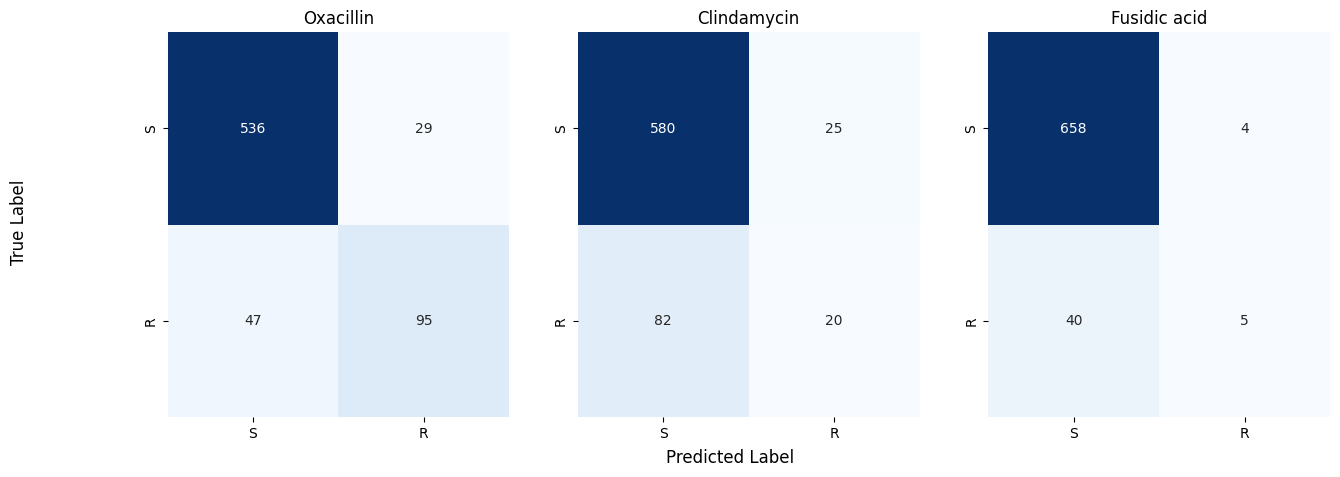

In [33]:
fig, axes = plt.subplots(1, len(antibiotics), figsize=(len(antibiotics)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_c = multilabel_confusion_matrix(test_y, pred)

for i in range(len(antibiotics)):
  sns.heatmap(ax=axes[i], data=cm_svm_c[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=antibiotics[i])